## Machine Learning Nanodegree - Capstone Project
### Who is in the photo?
The proposal of this project is to build a model that allow to recognize persons in the image using Deep Learning. 
In this notebook, I will tests 3 architectures of CNN:

* VGG16 with transfer learning 
* ResNet50 with transfer learning
* A custom architecture


### First, Load and Clean up the dataset 

In [1]:
%matplotlib inline

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import cv2


def load_face_dataset(path):
    data = load_files(path)
    general_targets = data['target']
    face_files = np.array(data['filenames'])
    face_targets = np_utils.to_categorical(np.array(data['target']), 83)
    return face_files, face_targets

train_files, train_targets = load_face_dataset('../faces/train')
valid_files, valid_targets = load_face_dataset('../faces/valid')
test_files, test_targets = load_face_dataset('../faces/test')

person_names = [item[15:-1] for item in sorted(glob("../faces/train/*/"))]

print(str(len(train_files)))
print('There are %d total person names.' % len(person_names))
print('There are %s total face images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training face images.' % len(train_files))
print('There are %d validation face images.' % len(valid_files))
print('There are %d test face images.'% len(test_files))

Using TensorFlow backend.


11071
There are 83 total person names.
There are 13823 total face images.

There are 11071 training face images.
There are 1364 validation face images.
There are 1388 test face images.


In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm
#import face_recognition

haar_cascade_path = 'haarcascade_frontalface_default.xml'
detector= cv2.CascadeClassifier(haar_cascade_path);

def extract_face(img):
    img = img.astype(np.uint8)
    faces = detector.detectMultiScale(img)
    if len(faces)> 0:
        x,y,w,h =  faces[0]
        img = img[y:y+h,x:x+w]
        img = image.array_to_img(img)
        img = img.resize((100,100))
        img = image.img_to_array(img)
        return img
    return []


def path_to_tensor(img_path, target_size=(100,100), extract_faces=False):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=target_size, grayscale=True)
    img = image.img_to_array(img)
    face = extract_face(img)
    if len(face) == 0:
        x = image.img_to_array(img)
        return np.expand_dims(x, axis=0)    
#     x = image.img_to_array(img)
    return np.expand_dims(face, axis=0)

def paths_to_tensor(img_paths, target_size=(100,100)):
    #list_of_tensors = [path_to_tensor(img_path, target_size) for img_path in tqdm(img_paths)]
    list_of_tensors = []
    for img_path in tqdm(img_paths):
        tensor = path_to_tensor(img_path, target_size)
        if len(tensor) > 0:
            list_of_tensors.append(tensor)
    return np.vstack(list_of_tensors)

#### Convert image to array

In [3]:
import cv2
from scipy.misc import imread
from scipy.misc import imresize
from tqdm import tqdm

def load_image_from(img_path):
    img = cv2.imread(img_path)
#    img = cv2.resize(img,(100,100))
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def load_images_from(img_paths):
    images = [load_image_from(path) for path in tqdm(img_paths)]
    return np.array(images)

#### Load data to train, test and validate

In [4]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255



100%|█████████████████████████████████████| 1388/1388 [00:10<00:00, 134.99it/s]


11071
11071
Julia Stiles
(100, 100, 1)
(100, 100)


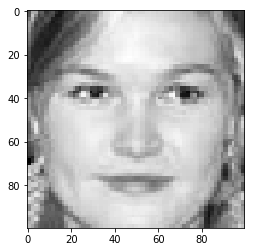

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
print(len(train_targets))
print(len(train_tensors))
index = np.where(train_targets[1] ==1)
print(person_names[45])
img = train_tensors[1]
print(img.shape)
img = img.squeeze()
print(img.shape)
plt.imshow(img, cmap=cm.gray)
plt.show()

## Deep Learning Models

I will use Convolutional Networks for the Deep Learning Models. In this section, I will starting checking some CNN Architectures, starting with VGG16.

#### Create some utitlity functions to visualize the performance of the models

In [7]:
def visualize_loss(xc, train_loss, validation_loss):
    plt.figure(1,figsize=(7,5))
    plt.plot(xc, train_loss)
    plt.plot(xc, validation_loss)
    plt.xlabel('num of epochs')
    plt.ylabel('loss')
    plt.title('Train Loss vs Validation Loss')
    plt.grid(True)
    plt.legend(['train', 'validation'])
    plt.style.use(['ggplot'])
    plt.show()


In [8]:
def visualize_acc(xc, train_acc, validation_acc):
    plt.figure(1,figsize=(7,5))
    plt.plot(xc, train_acc)
    plt.plot(xc, validation_acc)
    plt.xlabel('num of epochs')
    plt.ylabel('loss')
    plt.title('Train Accuracy vs Validation Accuracy')
    plt.grid(True)
    plt.legend(['train', 'validation'])
    plt.style.use(['ggplot'])
    plt.show()

In [9]:
from keras import backend as K

def get_featuresmaps(model, layer_index, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer_index].output,])
    activations = get_activations([X_batch, 0])
    return activations

In [10]:
def visualize_layer(model,image,layer_num=1, filter_num=1):
    activations = get_featuresmaps(model, int(layer_num), image)
    feature_maps = activations[0][0]
    fit = plt.figure(figsize=(5,5))
    plt.imshow(feature_maps[:,:, filter_num], cmap='gray')
    plt.savefig("featuremaps-layer-{}".format(layer_num)+"-filternum-{}".format(filter_num)+".jpg")
    
    num_of_featuremaps=feature_maps.shape[2]
    fig = plt.figure(figsize=(16,16))
    plt.title("featuremaps-layer-{}".format(layer_num))
    subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
    for i in range(int(num_of_featuremaps)):
        ax = fig.add_subplot(subplot_num, subplot_num, i+1)
        ax.imshow(feature_maps[:,:,i], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()
    fig.savefig('featuremaps-layer-{}'.format(layer_num)+'.jpg')

In [11]:
def show_predictions(test_image, model):
    predictions = model.predict(test_image)
    index = np.where(predictions==1)

    index = index[1][0]
    return person_names[index]


In [12]:
def compare_prediction(test_image, prediction_class):
    img = test_image
    plt.imshow(img)
    plt.show()
    
    validation_image = None
    for test_file in test_files:
        if prediction_class in test_file:
            validation_image = test_file
            break
    
    print(validation_image)
    if validation_image:
        validation_image = cv2.imread(validation_image) 
        plt.imshow(validation_image)
        plt.show()

### VGG16s

The origin of VGG architecture was a paper written by Simonyan and Zisserman in 2014 called: Very Deep Convolutional Networks for Large Scale Image Recognition [http://www.image-net.org/challenges/LSVRC/]

This network is characterized by its simplicity, using only 3×3 convolutional layers stacked on top of each other in increasing depth. Reducing volume size is handled by max pooling. Two fully-connected layers, each with 4,096 nodes are then followed by a softmax classifier 

In [35]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D,Dropout, Flatten, Dense


In [36]:
vgg16_model = VGG16(input_tensor=Input(shape=(100,100,3)),include_top=False,weights='imagenet')
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [37]:
last_layer = vgg16_model.get_layer('block5_pool').output
custom_layer = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Dropout(0.5)(custom_layer)
custom_layer = Flatten()(custom_layer)
custom_layer = Dense(100, activation='relu')(custom_layer)
output = Dense(83, activation='softmax')(custom_layer)

# custom_layer = Flatten()(last_layer)
# custom_layer = Dense(128, activation='relu')(custom_layer)
# custom_layer = Dense(128, activation='relu')(custom_layer)
# output = Dense(16, activation='softmax')(custom_layer)
custom_vgg16_model = Model(vgg16_model.input, output)
custom_vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [38]:
from keras.optimizers import SGD

custom_vgg16_model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.005), metrics=['accuracy'])

In [39]:
from keras.callbacks import ModelCheckpoint  
from time import time
epochs =70

checkpointer = ModelCheckpoint(filepath='saved_models/custom_vgg16_weights.custom.model.hdf5', 
                               verbose=1, save_best_only=True)

# to debug on tensorboard uncomment this line and put tensoboard on model callback
# tensorboard = TensorBoard(log_dir="logs/vgg16_{}".format(time()),write_images=True,write_grads=True)

trainning_result = custom_vgg16_model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=10, callbacks=[checkpointer], verbose=1)

Train on 11071 samples, validate on 1364 samples
Epoch 1/70


 2020/11071 [====>.........................] - ETA: 26:19 - loss: 4.9995 - acc: 0.0000e+ - ETA: 14:11 - loss: 4.6956 - acc: 0.0000e+ - ETA: 10:08 - loss: 4.6054 - acc: 0.0000e+ - ETA: 8:05 - loss: 4.5859 - acc: 0.0000e+00 - ETA: 6:51 - loss: 4.5731 - acc: 0.0000e+0 - ETA: 6:03 - loss: 4.6274 - acc: 0.0000e+0 - ETA: 5:27 - loss: 4.6027 - acc: 0.0000e+0 - ETA: 5:01 - loss: 4.5927 - acc: 0.0125    - ETA: 4:41 - loss: 4.5776 - acc: 0.011 - ETA: 4:24 - loss: 4.5819 - acc: 0.010 - ETA: 4:11 - loss: 4.5889 - acc: 0.009 - ETA: 3:59 - loss: 4.5749 - acc: 0.008 - ETA: 3:50 - loss: 4.5516 - acc: 0.007 - ETA: 3:42 - loss: 4.5473 - acc: 0.007 - ETA: 3:35 - loss: 4.5481 - acc: 0.006 - ETA: 3:28 - loss: 4.5403 - acc: 0.006 - ETA: 3:23 - loss: 4.5275 - acc: 0.005 - ETA: 3:18 - loss: 4.5150 - acc: 0.005 - ETA: 3:14 - loss: 4.5154 - acc: 0.005 - ETA: 3:10 - loss: 4.5120 - acc: 0.005 - ETA: 3:06 - loss: 4.5090 - acc: 0.004 - ETA: 3:03 - loss: 4.5021 - acc: 0.004 - ETA: 3:00 - loss: 4.5071 - acc: 0.004 - 

 6120/11071 [===============>..............] - ETA: 1:18 - loss: 4.4134 - acc: 0.018 - ETA: 1:18 - loss: 4.4132 - acc: 0.018 - ETA: 1:18 - loss: 4.4131 - acc: 0.018 - ETA: 1:18 - loss: 4.4127 - acc: 0.018 - ETA: 1:17 - loss: 4.4128 - acc: 0.018 - ETA: 1:17 - loss: 4.4130 - acc: 0.018 - ETA: 1:17 - loss: 4.4126 - acc: 0.018 - ETA: 1:17 - loss: 4.4126 - acc: 0.018 - ETA: 1:17 - loss: 4.4125 - acc: 0.018 - ETA: 1:17 - loss: 4.4131 - acc: 0.018 - ETA: 1:17 - loss: 4.4132 - acc: 0.018 - ETA: 1:17 - loss: 4.4131 - acc: 0.017 - ETA: 1:17 - loss: 4.4131 - acc: 0.017 - ETA: 1:16 - loss: 4.4129 - acc: 0.017 - ETA: 1:16 - loss: 4.4129 - acc: 0.017 - ETA: 1:16 - loss: 4.4131 - acc: 0.017 - ETA: 1:16 - loss: 4.4132 - acc: 0.017 - ETA: 1:16 - loss: 4.4134 - acc: 0.017 - ETA: 1:16 - loss: 4.4135 - acc: 0.017 - ETA: 1:16 - loss: 4.4135 - acc: 0.017 - ETA: 1:16 - loss: 4.4135 - acc: 0.017 - ETA: 1:15 - loss: 4.4135 - acc: 0.017 - ETA: 1:15 - loss: 4.4135 - acc: 0.017 - ETA: 1:15 - loss: 4.4137 - acc: 0

 8270/11071 [=====================>........] - ETA: 54s - loss: 4.4061 - acc: 0.02 - ETA: 54s - loss: 4.4061 - acc: 0.02 - ETA: 54s - loss: 4.4060 - acc: 0.02 - ETA: 54s - loss: 4.4060 - acc: 0.02 - ETA: 54s - loss: 4.4061 - acc: 0.01 - ETA: 54s - loss: 4.4061 - acc: 0.01 - ETA: 53s - loss: 4.4060 - acc: 0.01 - ETA: 53s - loss: 4.4060 - acc: 0.01 - ETA: 53s - loss: 4.4060 - acc: 0.02 - ETA: 53s - loss: 4.4059 - acc: 0.01 - ETA: 53s - loss: 4.4059 - acc: 0.01 - ETA: 53s - loss: 4.4061 - acc: 0.02 - ETA: 53s - loss: 4.4060 - acc: 0.02 - ETA: 53s - loss: 4.4058 - acc: 0.02 - ETA: 53s - loss: 4.4050 - acc: 0.02 - ETA: 52s - loss: 4.4055 - acc: 0.02 - ETA: 52s - loss: 4.4053 - acc: 0.02 - ETA: 52s - loss: 4.4051 - acc: 0.02 - ETA: 52s - loss: 4.4048 - acc: 0.02 - ETA: 52s - loss: 4.4048 - acc: 0.02 - ETA: 52s - loss: 4.4050 - acc: 0.02 - ETA: 52s - loss: 4.4048 - acc: 0.02 - ETA: 52s - loss: 4.4047 - acc: 0.02 - ETA: 52s - loss: 4.4045 - acc: 0.02 - ETA: 51s - loss: 4.4045 - acc: 0.02 - ETA

10420/11071 [===========================>..] - ETA: 30s - loss: 4.3897 - acc: 0.02 - ETA: 30s - loss: 4.3895 - acc: 0.02 - ETA: 30s - loss: 4.3896 - acc: 0.02 - ETA: 30s - loss: 4.3895 - acc: 0.02 - ETA: 30s - loss: 4.3893 - acc: 0.02 - ETA: 29s - loss: 4.3895 - acc: 0.02 - ETA: 29s - loss: 4.3895 - acc: 0.02 - ETA: 29s - loss: 4.3893 - acc: 0.02 - ETA: 29s - loss: 4.3892 - acc: 0.02 - ETA: 29s - loss: 4.3891 - acc: 0.02 - ETA: 29s - loss: 4.3890 - acc: 0.02 - ETA: 29s - loss: 4.3889 - acc: 0.02 - ETA: 29s - loss: 4.3892 - acc: 0.02 - ETA: 29s - loss: 4.3892 - acc: 0.02 - ETA: 28s - loss: 4.3890 - acc: 0.02 - ETA: 28s - loss: 4.3890 - acc: 0.02 - ETA: 28s - loss: 4.3885 - acc: 0.02 - ETA: 28s - loss: 4.3888 - acc: 0.02 - ETA: 28s - loss: 4.3889 - acc: 0.02 - ETA: 28s - loss: 4.3887 - acc: 0.02 - ETA: 28s - loss: 4.3886 - acc: 0.02 - ETA: 28s - loss: 4.3879 - acc: 0.02 - ETA: 28s - loss: 4.3875 - acc: 0.02 - ETA: 27s - loss: 4.3874 - acc: 0.02 - ETA: 27s - loss: 4.3872 - acc: 0.02 - ETA

11071/11071 [==============================] - 126s 11ms/step - loss: 4.3583 - acc: 0.0257 - val_loss: 4.1821 - val_acc: 0.0367
Epoch 2/70


 2040/11071 [====>.........................] - ETA: 1:53 - loss: 4.2224 - acc: 0.0000e+0 - ETA: 1:57 - loss: 4.2188 - acc: 0.0000e+0 - ETA: 1:58 - loss: 4.2363 - acc: 0.0000e+0 - ETA: 1:58 - loss: 4.2128 - acc: 0.0250    - ETA: 1:59 - loss: 4.1981 - acc: 0.040 - ETA: 1:59 - loss: 4.2030 - acc: 0.033 - ETA: 2:00 - loss: 4.2424 - acc: 0.028 - ETA: 2:06 - loss: 4.2196 - acc: 0.025 - ETA: 2:05 - loss: 4.2075 - acc: 0.022 - ETA: 2:03 - loss: 4.1809 - acc: 0.040 - ETA: 2:02 - loss: 4.1799 - acc: 0.036 - ETA: 2:01 - loss: 4.2023 - acc: 0.050 - ETA: 2:00 - loss: 4.1837 - acc: 0.046 - ETA: 1:59 - loss: 4.1464 - acc: 0.050 - ETA: 1:58 - loss: 4.1512 - acc: 0.046 - ETA: 1:58 - loss: 4.1514 - acc: 0.043 - ETA: 1:57 - loss: 4.1603 - acc: 0.047 - ETA: 1:56 - loss: 4.1718 - acc: 0.044 - ETA: 1:56 - loss: 4.1772 - acc: 0.042 - ETA: 1:55 - loss: 4.1689 - acc: 0.045 - ETA: 1:55 - loss: 4.1772 - acc: 0.042 - ETA: 1:56 - loss: 4.1780 - acc: 0.040 - ETA: 1:56 - loss: 4.2019 - acc: 0.039 - ETA: 1:56 - loss:

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 4.0610 - acc: 0.050 - ETA: 1:15 - loss: 4.0616 - acc: 0.050 - ETA: 1:15 - loss: 4.0620 - acc: 0.050 - ETA: 1:14 - loss: 4.0617 - acc: 0.050 - ETA: 1:14 - loss: 4.0619 - acc: 0.049 - ETA: 1:14 - loss: 4.0616 - acc: 0.050 - ETA: 1:14 - loss: 4.0609 - acc: 0.049 - ETA: 1:14 - loss: 4.0604 - acc: 0.049 - ETA: 1:14 - loss: 4.0599 - acc: 0.049 - ETA: 1:14 - loss: 4.0593 - acc: 0.050 - ETA: 1:14 - loss: 4.0584 - acc: 0.049 - ETA: 1:14 - loss: 4.0577 - acc: 0.050 - ETA: 1:13 - loss: 4.0568 - acc: 0.050 - ETA: 1:13 - loss: 4.0579 - acc: 0.050 - ETA: 1:13 - loss: 4.0572 - acc: 0.050 - ETA: 1:13 - loss: 4.0571 - acc: 0.050 - ETA: 1:13 - loss: 4.0562 - acc: 0.050 - ETA: 1:13 - loss: 4.0555 - acc: 0.050 - ETA: 1:13 - loss: 4.0553 - acc: 0.049 - ETA: 1:13 - loss: 4.0559 - acc: 0.049 - ETA: 1:13 - loss: 4.0557 - acc: 0.049 - ETA: 1:13 - loss: 4.0557 - acc: 0.049 - ETA: 1:12 - loss: 4.0544 - acc: 0.050 - ETA: 1:12 - loss: 4.0555 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 4.0197 - acc: 0.05 - ETA: 53s - loss: 4.0188 - acc: 0.05 - ETA: 53s - loss: 4.0190 - acc: 0.05 - ETA: 52s - loss: 4.0186 - acc: 0.05 - ETA: 52s - loss: 4.0188 - acc: 0.05 - ETA: 52s - loss: 4.0181 - acc: 0.05 - ETA: 52s - loss: 4.0176 - acc: 0.05 - ETA: 52s - loss: 4.0176 - acc: 0.05 - ETA: 52s - loss: 4.0171 - acc: 0.05 - ETA: 52s - loss: 4.0174 - acc: 0.05 - ETA: 52s - loss: 4.0169 - acc: 0.05 - ETA: 52s - loss: 4.0166 - acc: 0.05 - ETA: 51s - loss: 4.0160 - acc: 0.05 - ETA: 51s - loss: 4.0156 - acc: 0.05 - ETA: 51s - loss: 4.0158 - acc: 0.05 - ETA: 51s - loss: 4.0154 - acc: 0.05 - ETA: 51s - loss: 4.0155 - acc: 0.05 - ETA: 51s - loss: 4.0150 - acc: 0.05 - ETA: 51s - loss: 4.0152 - acc: 0.05 - ETA: 51s - loss: 4.0145 - acc: 0.05 - ETA: 51s - loss: 4.0145 - acc: 0.05 - ETA: 50s - loss: 4.0144 - acc: 0.05 - ETA: 50s - loss: 4.0139 - acc: 0.05 - ETA: 50s - loss: 4.0139 - acc: 0.05 - ETA: 50s - loss: 4.0144 - acc: 0.05 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 3.9551 - acc: 0.06 - ETA: 29s - loss: 3.9549 - acc: 0.06 - ETA: 29s - loss: 3.9553 - acc: 0.06 - ETA: 29s - loss: 3.9547 - acc: 0.06 - ETA: 29s - loss: 3.9549 - acc: 0.06 - ETA: 29s - loss: 3.9546 - acc: 0.06 - ETA: 29s - loss: 3.9545 - acc: 0.06 - ETA: 29s - loss: 3.9539 - acc: 0.06 - ETA: 29s - loss: 3.9535 - acc: 0.06 - ETA: 28s - loss: 3.9530 - acc: 0.06 - ETA: 28s - loss: 3.9524 - acc: 0.06 - ETA: 28s - loss: 3.9523 - acc: 0.06 - ETA: 28s - loss: 3.9521 - acc: 0.06 - ETA: 28s - loss: 3.9523 - acc: 0.06 - ETA: 28s - loss: 3.9517 - acc: 0.06 - ETA: 28s - loss: 3.9506 - acc: 0.06 - ETA: 28s - loss: 3.9504 - acc: 0.06 - ETA: 28s - loss: 3.9505 - acc: 0.06 - ETA: 28s - loss: 3.9509 - acc: 0.06 - ETA: 27s - loss: 3.9505 - acc: 0.06 - ETA: 27s - loss: 3.9503 - acc: 0.06 - ETA: 27s - loss: 3.9502 - acc: 0.06 - ETA: 27s - loss: 3.9502 - acc: 0.06 - ETA: 27s - loss: 3.9501 - acc: 0.06 - ETA: 27s - loss: 3.9496 - acc: 0.06 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 3.8827 - acc: 0.0749 - val_loss: 3.9818 - val_acc: 0.0660
Epoch 3/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 3.8564 - acc: 0.200 - ETA: 1:58 - loss: 4.8302 - acc: 0.150 - ETA: 1:58 - loss: 4.5632 - acc: 0.133 - ETA: 1:59 - loss: 4.5275 - acc: 0.100 - ETA: 1:59 - loss: 4.4145 - acc: 0.080 - ETA: 1:59 - loss: 4.3118 - acc: 0.083 - ETA: 1:59 - loss: 4.2382 - acc: 0.085 - ETA: 1:58 - loss: 4.1658 - acc: 0.075 - ETA: 1:58 - loss: 4.0885 - acc: 0.088 - ETA: 1:58 - loss: 4.0254 - acc: 0.100 - ETA: 1:58 - loss: 4.0009 - acc: 0.109 - ETA: 1:58 - loss: 3.9723 - acc: 0.108 - ETA: 1:58 - loss: 3.9329 - acc: 0.107 - ETA: 1:58 - loss: 3.9173 - acc: 0.107 - ETA: 1:58 - loss: 3.8814 - acc: 0.113 - ETA: 1:58 - loss: 3.8724 - acc: 0.106 - ETA: 1:58 - loss: 3.8803 - acc: 0.105 - ETA: 1:57 - loss: 3.8786 - acc: 0.105 - ETA: 1:57 - loss: 3.8597 - acc: 0.100 - ETA: 1:57 - loss: 3.8371 - acc: 0.100 - ETA: 1:57 - loss: 3.8370 - acc: 0.100 - ETA: 1:57 - loss: 3.8347 - acc: 0.100 - ETA: 1:57 - loss: 3.8122 - acc: 0.104 - ETA: 1:57 - loss: 3.8045 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 3.4688 - acc: 0.139 - ETA: 1:15 - loss: 3.4686 - acc: 0.139 - ETA: 1:15 - loss: 3.4678 - acc: 0.139 - ETA: 1:15 - loss: 3.4657 - acc: 0.140 - ETA: 1:15 - loss: 3.4634 - acc: 0.140 - ETA: 1:15 - loss: 3.4623 - acc: 0.140 - ETA: 1:15 - loss: 3.4603 - acc: 0.141 - ETA: 1:15 - loss: 3.4602 - acc: 0.140 - ETA: 1:15 - loss: 3.4586 - acc: 0.140 - ETA: 1:14 - loss: 3.4587 - acc: 0.140 - ETA: 1:14 - loss: 3.4609 - acc: 0.140 - ETA: 1:14 - loss: 3.4621 - acc: 0.140 - ETA: 1:14 - loss: 3.4632 - acc: 0.140 - ETA: 1:14 - loss: 3.4621 - acc: 0.140 - ETA: 1:14 - loss: 3.4622 - acc: 0.140 - ETA: 1:14 - loss: 3.4616 - acc: 0.140 - ETA: 1:14 - loss: 3.4609 - acc: 0.140 - ETA: 1:14 - loss: 3.4626 - acc: 0.140 - ETA: 1:13 - loss: 3.4616 - acc: 0.140 - ETA: 1:13 - loss: 3.4600 - acc: 0.140 - ETA: 1:13 - loss: 3.4594 - acc: 0.140 - ETA: 1:13 - loss: 3.4574 - acc: 0.140 - ETA: 1:13 - loss: 3.4555 - acc: 0.141 - ETA: 1:13 - loss: 3.4574 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 3.4043 - acc: 0.15 - ETA: 53s - loss: 3.4031 - acc: 0.15 - ETA: 53s - loss: 3.4026 - acc: 0.15 - ETA: 53s - loss: 3.4016 - acc: 0.15 - ETA: 52s - loss: 3.4015 - acc: 0.15 - ETA: 52s - loss: 3.4018 - acc: 0.15 - ETA: 52s - loss: 3.4017 - acc: 0.15 - ETA: 52s - loss: 3.4019 - acc: 0.15 - ETA: 52s - loss: 3.4016 - acc: 0.15 - ETA: 52s - loss: 3.4015 - acc: 0.15 - ETA: 52s - loss: 3.4010 - acc: 0.15 - ETA: 52s - loss: 3.4012 - acc: 0.15 - ETA: 52s - loss: 3.4013 - acc: 0.15 - ETA: 52s - loss: 3.4005 - acc: 0.15 - ETA: 51s - loss: 3.4005 - acc: 0.15 - ETA: 51s - loss: 3.4004 - acc: 0.15 - ETA: 51s - loss: 3.4005 - acc: 0.15 - ETA: 51s - loss: 3.4005 - acc: 0.15 - ETA: 51s - loss: 3.3999 - acc: 0.15 - ETA: 51s - loss: 3.3991 - acc: 0.15 - ETA: 51s - loss: 3.3993 - acc: 0.15 - ETA: 51s - loss: 3.3984 - acc: 0.15 - ETA: 51s - loss: 3.3993 - acc: 0.15 - ETA: 50s - loss: 3.4009 - acc: 0.15 - ETA: 50s - loss: 3.4004 - acc: 0.15 - ETA

10450/11071 [===========================>..] - ETA: 30s - loss: 3.3540 - acc: 0.16 - ETA: 29s - loss: 3.3539 - acc: 0.16 - ETA: 29s - loss: 3.3529 - acc: 0.16 - ETA: 29s - loss: 3.3522 - acc: 0.16 - ETA: 29s - loss: 3.3521 - acc: 0.16 - ETA: 29s - loss: 3.3519 - acc: 0.16 - ETA: 29s - loss: 3.3524 - acc: 0.16 - ETA: 29s - loss: 3.3538 - acc: 0.16 - ETA: 29s - loss: 3.3533 - acc: 0.16 - ETA: 29s - loss: 3.3534 - acc: 0.16 - ETA: 28s - loss: 3.3531 - acc: 0.16 - ETA: 28s - loss: 3.3531 - acc: 0.16 - ETA: 28s - loss: 3.3531 - acc: 0.16 - ETA: 28s - loss: 3.3526 - acc: 0.16 - ETA: 28s - loss: 3.3520 - acc: 0.16 - ETA: 28s - loss: 3.3513 - acc: 0.16 - ETA: 28s - loss: 3.3508 - acc: 0.16 - ETA: 28s - loss: 3.3503 - acc: 0.16 - ETA: 28s - loss: 3.3493 - acc: 0.16 - ETA: 27s - loss: 3.3496 - acc: 0.16 - ETA: 27s - loss: 3.3485 - acc: 0.16 - ETA: 27s - loss: 3.3482 - acc: 0.16 - ETA: 27s - loss: 3.3466 - acc: 0.16 - ETA: 27s - loss: 3.3454 - acc: 0.16 - ETA: 27s - loss: 3.3449 - acc: 0.16 - ETA

11071/11071 [==============================] - 125s 11ms/step - loss: 3.2818 - acc: 0.1747 - val_loss: 5.2256 - val_acc: 0.0740
Epoch 4/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 4.6088 - acc: 0.200 - ETA: 1:59 - loss: 4.1425 - acc: 0.150 - ETA: 1:59 - loss: 3.8203 - acc: 0.200 - ETA: 2:00 - loss: 3.7178 - acc: 0.175 - ETA: 2:00 - loss: 3.6271 - acc: 0.180 - ETA: 2:00 - loss: 3.5846 - acc: 0.166 - ETA: 2:00 - loss: 3.4792 - acc: 0.185 - ETA: 2:00 - loss: 3.5247 - acc: 0.175 - ETA: 1:59 - loss: 3.4125 - acc: 0.200 - ETA: 1:59 - loss: 3.3427 - acc: 0.180 - ETA: 1:59 - loss: 3.3496 - acc: 0.190 - ETA: 1:59 - loss: 3.3256 - acc: 0.191 - ETA: 1:59 - loss: 3.2923 - acc: 0.192 - ETA: 1:59 - loss: 3.2607 - acc: 0.185 - ETA: 1:58 - loss: 3.2558 - acc: 0.180 - ETA: 1:59 - loss: 3.2528 - acc: 0.175 - ETA: 1:58 - loss: 3.3086 - acc: 0.176 - ETA: 1:58 - loss: 3.2969 - acc: 0.172 - ETA: 1:58 - loss: 3.2819 - acc: 0.184 - ETA: 1:58 - loss: 3.2563 - acc: 0.195 - ETA: 1:58 - loss: 3.2286 - acc: 0.190 - ETA: 1:58 - loss: 3.2246 - acc: 0.200 - ETA: 1:58 - loss: 3.1681 - acc: 0.204 - ETA: 1:58 - loss: 3.1491 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 2.8323 - acc: 0.262 - ETA: 1:15 - loss: 2.8306 - acc: 0.262 - ETA: 1:15 - loss: 2.8317 - acc: 0.262 - ETA: 1:15 - loss: 2.8318 - acc: 0.261 - ETA: 1:15 - loss: 2.8330 - acc: 0.261 - ETA: 1:15 - loss: 2.8313 - acc: 0.261 - ETA: 1:15 - loss: 2.8293 - acc: 0.261 - ETA: 1:15 - loss: 2.8287 - acc: 0.261 - ETA: 1:15 - loss: 2.8265 - acc: 0.262 - ETA: 1:14 - loss: 2.8253 - acc: 0.262 - ETA: 1:14 - loss: 2.8224 - acc: 0.263 - ETA: 1:14 - loss: 2.8232 - acc: 0.263 - ETA: 1:14 - loss: 2.8255 - acc: 0.262 - ETA: 1:14 - loss: 2.8264 - acc: 0.262 - ETA: 1:14 - loss: 2.8272 - acc: 0.262 - ETA: 1:14 - loss: 2.8265 - acc: 0.263 - ETA: 1:14 - loss: 2.8274 - acc: 0.262 - ETA: 1:14 - loss: 2.8273 - acc: 0.262 - ETA: 1:14 - loss: 2.8270 - acc: 0.263 - ETA: 1:13 - loss: 2.8263 - acc: 0.263 - ETA: 1:13 - loss: 2.8265 - acc: 0.263 - ETA: 1:13 - loss: 2.8261 - acc: 0.263 - ETA: 1:13 - loss: 2.8260 - acc: 0.263 - ETA: 1:13 - loss: 2.8260 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 2.7747 - acc: 0.27 - ETA: 53s - loss: 2.7739 - acc: 0.27 - ETA: 53s - loss: 2.7739 - acc: 0.27 - ETA: 53s - loss: 2.7727 - acc: 0.27 - ETA: 53s - loss: 2.7712 - acc: 0.27 - ETA: 52s - loss: 2.7703 - acc: 0.27 - ETA: 52s - loss: 2.7693 - acc: 0.27 - ETA: 52s - loss: 2.7701 - acc: 0.27 - ETA: 52s - loss: 2.7689 - acc: 0.27 - ETA: 52s - loss: 2.7678 - acc: 0.27 - ETA: 52s - loss: 2.7692 - acc: 0.27 - ETA: 52s - loss: 2.7695 - acc: 0.27 - ETA: 52s - loss: 2.7688 - acc: 0.27 - ETA: 52s - loss: 2.7670 - acc: 0.27 - ETA: 51s - loss: 2.7664 - acc: 0.27 - ETA: 51s - loss: 2.7659 - acc: 0.27 - ETA: 51s - loss: 2.7657 - acc: 0.27 - ETA: 51s - loss: 2.7661 - acc: 0.27 - ETA: 51s - loss: 2.7653 - acc: 0.27 - ETA: 51s - loss: 2.7652 - acc: 0.27 - ETA: 51s - loss: 2.7638 - acc: 0.27 - ETA: 51s - loss: 2.7647 - acc: 0.27 - ETA: 51s - loss: 2.7662 - acc: 0.27 - ETA: 50s - loss: 2.7672 - acc: 0.27 - ETA: 50s - loss: 2.7672 - acc: 0.27 - ETA

10450/11071 [===========================>..] - ETA: 30s - loss: 2.7054 - acc: 0.28 - ETA: 29s - loss: 2.7036 - acc: 0.28 - ETA: 29s - loss: 2.7028 - acc: 0.28 - ETA: 29s - loss: 2.7031 - acc: 0.28 - ETA: 29s - loss: 2.7024 - acc: 0.28 - ETA: 29s - loss: 2.7018 - acc: 0.28 - ETA: 29s - loss: 2.7017 - acc: 0.28 - ETA: 29s - loss: 2.7006 - acc: 0.28 - ETA: 29s - loss: 2.7008 - acc: 0.28 - ETA: 29s - loss: 2.7005 - acc: 0.28 - ETA: 28s - loss: 2.7014 - acc: 0.28 - ETA: 28s - loss: 2.7009 - acc: 0.28 - ETA: 28s - loss: 2.6999 - acc: 0.28 - ETA: 28s - loss: 2.6996 - acc: 0.28 - ETA: 28s - loss: 2.6996 - acc: 0.28 - ETA: 28s - loss: 2.6994 - acc: 0.28 - ETA: 28s - loss: 2.6985 - acc: 0.28 - ETA: 28s - loss: 2.6970 - acc: 0.29 - ETA: 28s - loss: 2.6965 - acc: 0.29 - ETA: 27s - loss: 2.6969 - acc: 0.29 - ETA: 27s - loss: 2.6960 - acc: 0.29 - ETA: 27s - loss: 2.6953 - acc: 0.29 - ETA: 27s - loss: 2.6949 - acc: 0.29 - ETA: 27s - loss: 2.6943 - acc: 0.29 - ETA: 27s - loss: 2.6946 - acc: 0.29 - ETA

11071/11071 [==============================] - 125s 11ms/step - loss: 2.6306 - acc: 0.3066 - val_loss: 2.2407 - val_acc: 0.3959
Epoch 5/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 1.5767 - acc: 0.600 - ETA: 1:58 - loss: 2.0604 - acc: 0.350 - ETA: 1:58 - loss: 2.0652 - acc: 0.400 - ETA: 1:59 - loss: 1.8834 - acc: 0.425 - ETA: 1:59 - loss: 1.9601 - acc: 0.420 - ETA: 1:59 - loss: 1.9239 - acc: 0.433 - ETA: 1:59 - loss: 1.9757 - acc: 0.428 - ETA: 1:59 - loss: 2.0132 - acc: 0.412 - ETA: 1:59 - loss: 1.9228 - acc: 0.444 - ETA: 1:59 - loss: 2.0060 - acc: 0.420 - ETA: 1:59 - loss: 2.1273 - acc: 0.418 - ETA: 1:59 - loss: 2.1692 - acc: 0.408 - ETA: 1:59 - loss: 2.1645 - acc: 0.407 - ETA: 1:59 - loss: 2.1342 - acc: 0.421 - ETA: 1:59 - loss: 2.1356 - acc: 0.420 - ETA: 1:59 - loss: 2.1123 - acc: 0.425 - ETA: 1:58 - loss: 2.0908 - acc: 0.435 - ETA: 1:58 - loss: 2.0666 - acc: 0.438 - ETA: 1:58 - loss: 2.0233 - acc: 0.452 - ETA: 1:58 - loss: 2.0487 - acc: 0.435 - ETA: 1:58 - loss: 2.0845 - acc: 0.438 - ETA: 1:58 - loss: 2.1106 - acc: 0.431 - ETA: 1:58 - loss: 2.0837 - acc: 0.439 - ETA: 1:58 - loss: 2.0948 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:16 - loss: 2.1411 - acc: 0.417 - ETA: 1:16 - loss: 2.1402 - acc: 0.417 - ETA: 1:15 - loss: 2.1396 - acc: 0.417 - ETA: 1:15 - loss: 2.1390 - acc: 0.417 - ETA: 1:15 - loss: 2.1381 - acc: 0.418 - ETA: 1:15 - loss: 2.1377 - acc: 0.418 - ETA: 1:15 - loss: 2.1361 - acc: 0.418 - ETA: 1:15 - loss: 2.1350 - acc: 0.418 - ETA: 1:15 - loss: 2.1331 - acc: 0.419 - ETA: 1:15 - loss: 2.1322 - acc: 0.419 - ETA: 1:15 - loss: 2.1313 - acc: 0.419 - ETA: 1:14 - loss: 2.1325 - acc: 0.418 - ETA: 1:14 - loss: 2.1320 - acc: 0.419 - ETA: 1:14 - loss: 2.1316 - acc: 0.419 - ETA: 1:14 - loss: 2.1320 - acc: 0.419 - ETA: 1:14 - loss: 2.1328 - acc: 0.419 - ETA: 1:14 - loss: 2.1333 - acc: 0.419 - ETA: 1:14 - loss: 2.1328 - acc: 0.419 - ETA: 1:14 - loss: 2.1330 - acc: 0.419 - ETA: 1:14 - loss: 2.1342 - acc: 0.418 - ETA: 1:13 - loss: 2.1331 - acc: 0.419 - ETA: 1:13 - loss: 2.1330 - acc: 0.419 - ETA: 1:13 - loss: 2.1307 - acc: 0.420 - ETA: 1:13 - loss: 2.1288 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 2.1097 - acc: 0.42 - ETA: 53s - loss: 2.1095 - acc: 0.42 - ETA: 53s - loss: 2.1098 - acc: 0.42 - ETA: 53s - loss: 2.1101 - acc: 0.42 - ETA: 53s - loss: 2.1090 - acc: 0.42 - ETA: 53s - loss: 2.1087 - acc: 0.42 - ETA: 52s - loss: 2.1076 - acc: 0.42 - ETA: 52s - loss: 2.1091 - acc: 0.42 - ETA: 52s - loss: 2.1084 - acc: 0.42 - ETA: 52s - loss: 2.1073 - acc: 0.42 - ETA: 52s - loss: 2.1068 - acc: 0.42 - ETA: 52s - loss: 2.1060 - acc: 0.42 - ETA: 52s - loss: 2.1061 - acc: 0.42 - ETA: 52s - loss: 2.1072 - acc: 0.42 - ETA: 52s - loss: 2.1083 - acc: 0.42 - ETA: 51s - loss: 2.1081 - acc: 0.42 - ETA: 51s - loss: 2.1081 - acc: 0.42 - ETA: 51s - loss: 2.1080 - acc: 0.42 - ETA: 51s - loss: 2.1089 - acc: 0.42 - ETA: 51s - loss: 2.1079 - acc: 0.42 - ETA: 51s - loss: 2.1080 - acc: 0.42 - ETA: 51s - loss: 2.1079 - acc: 0.42 - ETA: 51s - loss: 2.1070 - acc: 0.42 - ETA: 51s - loss: 2.1051 - acc: 0.42 - ETA: 50s - loss: 2.1048 - acc: 0.42 - ETA

10450/11071 [===========================>..] - ETA: 30s - loss: 2.0913 - acc: 0.42 - ETA: 30s - loss: 2.0914 - acc: 0.42 - ETA: 29s - loss: 2.0906 - acc: 0.42 - ETA: 29s - loss: 2.0901 - acc: 0.42 - ETA: 29s - loss: 2.0914 - acc: 0.42 - ETA: 29s - loss: 2.0904 - acc: 0.42 - ETA: 29s - loss: 2.0895 - acc: 0.42 - ETA: 29s - loss: 2.0904 - acc: 0.42 - ETA: 29s - loss: 2.0912 - acc: 0.42 - ETA: 29s - loss: 2.0910 - acc: 0.42 - ETA: 29s - loss: 2.0901 - acc: 0.42 - ETA: 28s - loss: 2.0897 - acc: 0.42 - ETA: 28s - loss: 2.0892 - acc: 0.42 - ETA: 28s - loss: 2.0887 - acc: 0.42 - ETA: 28s - loss: 2.0891 - acc: 0.42 - ETA: 28s - loss: 2.0886 - acc: 0.42 - ETA: 28s - loss: 2.0880 - acc: 0.42 - ETA: 28s - loss: 2.0882 - acc: 0.42 - ETA: 28s - loss: 2.0891 - acc: 0.42 - ETA: 28s - loss: 2.0893 - acc: 0.42 - ETA: 27s - loss: 2.0891 - acc: 0.42 - ETA: 27s - loss: 2.0883 - acc: 0.42 - ETA: 27s - loss: 2.0882 - acc: 0.42 - ETA: 27s - loss: 2.0883 - acc: 0.42 - ETA: 27s - loss: 2.0879 - acc: 0.42 - ETA

11071/11071 [==============================] - 125s 11ms/step - loss: 2.0342 - acc: 0.4449 - val_loss: 1.9601 - val_acc: 0.4875
Epoch 6/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 2.0520 - acc: 0.300 - ETA: 1:58 - loss: 1.7999 - acc: 0.500 - ETA: 1:58 - loss: 1.5012 - acc: 0.566 - ETA: 1:59 - loss: 1.2756 - acc: 0.625 - ETA: 1:59 - loss: 1.4272 - acc: 0.600 - ETA: 1:58 - loss: 1.4725 - acc: 0.600 - ETA: 1:58 - loss: 1.5599 - acc: 0.571 - ETA: 1:58 - loss: 1.6751 - acc: 0.550 - ETA: 1:58 - loss: 1.6328 - acc: 0.555 - ETA: 1:58 - loss: 1.6194 - acc: 0.550 - ETA: 1:58 - loss: 1.6820 - acc: 0.536 - ETA: 1:58 - loss: 1.6890 - acc: 0.533 - ETA: 1:58 - loss: 1.6985 - acc: 0.538 - ETA: 1:58 - loss: 1.7508 - acc: 0.521 - ETA: 1:58 - loss: 1.7378 - acc: 0.533 - ETA: 1:58 - loss: 1.7410 - acc: 0.531 - ETA: 1:58 - loss: 1.7075 - acc: 0.552 - ETA: 1:58 - loss: 1.7021 - acc: 0.550 - ETA: 1:58 - loss: 1.7239 - acc: 0.547 - ETA: 1:57 - loss: 1.7036 - acc: 0.545 - ETA: 1:57 - loss: 1.6848 - acc: 0.542 - ETA: 1:57 - loss: 1.6455 - acc: 0.554 - ETA: 1:57 - loss: 1.6459 - acc: 0.556 - ETA: 1:57 - loss: 1.6653 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:16 - loss: 1.6424 - acc: 0.548 - ETA: 1:16 - loss: 1.6422 - acc: 0.548 - ETA: 1:15 - loss: 1.6430 - acc: 0.547 - ETA: 1:15 - loss: 1.6423 - acc: 0.548 - ETA: 1:15 - loss: 1.6436 - acc: 0.547 - ETA: 1:15 - loss: 1.6465 - acc: 0.547 - ETA: 1:15 - loss: 1.6470 - acc: 0.546 - ETA: 1:15 - loss: 1.6461 - acc: 0.547 - ETA: 1:15 - loss: 1.6463 - acc: 0.547 - ETA: 1:15 - loss: 1.6466 - acc: 0.546 - ETA: 1:15 - loss: 1.6456 - acc: 0.546 - ETA: 1:15 - loss: 1.6439 - acc: 0.546 - ETA: 1:14 - loss: 1.6444 - acc: 0.546 - ETA: 1:14 - loss: 1.6459 - acc: 0.546 - ETA: 1:14 - loss: 1.6470 - acc: 0.546 - ETA: 1:14 - loss: 1.6463 - acc: 0.546 - ETA: 1:14 - loss: 1.6452 - acc: 0.546 - ETA: 1:14 - loss: 1.6469 - acc: 0.546 - ETA: 1:14 - loss: 1.6474 - acc: 0.546 - ETA: 1:14 - loss: 1.6481 - acc: 0.546 - ETA: 1:14 - loss: 1.6474 - acc: 0.546 - ETA: 1:13 - loss: 1.6465 - acc: 0.546 - ETA: 1:13 - loss: 1.6486 - acc: 0.545 - ETA: 1:13 - loss: 1.6461 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 1.6196 - acc: 0.55 - ETA: 53s - loss: 1.6190 - acc: 0.55 - ETA: 53s - loss: 1.6191 - acc: 0.55 - ETA: 53s - loss: 1.6183 - acc: 0.55 - ETA: 53s - loss: 1.6170 - acc: 0.55 - ETA: 53s - loss: 1.6169 - acc: 0.55 - ETA: 52s - loss: 1.6176 - acc: 0.55 - ETA: 52s - loss: 1.6184 - acc: 0.55 - ETA: 52s - loss: 1.6177 - acc: 0.55 - ETA: 52s - loss: 1.6191 - acc: 0.55 - ETA: 52s - loss: 1.6180 - acc: 0.55 - ETA: 52s - loss: 1.6164 - acc: 0.55 - ETA: 52s - loss: 1.6155 - acc: 0.55 - ETA: 52s - loss: 1.6157 - acc: 0.55 - ETA: 52s - loss: 1.6155 - acc: 0.55 - ETA: 51s - loss: 1.6161 - acc: 0.55 - ETA: 51s - loss: 1.6156 - acc: 0.55 - ETA: 51s - loss: 1.6148 - acc: 0.55 - ETA: 51s - loss: 1.6157 - acc: 0.55 - ETA: 51s - loss: 1.6143 - acc: 0.55 - ETA: 51s - loss: 1.6144 - acc: 0.55 - ETA: 51s - loss: 1.6138 - acc: 0.55 - ETA: 51s - loss: 1.6126 - acc: 0.55 - ETA: 51s - loss: 1.6130 - acc: 0.55 - ETA: 50s - loss: 1.6111 - acc: 0.55 - ETA

10450/11071 [===========================>..] - ETA: 30s - loss: 1.5887 - acc: 0.56 - ETA: 30s - loss: 1.5887 - acc: 0.56 - ETA: 29s - loss: 1.5880 - acc: 0.56 - ETA: 29s - loss: 1.5874 - acc: 0.56 - ETA: 29s - loss: 1.5874 - acc: 0.56 - ETA: 29s - loss: 1.5873 - acc: 0.56 - ETA: 29s - loss: 1.5874 - acc: 0.56 - ETA: 29s - loss: 1.5872 - acc: 0.56 - ETA: 29s - loss: 1.5875 - acc: 0.56 - ETA: 29s - loss: 1.5875 - acc: 0.56 - ETA: 29s - loss: 1.5874 - acc: 0.56 - ETA: 28s - loss: 1.5871 - acc: 0.56 - ETA: 28s - loss: 1.5873 - acc: 0.56 - ETA: 28s - loss: 1.5869 - acc: 0.56 - ETA: 28s - loss: 1.5873 - acc: 0.56 - ETA: 28s - loss: 1.5865 - acc: 0.56 - ETA: 28s - loss: 1.5862 - acc: 0.56 - ETA: 28s - loss: 1.5864 - acc: 0.56 - ETA: 28s - loss: 1.5866 - acc: 0.56 - ETA: 28s - loss: 1.5861 - acc: 0.56 - ETA: 27s - loss: 1.5866 - acc: 0.56 - ETA: 27s - loss: 1.5873 - acc: 0.56 - ETA: 27s - loss: 1.5865 - acc: 0.56 - ETA: 27s - loss: 1.5875 - acc: 0.56 - ETA: 27s - loss: 1.5877 - acc: 0.56 - ETA

11071/11071 [==============================] - 125s 11ms/step - loss: 1.5597 - acc: 0.5699 - val_loss: 1.9058 - val_acc: 0.5374
Epoch 7/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 2.0082 - acc: 0.300 - ETA: 1:58 - loss: 2.7387 - acc: 0.250 - ETA: 1:58 - loss: 2.3668 - acc: 0.333 - ETA: 1:58 - loss: 2.0945 - acc: 0.425 - ETA: 1:59 - loss: 1.8213 - acc: 0.500 - ETA: 1:59 - loss: 1.6566 - acc: 0.550 - ETA: 1:59 - loss: 1.4904 - acc: 0.600 - ETA: 1:59 - loss: 1.5921 - acc: 0.587 - ETA: 1:59 - loss: 1.5345 - acc: 0.600 - ETA: 1:59 - loss: 1.4666 - acc: 0.610 - ETA: 1:58 - loss: 1.4426 - acc: 0.618 - ETA: 1:58 - loss: 1.4317 - acc: 0.616 - ETA: 1:58 - loss: 1.3978 - acc: 0.630 - ETA: 1:58 - loss: 1.3496 - acc: 0.642 - ETA: 1:58 - loss: 1.3207 - acc: 0.640 - ETA: 1:58 - loss: 1.3243 - acc: 0.631 - ETA: 1:58 - loss: 1.2997 - acc: 0.641 - ETA: 1:58 - loss: 1.3174 - acc: 0.633 - ETA: 1:58 - loss: 1.3121 - acc: 0.631 - ETA: 1:57 - loss: 1.3157 - acc: 0.625 - ETA: 1:57 - loss: 1.3057 - acc: 0.619 - ETA: 1:57 - loss: 1.2846 - acc: 0.627 - ETA: 1:57 - loss: 1.2923 - acc: 0.630 - ETA: 1:57 - loss: 1.2636 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:16 - loss: 1.2271 - acc: 0.652 - ETA: 1:15 - loss: 1.2288 - acc: 0.651 - ETA: 1:15 - loss: 1.2283 - acc: 0.651 - ETA: 1:15 - loss: 1.2288 - acc: 0.651 - ETA: 1:15 - loss: 1.2280 - acc: 0.651 - ETA: 1:15 - loss: 1.2270 - acc: 0.651 - ETA: 1:15 - loss: 1.2264 - acc: 0.652 - ETA: 1:15 - loss: 1.2264 - acc: 0.652 - ETA: 1:15 - loss: 1.2263 - acc: 0.652 - ETA: 1:15 - loss: 1.2250 - acc: 0.652 - ETA: 1:14 - loss: 1.2257 - acc: 0.652 - ETA: 1:14 - loss: 1.2277 - acc: 0.652 - ETA: 1:14 - loss: 1.2279 - acc: 0.652 - ETA: 1:14 - loss: 1.2267 - acc: 0.652 - ETA: 1:14 - loss: 1.2249 - acc: 0.653 - ETA: 1:14 - loss: 1.2237 - acc: 0.653 - ETA: 1:14 - loss: 1.2240 - acc: 0.653 - ETA: 1:14 - loss: 1.2229 - acc: 0.653 - ETA: 1:14 - loss: 1.2228 - acc: 0.653 - ETA: 1:14 - loss: 1.2219 - acc: 0.654 - ETA: 1:13 - loss: 1.2208 - acc: 0.654 - ETA: 1:13 - loss: 1.2195 - acc: 0.654 - ETA: 1:13 - loss: 1.2186 - acc: 0.654 - ETA: 1:13 - loss: 1.2193 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 1.2224 - acc: 0.65 - ETA: 53s - loss: 1.2224 - acc: 0.65 - ETA: 53s - loss: 1.2216 - acc: 0.65 - ETA: 53s - loss: 1.2222 - acc: 0.65 - ETA: 53s - loss: 1.2213 - acc: 0.65 - ETA: 53s - loss: 1.2207 - acc: 0.65 - ETA: 52s - loss: 1.2198 - acc: 0.65 - ETA: 52s - loss: 1.2190 - acc: 0.65 - ETA: 52s - loss: 1.2181 - acc: 0.65 - ETA: 52s - loss: 1.2179 - acc: 0.65 - ETA: 52s - loss: 1.2176 - acc: 0.65 - ETA: 52s - loss: 1.2196 - acc: 0.65 - ETA: 52s - loss: 1.2204 - acc: 0.65 - ETA: 52s - loss: 1.2206 - acc: 0.65 - ETA: 52s - loss: 1.2200 - acc: 0.65 - ETA: 51s - loss: 1.2195 - acc: 0.65 - ETA: 51s - loss: 1.2201 - acc: 0.65 - ETA: 51s - loss: 1.2205 - acc: 0.65 - ETA: 51s - loss: 1.2206 - acc: 0.65 - ETA: 51s - loss: 1.2217 - acc: 0.65 - ETA: 51s - loss: 1.2223 - acc: 0.65 - ETA: 51s - loss: 1.2232 - acc: 0.65 - ETA: 51s - loss: 1.2233 - acc: 0.65 - ETA: 51s - loss: 1.2219 - acc: 0.65 - ETA: 50s - loss: 1.2219 - acc: 0.65 - ETA

10450/11071 [===========================>..] - ETA: 30s - loss: 1.2081 - acc: 0.65 - ETA: 30s - loss: 1.2082 - acc: 0.65 - ETA: 29s - loss: 1.2090 - acc: 0.65 - ETA: 29s - loss: 1.2089 - acc: 0.65 - ETA: 29s - loss: 1.2099 - acc: 0.65 - ETA: 29s - loss: 1.2089 - acc: 0.65 - ETA: 29s - loss: 1.2091 - acc: 0.65 - ETA: 29s - loss: 1.2085 - acc: 0.65 - ETA: 29s - loss: 1.2081 - acc: 0.65 - ETA: 29s - loss: 1.2076 - acc: 0.65 - ETA: 29s - loss: 1.2078 - acc: 0.65 - ETA: 28s - loss: 1.2079 - acc: 0.65 - ETA: 28s - loss: 1.2077 - acc: 0.65 - ETA: 28s - loss: 1.2069 - acc: 0.65 - ETA: 28s - loss: 1.2074 - acc: 0.65 - ETA: 28s - loss: 1.2069 - acc: 0.65 - ETA: 28s - loss: 1.2066 - acc: 0.65 - ETA: 28s - loss: 1.2058 - acc: 0.65 - ETA: 28s - loss: 1.2054 - acc: 0.65 - ETA: 28s - loss: 1.2054 - acc: 0.65 - ETA: 27s - loss: 1.2041 - acc: 0.65 - ETA: 27s - loss: 1.2032 - acc: 0.65 - ETA: 27s - loss: 1.2022 - acc: 0.65 - ETA: 27s - loss: 1.2017 - acc: 0.66 - ETA: 27s - loss: 1.2013 - acc: 0.66 - ETA

11071/11071 [==============================] - 125s 11ms/step - loss: 1.1845 - acc: 0.6661 - val_loss: 1.0010 - val_acc: 0.7295
Epoch 8/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 0.8210 - acc: 0.700 - ETA: 1:58 - loss: 1.0673 - acc: 0.550 - ETA: 1:58 - loss: 0.7616 - acc: 0.700 - ETA: 1:58 - loss: 0.7272 - acc: 0.750 - ETA: 1:59 - loss: 0.7488 - acc: 0.760 - ETA: 1:58 - loss: 0.7889 - acc: 0.766 - ETA: 1:58 - loss: 0.7754 - acc: 0.771 - ETA: 1:58 - loss: 0.7758 - acc: 0.775 - ETA: 1:58 - loss: 0.8180 - acc: 0.766 - ETA: 1:58 - loss: 0.8851 - acc: 0.760 - ETA: 1:58 - loss: 0.8369 - acc: 0.772 - ETA: 1:58 - loss: 0.8364 - acc: 0.766 - ETA: 1:58 - loss: 0.8266 - acc: 0.769 - ETA: 1:58 - loss: 0.8310 - acc: 0.764 - ETA: 1:58 - loss: 0.7821 - acc: 0.780 - ETA: 1:58 - loss: 0.7782 - acc: 0.781 - ETA: 1:58 - loss: 0.7431 - acc: 0.794 - ETA: 1:58 - loss: 0.7169 - acc: 0.800 - ETA: 1:58 - loss: 0.7116 - acc: 0.805 - ETA: 1:57 - loss: 0.7414 - acc: 0.795 - ETA: 1:57 - loss: 0.7457 - acc: 0.790 - ETA: 1:57 - loss: 0.7521 - acc: 0.790 - ETA: 1:57 - loss: 0.7522 - acc: 0.791 - ETA: 1:57 - loss: 0.7509 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:16 - loss: 0.8893 - acc: 0.749 - ETA: 1:15 - loss: 0.8890 - acc: 0.749 - ETA: 1:15 - loss: 0.8896 - acc: 0.749 - ETA: 1:15 - loss: 0.8886 - acc: 0.749 - ETA: 1:15 - loss: 0.8887 - acc: 0.749 - ETA: 1:15 - loss: 0.8899 - acc: 0.749 - ETA: 1:15 - loss: 0.8892 - acc: 0.749 - ETA: 1:15 - loss: 0.8886 - acc: 0.749 - ETA: 1:15 - loss: 0.8887 - acc: 0.749 - ETA: 1:15 - loss: 0.8897 - acc: 0.749 - ETA: 1:14 - loss: 0.8932 - acc: 0.748 - ETA: 1:14 - loss: 0.8922 - acc: 0.748 - ETA: 1:14 - loss: 0.8930 - acc: 0.748 - ETA: 1:14 - loss: 0.8937 - acc: 0.747 - ETA: 1:14 - loss: 0.8936 - acc: 0.747 - ETA: 1:14 - loss: 0.8943 - acc: 0.747 - ETA: 1:14 - loss: 0.8938 - acc: 0.747 - ETA: 1:14 - loss: 0.8957 - acc: 0.747 - ETA: 1:14 - loss: 0.8947 - acc: 0.747 - ETA: 1:13 - loss: 0.8959 - acc: 0.747 - ETA: 1:13 - loss: 0.8947 - acc: 0.747 - ETA: 1:13 - loss: 0.8954 - acc: 0.747 - ETA: 1:13 - loss: 0.8947 - acc: 0.748 - ETA: 1:13 - loss: 0.8965 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.8950 - acc: 0.74 - ETA: 53s - loss: 0.8946 - acc: 0.74 - ETA: 53s - loss: 0.8939 - acc: 0.74 - ETA: 53s - loss: 0.8936 - acc: 0.74 - ETA: 53s - loss: 0.8958 - acc: 0.74 - ETA: 52s - loss: 0.8961 - acc: 0.74 - ETA: 52s - loss: 0.8965 - acc: 0.74 - ETA: 52s - loss: 0.8968 - acc: 0.74 - ETA: 52s - loss: 0.8976 - acc: 0.74 - ETA: 52s - loss: 0.8974 - acc: 0.74 - ETA: 52s - loss: 0.8972 - acc: 0.74 - ETA: 52s - loss: 0.8961 - acc: 0.74 - ETA: 52s - loss: 0.8960 - acc: 0.74 - ETA: 52s - loss: 0.8960 - acc: 0.74 - ETA: 51s - loss: 0.8955 - acc: 0.74 - ETA: 51s - loss: 0.8958 - acc: 0.74 - ETA: 51s - loss: 0.8948 - acc: 0.74 - ETA: 51s - loss: 0.8958 - acc: 0.74 - ETA: 51s - loss: 0.8969 - acc: 0.74 - ETA: 51s - loss: 0.8972 - acc: 0.74 - ETA: 51s - loss: 0.8966 - acc: 0.74 - ETA: 51s - loss: 0.8980 - acc: 0.74 - ETA: 51s - loss: 0.8975 - acc: 0.74 - ETA: 50s - loss: 0.8976 - acc: 0.74 - ETA: 50s - loss: 0.8974 - acc: 0.74 - ETA

10450/11071 [===========================>..] - ETA: 30s - loss: 0.8841 - acc: 0.75 - ETA: 29s - loss: 0.8838 - acc: 0.75 - ETA: 29s - loss: 0.8840 - acc: 0.75 - ETA: 29s - loss: 0.8839 - acc: 0.75 - ETA: 29s - loss: 0.8840 - acc: 0.75 - ETA: 29s - loss: 0.8840 - acc: 0.75 - ETA: 29s - loss: 0.8838 - acc: 0.75 - ETA: 29s - loss: 0.8841 - acc: 0.75 - ETA: 29s - loss: 0.8836 - acc: 0.75 - ETA: 29s - loss: 0.8832 - acc: 0.75 - ETA: 28s - loss: 0.8830 - acc: 0.75 - ETA: 28s - loss: 0.8823 - acc: 0.75 - ETA: 28s - loss: 0.8835 - acc: 0.75 - ETA: 28s - loss: 0.8828 - acc: 0.75 - ETA: 28s - loss: 0.8830 - acc: 0.75 - ETA: 28s - loss: 0.8825 - acc: 0.75 - ETA: 28s - loss: 0.8834 - acc: 0.75 - ETA: 28s - loss: 0.8828 - acc: 0.75 - ETA: 28s - loss: 0.8819 - acc: 0.75 - ETA: 28s - loss: 0.8814 - acc: 0.75 - ETA: 27s - loss: 0.8818 - acc: 0.75 - ETA: 27s - loss: 0.8821 - acc: 0.75 - ETA: 27s - loss: 0.8827 - acc: 0.75 - ETA: 27s - loss: 0.8828 - acc: 0.75 - ETA: 27s - loss: 0.8832 - acc: 0.75 - ETA

11071/11071 [==============================] - 125s 11ms/step - loss: 0.8802 - acc: 0.7528 - val_loss: 1.0199 - val_acc: 0.7221
Epoch 9/70


 2040/11071 [====>.........................] - ETA: 1:58 - loss: 1.8121 - acc: 0.600 - ETA: 1:59 - loss: 1.1992 - acc: 0.750 - ETA: 1:58 - loss: 0.9073 - acc: 0.800 - ETA: 1:59 - loss: 0.8714 - acc: 0.825 - ETA: 1:59 - loss: 0.8522 - acc: 0.800 - ETA: 1:59 - loss: 0.8062 - acc: 0.800 - ETA: 1:58 - loss: 0.7845 - acc: 0.800 - ETA: 1:58 - loss: 0.8188 - acc: 0.787 - ETA: 1:58 - loss: 0.9480 - acc: 0.766 - ETA: 1:58 - loss: 0.9380 - acc: 0.770 - ETA: 1:58 - loss: 0.8848 - acc: 0.781 - ETA: 1:58 - loss: 0.8295 - acc: 0.791 - ETA: 1:58 - loss: 0.7925 - acc: 0.792 - ETA: 1:58 - loss: 0.8012 - acc: 0.785 - ETA: 1:58 - loss: 0.8374 - acc: 0.773 - ETA: 1:58 - loss: 0.8315 - acc: 0.775 - ETA: 1:58 - loss: 0.8173 - acc: 0.770 - ETA: 1:58 - loss: 0.8620 - acc: 0.766 - ETA: 1:58 - loss: 0.8424 - acc: 0.773 - ETA: 1:58 - loss: 0.8210 - acc: 0.775 - ETA: 1:58 - loss: 0.7934 - acc: 0.785 - ETA: 1:57 - loss: 0.7847 - acc: 0.790 - ETA: 1:57 - loss: 0.7896 - acc: 0.787 - ETA: 1:57 - loss: 0.7646 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:16 - loss: 0.6985 - acc: 0.805 - ETA: 1:15 - loss: 0.6983 - acc: 0.805 - ETA: 1:15 - loss: 0.7007 - acc: 0.804 - ETA: 1:15 - loss: 0.7016 - acc: 0.804 - ETA: 1:15 - loss: 0.7018 - acc: 0.804 - ETA: 1:15 - loss: 0.7006 - acc: 0.804 - ETA: 1:15 - loss: 0.7017 - acc: 0.804 - ETA: 1:15 - loss: 0.7015 - acc: 0.804 - ETA: 1:15 - loss: 0.7004 - acc: 0.804 - ETA: 1:15 - loss: 0.7003 - acc: 0.804 - ETA: 1:14 - loss: 0.7000 - acc: 0.804 - ETA: 1:14 - loss: 0.6988 - acc: 0.804 - ETA: 1:14 - loss: 0.6990 - acc: 0.804 - ETA: 1:14 - loss: 0.6989 - acc: 0.804 - ETA: 1:14 - loss: 0.6985 - acc: 0.804 - ETA: 1:14 - loss: 0.6997 - acc: 0.803 - ETA: 1:14 - loss: 0.6996 - acc: 0.803 - ETA: 1:14 - loss: 0.6989 - acc: 0.803 - ETA: 1:14 - loss: 0.6988 - acc: 0.804 - ETA: 1:13 - loss: 0.6985 - acc: 0.803 - ETA: 1:13 - loss: 0.6980 - acc: 0.803 - ETA: 1:13 - loss: 0.6995 - acc: 0.803 - ETA: 1:13 - loss: 0.7008 - acc: 0.802 - ETA: 1:13 - loss: 0.7005 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.6940 - acc: 0.80 - ETA: 53s - loss: 0.6936 - acc: 0.80 - ETA: 53s - loss: 0.6929 - acc: 0.80 - ETA: 53s - loss: 0.6935 - acc: 0.80 - ETA: 53s - loss: 0.6937 - acc: 0.80 - ETA: 52s - loss: 0.6927 - acc: 0.80 - ETA: 52s - loss: 0.6925 - acc: 0.80 - ETA: 52s - loss: 0.6925 - acc: 0.80 - ETA: 52s - loss: 0.6923 - acc: 0.80 - ETA: 52s - loss: 0.6922 - acc: 0.80 - ETA: 52s - loss: 0.6917 - acc: 0.80 - ETA: 52s - loss: 0.6914 - acc: 0.80 - ETA: 52s - loss: 0.6912 - acc: 0.80 - ETA: 52s - loss: 0.6903 - acc: 0.80 - ETA: 51s - loss: 0.6908 - acc: 0.80 - ETA: 51s - loss: 0.6904 - acc: 0.80 - ETA: 51s - loss: 0.6896 - acc: 0.80 - ETA: 51s - loss: 0.6899 - acc: 0.80 - ETA: 51s - loss: 0.6905 - acc: 0.80 - ETA: 51s - loss: 0.6901 - acc: 0.80 - ETA: 51s - loss: 0.6899 - acc: 0.80 - ETA: 51s - loss: 0.6895 - acc: 0.80 - ETA: 51s - loss: 0.6891 - acc: 0.80 - ETA: 50s - loss: 0.6885 - acc: 0.80 - ETA: 50s - loss: 0.6898 - acc: 0.80 - ETA

10450/11071 [===========================>..] - ETA: 30s - loss: 0.6911 - acc: 0.80 - ETA: 29s - loss: 0.6906 - acc: 0.80 - ETA: 29s - loss: 0.6905 - acc: 0.80 - ETA: 29s - loss: 0.6910 - acc: 0.80 - ETA: 29s - loss: 0.6916 - acc: 0.80 - ETA: 29s - loss: 0.6923 - acc: 0.80 - ETA: 29s - loss: 0.6922 - acc: 0.80 - ETA: 29s - loss: 0.6921 - acc: 0.80 - ETA: 29s - loss: 0.6918 - acc: 0.80 - ETA: 29s - loss: 0.6915 - acc: 0.80 - ETA: 28s - loss: 0.6913 - acc: 0.80 - ETA: 28s - loss: 0.6907 - acc: 0.80 - ETA: 28s - loss: 0.6907 - acc: 0.80 - ETA: 28s - loss: 0.6914 - acc: 0.80 - ETA: 28s - loss: 0.6913 - acc: 0.80 - ETA: 28s - loss: 0.6911 - acc: 0.80 - ETA: 28s - loss: 0.6909 - acc: 0.80 - ETA: 28s - loss: 0.6907 - acc: 0.80 - ETA: 28s - loss: 0.6908 - acc: 0.80 - ETA: 28s - loss: 0.6908 - acc: 0.80 - ETA: 27s - loss: 0.6907 - acc: 0.80 - ETA: 27s - loss: 0.6903 - acc: 0.80 - ETA: 27s - loss: 0.6903 - acc: 0.80 - ETA: 27s - loss: 0.6899 - acc: 0.80 - ETA: 27s - loss: 0.6899 - acc: 0.80 - ETA

11071/11071 [==============================] - 125s 11ms/step - loss: 0.6804 - acc: 0.8070 - val_loss: 3.4863 - val_acc: 0.3878
Epoch 10/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 3.5034 - acc: 0.400 - ETA: 1:58 - loss: 2.6085 - acc: 0.450 - ETA: 1:59 - loss: 2.1121 - acc: 0.533 - ETA: 1:59 - loss: 1.7189 - acc: 0.600 - ETA: 1:59 - loss: 1.5047 - acc: 0.620 - ETA: 1:59 - loss: 1.3426 - acc: 0.666 - ETA: 1:58 - loss: 1.3192 - acc: 0.671 - ETA: 1:58 - loss: 1.3169 - acc: 0.662 - ETA: 1:58 - loss: 1.2817 - acc: 0.677 - ETA: 1:58 - loss: 1.1729 - acc: 0.700 - ETA: 1:58 - loss: 1.0949 - acc: 0.718 - ETA: 1:58 - loss: 1.0415 - acc: 0.733 - ETA: 1:58 - loss: 0.9860 - acc: 0.753 - ETA: 1:58 - loss: 0.9316 - acc: 0.764 - ETA: 1:58 - loss: 0.8914 - acc: 0.780 - ETA: 1:58 - loss: 0.8974 - acc: 0.768 - ETA: 1:58 - loss: 0.8810 - acc: 0.776 - ETA: 1:57 - loss: 0.8446 - acc: 0.788 - ETA: 1:57 - loss: 0.8146 - acc: 0.800 - ETA: 1:57 - loss: 0.7782 - acc: 0.810 - ETA: 1:57 - loss: 0.7738 - acc: 0.809 - ETA: 1:57 - loss: 0.7640 - acc: 0.809 - ETA: 1:57 - loss: 0.7703 - acc: 0.808 - ETA: 1:57 - loss: 0.7495 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:16 - loss: 0.4976 - acc: 0.859 - ETA: 1:15 - loss: 0.4985 - acc: 0.859 - ETA: 1:15 - loss: 0.4998 - acc: 0.858 - ETA: 1:15 - loss: 0.5010 - acc: 0.858 - ETA: 1:15 - loss: 0.5006 - acc: 0.858 - ETA: 1:15 - loss: 0.5009 - acc: 0.858 - ETA: 1:15 - loss: 0.5001 - acc: 0.858 - ETA: 1:15 - loss: 0.5000 - acc: 0.858 - ETA: 1:15 - loss: 0.4997 - acc: 0.858 - ETA: 1:15 - loss: 0.4994 - acc: 0.858 - ETA: 1:14 - loss: 0.5005 - acc: 0.858 - ETA: 1:14 - loss: 0.5003 - acc: 0.858 - ETA: 1:14 - loss: 0.5009 - acc: 0.858 - ETA: 1:14 - loss: 0.5006 - acc: 0.858 - ETA: 1:14 - loss: 0.5006 - acc: 0.858 - ETA: 1:14 - loss: 0.5012 - acc: 0.858 - ETA: 1:14 - loss: 0.5023 - acc: 0.857 - ETA: 1:14 - loss: 0.5020 - acc: 0.857 - ETA: 1:14 - loss: 0.5012 - acc: 0.857 - ETA: 1:13 - loss: 0.5004 - acc: 0.857 - ETA: 1:13 - loss: 0.4996 - acc: 0.858 - ETA: 1:13 - loss: 0.4991 - acc: 0.858 - ETA: 1:13 - loss: 0.4988 - acc: 0.858 - ETA: 1:13 - loss: 0.4987 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.4942 - acc: 0.86 - ETA: 53s - loss: 0.4937 - acc: 0.86 - ETA: 53s - loss: 0.4949 - acc: 0.86 - ETA: 53s - loss: 0.4948 - acc: 0.86 - ETA: 53s - loss: 0.4943 - acc: 0.86 - ETA: 52s - loss: 0.4936 - acc: 0.86 - ETA: 52s - loss: 0.4929 - acc: 0.86 - ETA: 52s - loss: 0.4935 - acc: 0.86 - ETA: 52s - loss: 0.4942 - acc: 0.86 - ETA: 52s - loss: 0.4944 - acc: 0.86 - ETA: 52s - loss: 0.4938 - acc: 0.86 - ETA: 52s - loss: 0.4937 - acc: 0.86 - ETA: 52s - loss: 0.4929 - acc: 0.86 - ETA: 52s - loss: 0.4927 - acc: 0.86 - ETA: 51s - loss: 0.4924 - acc: 0.86 - ETA: 51s - loss: 0.4923 - acc: 0.86 - ETA: 51s - loss: 0.4918 - acc: 0.86 - ETA: 51s - loss: 0.4948 - acc: 0.86 - ETA: 51s - loss: 0.4951 - acc: 0.86 - ETA: 51s - loss: 0.4963 - acc: 0.86 - ETA: 51s - loss: 0.4973 - acc: 0.86 - ETA: 51s - loss: 0.4979 - acc: 0.85 - ETA: 51s - loss: 0.4976 - acc: 0.86 - ETA: 50s - loss: 0.4971 - acc: 0.86 - ETA: 50s - loss: 0.4966 - acc: 0.86 - ETA

10450/11071 [===========================>..] - ETA: 30s - loss: 0.4978 - acc: 0.85 - ETA: 29s - loss: 0.4973 - acc: 0.85 - ETA: 29s - loss: 0.4971 - acc: 0.85 - ETA: 29s - loss: 0.4973 - acc: 0.85 - ETA: 29s - loss: 0.4976 - acc: 0.85 - ETA: 29s - loss: 0.4979 - acc: 0.85 - ETA: 29s - loss: 0.4980 - acc: 0.85 - ETA: 29s - loss: 0.4979 - acc: 0.85 - ETA: 29s - loss: 0.4978 - acc: 0.85 - ETA: 29s - loss: 0.4978 - acc: 0.85 - ETA: 28s - loss: 0.4979 - acc: 0.85 - ETA: 28s - loss: 0.4978 - acc: 0.85 - ETA: 28s - loss: 0.4978 - acc: 0.85 - ETA: 28s - loss: 0.4978 - acc: 0.85 - ETA: 28s - loss: 0.4974 - acc: 0.85 - ETA: 28s - loss: 0.4969 - acc: 0.85 - ETA: 28s - loss: 0.4978 - acc: 0.85 - ETA: 28s - loss: 0.4979 - acc: 0.85 - ETA: 28s - loss: 0.4975 - acc: 0.85 - ETA: 27s - loss: 0.4975 - acc: 0.85 - ETA: 27s - loss: 0.4976 - acc: 0.85 - ETA: 27s - loss: 0.4972 - acc: 0.85 - ETA: 27s - loss: 0.4967 - acc: 0.85 - ETA: 27s - loss: 0.4964 - acc: 0.85 - ETA: 27s - loss: 0.4961 - acc: 0.85 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.4980 - acc: 0.8583 - val_loss: 1.0464 - val_acc: 0.7309
Epoch 11/70


 2040/11071 [====>.........................] - ETA: 1:55 - loss: 0.5466 - acc: 0.800 - ETA: 1:56 - loss: 0.3407 - acc: 0.900 - ETA: 1:57 - loss: 0.2283 - acc: 0.933 - ETA: 1:58 - loss: 0.2150 - acc: 0.925 - ETA: 1:58 - loss: 0.3422 - acc: 0.880 - ETA: 1:57 - loss: 0.2886 - acc: 0.900 - ETA: 1:57 - loss: 0.2534 - acc: 0.914 - ETA: 1:57 - loss: 0.2871 - acc: 0.912 - ETA: 1:57 - loss: 0.2709 - acc: 0.922 - ETA: 1:57 - loss: 0.3505 - acc: 0.900 - ETA: 1:57 - loss: 0.3615 - acc: 0.890 - ETA: 1:57 - loss: 0.3570 - acc: 0.891 - ETA: 1:57 - loss: 0.3856 - acc: 0.876 - ETA: 1:57 - loss: 0.3697 - acc: 0.885 - ETA: 1:57 - loss: 0.3680 - acc: 0.886 - ETA: 1:57 - loss: 0.3613 - acc: 0.893 - ETA: 1:57 - loss: 0.3424 - acc: 0.900 - ETA: 1:57 - loss: 0.3363 - acc: 0.900 - ETA: 1:57 - loss: 0.3369 - acc: 0.894 - ETA: 1:57 - loss: 0.3545 - acc: 0.890 - ETA: 1:57 - loss: 0.3539 - acc: 0.890 - ETA: 1:57 - loss: 0.3394 - acc: 0.895 - ETA: 1:57 - loss: 0.3461 - acc: 0.887 - ETA: 1:57 - loss: 0.3323 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.4065 - acc: 0.877 - ETA: 1:15 - loss: 0.4058 - acc: 0.878 - ETA: 1:15 - loss: 0.4057 - acc: 0.878 - ETA: 1:15 - loss: 0.4058 - acc: 0.877 - ETA: 1:15 - loss: 0.4066 - acc: 0.877 - ETA: 1:15 - loss: 0.4079 - acc: 0.877 - ETA: 1:15 - loss: 0.4073 - acc: 0.877 - ETA: 1:15 - loss: 0.4070 - acc: 0.877 - ETA: 1:14 - loss: 0.4074 - acc: 0.877 - ETA: 1:14 - loss: 0.4071 - acc: 0.877 - ETA: 1:14 - loss: 0.4082 - acc: 0.876 - ETA: 1:14 - loss: 0.4085 - acc: 0.876 - ETA: 1:14 - loss: 0.4078 - acc: 0.877 - ETA: 1:14 - loss: 0.4073 - acc: 0.877 - ETA: 1:14 - loss: 0.4067 - acc: 0.877 - ETA: 1:14 - loss: 0.4070 - acc: 0.877 - ETA: 1:14 - loss: 0.4070 - acc: 0.877 - ETA: 1:14 - loss: 0.4064 - acc: 0.877 - ETA: 1:13 - loss: 0.4055 - acc: 0.877 - ETA: 1:13 - loss: 0.4046 - acc: 0.878 - ETA: 1:13 - loss: 0.4043 - acc: 0.878 - ETA: 1:13 - loss: 0.4035 - acc: 0.878 - ETA: 1:13 - loss: 0.4031 - acc: 0.878 - ETA: 1:13 - loss: 0.4046 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.3950 - acc: 0.88 - ETA: 53s - loss: 0.3955 - acc: 0.88 - ETA: 53s - loss: 0.3957 - acc: 0.88 - ETA: 53s - loss: 0.3952 - acc: 0.88 - ETA: 52s - loss: 0.3965 - acc: 0.88 - ETA: 52s - loss: 0.3975 - acc: 0.88 - ETA: 52s - loss: 0.3976 - acc: 0.88 - ETA: 52s - loss: 0.3972 - acc: 0.88 - ETA: 52s - loss: 0.3974 - acc: 0.88 - ETA: 52s - loss: 0.3973 - acc: 0.88 - ETA: 52s - loss: 0.3973 - acc: 0.88 - ETA: 52s - loss: 0.3969 - acc: 0.88 - ETA: 52s - loss: 0.3968 - acc: 0.88 - ETA: 51s - loss: 0.3971 - acc: 0.88 - ETA: 51s - loss: 0.3970 - acc: 0.88 - ETA: 51s - loss: 0.3977 - acc: 0.88 - ETA: 51s - loss: 0.3975 - acc: 0.88 - ETA: 51s - loss: 0.3974 - acc: 0.88 - ETA: 51s - loss: 0.3969 - acc: 0.88 - ETA: 51s - loss: 0.3964 - acc: 0.88 - ETA: 51s - loss: 0.3964 - acc: 0.88 - ETA: 51s - loss: 0.3959 - acc: 0.88 - ETA: 50s - loss: 0.3955 - acc: 0.88 - ETA: 50s - loss: 0.3952 - acc: 0.88 - ETA: 50s - loss: 0.3953 - acc: 0.88 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.3943 - acc: 0.88 - ETA: 29s - loss: 0.3946 - acc: 0.88 - ETA: 29s - loss: 0.3950 - acc: 0.88 - ETA: 29s - loss: 0.3945 - acc: 0.88 - ETA: 29s - loss: 0.3946 - acc: 0.88 - ETA: 29s - loss: 0.3944 - acc: 0.88 - ETA: 29s - loss: 0.3946 - acc: 0.88 - ETA: 29s - loss: 0.3944 - acc: 0.88 - ETA: 29s - loss: 0.3947 - acc: 0.88 - ETA: 28s - loss: 0.3950 - acc: 0.88 - ETA: 28s - loss: 0.3950 - acc: 0.88 - ETA: 28s - loss: 0.3945 - acc: 0.88 - ETA: 28s - loss: 0.3943 - acc: 0.88 - ETA: 28s - loss: 0.3943 - acc: 0.88 - ETA: 28s - loss: 0.3939 - acc: 0.88 - ETA: 28s - loss: 0.3940 - acc: 0.88 - ETA: 28s - loss: 0.3939 - acc: 0.88 - ETA: 28s - loss: 0.3935 - acc: 0.88 - ETA: 28s - loss: 0.3931 - acc: 0.88 - ETA: 27s - loss: 0.3927 - acc: 0.88 - ETA: 27s - loss: 0.3925 - acc: 0.88 - ETA: 27s - loss: 0.3923 - acc: 0.88 - ETA: 27s - loss: 0.3924 - acc: 0.88 - ETA: 27s - loss: 0.3923 - acc: 0.88 - ETA: 27s - loss: 0.3931 - acc: 0.88 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.3827 - acc: 0.8853 - val_loss: 0.9091 - val_acc: 0.7727
Epoch 12/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 2.0150 - acc: 0.600 - ETA: 1:57 - loss: 1.4485 - acc: 0.650 - ETA: 1:57 - loss: 0.9925 - acc: 0.766 - ETA: 1:58 - loss: 0.9625 - acc: 0.775 - ETA: 1:58 - loss: 0.8566 - acc: 0.800 - ETA: 1:58 - loss: 0.8714 - acc: 0.783 - ETA: 1:58 - loss: 0.7807 - acc: 0.800 - ETA: 1:58 - loss: 0.7284 - acc: 0.812 - ETA: 1:58 - loss: 0.6524 - acc: 0.833 - ETA: 1:58 - loss: 0.6156 - acc: 0.840 - ETA: 1:57 - loss: 0.5633 - acc: 0.854 - ETA: 1:57 - loss: 0.5610 - acc: 0.850 - ETA: 1:57 - loss: 0.5331 - acc: 0.861 - ETA: 1:57 - loss: 0.5502 - acc: 0.864 - ETA: 1:57 - loss: 0.5149 - acc: 0.873 - ETA: 1:57 - loss: 0.4982 - acc: 0.875 - ETA: 1:57 - loss: 0.4755 - acc: 0.882 - ETA: 1:57 - loss: 0.4518 - acc: 0.888 - ETA: 1:57 - loss: 0.4287 - acc: 0.894 - ETA: 1:57 - loss: 0.4090 - acc: 0.900 - ETA: 1:56 - loss: 0.3962 - acc: 0.900 - ETA: 1:56 - loss: 0.3792 - acc: 0.904 - ETA: 1:56 - loss: 0.3717 - acc: 0.904 - ETA: 1:56 - loss: 0.4000 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.2969 - acc: 0.912 - ETA: 1:15 - loss: 0.2994 - acc: 0.911 - ETA: 1:15 - loss: 0.3007 - acc: 0.911 - ETA: 1:15 - loss: 0.3031 - acc: 0.910 - ETA: 1:15 - loss: 0.3042 - acc: 0.910 - ETA: 1:15 - loss: 0.3057 - acc: 0.909 - ETA: 1:15 - loss: 0.3054 - acc: 0.910 - ETA: 1:15 - loss: 0.3053 - acc: 0.910 - ETA: 1:15 - loss: 0.3050 - acc: 0.910 - ETA: 1:14 - loss: 0.3045 - acc: 0.910 - ETA: 1:14 - loss: 0.3044 - acc: 0.911 - ETA: 1:14 - loss: 0.3056 - acc: 0.910 - ETA: 1:14 - loss: 0.3052 - acc: 0.910 - ETA: 1:14 - loss: 0.3049 - acc: 0.911 - ETA: 1:14 - loss: 0.3043 - acc: 0.911 - ETA: 1:14 - loss: 0.3055 - acc: 0.910 - ETA: 1:14 - loss: 0.3050 - acc: 0.911 - ETA: 1:14 - loss: 0.3056 - acc: 0.910 - ETA: 1:13 - loss: 0.3052 - acc: 0.911 - ETA: 1:13 - loss: 0.3047 - acc: 0.911 - ETA: 1:13 - loss: 0.3045 - acc: 0.911 - ETA: 1:13 - loss: 0.3046 - acc: 0.910 - ETA: 1:13 - loss: 0.3056 - acc: 0.910 - ETA: 1:13 - loss: 0.3069 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.2947 - acc: 0.91 - ETA: 53s - loss: 0.2942 - acc: 0.91 - ETA: 53s - loss: 0.2938 - acc: 0.91 - ETA: 53s - loss: 0.2933 - acc: 0.91 - ETA: 52s - loss: 0.2929 - acc: 0.91 - ETA: 52s - loss: 0.2925 - acc: 0.91 - ETA: 52s - loss: 0.2923 - acc: 0.91 - ETA: 52s - loss: 0.2919 - acc: 0.91 - ETA: 52s - loss: 0.2915 - acc: 0.91 - ETA: 52s - loss: 0.2911 - acc: 0.91 - ETA: 52s - loss: 0.2910 - acc: 0.91 - ETA: 52s - loss: 0.2907 - acc: 0.91 - ETA: 52s - loss: 0.2903 - acc: 0.91 - ETA: 51s - loss: 0.2899 - acc: 0.91 - ETA: 51s - loss: 0.2894 - acc: 0.91 - ETA: 51s - loss: 0.2890 - acc: 0.91 - ETA: 51s - loss: 0.2889 - acc: 0.91 - ETA: 51s - loss: 0.2885 - acc: 0.91 - ETA: 51s - loss: 0.2883 - acc: 0.91 - ETA: 51s - loss: 0.2880 - acc: 0.91 - ETA: 51s - loss: 0.2876 - acc: 0.91 - ETA: 51s - loss: 0.2872 - acc: 0.91 - ETA: 50s - loss: 0.2870 - acc: 0.91 - ETA: 50s - loss: 0.2866 - acc: 0.91 - ETA: 50s - loss: 0.2871 - acc: 0.91 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.2975 - acc: 0.91 - ETA: 29s - loss: 0.2973 - acc: 0.91 - ETA: 29s - loss: 0.2975 - acc: 0.91 - ETA: 29s - loss: 0.2971 - acc: 0.91 - ETA: 29s - loss: 0.2968 - acc: 0.91 - ETA: 29s - loss: 0.2965 - acc: 0.91 - ETA: 29s - loss: 0.2964 - acc: 0.91 - ETA: 29s - loss: 0.2964 - acc: 0.91 - ETA: 29s - loss: 0.2961 - acc: 0.91 - ETA: 29s - loss: 0.2958 - acc: 0.91 - ETA: 28s - loss: 0.2963 - acc: 0.91 - ETA: 28s - loss: 0.2960 - acc: 0.91 - ETA: 28s - loss: 0.2957 - acc: 0.91 - ETA: 28s - loss: 0.2955 - acc: 0.91 - ETA: 28s - loss: 0.2952 - acc: 0.91 - ETA: 28s - loss: 0.2950 - acc: 0.91 - ETA: 28s - loss: 0.2949 - acc: 0.91 - ETA: 28s - loss: 0.2959 - acc: 0.91 - ETA: 28s - loss: 0.2958 - acc: 0.91 - ETA: 27s - loss: 0.2955 - acc: 0.91 - ETA: 27s - loss: 0.2954 - acc: 0.91 - ETA: 27s - loss: 0.2952 - acc: 0.91 - ETA: 27s - loss: 0.2951 - acc: 0.91 - ETA: 27s - loss: 0.2953 - acc: 0.91 - ETA: 27s - loss: 0.2952 - acc: 0.91 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.2964 - acc: 0.9136 - val_loss: 0.9480 - val_acc: 0.7698
Epoch 13/70


 2040/11071 [====>.........................] - ETA: 1:55 - loss: 0.1009 - acc: 1.000 - ETA: 1:57 - loss: 0.0952 - acc: 1.000 - ETA: 1:57 - loss: 0.1295 - acc: 1.000 - ETA: 1:58 - loss: 0.1163 - acc: 1.000 - ETA: 1:58 - loss: 0.1059 - acc: 1.000 - ETA: 1:58 - loss: 0.1342 - acc: 0.966 - ETA: 1:58 - loss: 0.2122 - acc: 0.942 - ETA: 1:58 - loss: 0.2529 - acc: 0.925 - ETA: 1:58 - loss: 0.2265 - acc: 0.933 - ETA: 1:58 - loss: 0.2239 - acc: 0.930 - ETA: 1:58 - loss: 0.2181 - acc: 0.927 - ETA: 1:57 - loss: 0.2014 - acc: 0.933 - ETA: 1:58 - loss: 0.2120 - acc: 0.930 - ETA: 1:57 - loss: 0.2002 - acc: 0.935 - ETA: 1:57 - loss: 0.1913 - acc: 0.940 - ETA: 1:57 - loss: 0.1830 - acc: 0.943 - ETA: 1:57 - loss: 0.1746 - acc: 0.947 - ETA: 1:57 - loss: 0.1657 - acc: 0.950 - ETA: 1:57 - loss: 0.1643 - acc: 0.952 - ETA: 1:57 - loss: 0.1633 - acc: 0.955 - ETA: 1:57 - loss: 0.1566 - acc: 0.957 - ETA: 1:57 - loss: 0.1699 - acc: 0.950 - ETA: 1:56 - loss: 0.1655 - acc: 0.952 - ETA: 1:56 - loss: 0.1597 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.2363 - acc: 0.928 - ETA: 1:15 - loss: 0.2359 - acc: 0.928 - ETA: 1:15 - loss: 0.2364 - acc: 0.928 - ETA: 1:15 - loss: 0.2367 - acc: 0.927 - ETA: 1:15 - loss: 0.2361 - acc: 0.928 - ETA: 1:15 - loss: 0.2358 - acc: 0.928 - ETA: 1:15 - loss: 0.2369 - acc: 0.927 - ETA: 1:14 - loss: 0.2373 - acc: 0.927 - ETA: 1:14 - loss: 0.2372 - acc: 0.926 - ETA: 1:14 - loss: 0.2381 - acc: 0.926 - ETA: 1:14 - loss: 0.2393 - acc: 0.926 - ETA: 1:14 - loss: 0.2398 - acc: 0.926 - ETA: 1:14 - loss: 0.2392 - acc: 0.926 - ETA: 1:14 - loss: 0.2392 - acc: 0.926 - ETA: 1:14 - loss: 0.2396 - acc: 0.925 - ETA: 1:14 - loss: 0.2397 - acc: 0.925 - ETA: 1:13 - loss: 0.2400 - acc: 0.925 - ETA: 1:13 - loss: 0.2396 - acc: 0.925 - ETA: 1:13 - loss: 0.2390 - acc: 0.926 - ETA: 1:13 - loss: 0.2385 - acc: 0.926 - ETA: 1:13 - loss: 0.2384 - acc: 0.926 - ETA: 1:13 - loss: 0.2379 - acc: 0.926 - ETA: 1:13 - loss: 0.2373 - acc: 0.926 - ETA: 1:13 - loss: 0.2371 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.2260 - acc: 0.93 - ETA: 53s - loss: 0.2259 - acc: 0.93 - ETA: 53s - loss: 0.2258 - acc: 0.93 - ETA: 52s - loss: 0.2258 - acc: 0.93 - ETA: 52s - loss: 0.2259 - acc: 0.93 - ETA: 52s - loss: 0.2258 - acc: 0.93 - ETA: 52s - loss: 0.2255 - acc: 0.93 - ETA: 52s - loss: 0.2257 - acc: 0.93 - ETA: 52s - loss: 0.2256 - acc: 0.93 - ETA: 52s - loss: 0.2261 - acc: 0.93 - ETA: 52s - loss: 0.2257 - acc: 0.93 - ETA: 52s - loss: 0.2257 - acc: 0.93 - ETA: 51s - loss: 0.2255 - acc: 0.93 - ETA: 51s - loss: 0.2255 - acc: 0.93 - ETA: 51s - loss: 0.2252 - acc: 0.93 - ETA: 51s - loss: 0.2249 - acc: 0.93 - ETA: 51s - loss: 0.2245 - acc: 0.93 - ETA: 51s - loss: 0.2244 - acc: 0.93 - ETA: 51s - loss: 0.2241 - acc: 0.93 - ETA: 51s - loss: 0.2240 - acc: 0.93 - ETA: 51s - loss: 0.2237 - acc: 0.93 - ETA: 50s - loss: 0.2236 - acc: 0.93 - ETA: 50s - loss: 0.2233 - acc: 0.93 - ETA: 50s - loss: 0.2237 - acc: 0.93 - ETA: 50s - loss: 0.2237 - acc: 0.93 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.2356 - acc: 0.93 - ETA: 29s - loss: 0.2355 - acc: 0.93 - ETA: 29s - loss: 0.2355 - acc: 0.93 - ETA: 29s - loss: 0.2353 - acc: 0.93 - ETA: 29s - loss: 0.2351 - acc: 0.93 - ETA: 29s - loss: 0.2349 - acc: 0.93 - ETA: 29s - loss: 0.2359 - acc: 0.93 - ETA: 29s - loss: 0.2357 - acc: 0.93 - ETA: 29s - loss: 0.2356 - acc: 0.93 - ETA: 28s - loss: 0.2357 - acc: 0.93 - ETA: 28s - loss: 0.2364 - acc: 0.93 - ETA: 28s - loss: 0.2361 - acc: 0.93 - ETA: 28s - loss: 0.2359 - acc: 0.93 - ETA: 28s - loss: 0.2357 - acc: 0.93 - ETA: 28s - loss: 0.2354 - acc: 0.93 - ETA: 28s - loss: 0.2355 - acc: 0.93 - ETA: 28s - loss: 0.2353 - acc: 0.93 - ETA: 28s - loss: 0.2358 - acc: 0.93 - ETA: 27s - loss: 0.2363 - acc: 0.93 - ETA: 27s - loss: 0.2366 - acc: 0.93 - ETA: 27s - loss: 0.2366 - acc: 0.93 - ETA: 27s - loss: 0.2368 - acc: 0.93 - ETA: 27s - loss: 0.2371 - acc: 0.93 - ETA: 27s - loss: 0.2370 - acc: 0.93 - ETA: 27s - loss: 0.2377 - acc: 0.93 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.2382 - acc: 0.9301 - val_loss: 0.7051 - val_acc: 0.8174
Epoch 14/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 0.2282 - acc: 0.900 - ETA: 1:57 - loss: 0.2078 - acc: 0.900 - ETA: 1:57 - loss: 0.1589 - acc: 0.933 - ETA: 1:58 - loss: 0.1488 - acc: 0.950 - ETA: 1:58 - loss: 0.1334 - acc: 0.960 - ETA: 1:58 - loss: 0.1608 - acc: 0.933 - ETA: 1:58 - loss: 0.1387 - acc: 0.942 - ETA: 1:58 - loss: 0.1219 - acc: 0.950 - ETA: 1:58 - loss: 0.1091 - acc: 0.955 - ETA: 1:58 - loss: 0.1160 - acc: 0.950 - ETA: 1:57 - loss: 0.1112 - acc: 0.954 - ETA: 1:58 - loss: 0.1072 - acc: 0.958 - ETA: 1:57 - loss: 0.1113 - acc: 0.953 - ETA: 1:57 - loss: 0.1412 - acc: 0.942 - ETA: 1:57 - loss: 0.1554 - acc: 0.940 - ETA: 1:57 - loss: 0.1632 - acc: 0.937 - ETA: 1:57 - loss: 0.1595 - acc: 0.941 - ETA: 1:57 - loss: 0.1509 - acc: 0.944 - ETA: 1:57 - loss: 0.1462 - acc: 0.947 - ETA: 1:57 - loss: 0.1403 - acc: 0.950 - ETA: 1:57 - loss: 0.1456 - acc: 0.947 - ETA: 1:57 - loss: 0.1414 - acc: 0.950 - ETA: 1:57 - loss: 0.1381 - acc: 0.952 - ETA: 1:57 - loss: 0.1350 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.1917 - acc: 0.944 - ETA: 1:15 - loss: 0.1933 - acc: 0.944 - ETA: 1:15 - loss: 0.1929 - acc: 0.944 - ETA: 1:15 - loss: 0.1926 - acc: 0.944 - ETA: 1:15 - loss: 0.1931 - acc: 0.944 - ETA: 1:15 - loss: 0.1927 - acc: 0.944 - ETA: 1:15 - loss: 0.1927 - acc: 0.944 - ETA: 1:15 - loss: 0.1925 - acc: 0.944 - ETA: 1:14 - loss: 0.1923 - acc: 0.944 - ETA: 1:14 - loss: 0.1930 - acc: 0.943 - ETA: 1:14 - loss: 0.1926 - acc: 0.943 - ETA: 1:14 - loss: 0.1922 - acc: 0.944 - ETA: 1:14 - loss: 0.1918 - acc: 0.944 - ETA: 1:14 - loss: 0.1916 - acc: 0.944 - ETA: 1:14 - loss: 0.1912 - acc: 0.944 - ETA: 1:14 - loss: 0.1908 - acc: 0.944 - ETA: 1:14 - loss: 0.1908 - acc: 0.944 - ETA: 1:13 - loss: 0.1912 - acc: 0.944 - ETA: 1:13 - loss: 0.1908 - acc: 0.944 - ETA: 1:13 - loss: 0.1906 - acc: 0.944 - ETA: 1:13 - loss: 0.1903 - acc: 0.945 - ETA: 1:13 - loss: 0.1900 - acc: 0.945 - ETA: 1:13 - loss: 0.1896 - acc: 0.945 - ETA: 1:13 - loss: 0.1893 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.1833 - acc: 0.94 - ETA: 53s - loss: 0.1831 - acc: 0.94 - ETA: 53s - loss: 0.1828 - acc: 0.94 - ETA: 52s - loss: 0.1828 - acc: 0.94 - ETA: 52s - loss: 0.1832 - acc: 0.94 - ETA: 52s - loss: 0.1829 - acc: 0.94 - ETA: 52s - loss: 0.1833 - acc: 0.94 - ETA: 52s - loss: 0.1840 - acc: 0.94 - ETA: 52s - loss: 0.1848 - acc: 0.94 - ETA: 52s - loss: 0.1850 - acc: 0.94 - ETA: 52s - loss: 0.1850 - acc: 0.94 - ETA: 52s - loss: 0.1847 - acc: 0.94 - ETA: 52s - loss: 0.1854 - acc: 0.94 - ETA: 51s - loss: 0.1853 - acc: 0.94 - ETA: 51s - loss: 0.1851 - acc: 0.94 - ETA: 51s - loss: 0.1853 - acc: 0.94 - ETA: 51s - loss: 0.1855 - acc: 0.94 - ETA: 51s - loss: 0.1852 - acc: 0.94 - ETA: 51s - loss: 0.1851 - acc: 0.94 - ETA: 51s - loss: 0.1855 - acc: 0.94 - ETA: 51s - loss: 0.1852 - acc: 0.94 - ETA: 51s - loss: 0.1856 - acc: 0.94 - ETA: 50s - loss: 0.1857 - acc: 0.94 - ETA: 50s - loss: 0.1856 - acc: 0.94 - ETA: 50s - loss: 0.1854 - acc: 0.94 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.1887 - acc: 0.94 - ETA: 29s - loss: 0.1885 - acc: 0.94 - ETA: 29s - loss: 0.1884 - acc: 0.94 - ETA: 29s - loss: 0.1884 - acc: 0.94 - ETA: 29s - loss: 0.1882 - acc: 0.94 - ETA: 29s - loss: 0.1881 - acc: 0.94 - ETA: 29s - loss: 0.1881 - acc: 0.94 - ETA: 29s - loss: 0.1880 - acc: 0.94 - ETA: 29s - loss: 0.1882 - acc: 0.94 - ETA: 28s - loss: 0.1882 - acc: 0.94 - ETA: 28s - loss: 0.1883 - acc: 0.94 - ETA: 28s - loss: 0.1880 - acc: 0.94 - ETA: 28s - loss: 0.1879 - acc: 0.94 - ETA: 28s - loss: 0.1877 - acc: 0.94 - ETA: 28s - loss: 0.1875 - acc: 0.94 - ETA: 28s - loss: 0.1873 - acc: 0.94 - ETA: 28s - loss: 0.1874 - acc: 0.94 - ETA: 28s - loss: 0.1872 - acc: 0.94 - ETA: 28s - loss: 0.1871 - acc: 0.94 - ETA: 27s - loss: 0.1869 - acc: 0.94 - ETA: 27s - loss: 0.1867 - acc: 0.94 - ETA: 27s - loss: 0.1866 - acc: 0.94 - ETA: 27s - loss: 0.1871 - acc: 0.94 - ETA: 27s - loss: 0.1870 - acc: 0.94 - ETA: 27s - loss: 0.1869 - acc: 0.94 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.1785 - acc: 0.9467 - val_loss: 0.6278 - val_acc: 0.8585
Epoch 15/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 0.0068 - acc: 1.000 - ETA: 1:57 - loss: 0.0085 - acc: 1.000 - ETA: 1:58 - loss: 0.0391 - acc: 1.000 - ETA: 1:58 - loss: 0.0407 - acc: 1.000 - ETA: 1:58 - loss: 0.0389 - acc: 1.000 - ETA: 1:58 - loss: 0.0359 - acc: 1.000 - ETA: 1:59 - loss: 0.0339 - acc: 1.000 - ETA: 1:58 - loss: 0.0304 - acc: 1.000 - ETA: 1:58 - loss: 0.0310 - acc: 1.000 - ETA: 1:58 - loss: 0.0337 - acc: 1.000 - ETA: 1:58 - loss: 0.0311 - acc: 1.000 - ETA: 1:58 - loss: 0.0344 - acc: 1.000 - ETA: 1:58 - loss: 0.0346 - acc: 1.000 - ETA: 1:58 - loss: 0.0495 - acc: 0.985 - ETA: 1:58 - loss: 0.0601 - acc: 0.980 - ETA: 1:57 - loss: 0.0571 - acc: 0.981 - ETA: 1:57 - loss: 0.0539 - acc: 0.982 - ETA: 1:57 - loss: 0.0537 - acc: 0.983 - ETA: 1:57 - loss: 0.0521 - acc: 0.984 - ETA: 1:57 - loss: 0.0497 - acc: 0.985 - ETA: 1:57 - loss: 0.0713 - acc: 0.976 - ETA: 1:57 - loss: 0.0728 - acc: 0.972 - ETA: 1:57 - loss: 0.0754 - acc: 0.973 - ETA: 1:56 - loss: 0.0772 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.1339 - acc: 0.960 - ETA: 1:15 - loss: 0.1336 - acc: 0.960 - ETA: 1:15 - loss: 0.1335 - acc: 0.960 - ETA: 1:15 - loss: 0.1336 - acc: 0.960 - ETA: 1:15 - loss: 0.1335 - acc: 0.960 - ETA: 1:15 - loss: 0.1359 - acc: 0.959 - ETA: 1:15 - loss: 0.1356 - acc: 0.959 - ETA: 1:14 - loss: 0.1375 - acc: 0.959 - ETA: 1:14 - loss: 0.1373 - acc: 0.959 - ETA: 1:14 - loss: 0.1374 - acc: 0.958 - ETA: 1:14 - loss: 0.1374 - acc: 0.958 - ETA: 1:14 - loss: 0.1375 - acc: 0.958 - ETA: 1:14 - loss: 0.1377 - acc: 0.958 - ETA: 1:14 - loss: 0.1374 - acc: 0.958 - ETA: 1:14 - loss: 0.1376 - acc: 0.958 - ETA: 1:14 - loss: 0.1375 - acc: 0.958 - ETA: 1:13 - loss: 0.1371 - acc: 0.958 - ETA: 1:13 - loss: 0.1370 - acc: 0.958 - ETA: 1:13 - loss: 0.1367 - acc: 0.959 - ETA: 1:13 - loss: 0.1367 - acc: 0.958 - ETA: 1:13 - loss: 0.1366 - acc: 0.959 - ETA: 1:13 - loss: 0.1363 - acc: 0.959 - ETA: 1:13 - loss: 0.1360 - acc: 0.959 - ETA: 1:13 - loss: 0.1361 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.1184 - acc: 0.96 - ETA: 53s - loss: 0.1183 - acc: 0.96 - ETA: 53s - loss: 0.1181 - acc: 0.96 - ETA: 52s - loss: 0.1179 - acc: 0.96 - ETA: 52s - loss: 0.1177 - acc: 0.96 - ETA: 52s - loss: 0.1176 - acc: 0.96 - ETA: 52s - loss: 0.1175 - acc: 0.96 - ETA: 52s - loss: 0.1180 - acc: 0.96 - ETA: 52s - loss: 0.1178 - acc: 0.96 - ETA: 52s - loss: 0.1179 - acc: 0.96 - ETA: 52s - loss: 0.1177 - acc: 0.96 - ETA: 52s - loss: 0.1176 - acc: 0.96 - ETA: 51s - loss: 0.1175 - acc: 0.96 - ETA: 51s - loss: 0.1173 - acc: 0.96 - ETA: 51s - loss: 0.1187 - acc: 0.96 - ETA: 51s - loss: 0.1188 - acc: 0.96 - ETA: 51s - loss: 0.1189 - acc: 0.96 - ETA: 51s - loss: 0.1187 - acc: 0.96 - ETA: 51s - loss: 0.1186 - acc: 0.96 - ETA: 51s - loss: 0.1184 - acc: 0.96 - ETA: 51s - loss: 0.1183 - acc: 0.96 - ETA: 50s - loss: 0.1181 - acc: 0.96 - ETA: 50s - loss: 0.1179 - acc: 0.96 - ETA: 50s - loss: 0.1183 - acc: 0.96 - ETA: 50s - loss: 0.1181 - acc: 0.96 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.1198 - acc: 0.96 - ETA: 29s - loss: 0.1204 - acc: 0.96 - ETA: 29s - loss: 0.1203 - acc: 0.96 - ETA: 29s - loss: 0.1204 - acc: 0.96 - ETA: 29s - loss: 0.1205 - acc: 0.96 - ETA: 29s - loss: 0.1204 - acc: 0.96 - ETA: 29s - loss: 0.1204 - acc: 0.96 - ETA: 29s - loss: 0.1206 - acc: 0.96 - ETA: 29s - loss: 0.1207 - acc: 0.96 - ETA: 28s - loss: 0.1205 - acc: 0.96 - ETA: 28s - loss: 0.1206 - acc: 0.96 - ETA: 28s - loss: 0.1208 - acc: 0.96 - ETA: 28s - loss: 0.1206 - acc: 0.96 - ETA: 28s - loss: 0.1205 - acc: 0.96 - ETA: 28s - loss: 0.1204 - acc: 0.96 - ETA: 28s - loss: 0.1202 - acc: 0.96 - ETA: 28s - loss: 0.1201 - acc: 0.96 - ETA: 28s - loss: 0.1201 - acc: 0.96 - ETA: 27s - loss: 0.1200 - acc: 0.96 - ETA: 27s - loss: 0.1199 - acc: 0.96 - ETA: 27s - loss: 0.1198 - acc: 0.96 - ETA: 27s - loss: 0.1197 - acc: 0.96 - ETA: 27s - loss: 0.1196 - acc: 0.96 - ETA: 27s - loss: 0.1195 - acc: 0.96 - ETA: 27s - loss: 0.1194 - acc: 0.96 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.1312 - acc: 0.9620 - val_loss: 0.8567 - val_acc: 0.8065
Epoch 16/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 0.0018 - acc: 1.000 - ETA: 1:58 - loss: 0.0015 - acc: 1.000 - ETA: 1:58 - loss: 0.0101 - acc: 1.000 - ETA: 1:58 - loss: 0.0166 - acc: 1.000 - ETA: 1:58 - loss: 0.0143 - acc: 1.000 - ETA: 1:58 - loss: 0.0552 - acc: 0.983 - ETA: 1:58 - loss: 0.0915 - acc: 0.971 - ETA: 1:58 - loss: 0.0804 - acc: 0.975 - ETA: 1:58 - loss: 0.0744 - acc: 0.977 - ETA: 1:58 - loss: 0.0672 - acc: 0.980 - ETA: 1:58 - loss: 0.0671 - acc: 0.981 - ETA: 1:57 - loss: 0.0628 - acc: 0.983 - ETA: 1:57 - loss: 0.0666 - acc: 0.984 - ETA: 1:57 - loss: 0.0619 - acc: 0.985 - ETA: 1:57 - loss: 0.0753 - acc: 0.980 - ETA: 1:57 - loss: 0.0726 - acc: 0.981 - ETA: 1:57 - loss: 0.0854 - acc: 0.976 - ETA: 1:57 - loss: 0.0857 - acc: 0.977 - ETA: 1:57 - loss: 0.0847 - acc: 0.978 - ETA: 1:57 - loss: 0.0834 - acc: 0.980 - ETA: 1:57 - loss: 0.0823 - acc: 0.981 - ETA: 1:57 - loss: 0.0797 - acc: 0.981 - ETA: 1:57 - loss: 0.0766 - acc: 0.982 - ETA: 1:56 - loss: 0.0757 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.1121 - acc: 0.967 - ETA: 1:15 - loss: 0.1121 - acc: 0.967 - ETA: 1:15 - loss: 0.1127 - acc: 0.967 - ETA: 1:15 - loss: 0.1125 - acc: 0.967 - ETA: 1:15 - loss: 0.1123 - acc: 0.967 - ETA: 1:15 - loss: 0.1121 - acc: 0.967 - ETA: 1:15 - loss: 0.1118 - acc: 0.968 - ETA: 1:14 - loss: 0.1122 - acc: 0.967 - ETA: 1:14 - loss: 0.1124 - acc: 0.967 - ETA: 1:14 - loss: 0.1122 - acc: 0.967 - ETA: 1:14 - loss: 0.1153 - acc: 0.967 - ETA: 1:14 - loss: 0.1158 - acc: 0.967 - ETA: 1:14 - loss: 0.1161 - acc: 0.967 - ETA: 1:14 - loss: 0.1185 - acc: 0.966 - ETA: 1:14 - loss: 0.1188 - acc: 0.966 - ETA: 1:14 - loss: 0.1186 - acc: 0.966 - ETA: 1:13 - loss: 0.1184 - acc: 0.966 - ETA: 1:13 - loss: 0.1188 - acc: 0.966 - ETA: 1:13 - loss: 0.1187 - acc: 0.966 - ETA: 1:13 - loss: 0.1186 - acc: 0.966 - ETA: 1:13 - loss: 0.1184 - acc: 0.966 - ETA: 1:13 - loss: 0.1187 - acc: 0.966 - ETA: 1:13 - loss: 0.1188 - acc: 0.966 - ETA: 1:13 - loss: 0.1199 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.1234 - acc: 0.96 - ETA: 53s - loss: 0.1232 - acc: 0.96 - ETA: 53s - loss: 0.1235 - acc: 0.96 - ETA: 52s - loss: 0.1233 - acc: 0.96 - ETA: 52s - loss: 0.1231 - acc: 0.96 - ETA: 52s - loss: 0.1237 - acc: 0.96 - ETA: 52s - loss: 0.1235 - acc: 0.96 - ETA: 52s - loss: 0.1234 - acc: 0.96 - ETA: 52s - loss: 0.1232 - acc: 0.96 - ETA: 52s - loss: 0.1231 - acc: 0.96 - ETA: 52s - loss: 0.1230 - acc: 0.96 - ETA: 52s - loss: 0.1228 - acc: 0.96 - ETA: 51s - loss: 0.1226 - acc: 0.96 - ETA: 51s - loss: 0.1224 - acc: 0.96 - ETA: 51s - loss: 0.1227 - acc: 0.96 - ETA: 51s - loss: 0.1225 - acc: 0.96 - ETA: 51s - loss: 0.1224 - acc: 0.96 - ETA: 51s - loss: 0.1222 - acc: 0.96 - ETA: 51s - loss: 0.1220 - acc: 0.96 - ETA: 51s - loss: 0.1219 - acc: 0.96 - ETA: 51s - loss: 0.1219 - acc: 0.96 - ETA: 51s - loss: 0.1218 - acc: 0.96 - ETA: 50s - loss: 0.1216 - acc: 0.96 - ETA: 50s - loss: 0.1215 - acc: 0.96 - ETA: 50s - loss: 0.1215 - acc: 0.96 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.1261 - acc: 0.96 - ETA: 29s - loss: 0.1260 - acc: 0.96 - ETA: 29s - loss: 0.1258 - acc: 0.96 - ETA: 29s - loss: 0.1257 - acc: 0.96 - ETA: 29s - loss: 0.1255 - acc: 0.96 - ETA: 29s - loss: 0.1256 - acc: 0.96 - ETA: 29s - loss: 0.1255 - acc: 0.96 - ETA: 29s - loss: 0.1253 - acc: 0.96 - ETA: 29s - loss: 0.1252 - acc: 0.96 - ETA: 28s - loss: 0.1254 - acc: 0.96 - ETA: 28s - loss: 0.1259 - acc: 0.96 - ETA: 28s - loss: 0.1258 - acc: 0.96 - ETA: 28s - loss: 0.1259 - acc: 0.96 - ETA: 28s - loss: 0.1259 - acc: 0.96 - ETA: 28s - loss: 0.1258 - acc: 0.96 - ETA: 28s - loss: 0.1257 - acc: 0.96 - ETA: 28s - loss: 0.1257 - acc: 0.96 - ETA: 28s - loss: 0.1256 - acc: 0.96 - ETA: 28s - loss: 0.1256 - acc: 0.96 - ETA: 27s - loss: 0.1256 - acc: 0.96 - ETA: 27s - loss: 0.1255 - acc: 0.96 - ETA: 27s - loss: 0.1255 - acc: 0.96 - ETA: 27s - loss: 0.1253 - acc: 0.96 - ETA: 27s - loss: 0.1252 - acc: 0.96 - ETA: 27s - loss: 0.1251 - acc: 0.96 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.1241 - acc: 0.9638 - val_loss: 0.6077 - val_acc: 0.8563
Epoch 17/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 0.0437 - acc: 1.000 - ETA: 1:57 - loss: 0.0225 - acc: 1.000 - ETA: 1:57 - loss: 0.0184 - acc: 1.000 - ETA: 1:58 - loss: 0.0185 - acc: 1.000 - ETA: 1:58 - loss: 0.0156 - acc: 1.000 - ETA: 1:58 - loss: 0.0183 - acc: 1.000 - ETA: 1:58 - loss: 0.0183 - acc: 1.000 - ETA: 1:58 - loss: 0.0257 - acc: 1.000 - ETA: 1:58 - loss: 0.0230 - acc: 1.000 - ETA: 1:58 - loss: 0.0351 - acc: 0.990 - ETA: 1:58 - loss: 0.0320 - acc: 0.990 - ETA: 1:58 - loss: 0.0296 - acc: 0.991 - ETA: 1:58 - loss: 0.0322 - acc: 0.992 - ETA: 1:58 - loss: 0.0300 - acc: 0.992 - ETA: 1:57 - loss: 0.0297 - acc: 0.993 - ETA: 1:57 - loss: 0.0284 - acc: 0.993 - ETA: 1:57 - loss: 0.0283 - acc: 0.994 - ETA: 1:57 - loss: 0.0271 - acc: 0.994 - ETA: 1:57 - loss: 0.0266 - acc: 0.994 - ETA: 1:57 - loss: 0.0253 - acc: 0.995 - ETA: 1:57 - loss: 0.0275 - acc: 0.995 - ETA: 1:57 - loss: 0.0280 - acc: 0.995 - ETA: 1:57 - loss: 0.0290 - acc: 0.995 - ETA: 1:57 - loss: 0.0383 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0932 - acc: 0.974 - ETA: 1:15 - loss: 0.0930 - acc: 0.974 - ETA: 1:15 - loss: 0.0927 - acc: 0.974 - ETA: 1:15 - loss: 0.0927 - acc: 0.974 - ETA: 1:15 - loss: 0.0934 - acc: 0.974 - ETA: 1:15 - loss: 0.0943 - acc: 0.974 - ETA: 1:15 - loss: 0.0941 - acc: 0.974 - ETA: 1:15 - loss: 0.0941 - acc: 0.974 - ETA: 1:15 - loss: 0.0939 - acc: 0.974 - ETA: 1:14 - loss: 0.0937 - acc: 0.974 - ETA: 1:14 - loss: 0.0940 - acc: 0.974 - ETA: 1:14 - loss: 0.0938 - acc: 0.974 - ETA: 1:14 - loss: 0.0936 - acc: 0.974 - ETA: 1:14 - loss: 0.0934 - acc: 0.974 - ETA: 1:14 - loss: 0.0934 - acc: 0.974 - ETA: 1:14 - loss: 0.0932 - acc: 0.974 - ETA: 1:14 - loss: 0.0930 - acc: 0.974 - ETA: 1:14 - loss: 0.0929 - acc: 0.974 - ETA: 1:13 - loss: 0.0929 - acc: 0.974 - ETA: 1:13 - loss: 0.0928 - acc: 0.974 - ETA: 1:13 - loss: 0.0926 - acc: 0.974 - ETA: 1:13 - loss: 0.0924 - acc: 0.974 - ETA: 1:13 - loss: 0.0922 - acc: 0.974 - ETA: 1:13 - loss: 0.0923 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0924 - acc: 0.97 - ETA: 53s - loss: 0.0923 - acc: 0.97 - ETA: 53s - loss: 0.0922 - acc: 0.97 - ETA: 53s - loss: 0.0921 - acc: 0.97 - ETA: 52s - loss: 0.0920 - acc: 0.97 - ETA: 52s - loss: 0.0920 - acc: 0.97 - ETA: 52s - loss: 0.0919 - acc: 0.97 - ETA: 52s - loss: 0.0925 - acc: 0.97 - ETA: 52s - loss: 0.0923 - acc: 0.97 - ETA: 52s - loss: 0.0922 - acc: 0.97 - ETA: 52s - loss: 0.0921 - acc: 0.97 - ETA: 52s - loss: 0.0920 - acc: 0.97 - ETA: 52s - loss: 0.0921 - acc: 0.97 - ETA: 51s - loss: 0.0920 - acc: 0.97 - ETA: 51s - loss: 0.0922 - acc: 0.97 - ETA: 51s - loss: 0.0921 - acc: 0.97 - ETA: 51s - loss: 0.0920 - acc: 0.97 - ETA: 51s - loss: 0.0918 - acc: 0.97 - ETA: 51s - loss: 0.0917 - acc: 0.97 - ETA: 51s - loss: 0.0916 - acc: 0.97 - ETA: 51s - loss: 0.0915 - acc: 0.97 - ETA: 51s - loss: 0.0922 - acc: 0.97 - ETA: 50s - loss: 0.0921 - acc: 0.97 - ETA: 50s - loss: 0.0920 - acc: 0.97 - ETA: 50s - loss: 0.0920 - acc: 0.97 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0952 - acc: 0.97 - ETA: 29s - loss: 0.0951 - acc: 0.97 - ETA: 29s - loss: 0.0950 - acc: 0.97 - ETA: 29s - loss: 0.0950 - acc: 0.97 - ETA: 29s - loss: 0.0949 - acc: 0.97 - ETA: 29s - loss: 0.0948 - acc: 0.97 - ETA: 29s - loss: 0.0947 - acc: 0.97 - ETA: 29s - loss: 0.0946 - acc: 0.97 - ETA: 29s - loss: 0.0946 - acc: 0.97 - ETA: 29s - loss: 0.0948 - acc: 0.97 - ETA: 28s - loss: 0.0947 - acc: 0.97 - ETA: 28s - loss: 0.0946 - acc: 0.97 - ETA: 28s - loss: 0.0947 - acc: 0.97 - ETA: 28s - loss: 0.0946 - acc: 0.97 - ETA: 28s - loss: 0.0945 - acc: 0.97 - ETA: 28s - loss: 0.0947 - acc: 0.97 - ETA: 28s - loss: 0.0951 - acc: 0.97 - ETA: 28s - loss: 0.0954 - acc: 0.97 - ETA: 28s - loss: 0.0954 - acc: 0.97 - ETA: 27s - loss: 0.0953 - acc: 0.97 - ETA: 27s - loss: 0.0953 - acc: 0.97 - ETA: 27s - loss: 0.0952 - acc: 0.97 - ETA: 27s - loss: 0.0951 - acc: 0.97 - ETA: 27s - loss: 0.0951 - acc: 0.97 - ETA: 27s - loss: 0.0950 - acc: 0.97 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0951 - acc: 0.9726 - val_loss: 0.6871 - val_acc: 0.8519
Epoch 18/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 0.0019 - acc: 1.000 - ETA: 1:57 - loss: 0.0027 - acc: 1.000 - ETA: 1:57 - loss: 0.0049 - acc: 1.000 - ETA: 1:58 - loss: 0.0041 - acc: 1.000 - ETA: 1:57 - loss: 0.0365 - acc: 0.980 - ETA: 1:58 - loss: 0.0584 - acc: 0.966 - ETA: 1:58 - loss: 0.0544 - acc: 0.971 - ETA: 1:58 - loss: 0.0490 - acc: 0.975 - ETA: 1:58 - loss: 0.0825 - acc: 0.966 - ETA: 1:58 - loss: 0.1186 - acc: 0.960 - ETA: 1:58 - loss: 0.1142 - acc: 0.963 - ETA: 1:58 - loss: 0.1433 - acc: 0.950 - ETA: 1:58 - loss: 0.2661 - acc: 0.923 - ETA: 1:58 - loss: 0.2875 - acc: 0.914 - ETA: 1:58 - loss: 0.2744 - acc: 0.920 - ETA: 1:57 - loss: 0.2843 - acc: 0.918 - ETA: 1:57 - loss: 0.2678 - acc: 0.923 - ETA: 1:57 - loss: 0.2542 - acc: 0.927 - ETA: 1:57 - loss: 0.2512 - acc: 0.926 - ETA: 1:57 - loss: 0.2414 - acc: 0.930 - ETA: 1:57 - loss: 0.2302 - acc: 0.933 - ETA: 1:57 - loss: 0.2245 - acc: 0.931 - ETA: 1:57 - loss: 0.2292 - acc: 0.930 - ETA: 1:57 - loss: 0.2226 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.1065 - acc: 0.968 - ETA: 1:15 - loss: 0.1063 - acc: 0.968 - ETA: 1:15 - loss: 0.1061 - acc: 0.968 - ETA: 1:15 - loss: 0.1062 - acc: 0.968 - ETA: 1:15 - loss: 0.1059 - acc: 0.968 - ETA: 1:15 - loss: 0.1060 - acc: 0.968 - ETA: 1:15 - loss: 0.1057 - acc: 0.968 - ETA: 1:15 - loss: 0.1063 - acc: 0.968 - ETA: 1:14 - loss: 0.1061 - acc: 0.968 - ETA: 1:14 - loss: 0.1058 - acc: 0.968 - ETA: 1:14 - loss: 0.1056 - acc: 0.968 - ETA: 1:14 - loss: 0.1054 - acc: 0.968 - ETA: 1:14 - loss: 0.1055 - acc: 0.968 - ETA: 1:14 - loss: 0.1053 - acc: 0.968 - ETA: 1:14 - loss: 0.1057 - acc: 0.968 - ETA: 1:14 - loss: 0.1055 - acc: 0.968 - ETA: 1:14 - loss: 0.1057 - acc: 0.968 - ETA: 1:13 - loss: 0.1054 - acc: 0.968 - ETA: 1:13 - loss: 0.1052 - acc: 0.968 - ETA: 1:13 - loss: 0.1050 - acc: 0.968 - ETA: 1:13 - loss: 0.1047 - acc: 0.968 - ETA: 1:13 - loss: 0.1053 - acc: 0.968 - ETA: 1:13 - loss: 0.1051 - acc: 0.968 - ETA: 1:13 - loss: 0.1049 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.1019 - acc: 0.97 - ETA: 53s - loss: 0.1019 - acc: 0.97 - ETA: 53s - loss: 0.1019 - acc: 0.97 - ETA: 52s - loss: 0.1017 - acc: 0.97 - ETA: 52s - loss: 0.1017 - acc: 0.97 - ETA: 52s - loss: 0.1015 - acc: 0.97 - ETA: 52s - loss: 0.1014 - acc: 0.97 - ETA: 52s - loss: 0.1012 - acc: 0.97 - ETA: 52s - loss: 0.1011 - acc: 0.97 - ETA: 52s - loss: 0.1013 - acc: 0.97 - ETA: 52s - loss: 0.1011 - acc: 0.97 - ETA: 52s - loss: 0.1013 - acc: 0.97 - ETA: 51s - loss: 0.1014 - acc: 0.97 - ETA: 51s - loss: 0.1016 - acc: 0.97 - ETA: 51s - loss: 0.1014 - acc: 0.97 - ETA: 51s - loss: 0.1016 - acc: 0.97 - ETA: 51s - loss: 0.1015 - acc: 0.97 - ETA: 51s - loss: 0.1013 - acc: 0.97 - ETA: 51s - loss: 0.1012 - acc: 0.97 - ETA: 51s - loss: 0.1011 - acc: 0.97 - ETA: 51s - loss: 0.1009 - acc: 0.97 - ETA: 51s - loss: 0.1008 - acc: 0.97 - ETA: 50s - loss: 0.1007 - acc: 0.97 - ETA: 50s - loss: 0.1006 - acc: 0.97 - ETA: 50s - loss: 0.1004 - acc: 0.97 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0905 - acc: 0.97 - ETA: 29s - loss: 0.0904 - acc: 0.97 - ETA: 29s - loss: 0.0904 - acc: 0.97 - ETA: 29s - loss: 0.0903 - acc: 0.97 - ETA: 29s - loss: 0.0902 - acc: 0.97 - ETA: 29s - loss: 0.0901 - acc: 0.97 - ETA: 29s - loss: 0.0900 - acc: 0.97 - ETA: 29s - loss: 0.0899 - acc: 0.97 - ETA: 29s - loss: 0.0899 - acc: 0.97 - ETA: 28s - loss: 0.0898 - acc: 0.97 - ETA: 28s - loss: 0.0897 - acc: 0.97 - ETA: 28s - loss: 0.0896 - acc: 0.97 - ETA: 28s - loss: 0.0895 - acc: 0.97 - ETA: 28s - loss: 0.0894 - acc: 0.97 - ETA: 28s - loss: 0.0898 - acc: 0.97 - ETA: 28s - loss: 0.0902 - acc: 0.97 - ETA: 28s - loss: 0.0901 - acc: 0.97 - ETA: 28s - loss: 0.0900 - acc: 0.97 - ETA: 27s - loss: 0.0899 - acc: 0.97 - ETA: 27s - loss: 0.0900 - acc: 0.97 - ETA: 27s - loss: 0.0903 - acc: 0.97 - ETA: 27s - loss: 0.0904 - acc: 0.97 - ETA: 27s - loss: 0.0903 - acc: 0.97 - ETA: 27s - loss: 0.0902 - acc: 0.97 - ETA: 27s - loss: 0.0901 - acc: 0.97 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0830 - acc: 0.9756 - val_loss: 0.7429 - val_acc: 0.8446
Epoch 19/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 0.0013 - acc: 1.000 - ETA: 1:57 - loss: 0.0031 - acc: 1.000 - ETA: 1:57 - loss: 0.0054 - acc: 1.000 - ETA: 1:57 - loss: 0.0042 - acc: 1.000 - ETA: 1:57 - loss: 0.0048 - acc: 1.000 - ETA: 1:57 - loss: 0.0041 - acc: 1.000 - ETA: 1:57 - loss: 0.0038 - acc: 1.000 - ETA: 1:57 - loss: 0.0096 - acc: 1.000 - ETA: 1:57 - loss: 0.0087 - acc: 1.000 - ETA: 1:57 - loss: 0.0086 - acc: 1.000 - ETA: 1:57 - loss: 0.0107 - acc: 1.000 - ETA: 1:57 - loss: 0.0098 - acc: 1.000 - ETA: 1:57 - loss: 0.0111 - acc: 1.000 - ETA: 1:57 - loss: 0.0103 - acc: 1.000 - ETA: 1:57 - loss: 0.0096 - acc: 1.000 - ETA: 1:57 - loss: 0.0139 - acc: 1.000 - ETA: 1:57 - loss: 0.0134 - acc: 1.000 - ETA: 1:57 - loss: 0.0129 - acc: 1.000 - ETA: 1:56 - loss: 0.0122 - acc: 1.000 - ETA: 1:56 - loss: 0.0117 - acc: 1.000 - ETA: 1:56 - loss: 0.0111 - acc: 1.000 - ETA: 1:56 - loss: 0.0123 - acc: 1.000 - ETA: 1:56 - loss: 0.0118 - acc: 1.000 - ETA: 1:56 - loss: 0.0117 - acc: 1

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.1035 - acc: 0.974 - ETA: 1:15 - loss: 0.1035 - acc: 0.974 - ETA: 1:15 - loss: 0.1040 - acc: 0.974 - ETA: 1:15 - loss: 0.1038 - acc: 0.974 - ETA: 1:15 - loss: 0.1036 - acc: 0.974 - ETA: 1:15 - loss: 0.1034 - acc: 0.974 - ETA: 1:15 - loss: 0.1032 - acc: 0.974 - ETA: 1:14 - loss: 0.1029 - acc: 0.974 - ETA: 1:14 - loss: 0.1027 - acc: 0.974 - ETA: 1:14 - loss: 0.1025 - acc: 0.974 - ETA: 1:14 - loss: 0.1025 - acc: 0.974 - ETA: 1:14 - loss: 0.1023 - acc: 0.974 - ETA: 1:14 - loss: 0.1021 - acc: 0.974 - ETA: 1:14 - loss: 0.1018 - acc: 0.974 - ETA: 1:14 - loss: 0.1021 - acc: 0.974 - ETA: 1:14 - loss: 0.1024 - acc: 0.974 - ETA: 1:13 - loss: 0.1022 - acc: 0.974 - ETA: 1:13 - loss: 0.1021 - acc: 0.974 - ETA: 1:13 - loss: 0.1019 - acc: 0.974 - ETA: 1:13 - loss: 0.1017 - acc: 0.974 - ETA: 1:13 - loss: 0.1016 - acc: 0.974 - ETA: 1:13 - loss: 0.1014 - acc: 0.974 - ETA: 1:13 - loss: 0.1012 - acc: 0.974 - ETA: 1:13 - loss: 0.1010 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0927 - acc: 0.97 - ETA: 53s - loss: 0.0928 - acc: 0.97 - ETA: 53s - loss: 0.0926 - acc: 0.97 - ETA: 52s - loss: 0.0926 - acc: 0.97 - ETA: 52s - loss: 0.0925 - acc: 0.97 - ETA: 52s - loss: 0.0923 - acc: 0.97 - ETA: 52s - loss: 0.0922 - acc: 0.97 - ETA: 52s - loss: 0.0920 - acc: 0.97 - ETA: 52s - loss: 0.0919 - acc: 0.97 - ETA: 52s - loss: 0.0919 - acc: 0.97 - ETA: 52s - loss: 0.0920 - acc: 0.97 - ETA: 52s - loss: 0.0919 - acc: 0.97 - ETA: 51s - loss: 0.0919 - acc: 0.97 - ETA: 51s - loss: 0.0919 - acc: 0.97 - ETA: 51s - loss: 0.0917 - acc: 0.97 - ETA: 51s - loss: 0.0917 - acc: 0.97 - ETA: 51s - loss: 0.0915 - acc: 0.97 - ETA: 51s - loss: 0.0914 - acc: 0.97 - ETA: 51s - loss: 0.0912 - acc: 0.97 - ETA: 51s - loss: 0.0914 - acc: 0.97 - ETA: 51s - loss: 0.0913 - acc: 0.97 - ETA: 51s - loss: 0.0913 - acc: 0.97 - ETA: 50s - loss: 0.0912 - acc: 0.97 - ETA: 50s - loss: 0.0911 - acc: 0.97 - ETA: 50s - loss: 0.0913 - acc: 0.97 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0884 - acc: 0.97 - ETA: 29s - loss: 0.0888 - acc: 0.97 - ETA: 29s - loss: 0.0887 - acc: 0.97 - ETA: 29s - loss: 0.0887 - acc: 0.97 - ETA: 29s - loss: 0.0886 - acc: 0.97 - ETA: 29s - loss: 0.0885 - acc: 0.97 - ETA: 29s - loss: 0.0886 - acc: 0.97 - ETA: 29s - loss: 0.0885 - acc: 0.97 - ETA: 29s - loss: 0.0886 - acc: 0.97 - ETA: 29s - loss: 0.0885 - acc: 0.97 - ETA: 28s - loss: 0.0884 - acc: 0.97 - ETA: 28s - loss: 0.0887 - acc: 0.97 - ETA: 28s - loss: 0.0891 - acc: 0.97 - ETA: 28s - loss: 0.0890 - acc: 0.97 - ETA: 28s - loss: 0.0889 - acc: 0.97 - ETA: 28s - loss: 0.0888 - acc: 0.97 - ETA: 28s - loss: 0.0888 - acc: 0.97 - ETA: 28s - loss: 0.0890 - acc: 0.97 - ETA: 28s - loss: 0.0891 - acc: 0.97 - ETA: 27s - loss: 0.0890 - acc: 0.97 - ETA: 27s - loss: 0.0889 - acc: 0.97 - ETA: 27s - loss: 0.0893 - acc: 0.97 - ETA: 27s - loss: 0.0893 - acc: 0.97 - ETA: 27s - loss: 0.0892 - acc: 0.97 - ETA: 27s - loss: 0.0897 - acc: 0.97 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0889 - acc: 0.9759 - val_loss: 0.6856 - val_acc: 0.8504
Epoch 20/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 0.0234 - acc: 1.000 - ETA: 1:57 - loss: 0.0427 - acc: 1.000 - ETA: 1:57 - loss: 0.0507 - acc: 1.000 - ETA: 1:58 - loss: 0.0594 - acc: 1.000 - ETA: 1:58 - loss: 0.0478 - acc: 1.000 - ETA: 1:58 - loss: 0.0399 - acc: 1.000 - ETA: 1:58 - loss: 0.0350 - acc: 1.000 - ETA: 1:58 - loss: 0.0330 - acc: 1.000 - ETA: 1:58 - loss: 0.0306 - acc: 1.000 - ETA: 1:57 - loss: 0.0301 - acc: 1.000 - ETA: 1:57 - loss: 0.0283 - acc: 1.000 - ETA: 1:57 - loss: 0.0264 - acc: 1.000 - ETA: 1:57 - loss: 0.0254 - acc: 1.000 - ETA: 1:57 - loss: 0.0360 - acc: 0.992 - ETA: 1:57 - loss: 0.0387 - acc: 0.993 - ETA: 1:57 - loss: 0.0369 - acc: 0.993 - ETA: 1:57 - loss: 0.0351 - acc: 0.994 - ETA: 1:57 - loss: 0.0377 - acc: 0.994 - ETA: 1:57 - loss: 0.0358 - acc: 0.994 - ETA: 1:57 - loss: 0.0352 - acc: 0.995 - ETA: 1:57 - loss: 0.0391 - acc: 0.990 - ETA: 1:57 - loss: 0.0373 - acc: 0.990 - ETA: 1:57 - loss: 0.0357 - acc: 0.991 - ETA: 1:57 - loss: 0.0345 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0275 - acc: 0.993 - ETA: 1:15 - loss: 0.0274 - acc: 0.993 - ETA: 1:15 - loss: 0.0273 - acc: 0.993 - ETA: 1:15 - loss: 0.0273 - acc: 0.993 - ETA: 1:15 - loss: 0.0273 - acc: 0.993 - ETA: 1:15 - loss: 0.0273 - acc: 0.993 - ETA: 1:15 - loss: 0.0272 - acc: 0.993 - ETA: 1:14 - loss: 0.0272 - acc: 0.993 - ETA: 1:14 - loss: 0.0271 - acc: 0.993 - ETA: 1:14 - loss: 0.0271 - acc: 0.993 - ETA: 1:14 - loss: 0.0270 - acc: 0.993 - ETA: 1:14 - loss: 0.0276 - acc: 0.993 - ETA: 1:14 - loss: 0.0275 - acc: 0.993 - ETA: 1:14 - loss: 0.0275 - acc: 0.993 - ETA: 1:14 - loss: 0.0275 - acc: 0.993 - ETA: 1:14 - loss: 0.0275 - acc: 0.993 - ETA: 1:13 - loss: 0.0275 - acc: 0.993 - ETA: 1:13 - loss: 0.0274 - acc: 0.993 - ETA: 1:13 - loss: 0.0274 - acc: 0.993 - ETA: 1:13 - loss: 0.0273 - acc: 0.993 - ETA: 1:13 - loss: 0.0273 - acc: 0.993 - ETA: 1:13 - loss: 0.0272 - acc: 0.993 - ETA: 1:13 - loss: 0.0271 - acc: 0.993 - ETA: 1:13 - loss: 0.0271 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0402 - acc: 0.98 - ETA: 53s - loss: 0.0402 - acc: 0.98 - ETA: 53s - loss: 0.0401 - acc: 0.98 - ETA: 52s - loss: 0.0401 - acc: 0.98 - ETA: 52s - loss: 0.0400 - acc: 0.98 - ETA: 52s - loss: 0.0400 - acc: 0.98 - ETA: 52s - loss: 0.0399 - acc: 0.98 - ETA: 52s - loss: 0.0399 - acc: 0.98 - ETA: 52s - loss: 0.0399 - acc: 0.98 - ETA: 52s - loss: 0.0400 - acc: 0.98 - ETA: 52s - loss: 0.0402 - acc: 0.98 - ETA: 52s - loss: 0.0401 - acc: 0.98 - ETA: 51s - loss: 0.0402 - acc: 0.98 - ETA: 51s - loss: 0.0401 - acc: 0.98 - ETA: 51s - loss: 0.0401 - acc: 0.98 - ETA: 51s - loss: 0.0400 - acc: 0.98 - ETA: 51s - loss: 0.0400 - acc: 0.98 - ETA: 51s - loss: 0.0402 - acc: 0.98 - ETA: 51s - loss: 0.0402 - acc: 0.98 - ETA: 51s - loss: 0.0401 - acc: 0.98 - ETA: 51s - loss: 0.0401 - acc: 0.98 - ETA: 50s - loss: 0.0400 - acc: 0.98 - ETA: 50s - loss: 0.0400 - acc: 0.98 - ETA: 50s - loss: 0.0399 - acc: 0.98 - ETA: 50s - loss: 0.0398 - acc: 0.98 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0505 - acc: 0.98 - ETA: 29s - loss: 0.0505 - acc: 0.98 - ETA: 29s - loss: 0.0505 - acc: 0.98 - ETA: 29s - loss: 0.0508 - acc: 0.98 - ETA: 29s - loss: 0.0512 - acc: 0.98 - ETA: 29s - loss: 0.0512 - acc: 0.98 - ETA: 29s - loss: 0.0513 - acc: 0.98 - ETA: 29s - loss: 0.0516 - acc: 0.98 - ETA: 29s - loss: 0.0516 - acc: 0.98 - ETA: 28s - loss: 0.0519 - acc: 0.98 - ETA: 28s - loss: 0.0518 - acc: 0.98 - ETA: 28s - loss: 0.0518 - acc: 0.98 - ETA: 28s - loss: 0.0518 - acc: 0.98 - ETA: 28s - loss: 0.0518 - acc: 0.98 - ETA: 28s - loss: 0.0518 - acc: 0.98 - ETA: 28s - loss: 0.0517 - acc: 0.98 - ETA: 28s - loss: 0.0519 - acc: 0.98 - ETA: 28s - loss: 0.0518 - acc: 0.98 - ETA: 27s - loss: 0.0518 - acc: 0.98 - ETA: 27s - loss: 0.0518 - acc: 0.98 - ETA: 27s - loss: 0.0518 - acc: 0.98 - ETA: 27s - loss: 0.0517 - acc: 0.98 - ETA: 27s - loss: 0.0517 - acc: 0.98 - ETA: 27s - loss: 0.0516 - acc: 0.98 - ETA: 27s - loss: 0.0516 - acc: 0.98 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0629 - acc: 0.9819 - val_loss: 0.8624 - val_acc: 0.8174
Epoch 21/70


 2040/11071 [====>.........................] - ETA: 1:58 - loss: 0.0190 - acc: 1.000 - ETA: 2:01 - loss: 0.1938 - acc: 0.950 - ETA: 2:01 - loss: 0.4547 - acc: 0.900 - ETA: 2:00 - loss: 0.3638 - acc: 0.925 - ETA: 2:00 - loss: 0.3056 - acc: 0.940 - ETA: 2:00 - loss: 0.2597 - acc: 0.950 - ETA: 1:59 - loss: 0.2233 - acc: 0.957 - ETA: 1:59 - loss: 0.2148 - acc: 0.962 - ETA: 1:59 - loss: 0.1989 - acc: 0.955 - ETA: 1:59 - loss: 0.1812 - acc: 0.960 - ETA: 1:59 - loss: 0.1653 - acc: 0.963 - ETA: 1:59 - loss: 0.1661 - acc: 0.958 - ETA: 1:59 - loss: 0.1535 - acc: 0.961 - ETA: 1:58 - loss: 0.1442 - acc: 0.964 - ETA: 1:58 - loss: 0.1354 - acc: 0.966 - ETA: 1:58 - loss: 0.1271 - acc: 0.968 - ETA: 1:58 - loss: 0.1445 - acc: 0.964 - ETA: 1:58 - loss: 0.1370 - acc: 0.966 - ETA: 1:58 - loss: 0.1300 - acc: 0.968 - ETA: 1:58 - loss: 0.1423 - acc: 0.965 - ETA: 1:58 - loss: 0.1399 - acc: 0.966 - ETA: 1:57 - loss: 0.1336 - acc: 0.968 - ETA: 1:57 - loss: 0.1283 - acc: 0.969 - ETA: 1:57 - loss: 0.1260 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0419 - acc: 0.988 - ETA: 1:15 - loss: 0.0418 - acc: 0.988 - ETA: 1:15 - loss: 0.0417 - acc: 0.988 - ETA: 1:15 - loss: 0.0417 - acc: 0.988 - ETA: 1:15 - loss: 0.0416 - acc: 0.988 - ETA: 1:15 - loss: 0.0416 - acc: 0.988 - ETA: 1:15 - loss: 0.0415 - acc: 0.988 - ETA: 1:14 - loss: 0.0415 - acc: 0.988 - ETA: 1:14 - loss: 0.0414 - acc: 0.989 - ETA: 1:14 - loss: 0.0414 - acc: 0.989 - ETA: 1:14 - loss: 0.0413 - acc: 0.989 - ETA: 1:14 - loss: 0.0412 - acc: 0.989 - ETA: 1:14 - loss: 0.0411 - acc: 0.989 - ETA: 1:14 - loss: 0.0410 - acc: 0.989 - ETA: 1:14 - loss: 0.0410 - acc: 0.989 - ETA: 1:14 - loss: 0.0409 - acc: 0.989 - ETA: 1:13 - loss: 0.0408 - acc: 0.989 - ETA: 1:13 - loss: 0.0407 - acc: 0.989 - ETA: 1:13 - loss: 0.0407 - acc: 0.989 - ETA: 1:13 - loss: 0.0406 - acc: 0.989 - ETA: 1:13 - loss: 0.0405 - acc: 0.989 - ETA: 1:13 - loss: 0.0404 - acc: 0.989 - ETA: 1:13 - loss: 0.0403 - acc: 0.989 - ETA: 1:13 - loss: 0.0404 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0355 - acc: 0.99 - ETA: 53s - loss: 0.0354 - acc: 0.99 - ETA: 53s - loss: 0.0354 - acc: 0.99 - ETA: 52s - loss: 0.0363 - acc: 0.99 - ETA: 52s - loss: 0.0365 - acc: 0.99 - ETA: 52s - loss: 0.0365 - acc: 0.99 - ETA: 52s - loss: 0.0364 - acc: 0.99 - ETA: 52s - loss: 0.0365 - acc: 0.99 - ETA: 52s - loss: 0.0365 - acc: 0.99 - ETA: 52s - loss: 0.0364 - acc: 0.99 - ETA: 52s - loss: 0.0365 - acc: 0.98 - ETA: 52s - loss: 0.0365 - acc: 0.99 - ETA: 51s - loss: 0.0366 - acc: 0.99 - ETA: 51s - loss: 0.0365 - acc: 0.99 - ETA: 51s - loss: 0.0365 - acc: 0.99 - ETA: 51s - loss: 0.0364 - acc: 0.99 - ETA: 51s - loss: 0.0363 - acc: 0.99 - ETA: 51s - loss: 0.0363 - acc: 0.99 - ETA: 51s - loss: 0.0365 - acc: 0.98 - ETA: 51s - loss: 0.0366 - acc: 0.98 - ETA: 51s - loss: 0.0366 - acc: 0.98 - ETA: 50s - loss: 0.0365 - acc: 0.98 - ETA: 50s - loss: 0.0365 - acc: 0.98 - ETA: 50s - loss: 0.0366 - acc: 0.98 - ETA: 50s - loss: 0.0366 - acc: 0.98 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0381 - acc: 0.98 - ETA: 29s - loss: 0.0381 - acc: 0.98 - ETA: 29s - loss: 0.0380 - acc: 0.98 - ETA: 29s - loss: 0.0380 - acc: 0.98 - ETA: 29s - loss: 0.0380 - acc: 0.98 - ETA: 29s - loss: 0.0379 - acc: 0.98 - ETA: 29s - loss: 0.0379 - acc: 0.98 - ETA: 29s - loss: 0.0378 - acc: 0.98 - ETA: 29s - loss: 0.0378 - acc: 0.98 - ETA: 28s - loss: 0.0378 - acc: 0.98 - ETA: 28s - loss: 0.0377 - acc: 0.98 - ETA: 28s - loss: 0.0377 - acc: 0.98 - ETA: 28s - loss: 0.0377 - acc: 0.98 - ETA: 28s - loss: 0.0376 - acc: 0.98 - ETA: 28s - loss: 0.0376 - acc: 0.98 - ETA: 28s - loss: 0.0376 - acc: 0.98 - ETA: 28s - loss: 0.0375 - acc: 0.98 - ETA: 28s - loss: 0.0375 - acc: 0.98 - ETA: 27s - loss: 0.0375 - acc: 0.98 - ETA: 27s - loss: 0.0374 - acc: 0.98 - ETA: 27s - loss: 0.0374 - acc: 0.98 - ETA: 27s - loss: 0.0374 - acc: 0.98 - ETA: 27s - loss: 0.0373 - acc: 0.98 - ETA: 27s - loss: 0.0373 - acc: 0.98 - ETA: 27s - loss: 0.0372 - acc: 0.98 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0424 - acc: 0.9879 - val_loss: 0.6668 - val_acc: 0.8629
Epoch 22/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 0.0014 - acc: 1.000 - ETA: 1:57 - loss: 0.0603 - acc: 1.000 - ETA: 1:57 - loss: 0.0404 - acc: 1.000 - ETA: 1:57 - loss: 0.0311 - acc: 1.000 - ETA: 1:57 - loss: 0.0261 - acc: 1.000 - ETA: 1:58 - loss: 0.0330 - acc: 1.000 - ETA: 1:58 - loss: 0.0284 - acc: 1.000 - ETA: 1:58 - loss: 0.0249 - acc: 1.000 - ETA: 1:58 - loss: 0.0265 - acc: 1.000 - ETA: 1:58 - loss: 0.0250 - acc: 1.000 - ETA: 1:58 - loss: 0.0233 - acc: 1.000 - ETA: 1:58 - loss: 0.0214 - acc: 1.000 - ETA: 1:58 - loss: 0.0213 - acc: 1.000 - ETA: 1:58 - loss: 0.0199 - acc: 1.000 - ETA: 1:57 - loss: 0.0254 - acc: 0.993 - ETA: 1:57 - loss: 0.0238 - acc: 0.993 - ETA: 1:57 - loss: 0.0241 - acc: 0.994 - ETA: 1:57 - loss: 0.0229 - acc: 0.994 - ETA: 1:57 - loss: 0.0217 - acc: 0.994 - ETA: 1:57 - loss: 0.0249 - acc: 0.995 - ETA: 1:57 - loss: 0.0237 - acc: 0.995 - ETA: 1:57 - loss: 0.0252 - acc: 0.995 - ETA: 1:57 - loss: 0.0244 - acc: 0.995 - ETA: 1:57 - loss: 0.0264 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0458 - acc: 0.986 - ETA: 1:15 - loss: 0.0457 - acc: 0.986 - ETA: 1:15 - loss: 0.0456 - acc: 0.986 - ETA: 1:15 - loss: 0.0455 - acc: 0.986 - ETA: 1:15 - loss: 0.0454 - acc: 0.986 - ETA: 1:15 - loss: 0.0453 - acc: 0.986 - ETA: 1:15 - loss: 0.0452 - acc: 0.986 - ETA: 1:15 - loss: 0.0451 - acc: 0.986 - ETA: 1:14 - loss: 0.0450 - acc: 0.986 - ETA: 1:14 - loss: 0.0449 - acc: 0.986 - ETA: 1:14 - loss: 0.0448 - acc: 0.986 - ETA: 1:14 - loss: 0.0447 - acc: 0.986 - ETA: 1:14 - loss: 0.0446 - acc: 0.986 - ETA: 1:14 - loss: 0.0445 - acc: 0.987 - ETA: 1:14 - loss: 0.0444 - acc: 0.987 - ETA: 1:14 - loss: 0.0443 - acc: 0.987 - ETA: 1:14 - loss: 0.0444 - acc: 0.987 - ETA: 1:14 - loss: 0.0443 - acc: 0.987 - ETA: 1:13 - loss: 0.0442 - acc: 0.987 - ETA: 1:13 - loss: 0.0441 - acc: 0.987 - ETA: 1:13 - loss: 0.0440 - acc: 0.987 - ETA: 1:13 - loss: 0.0439 - acc: 0.987 - ETA: 1:13 - loss: 0.0439 - acc: 0.987 - ETA: 1:13 - loss: 0.0438 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0500 - acc: 0.98 - ETA: 53s - loss: 0.0499 - acc: 0.98 - ETA: 53s - loss: 0.0499 - acc: 0.98 - ETA: 53s - loss: 0.0498 - acc: 0.98 - ETA: 52s - loss: 0.0498 - acc: 0.98 - ETA: 52s - loss: 0.0497 - acc: 0.98 - ETA: 52s - loss: 0.0496 - acc: 0.98 - ETA: 52s - loss: 0.0496 - acc: 0.98 - ETA: 52s - loss: 0.0505 - acc: 0.98 - ETA: 52s - loss: 0.0505 - acc: 0.98 - ETA: 52s - loss: 0.0505 - acc: 0.98 - ETA: 52s - loss: 0.0504 - acc: 0.98 - ETA: 52s - loss: 0.0506 - acc: 0.98 - ETA: 51s - loss: 0.0505 - acc: 0.98 - ETA: 51s - loss: 0.0504 - acc: 0.98 - ETA: 51s - loss: 0.0504 - acc: 0.98 - ETA: 51s - loss: 0.0503 - acc: 0.98 - ETA: 51s - loss: 0.0503 - acc: 0.98 - ETA: 51s - loss: 0.0502 - acc: 0.98 - ETA: 51s - loss: 0.0502 - acc: 0.98 - ETA: 51s - loss: 0.0501 - acc: 0.98 - ETA: 51s - loss: 0.0500 - acc: 0.98 - ETA: 50s - loss: 0.0499 - acc: 0.98 - ETA: 50s - loss: 0.0499 - acc: 0.98 - ETA: 50s - loss: 0.0498 - acc: 0.98 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0540 - acc: 0.98 - ETA: 29s - loss: 0.0540 - acc: 0.98 - ETA: 29s - loss: 0.0539 - acc: 0.98 - ETA: 29s - loss: 0.0539 - acc: 0.98 - ETA: 29s - loss: 0.0538 - acc: 0.98 - ETA: 29s - loss: 0.0538 - acc: 0.98 - ETA: 29s - loss: 0.0537 - acc: 0.98 - ETA: 29s - loss: 0.0536 - acc: 0.98 - ETA: 29s - loss: 0.0536 - acc: 0.98 - ETA: 29s - loss: 0.0536 - acc: 0.98 - ETA: 28s - loss: 0.0535 - acc: 0.98 - ETA: 28s - loss: 0.0535 - acc: 0.98 - ETA: 28s - loss: 0.0534 - acc: 0.98 - ETA: 28s - loss: 0.0533 - acc: 0.98 - ETA: 28s - loss: 0.0533 - acc: 0.98 - ETA: 28s - loss: 0.0532 - acc: 0.98 - ETA: 28s - loss: 0.0532 - acc: 0.98 - ETA: 28s - loss: 0.0531 - acc: 0.98 - ETA: 28s - loss: 0.0531 - acc: 0.98 - ETA: 27s - loss: 0.0530 - acc: 0.98 - ETA: 27s - loss: 0.0530 - acc: 0.98 - ETA: 27s - loss: 0.0530 - acc: 0.98 - ETA: 27s - loss: 0.0530 - acc: 0.98 - ETA: 27s - loss: 0.0529 - acc: 0.98 - ETA: 27s - loss: 0.0528 - acc: 0.98 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0530 - acc: 0.9841 - val_loss: 0.5968 - val_acc: 0.8600
Epoch 23/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 0.0157 - acc: 1.000 - ETA: 1:57 - loss: 0.0100 - acc: 1.000 - ETA: 1:58 - loss: 0.0395 - acc: 1.000 - ETA: 1:58 - loss: 0.0299 - acc: 1.000 - ETA: 1:58 - loss: 0.0250 - acc: 1.000 - ETA: 1:58 - loss: 0.0212 - acc: 1.000 - ETA: 1:58 - loss: 0.0255 - acc: 1.000 - ETA: 1:58 - loss: 0.0285 - acc: 1.000 - ETA: 1:58 - loss: 0.0253 - acc: 1.000 - ETA: 1:58 - loss: 0.0231 - acc: 1.000 - ETA: 1:58 - loss: 0.0210 - acc: 1.000 - ETA: 1:58 - loss: 0.0220 - acc: 1.000 - ETA: 1:58 - loss: 0.0259 - acc: 1.000 - ETA: 1:57 - loss: 0.0241 - acc: 1.000 - ETA: 1:57 - loss: 0.0343 - acc: 0.993 - ETA: 1:57 - loss: 0.0368 - acc: 0.993 - ETA: 1:57 - loss: 0.0354 - acc: 0.994 - ETA: 1:57 - loss: 0.0335 - acc: 0.994 - ETA: 1:57 - loss: 0.0325 - acc: 0.994 - ETA: 1:57 - loss: 0.0310 - acc: 0.995 - ETA: 1:57 - loss: 0.0301 - acc: 0.995 - ETA: 1:57 - loss: 0.0289 - acc: 0.995 - ETA: 1:57 - loss: 0.0279 - acc: 0.995 - ETA: 1:57 - loss: 0.0267 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0215 - acc: 0.993 - ETA: 1:15 - loss: 0.0215 - acc: 0.993 - ETA: 1:15 - loss: 0.0215 - acc: 0.993 - ETA: 1:15 - loss: 0.0214 - acc: 0.993 - ETA: 1:15 - loss: 0.0214 - acc: 0.993 - ETA: 1:15 - loss: 0.0213 - acc: 0.994 - ETA: 1:15 - loss: 0.0213 - acc: 0.994 - ETA: 1:14 - loss: 0.0212 - acc: 0.994 - ETA: 1:14 - loss: 0.0212 - acc: 0.994 - ETA: 1:14 - loss: 0.0212 - acc: 0.994 - ETA: 1:14 - loss: 0.0211 - acc: 0.994 - ETA: 1:14 - loss: 0.0211 - acc: 0.994 - ETA: 1:14 - loss: 0.0210 - acc: 0.994 - ETA: 1:14 - loss: 0.0210 - acc: 0.994 - ETA: 1:14 - loss: 0.0209 - acc: 0.994 - ETA: 1:14 - loss: 0.0209 - acc: 0.994 - ETA: 1:13 - loss: 0.0212 - acc: 0.993 - ETA: 1:13 - loss: 0.0211 - acc: 0.993 - ETA: 1:13 - loss: 0.0211 - acc: 0.993 - ETA: 1:13 - loss: 0.0211 - acc: 0.993 - ETA: 1:13 - loss: 0.0210 - acc: 0.993 - ETA: 1:13 - loss: 0.0210 - acc: 0.994 - ETA: 1:13 - loss: 0.0209 - acc: 0.994 - ETA: 1:13 - loss: 0.0209 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0352 - acc: 0.99 - ETA: 53s - loss: 0.0351 - acc: 0.99 - ETA: 53s - loss: 0.0351 - acc: 0.99 - ETA: 52s - loss: 0.0350 - acc: 0.99 - ETA: 52s - loss: 0.0350 - acc: 0.99 - ETA: 52s - loss: 0.0349 - acc: 0.99 - ETA: 52s - loss: 0.0349 - acc: 0.99 - ETA: 52s - loss: 0.0348 - acc: 0.99 - ETA: 52s - loss: 0.0349 - acc: 0.99 - ETA: 52s - loss: 0.0348 - acc: 0.99 - ETA: 52s - loss: 0.0348 - acc: 0.99 - ETA: 52s - loss: 0.0347 - acc: 0.99 - ETA: 51s - loss: 0.0347 - acc: 0.99 - ETA: 51s - loss: 0.0346 - acc: 0.99 - ETA: 51s - loss: 0.0346 - acc: 0.99 - ETA: 51s - loss: 0.0345 - acc: 0.99 - ETA: 51s - loss: 0.0345 - acc: 0.99 - ETA: 51s - loss: 0.0345 - acc: 0.99 - ETA: 51s - loss: 0.0344 - acc: 0.99 - ETA: 51s - loss: 0.0344 - acc: 0.99 - ETA: 51s - loss: 0.0343 - acc: 0.99 - ETA: 50s - loss: 0.0344 - acc: 0.99 - ETA: 50s - loss: 0.0344 - acc: 0.99 - ETA: 50s - loss: 0.0343 - acc: 0.99 - ETA: 50s - loss: 0.0343 - acc: 0.99 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0376 - acc: 0.98 - ETA: 29s - loss: 0.0376 - acc: 0.98 - ETA: 29s - loss: 0.0376 - acc: 0.98 - ETA: 29s - loss: 0.0376 - acc: 0.98 - ETA: 29s - loss: 0.0376 - acc: 0.98 - ETA: 29s - loss: 0.0375 - acc: 0.98 - ETA: 29s - loss: 0.0375 - acc: 0.98 - ETA: 29s - loss: 0.0375 - acc: 0.98 - ETA: 29s - loss: 0.0374 - acc: 0.98 - ETA: 28s - loss: 0.0374 - acc: 0.98 - ETA: 28s - loss: 0.0374 - acc: 0.98 - ETA: 28s - loss: 0.0375 - acc: 0.98 - ETA: 28s - loss: 0.0375 - acc: 0.98 - ETA: 28s - loss: 0.0374 - acc: 0.98 - ETA: 28s - loss: 0.0374 - acc: 0.98 - ETA: 28s - loss: 0.0374 - acc: 0.98 - ETA: 28s - loss: 0.0373 - acc: 0.98 - ETA: 28s - loss: 0.0373 - acc: 0.98 - ETA: 27s - loss: 0.0373 - acc: 0.98 - ETA: 27s - loss: 0.0372 - acc: 0.98 - ETA: 27s - loss: 0.0372 - acc: 0.98 - ETA: 27s - loss: 0.0371 - acc: 0.98 - ETA: 27s - loss: 0.0371 - acc: 0.98 - ETA: 27s - loss: 0.0371 - acc: 0.98 - ETA: 27s - loss: 0.0371 - acc: 0.98 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0375 - acc: 0.9894 - val_loss: 0.6086 - val_acc: 0.8556
Epoch 24/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 0.0012 - acc: 1.000 - ETA: 1:57 - loss: 0.0010 - acc: 1.000 - ETA: 1:58 - loss: 0.0026 - acc: 1.000 - ETA: 1:58 - loss: 0.0152 - acc: 1.000 - ETA: 1:57 - loss: 0.0123 - acc: 1.000 - ETA: 1:57 - loss: 0.0103 - acc: 1.000 - ETA: 1:57 - loss: 0.0088 - acc: 1.000 - ETA: 1:57 - loss: 0.0083 - acc: 1.000 - ETA: 1:57 - loss: 0.0074 - acc: 1.000 - ETA: 1:57 - loss: 0.0070 - acc: 1.000 - ETA: 1:57 - loss: 0.0066 - acc: 1.000 - ETA: 1:57 - loss: 0.0065 - acc: 1.000 - ETA: 1:57 - loss: 0.0064 - acc: 1.000 - ETA: 1:57 - loss: 0.0072 - acc: 1.000 - ETA: 1:57 - loss: 0.0080 - acc: 1.000 - ETA: 1:57 - loss: 0.0075 - acc: 1.000 - ETA: 1:57 - loss: 0.0091 - acc: 1.000 - ETA: 1:57 - loss: 0.0088 - acc: 1.000 - ETA: 1:57 - loss: 0.0206 - acc: 0.994 - ETA: 1:57 - loss: 0.0216 - acc: 0.995 - ETA: 1:57 - loss: 0.0209 - acc: 0.995 - ETA: 1:57 - loss: 0.0200 - acc: 0.995 - ETA: 1:56 - loss: 0.0193 - acc: 0.995 - ETA: 1:56 - loss: 0.0188 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0217 - acc: 0.993 - ETA: 1:15 - loss: 0.0217 - acc: 0.993 - ETA: 1:15 - loss: 0.0216 - acc: 0.993 - ETA: 1:15 - loss: 0.0216 - acc: 0.993 - ETA: 1:15 - loss: 0.0215 - acc: 0.993 - ETA: 1:15 - loss: 0.0215 - acc: 0.993 - ETA: 1:14 - loss: 0.0214 - acc: 0.993 - ETA: 1:14 - loss: 0.0214 - acc: 0.993 - ETA: 1:14 - loss: 0.0214 - acc: 0.993 - ETA: 1:14 - loss: 0.0213 - acc: 0.993 - ETA: 1:14 - loss: 0.0213 - acc: 0.993 - ETA: 1:14 - loss: 0.0212 - acc: 0.993 - ETA: 1:14 - loss: 0.0212 - acc: 0.993 - ETA: 1:14 - loss: 0.0212 - acc: 0.993 - ETA: 1:14 - loss: 0.0211 - acc: 0.993 - ETA: 1:13 - loss: 0.0211 - acc: 0.993 - ETA: 1:13 - loss: 0.0211 - acc: 0.993 - ETA: 1:13 - loss: 0.0210 - acc: 0.993 - ETA: 1:13 - loss: 0.0210 - acc: 0.993 - ETA: 1:13 - loss: 0.0209 - acc: 0.993 - ETA: 1:13 - loss: 0.0209 - acc: 0.993 - ETA: 1:13 - loss: 0.0208 - acc: 0.994 - ETA: 1:13 - loss: 0.0209 - acc: 0.994 - ETA: 1:13 - loss: 0.0209 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0574 - acc: 0.98 - ETA: 53s - loss: 0.0574 - acc: 0.98 - ETA: 52s - loss: 0.0574 - acc: 0.98 - ETA: 52s - loss: 0.0573 - acc: 0.98 - ETA: 52s - loss: 0.0572 - acc: 0.98 - ETA: 52s - loss: 0.0571 - acc: 0.98 - ETA: 52s - loss: 0.0570 - acc: 0.98 - ETA: 52s - loss: 0.0569 - acc: 0.98 - ETA: 52s - loss: 0.0569 - acc: 0.98 - ETA: 52s - loss: 0.0569 - acc: 0.98 - ETA: 52s - loss: 0.0569 - acc: 0.98 - ETA: 51s - loss: 0.0568 - acc: 0.98 - ETA: 51s - loss: 0.0571 - acc: 0.98 - ETA: 51s - loss: 0.0570 - acc: 0.98 - ETA: 51s - loss: 0.0570 - acc: 0.98 - ETA: 51s - loss: 0.0570 - acc: 0.98 - ETA: 51s - loss: 0.0569 - acc: 0.98 - ETA: 51s - loss: 0.0575 - acc: 0.98 - ETA: 51s - loss: 0.0574 - acc: 0.98 - ETA: 51s - loss: 0.0574 - acc: 0.98 - ETA: 51s - loss: 0.0581 - acc: 0.98 - ETA: 50s - loss: 0.0580 - acc: 0.98 - ETA: 50s - loss: 0.0579 - acc: 0.98 - ETA: 50s - loss: 0.0580 - acc: 0.98 - ETA: 50s - loss: 0.0579 - acc: 0.98 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0643 - acc: 0.98 - ETA: 29s - loss: 0.0642 - acc: 0.98 - ETA: 29s - loss: 0.0643 - acc: 0.98 - ETA: 29s - loss: 0.0643 - acc: 0.98 - ETA: 29s - loss: 0.0643 - acc: 0.98 - ETA: 29s - loss: 0.0642 - acc: 0.98 - ETA: 29s - loss: 0.0643 - acc: 0.98 - ETA: 29s - loss: 0.0642 - acc: 0.98 - ETA: 29s - loss: 0.0642 - acc: 0.98 - ETA: 28s - loss: 0.0642 - acc: 0.98 - ETA: 28s - loss: 0.0645 - acc: 0.98 - ETA: 28s - loss: 0.0644 - acc: 0.98 - ETA: 28s - loss: 0.0647 - acc: 0.98 - ETA: 28s - loss: 0.0646 - acc: 0.98 - ETA: 28s - loss: 0.0645 - acc: 0.98 - ETA: 28s - loss: 0.0645 - acc: 0.98 - ETA: 28s - loss: 0.0644 - acc: 0.98 - ETA: 28s - loss: 0.0644 - acc: 0.98 - ETA: 28s - loss: 0.0643 - acc: 0.98 - ETA: 27s - loss: 0.0643 - acc: 0.98 - ETA: 27s - loss: 0.0642 - acc: 0.98 - ETA: 27s - loss: 0.0641 - acc: 0.98 - ETA: 27s - loss: 0.0640 - acc: 0.98 - ETA: 27s - loss: 0.0640 - acc: 0.98 - ETA: 27s - loss: 0.0639 - acc: 0.98 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0620 - acc: 0.9827 - val_loss: 0.6844 - val_acc: 0.8460
Epoch 25/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 0.5083 - acc: 0.800 - ETA: 1:57 - loss: 0.4283 - acc: 0.850 - ETA: 1:57 - loss: 0.2895 - acc: 0.900 - ETA: 1:57 - loss: 0.2177 - acc: 0.925 - ETA: 1:57 - loss: 0.1913 - acc: 0.940 - ETA: 1:58 - loss: 0.1595 - acc: 0.950 - ETA: 1:58 - loss: 0.1482 - acc: 0.957 - ETA: 1:58 - loss: 0.1324 - acc: 0.962 - ETA: 1:57 - loss: 0.1266 - acc: 0.966 - ETA: 1:58 - loss: 0.1143 - acc: 0.970 - ETA: 1:57 - loss: 0.1159 - acc: 0.963 - ETA: 1:57 - loss: 0.1066 - acc: 0.966 - ETA: 1:57 - loss: 0.1120 - acc: 0.961 - ETA: 1:57 - loss: 0.1281 - acc: 0.957 - ETA: 1:57 - loss: 0.1213 - acc: 0.960 - ETA: 1:57 - loss: 0.1299 - acc: 0.956 - ETA: 1:57 - loss: 0.1241 - acc: 0.958 - ETA: 1:57 - loss: 0.1178 - acc: 0.961 - ETA: 1:57 - loss: 0.1220 - acc: 0.957 - ETA: 1:57 - loss: 0.1160 - acc: 0.960 - ETA: 1:57 - loss: 0.1115 - acc: 0.961 - ETA: 1:57 - loss: 0.1068 - acc: 0.963 - ETA: 1:57 - loss: 0.1022 - acc: 0.965 - ETA: 1:57 - loss: 0.0981 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0430 - acc: 0.985 - ETA: 1:15 - loss: 0.0429 - acc: 0.985 - ETA: 1:15 - loss: 0.0428 - acc: 0.985 - ETA: 1:15 - loss: 0.0427 - acc: 0.985 - ETA: 1:15 - loss: 0.0427 - acc: 0.986 - ETA: 1:15 - loss: 0.0426 - acc: 0.986 - ETA: 1:14 - loss: 0.0426 - acc: 0.986 - ETA: 1:14 - loss: 0.0425 - acc: 0.986 - ETA: 1:14 - loss: 0.0424 - acc: 0.986 - ETA: 1:14 - loss: 0.0423 - acc: 0.986 - ETA: 1:14 - loss: 0.0423 - acc: 0.986 - ETA: 1:14 - loss: 0.0422 - acc: 0.986 - ETA: 1:14 - loss: 0.0421 - acc: 0.986 - ETA: 1:14 - loss: 0.0420 - acc: 0.986 - ETA: 1:14 - loss: 0.0419 - acc: 0.986 - ETA: 1:14 - loss: 0.0420 - acc: 0.986 - ETA: 1:13 - loss: 0.0419 - acc: 0.986 - ETA: 1:13 - loss: 0.0421 - acc: 0.986 - ETA: 1:13 - loss: 0.0421 - acc: 0.986 - ETA: 1:13 - loss: 0.0420 - acc: 0.986 - ETA: 1:13 - loss: 0.0433 - acc: 0.986 - ETA: 1:13 - loss: 0.0432 - acc: 0.986 - ETA: 1:13 - loss: 0.0431 - acc: 0.986 - ETA: 1:13 - loss: 0.0430 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0374 - acc: 0.98 - ETA: 53s - loss: 0.0382 - acc: 0.98 - ETA: 52s - loss: 0.0382 - acc: 0.98 - ETA: 52s - loss: 0.0381 - acc: 0.98 - ETA: 52s - loss: 0.0381 - acc: 0.98 - ETA: 52s - loss: 0.0380 - acc: 0.98 - ETA: 52s - loss: 0.0380 - acc: 0.98 - ETA: 52s - loss: 0.0380 - acc: 0.98 - ETA: 52s - loss: 0.0379 - acc: 0.98 - ETA: 52s - loss: 0.0379 - acc: 0.98 - ETA: 52s - loss: 0.0378 - acc: 0.98 - ETA: 52s - loss: 0.0378 - acc: 0.98 - ETA: 51s - loss: 0.0377 - acc: 0.98 - ETA: 51s - loss: 0.0377 - acc: 0.98 - ETA: 51s - loss: 0.0376 - acc: 0.98 - ETA: 51s - loss: 0.0375 - acc: 0.98 - ETA: 51s - loss: 0.0375 - acc: 0.98 - ETA: 51s - loss: 0.0374 - acc: 0.98 - ETA: 51s - loss: 0.0374 - acc: 0.98 - ETA: 51s - loss: 0.0373 - acc: 0.98 - ETA: 51s - loss: 0.0373 - acc: 0.98 - ETA: 50s - loss: 0.0372 - acc: 0.98 - ETA: 50s - loss: 0.0372 - acc: 0.98 - ETA: 50s - loss: 0.0372 - acc: 0.98 - ETA: 50s - loss: 0.0371 - acc: 0.98 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0309 - acc: 0.99 - ETA: 29s - loss: 0.0309 - acc: 0.99 - ETA: 29s - loss: 0.0308 - acc: 0.99 - ETA: 29s - loss: 0.0310 - acc: 0.99 - ETA: 29s - loss: 0.0309 - acc: 0.99 - ETA: 29s - loss: 0.0309 - acc: 0.99 - ETA: 29s - loss: 0.0309 - acc: 0.99 - ETA: 29s - loss: 0.0308 - acc: 0.99 - ETA: 29s - loss: 0.0308 - acc: 0.99 - ETA: 28s - loss: 0.0308 - acc: 0.99 - ETA: 28s - loss: 0.0307 - acc: 0.99 - ETA: 28s - loss: 0.0307 - acc: 0.99 - ETA: 28s - loss: 0.0306 - acc: 0.99 - ETA: 28s - loss: 0.0306 - acc: 0.99 - ETA: 28s - loss: 0.0306 - acc: 0.99 - ETA: 28s - loss: 0.0306 - acc: 0.99 - ETA: 28s - loss: 0.0305 - acc: 0.99 - ETA: 28s - loss: 0.0305 - acc: 0.99 - ETA: 27s - loss: 0.0305 - acc: 0.99 - ETA: 27s - loss: 0.0305 - acc: 0.99 - ETA: 27s - loss: 0.0305 - acc: 0.99 - ETA: 27s - loss: 0.0304 - acc: 0.99 - ETA: 27s - loss: 0.0305 - acc: 0.99 - ETA: 27s - loss: 0.0304 - acc: 0.99 - ETA: 27s - loss: 0.0304 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0353 - acc: 0.9890 - val_loss: 0.6967 - val_acc: 0.8460
Epoch 26/70


 2040/11071 [====>.........................] - ETA: 2:00 - loss: 0.0015 - acc: 1.000 - ETA: 2:01 - loss: 0.0012 - acc: 1.000 - ETA: 2:01 - loss: 0.0013 - acc: 1.000 - ETA: 2:00 - loss: 0.0090 - acc: 1.000 - ETA: 2:00 - loss: 0.0075 - acc: 1.000 - ETA: 2:00 - loss: 0.0067 - acc: 1.000 - ETA: 1:59 - loss: 0.0057 - acc: 1.000 - ETA: 1:59 - loss: 0.0051 - acc: 1.000 - ETA: 1:59 - loss: 0.0052 - acc: 1.000 - ETA: 1:59 - loss: 0.0051 - acc: 1.000 - ETA: 1:58 - loss: 0.0055 - acc: 1.000 - ETA: 1:58 - loss: 0.0051 - acc: 1.000 - ETA: 1:58 - loss: 0.0088 - acc: 1.000 - ETA: 1:58 - loss: 0.0124 - acc: 1.000 - ETA: 1:58 - loss: 0.0163 - acc: 1.000 - ETA: 1:58 - loss: 0.0153 - acc: 1.000 - ETA: 1:57 - loss: 0.0148 - acc: 1.000 - ETA: 1:57 - loss: 0.0144 - acc: 1.000 - ETA: 1:57 - loss: 0.0136 - acc: 1.000 - ETA: 1:57 - loss: 0.0136 - acc: 1.000 - ETA: 1:57 - loss: 0.0142 - acc: 1.000 - ETA: 1:57 - loss: 0.0345 - acc: 0.995 - ETA: 1:57 - loss: 0.0332 - acc: 0.995 - ETA: 1:57 - loss: 0.0412 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0145 - acc: 0.996 - ETA: 1:15 - loss: 0.0148 - acc: 0.996 - ETA: 1:15 - loss: 0.0148 - acc: 0.996 - ETA: 1:15 - loss: 0.0148 - acc: 0.996 - ETA: 1:15 - loss: 0.0147 - acc: 0.996 - ETA: 1:15 - loss: 0.0147 - acc: 0.996 - ETA: 1:14 - loss: 0.0147 - acc: 0.996 - ETA: 1:14 - loss: 0.0147 - acc: 0.996 - ETA: 1:14 - loss: 0.0146 - acc: 0.996 - ETA: 1:14 - loss: 0.0148 - acc: 0.996 - ETA: 1:14 - loss: 0.0148 - acc: 0.996 - ETA: 1:14 - loss: 0.0148 - acc: 0.996 - ETA: 1:14 - loss: 0.0147 - acc: 0.996 - ETA: 1:14 - loss: 0.0147 - acc: 0.996 - ETA: 1:14 - loss: 0.0147 - acc: 0.996 - ETA: 1:13 - loss: 0.0146 - acc: 0.996 - ETA: 1:13 - loss: 0.0146 - acc: 0.996 - ETA: 1:13 - loss: 0.0148 - acc: 0.996 - ETA: 1:13 - loss: 0.0148 - acc: 0.996 - ETA: 1:13 - loss: 0.0147 - acc: 0.996 - ETA: 1:13 - loss: 0.0147 - acc: 0.996 - ETA: 1:13 - loss: 0.0147 - acc: 0.996 - ETA: 1:13 - loss: 0.0147 - acc: 0.996 - ETA: 1:13 - loss: 0.0146 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0154 - acc: 0.99 - ETA: 53s - loss: 0.0154 - acc: 0.99 - ETA: 52s - loss: 0.0154 - acc: 0.99 - ETA: 52s - loss: 0.0154 - acc: 0.99 - ETA: 52s - loss: 0.0154 - acc: 0.99 - ETA: 52s - loss: 0.0154 - acc: 0.99 - ETA: 52s - loss: 0.0154 - acc: 0.99 - ETA: 52s - loss: 0.0154 - acc: 0.99 - ETA: 52s - loss: 0.0154 - acc: 0.99 - ETA: 52s - loss: 0.0154 - acc: 0.99 - ETA: 52s - loss: 0.0154 - acc: 0.99 - ETA: 52s - loss: 0.0153 - acc: 0.99 - ETA: 51s - loss: 0.0171 - acc: 0.99 - ETA: 51s - loss: 0.0171 - acc: 0.99 - ETA: 51s - loss: 0.0171 - acc: 0.99 - ETA: 51s - loss: 0.0170 - acc: 0.99 - ETA: 51s - loss: 0.0170 - acc: 0.99 - ETA: 51s - loss: 0.0170 - acc: 0.99 - ETA: 51s - loss: 0.0171 - acc: 0.99 - ETA: 51s - loss: 0.0174 - acc: 0.99 - ETA: 51s - loss: 0.0174 - acc: 0.99 - ETA: 50s - loss: 0.0174 - acc: 0.99 - ETA: 50s - loss: 0.0174 - acc: 0.99 - ETA: 50s - loss: 0.0174 - acc: 0.99 - ETA: 50s - loss: 0.0173 - acc: 0.99 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0164 - acc: 0.99 - ETA: 29s - loss: 0.0174 - acc: 0.99 - ETA: 29s - loss: 0.0174 - acc: 0.99 - ETA: 29s - loss: 0.0174 - acc: 0.99 - ETA: 29s - loss: 0.0174 - acc: 0.99 - ETA: 29s - loss: 0.0174 - acc: 0.99 - ETA: 29s - loss: 0.0173 - acc: 0.99 - ETA: 29s - loss: 0.0174 - acc: 0.99 - ETA: 29s - loss: 0.0173 - acc: 0.99 - ETA: 28s - loss: 0.0173 - acc: 0.99 - ETA: 28s - loss: 0.0173 - acc: 0.99 - ETA: 28s - loss: 0.0173 - acc: 0.99 - ETA: 28s - loss: 0.0173 - acc: 0.99 - ETA: 28s - loss: 0.0173 - acc: 0.99 - ETA: 28s - loss: 0.0174 - acc: 0.99 - ETA: 28s - loss: 0.0175 - acc: 0.99 - ETA: 28s - loss: 0.0175 - acc: 0.99 - ETA: 28s - loss: 0.0175 - acc: 0.99 - ETA: 27s - loss: 0.0174 - acc: 0.99 - ETA: 27s - loss: 0.0174 - acc: 0.99 - ETA: 27s - loss: 0.0174 - acc: 0.99 - ETA: 27s - loss: 0.0174 - acc: 0.99 - ETA: 27s - loss: 0.0174 - acc: 0.99 - ETA: 27s - loss: 0.0174 - acc: 0.99 - ETA: 27s - loss: 0.0174 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0200 - acc: 0.9953 - val_loss: 0.6927 - val_acc: 0.8570
Epoch 27/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 0.0072 - acc: 1.000 - ETA: 1:57 - loss: 0.0039 - acc: 1.000 - ETA: 1:58 - loss: 0.0081 - acc: 1.000 - ETA: 1:58 - loss: 0.0068 - acc: 1.000 - ETA: 1:58 - loss: 0.0065 - acc: 1.000 - ETA: 1:58 - loss: 0.0057 - acc: 1.000 - ETA: 1:58 - loss: 0.0051 - acc: 1.000 - ETA: 1:58 - loss: 0.0046 - acc: 1.000 - ETA: 1:58 - loss: 0.0041 - acc: 1.000 - ETA: 1:58 - loss: 0.0038 - acc: 1.000 - ETA: 1:58 - loss: 0.0053 - acc: 1.000 - ETA: 1:58 - loss: 0.0049 - acc: 1.000 - ETA: 1:58 - loss: 0.0046 - acc: 1.000 - ETA: 1:58 - loss: 0.0053 - acc: 1.000 - ETA: 1:57 - loss: 0.0051 - acc: 1.000 - ETA: 1:57 - loss: 0.0050 - acc: 1.000 - ETA: 1:57 - loss: 0.0047 - acc: 1.000 - ETA: 1:57 - loss: 0.0045 - acc: 1.000 - ETA: 1:57 - loss: 0.0080 - acc: 1.000 - ETA: 1:57 - loss: 0.0081 - acc: 1.000 - ETA: 1:57 - loss: 0.0084 - acc: 1.000 - ETA: 1:57 - loss: 0.0080 - acc: 1.000 - ETA: 1:57 - loss: 0.0076 - acc: 1.000 - ETA: 1:56 - loss: 0.0079 - acc: 1

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0211 - acc: 0.992 - ETA: 1:15 - loss: 0.0210 - acc: 0.992 - ETA: 1:15 - loss: 0.0210 - acc: 0.992 - ETA: 1:15 - loss: 0.0209 - acc: 0.993 - ETA: 1:15 - loss: 0.0209 - acc: 0.993 - ETA: 1:15 - loss: 0.0209 - acc: 0.993 - ETA: 1:15 - loss: 0.0209 - acc: 0.993 - ETA: 1:15 - loss: 0.0209 - acc: 0.993 - ETA: 1:14 - loss: 0.0208 - acc: 0.993 - ETA: 1:14 - loss: 0.0210 - acc: 0.992 - ETA: 1:14 - loss: 0.0210 - acc: 0.992 - ETA: 1:14 - loss: 0.0209 - acc: 0.992 - ETA: 1:14 - loss: 0.0209 - acc: 0.992 - ETA: 1:14 - loss: 0.0209 - acc: 0.992 - ETA: 1:14 - loss: 0.0208 - acc: 0.992 - ETA: 1:14 - loss: 0.0208 - acc: 0.992 - ETA: 1:14 - loss: 0.0208 - acc: 0.992 - ETA: 1:13 - loss: 0.0207 - acc: 0.993 - ETA: 1:13 - loss: 0.0207 - acc: 0.993 - ETA: 1:13 - loss: 0.0207 - acc: 0.993 - ETA: 1:13 - loss: 0.0207 - acc: 0.993 - ETA: 1:13 - loss: 0.0206 - acc: 0.993 - ETA: 1:13 - loss: 0.0206 - acc: 0.993 - ETA: 1:13 - loss: 0.0205 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0217 - acc: 0.99 - ETA: 53s - loss: 0.0217 - acc: 0.99 - ETA: 53s - loss: 0.0217 - acc: 0.99 - ETA: 52s - loss: 0.0216 - acc: 0.99 - ETA: 52s - loss: 0.0216 - acc: 0.99 - ETA: 52s - loss: 0.0216 - acc: 0.99 - ETA: 52s - loss: 0.0215 - acc: 0.99 - ETA: 52s - loss: 0.0215 - acc: 0.99 - ETA: 52s - loss: 0.0215 - acc: 0.99 - ETA: 52s - loss: 0.0216 - acc: 0.99 - ETA: 52s - loss: 0.0216 - acc: 0.99 - ETA: 52s - loss: 0.0215 - acc: 0.99 - ETA: 51s - loss: 0.0215 - acc: 0.99 - ETA: 51s - loss: 0.0215 - acc: 0.99 - ETA: 51s - loss: 0.0215 - acc: 0.99 - ETA: 51s - loss: 0.0214 - acc: 0.99 - ETA: 51s - loss: 0.0214 - acc: 0.99 - ETA: 51s - loss: 0.0214 - acc: 0.99 - ETA: 51s - loss: 0.0214 - acc: 0.99 - ETA: 51s - loss: 0.0214 - acc: 0.99 - ETA: 51s - loss: 0.0213 - acc: 0.99 - ETA: 51s - loss: 0.0213 - acc: 0.99 - ETA: 50s - loss: 0.0213 - acc: 0.99 - ETA: 50s - loss: 0.0212 - acc: 0.99 - ETA: 50s - loss: 0.0212 - acc: 0.99 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0200 - acc: 0.99 - ETA: 29s - loss: 0.0200 - acc: 0.99 - ETA: 29s - loss: 0.0201 - acc: 0.99 - ETA: 29s - loss: 0.0201 - acc: 0.99 - ETA: 29s - loss: 0.0201 - acc: 0.99 - ETA: 29s - loss: 0.0201 - acc: 0.99 - ETA: 29s - loss: 0.0201 - acc: 0.99 - ETA: 29s - loss: 0.0201 - acc: 0.99 - ETA: 29s - loss: 0.0200 - acc: 0.99 - ETA: 28s - loss: 0.0200 - acc: 0.99 - ETA: 28s - loss: 0.0202 - acc: 0.99 - ETA: 28s - loss: 0.0201 - acc: 0.99 - ETA: 28s - loss: 0.0201 - acc: 0.99 - ETA: 28s - loss: 0.0201 - acc: 0.99 - ETA: 28s - loss: 0.0201 - acc: 0.99 - ETA: 28s - loss: 0.0201 - acc: 0.99 - ETA: 28s - loss: 0.0201 - acc: 0.99 - ETA: 28s - loss: 0.0200 - acc: 0.99 - ETA: 27s - loss: 0.0200 - acc: 0.99 - ETA: 27s - loss: 0.0203 - acc: 0.99 - ETA: 27s - loss: 0.0203 - acc: 0.99 - ETA: 27s - loss: 0.0202 - acc: 0.99 - ETA: 27s - loss: 0.0202 - acc: 0.99 - ETA: 27s - loss: 0.0202 - acc: 0.99 - ETA: 27s - loss: 0.0202 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0259 - acc: 0.9921 - val_loss: 0.6638 - val_acc: 0.8717
Epoch 28/70


 2040/11071 [====>.........................] - ETA: 1:55 - loss: 0.5314 - acc: 0.800 - ETA: 1:57 - loss: 0.2797 - acc: 0.900 - ETA: 1:57 - loss: 0.2752 - acc: 0.900 - ETA: 1:57 - loss: 0.2605 - acc: 0.900 - ETA: 1:57 - loss: 0.3116 - acc: 0.900 - ETA: 1:57 - loss: 0.2617 - acc: 0.916 - ETA: 1:58 - loss: 0.2312 - acc: 0.928 - ETA: 1:58 - loss: 0.2033 - acc: 0.937 - ETA: 1:57 - loss: 0.1808 - acc: 0.944 - ETA: 1:58 - loss: 0.1628 - acc: 0.950 - ETA: 1:57 - loss: 0.1481 - acc: 0.954 - ETA: 1:57 - loss: 0.1360 - acc: 0.958 - ETA: 1:57 - loss: 0.1297 - acc: 0.961 - ETA: 1:57 - loss: 0.1275 - acc: 0.964 - ETA: 1:57 - loss: 0.1190 - acc: 0.966 - ETA: 1:57 - loss: 0.1146 - acc: 0.968 - ETA: 1:57 - loss: 0.1097 - acc: 0.970 - ETA: 1:57 - loss: 0.1036 - acc: 0.972 - ETA: 1:57 - loss: 0.1119 - acc: 0.968 - ETA: 1:57 - loss: 0.1189 - acc: 0.965 - ETA: 1:57 - loss: 0.1159 - acc: 0.966 - ETA: 1:57 - loss: 0.1235 - acc: 0.963 - ETA: 1:56 - loss: 0.1197 - acc: 0.965 - ETA: 1:57 - loss: 0.1148 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0451 - acc: 0.988 - ETA: 1:15 - loss: 0.0450 - acc: 0.988 - ETA: 1:15 - loss: 0.0449 - acc: 0.988 - ETA: 1:15 - loss: 0.0448 - acc: 0.988 - ETA: 1:15 - loss: 0.0447 - acc: 0.988 - ETA: 1:15 - loss: 0.0446 - acc: 0.988 - ETA: 1:14 - loss: 0.0445 - acc: 0.988 - ETA: 1:14 - loss: 0.0444 - acc: 0.988 - ETA: 1:14 - loss: 0.0443 - acc: 0.988 - ETA: 1:14 - loss: 0.0442 - acc: 0.988 - ETA: 1:14 - loss: 0.0441 - acc: 0.988 - ETA: 1:14 - loss: 0.0444 - acc: 0.988 - ETA: 1:14 - loss: 0.0448 - acc: 0.988 - ETA: 1:14 - loss: 0.0451 - acc: 0.987 - ETA: 1:14 - loss: 0.0450 - acc: 0.987 - ETA: 1:13 - loss: 0.0449 - acc: 0.988 - ETA: 1:13 - loss: 0.0449 - acc: 0.988 - ETA: 1:13 - loss: 0.0448 - acc: 0.988 - ETA: 1:13 - loss: 0.0447 - acc: 0.988 - ETA: 1:13 - loss: 0.0446 - acc: 0.988 - ETA: 1:13 - loss: 0.0445 - acc: 0.988 - ETA: 1:13 - loss: 0.0444 - acc: 0.988 - ETA: 1:13 - loss: 0.0460 - acc: 0.987 - ETA: 1:13 - loss: 0.0460 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0427 - acc: 0.98 - ETA: 53s - loss: 0.0426 - acc: 0.98 - ETA: 52s - loss: 0.0425 - acc: 0.98 - ETA: 52s - loss: 0.0425 - acc: 0.98 - ETA: 52s - loss: 0.0424 - acc: 0.98 - ETA: 52s - loss: 0.0423 - acc: 0.98 - ETA: 52s - loss: 0.0423 - acc: 0.98 - ETA: 52s - loss: 0.0422 - acc: 0.98 - ETA: 52s - loss: 0.0421 - acc: 0.98 - ETA: 52s - loss: 0.0423 - acc: 0.98 - ETA: 52s - loss: 0.0423 - acc: 0.98 - ETA: 51s - loss: 0.0422 - acc: 0.98 - ETA: 51s - loss: 0.0421 - acc: 0.98 - ETA: 51s - loss: 0.0421 - acc: 0.98 - ETA: 51s - loss: 0.0420 - acc: 0.98 - ETA: 51s - loss: 0.0419 - acc: 0.98 - ETA: 51s - loss: 0.0419 - acc: 0.98 - ETA: 51s - loss: 0.0418 - acc: 0.98 - ETA: 51s - loss: 0.0418 - acc: 0.98 - ETA: 51s - loss: 0.0417 - acc: 0.98 - ETA: 51s - loss: 0.0416 - acc: 0.98 - ETA: 50s - loss: 0.0416 - acc: 0.98 - ETA: 50s - loss: 0.0415 - acc: 0.98 - ETA: 50s - loss: 0.0414 - acc: 0.98 - ETA: 50s - loss: 0.0414 - acc: 0.98 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0399 - acc: 0.98 - ETA: 29s - loss: 0.0400 - acc: 0.98 - ETA: 29s - loss: 0.0399 - acc: 0.98 - ETA: 29s - loss: 0.0400 - acc: 0.98 - ETA: 29s - loss: 0.0400 - acc: 0.98 - ETA: 29s - loss: 0.0400 - acc: 0.98 - ETA: 29s - loss: 0.0399 - acc: 0.98 - ETA: 29s - loss: 0.0401 - acc: 0.98 - ETA: 29s - loss: 0.0400 - acc: 0.98 - ETA: 28s - loss: 0.0409 - acc: 0.98 - ETA: 28s - loss: 0.0411 - acc: 0.98 - ETA: 28s - loss: 0.0410 - acc: 0.98 - ETA: 28s - loss: 0.0410 - acc: 0.98 - ETA: 28s - loss: 0.0410 - acc: 0.98 - ETA: 28s - loss: 0.0410 - acc: 0.98 - ETA: 28s - loss: 0.0411 - acc: 0.98 - ETA: 28s - loss: 0.0410 - acc: 0.98 - ETA: 28s - loss: 0.0411 - acc: 0.98 - ETA: 27s - loss: 0.0410 - acc: 0.98 - ETA: 27s - loss: 0.0410 - acc: 0.98 - ETA: 27s - loss: 0.0416 - acc: 0.98 - ETA: 27s - loss: 0.0415 - acc: 0.98 - ETA: 27s - loss: 0.0415 - acc: 0.98 - ETA: 27s - loss: 0.0414 - acc: 0.98 - ETA: 27s - loss: 0.0414 - acc: 0.98 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0348 - acc: 0.9902 - val_loss: 0.5878 - val_acc: 0.8878
Epoch 29/70


 2030/11071 [====>.........................] - ETA: 1:56 - loss: 2.8463e-05 - acc: 1.000 - ETA: 1:56 - loss: 3.4627e-04 - acc: 1.000 - ETA: 1:57 - loss: 3.3858e-04 - acc: 1.000 - ETA: 1:58 - loss: 5.9182e-04 - acc: 1.000 - ETA: 1:57 - loss: 5.2131e-04 - acc: 1.000 - ETA: 1:57 - loss: 4.7077e-04 - acc: 1.000 - ETA: 1:57 - loss: 0.0243 - acc: 0.9857    - ETA: 1:58 - loss: 0.0213 - acc: 0.987 - ETA: 1:57 - loss: 0.0499 - acc: 0.977 - ETA: 1:57 - loss: 0.0506 - acc: 0.980 - ETA: 1:57 - loss: 0.0460 - acc: 0.981 - ETA: 1:57 - loss: 0.0422 - acc: 0.983 - ETA: 1:57 - loss: 0.0389 - acc: 0.984 - ETA: 1:57 - loss: 0.0365 - acc: 0.985 - ETA: 1:58 - loss: 0.0343 - acc: 0.986 - ETA: 1:57 - loss: 0.0322 - acc: 0.987 - ETA: 1:57 - loss: 0.0303 - acc: 0.988 - ETA: 1:57 - loss: 0.0290 - acc: 0.988 - ETA: 1:57 - loss: 0.0275 - acc: 0.989 - ETA: 1:57 - loss: 0.0285 - acc: 0.990 - ETA: 1:57 - loss: 0.0273 - acc: 0.990 - ETA: 1:57 - loss: 0.0350 - acc: 0.986 - ETA: 1:57 - loss: 0.0336 - acc: 0.987 - ETA: 

 6140/11071 [===============>..............] - ETA: 1:15 - loss: 0.0311 - acc: 0.990 - ETA: 1:15 - loss: 0.0310 - acc: 0.990 - ETA: 1:15 - loss: 0.0310 - acc: 0.990 - ETA: 1:15 - loss: 0.0312 - acc: 0.990 - ETA: 1:15 - loss: 0.0315 - acc: 0.990 - ETA: 1:15 - loss: 0.0315 - acc: 0.990 - ETA: 1:15 - loss: 0.0314 - acc: 0.990 - ETA: 1:15 - loss: 0.0313 - acc: 0.990 - ETA: 1:14 - loss: 0.0312 - acc: 0.990 - ETA: 1:14 - loss: 0.0312 - acc: 0.990 - ETA: 1:14 - loss: 0.0313 - acc: 0.990 - ETA: 1:14 - loss: 0.0315 - acc: 0.990 - ETA: 1:14 - loss: 0.0314 - acc: 0.990 - ETA: 1:14 - loss: 0.0313 - acc: 0.990 - ETA: 1:14 - loss: 0.0313 - acc: 0.990 - ETA: 1:14 - loss: 0.0312 - acc: 0.990 - ETA: 1:14 - loss: 0.0312 - acc: 0.990 - ETA: 1:13 - loss: 0.0311 - acc: 0.990 - ETA: 1:13 - loss: 0.0310 - acc: 0.990 - ETA: 1:13 - loss: 0.0310 - acc: 0.990 - ETA: 1:13 - loss: 0.0309 - acc: 0.990 - ETA: 1:13 - loss: 0.0308 - acc: 0.990 - ETA: 1:13 - loss: 0.0308 - acc: 0.990 - ETA: 1:13 - loss: 0.0307 - acc: 0

 8290/11071 [=====================>........] - ETA: 53s - loss: 0.0235 - acc: 0.99 - ETA: 53s - loss: 0.0235 - acc: 0.99 - ETA: 53s - loss: 0.0234 - acc: 0.99 - ETA: 53s - loss: 0.0234 - acc: 0.99 - ETA: 53s - loss: 0.0234 - acc: 0.99 - ETA: 52s - loss: 0.0233 - acc: 0.99 - ETA: 52s - loss: 0.0233 - acc: 0.99 - ETA: 52s - loss: 0.0233 - acc: 0.99 - ETA: 52s - loss: 0.0233 - acc: 0.99 - ETA: 52s - loss: 0.0233 - acc: 0.99 - ETA: 52s - loss: 0.0233 - acc: 0.99 - ETA: 52s - loss: 0.0232 - acc: 0.99 - ETA: 52s - loss: 0.0232 - acc: 0.99 - ETA: 52s - loss: 0.0232 - acc: 0.99 - ETA: 51s - loss: 0.0231 - acc: 0.99 - ETA: 51s - loss: 0.0231 - acc: 0.99 - ETA: 51s - loss: 0.0230 - acc: 0.99 - ETA: 51s - loss: 0.0230 - acc: 0.99 - ETA: 51s - loss: 0.0230 - acc: 0.99 - ETA: 51s - loss: 0.0230 - acc: 0.99 - ETA: 51s - loss: 0.0229 - acc: 0.99 - ETA: 51s - loss: 0.0234 - acc: 0.99 - ETA: 51s - loss: 0.0244 - acc: 0.99 - ETA: 50s - loss: 0.0244 - acc: 0.99 - ETA: 50s - loss: 0.0244 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 30s - loss: 0.0245 - acc: 0.99 - ETA: 29s - loss: 0.0244 - acc: 0.99 - ETA: 29s - loss: 0.0244 - acc: 0.99 - ETA: 29s - loss: 0.0244 - acc: 0.99 - ETA: 29s - loss: 0.0244 - acc: 0.99 - ETA: 29s - loss: 0.0244 - acc: 0.99 - ETA: 29s - loss: 0.0243 - acc: 0.99 - ETA: 29s - loss: 0.0243 - acc: 0.99 - ETA: 29s - loss: 0.0246 - acc: 0.99 - ETA: 29s - loss: 0.0249 - acc: 0.99 - ETA: 28s - loss: 0.0249 - acc: 0.99 - ETA: 28s - loss: 0.0249 - acc: 0.99 - ETA: 28s - loss: 0.0249 - acc: 0.99 - ETA: 28s - loss: 0.0248 - acc: 0.99 - ETA: 28s - loss: 0.0248 - acc: 0.99 - ETA: 28s - loss: 0.0248 - acc: 0.99 - ETA: 28s - loss: 0.0248 - acc: 0.99 - ETA: 28s - loss: 0.0247 - acc: 0.99 - ETA: 28s - loss: 0.0247 - acc: 0.99 - ETA: 28s - loss: 0.0247 - acc: 0.99 - ETA: 27s - loss: 0.0247 - acc: 0.99 - ETA: 27s - loss: 0.0246 - acc: 0.99 - ETA: 27s - loss: 0.0246 - acc: 0.99 - ETA: 27s - loss: 0.0246 - acc: 0.99 - ETA: 27s - loss: 0.0246 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0251 - acc: 0.9930 - val_loss: 0.5945 - val_acc: 0.8827
Epoch 30/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 0.0058 - acc: 1.000 - ETA: 1:57 - loss: 0.0032 - acc: 1.000 - ETA: 1:58 - loss: 0.0022 - acc: 1.000 - ETA: 1:58 - loss: 0.0017 - acc: 1.000 - ETA: 1:58 - loss: 0.0018 - acc: 1.000 - ETA: 1:58 - loss: 0.0015 - acc: 1.000 - ETA: 1:58 - loss: 0.0013 - acc: 1.000 - ETA: 1:58 - loss: 0.0012 - acc: 1.000 - ETA: 1:58 - loss: 0.0043 - acc: 1.000 - ETA: 1:58 - loss: 0.0041 - acc: 1.000 - ETA: 1:58 - loss: 0.0038 - acc: 1.000 - ETA: 1:58 - loss: 0.0035 - acc: 1.000 - ETA: 1:58 - loss: 0.0045 - acc: 1.000 - ETA: 1:57 - loss: 0.0042 - acc: 1.000 - ETA: 1:57 - loss: 0.0057 - acc: 1.000 - ETA: 1:57 - loss: 0.0378 - acc: 0.993 - ETA: 1:57 - loss: 0.0356 - acc: 0.994 - ETA: 1:57 - loss: 0.0337 - acc: 0.994 - ETA: 1:57 - loss: 0.0320 - acc: 0.994 - ETA: 1:57 - loss: 0.0310 - acc: 0.995 - ETA: 1:57 - loss: 0.0296 - acc: 0.995 - ETA: 1:57 - loss: 0.0283 - acc: 0.995 - ETA: 1:56 - loss: 0.0272 - acc: 0.995 - ETA: 1:56 - loss: 0.0261 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0294 - acc: 0.992 - ETA: 1:15 - loss: 0.0293 - acc: 0.992 - ETA: 1:15 - loss: 0.0293 - acc: 0.992 - ETA: 1:15 - loss: 0.0292 - acc: 0.993 - ETA: 1:15 - loss: 0.0291 - acc: 0.993 - ETA: 1:15 - loss: 0.0291 - acc: 0.993 - ETA: 1:14 - loss: 0.0290 - acc: 0.993 - ETA: 1:14 - loss: 0.0289 - acc: 0.993 - ETA: 1:14 - loss: 0.0289 - acc: 0.993 - ETA: 1:14 - loss: 0.0288 - acc: 0.993 - ETA: 1:14 - loss: 0.0287 - acc: 0.993 - ETA: 1:14 - loss: 0.0287 - acc: 0.993 - ETA: 1:14 - loss: 0.0294 - acc: 0.992 - ETA: 1:14 - loss: 0.0293 - acc: 0.992 - ETA: 1:14 - loss: 0.0297 - acc: 0.992 - ETA: 1:14 - loss: 0.0296 - acc: 0.992 - ETA: 1:13 - loss: 0.0309 - acc: 0.992 - ETA: 1:13 - loss: 0.0312 - acc: 0.992 - ETA: 1:13 - loss: 0.0312 - acc: 0.992 - ETA: 1:13 - loss: 0.0311 - acc: 0.992 - ETA: 1:13 - loss: 0.0310 - acc: 0.992 - ETA: 1:13 - loss: 0.0310 - acc: 0.992 - ETA: 1:13 - loss: 0.0309 - acc: 0.992 - ETA: 1:13 - loss: 0.0312 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0232 - acc: 0.99 - ETA: 53s - loss: 0.0232 - acc: 0.99 - ETA: 53s - loss: 0.0232 - acc: 0.99 - ETA: 52s - loss: 0.0231 - acc: 0.99 - ETA: 52s - loss: 0.0231 - acc: 0.99 - ETA: 52s - loss: 0.0231 - acc: 0.99 - ETA: 52s - loss: 0.0230 - acc: 0.99 - ETA: 52s - loss: 0.0230 - acc: 0.99 - ETA: 52s - loss: 0.0230 - acc: 0.99 - ETA: 52s - loss: 0.0229 - acc: 0.99 - ETA: 52s - loss: 0.0229 - acc: 0.99 - ETA: 52s - loss: 0.0229 - acc: 0.99 - ETA: 51s - loss: 0.0228 - acc: 0.99 - ETA: 51s - loss: 0.0228 - acc: 0.99 - ETA: 51s - loss: 0.0228 - acc: 0.99 - ETA: 51s - loss: 0.0227 - acc: 0.99 - ETA: 51s - loss: 0.0227 - acc: 0.99 - ETA: 51s - loss: 0.0227 - acc: 0.99 - ETA: 51s - loss: 0.0226 - acc: 0.99 - ETA: 51s - loss: 0.0226 - acc: 0.99 - ETA: 51s - loss: 0.0226 - acc: 0.99 - ETA: 50s - loss: 0.0226 - acc: 0.99 - ETA: 50s - loss: 0.0225 - acc: 0.99 - ETA: 50s - loss: 0.0225 - acc: 0.99 - ETA: 50s - loss: 0.0225 - acc: 0.99 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0217 - acc: 0.99 - ETA: 29s - loss: 0.0217 - acc: 0.99 - ETA: 29s - loss: 0.0224 - acc: 0.99 - ETA: 29s - loss: 0.0227 - acc: 0.99 - ETA: 29s - loss: 0.0234 - acc: 0.99 - ETA: 29s - loss: 0.0234 - acc: 0.99 - ETA: 29s - loss: 0.0234 - acc: 0.99 - ETA: 29s - loss: 0.0238 - acc: 0.99 - ETA: 29s - loss: 0.0243 - acc: 0.99 - ETA: 28s - loss: 0.0244 - acc: 0.99 - ETA: 28s - loss: 0.0244 - acc: 0.99 - ETA: 28s - loss: 0.0244 - acc: 0.99 - ETA: 28s - loss: 0.0243 - acc: 0.99 - ETA: 28s - loss: 0.0244 - acc: 0.99 - ETA: 28s - loss: 0.0244 - acc: 0.99 - ETA: 28s - loss: 0.0243 - acc: 0.99 - ETA: 28s - loss: 0.0243 - acc: 0.99 - ETA: 28s - loss: 0.0243 - acc: 0.99 - ETA: 27s - loss: 0.0243 - acc: 0.99 - ETA: 27s - loss: 0.0243 - acc: 0.99 - ETA: 27s - loss: 0.0242 - acc: 0.99 - ETA: 27s - loss: 0.0242 - acc: 0.99 - ETA: 27s - loss: 0.0242 - acc: 0.99 - ETA: 27s - loss: 0.0243 - acc: 0.99 - ETA: 27s - loss: 0.0243 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0275 - acc: 0.9928 - val_loss: 0.6924 - val_acc: 0.8688
Epoch 31/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 5.5197e-04 - acc: 1.000 - ETA: 1:57 - loss: 0.0058 - acc: 1.0000    - ETA: 1:58 - loss: 0.0041 - acc: 1.000 - ETA: 1:58 - loss: 0.0053 - acc: 1.000 - ETA: 1:58 - loss: 0.0043 - acc: 1.000 - ETA: 1:58 - loss: 0.0036 - acc: 1.000 - ETA: 1:58 - loss: 0.0032 - acc: 1.000 - ETA: 1:58 - loss: 0.0029 - acc: 1.000 - ETA: 1:57 - loss: 0.0027 - acc: 1.000 - ETA: 1:58 - loss: 0.0024 - acc: 1.000 - ETA: 1:57 - loss: 0.0024 - acc: 1.000 - ETA: 1:57 - loss: 0.0023 - acc: 1.000 - ETA: 1:57 - loss: 0.0027 - acc: 1.000 - ETA: 1:57 - loss: 0.0026 - acc: 1.000 - ETA: 1:57 - loss: 0.0025 - acc: 1.000 - ETA: 1:57 - loss: 0.0023 - acc: 1.000 - ETA: 1:57 - loss: 0.0022 - acc: 1.000 - ETA: 1:57 - loss: 0.0040 - acc: 1.000 - ETA: 1:57 - loss: 0.0038 - acc: 1.000 - ETA: 1:57 - loss: 0.0037 - acc: 1.000 - ETA: 1:56 - loss: 0.0037 - acc: 1.000 - ETA: 1:56 - loss: 0.0035 - acc: 1.000 - ETA: 1:56 - loss: 0.0035 - acc: 1.000 - ETA: 1:56 - loss: 0.0034 

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0371 - acc: 0.988 - ETA: 1:15 - loss: 0.0370 - acc: 0.988 - ETA: 1:15 - loss: 0.0369 - acc: 0.988 - ETA: 1:15 - loss: 0.0368 - acc: 0.988 - ETA: 1:15 - loss: 0.0370 - acc: 0.988 - ETA: 1:15 - loss: 0.0369 - acc: 0.988 - ETA: 1:14 - loss: 0.0368 - acc: 0.988 - ETA: 1:14 - loss: 0.0367 - acc: 0.988 - ETA: 1:14 - loss: 0.0366 - acc: 0.988 - ETA: 1:14 - loss: 0.0383 - acc: 0.988 - ETA: 1:14 - loss: 0.0382 - acc: 0.988 - ETA: 1:14 - loss: 0.0382 - acc: 0.988 - ETA: 1:14 - loss: 0.0385 - acc: 0.987 - ETA: 1:14 - loss: 0.0385 - acc: 0.987 - ETA: 1:14 - loss: 0.0384 - acc: 0.987 - ETA: 1:13 - loss: 0.0383 - acc: 0.988 - ETA: 1:13 - loss: 0.0383 - acc: 0.988 - ETA: 1:13 - loss: 0.0382 - acc: 0.988 - ETA: 1:13 - loss: 0.0382 - acc: 0.988 - ETA: 1:13 - loss: 0.0381 - acc: 0.988 - ETA: 1:13 - loss: 0.0380 - acc: 0.988 - ETA: 1:13 - loss: 0.0380 - acc: 0.988 - ETA: 1:13 - loss: 0.0379 - acc: 0.988 - ETA: 1:13 - loss: 0.0378 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0293 - acc: 0.99 - ETA: 53s - loss: 0.0293 - acc: 0.99 - ETA: 52s - loss: 0.0292 - acc: 0.99 - ETA: 52s - loss: 0.0292 - acc: 0.99 - ETA: 52s - loss: 0.0291 - acc: 0.99 - ETA: 52s - loss: 0.0291 - acc: 0.99 - ETA: 52s - loss: 0.0291 - acc: 0.99 - ETA: 52s - loss: 0.0290 - acc: 0.99 - ETA: 52s - loss: 0.0290 - acc: 0.99 - ETA: 52s - loss: 0.0289 - acc: 0.99 - ETA: 52s - loss: 0.0289 - acc: 0.99 - ETA: 51s - loss: 0.0288 - acc: 0.99 - ETA: 51s - loss: 0.0288 - acc: 0.99 - ETA: 51s - loss: 0.0288 - acc: 0.99 - ETA: 51s - loss: 0.0287 - acc: 0.99 - ETA: 51s - loss: 0.0287 - acc: 0.99 - ETA: 51s - loss: 0.0286 - acc: 0.99 - ETA: 51s - loss: 0.0286 - acc: 0.99 - ETA: 51s - loss: 0.0286 - acc: 0.99 - ETA: 51s - loss: 0.0285 - acc: 0.99 - ETA: 51s - loss: 0.0285 - acc: 0.99 - ETA: 50s - loss: 0.0284 - acc: 0.99 - ETA: 50s - loss: 0.0284 - acc: 0.99 - ETA: 50s - loss: 0.0284 - acc: 0.99 - ETA: 50s - loss: 0.0284 - acc: 0.99 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0238 - acc: 0.99 - ETA: 29s - loss: 0.0238 - acc: 0.99 - ETA: 29s - loss: 0.0237 - acc: 0.99 - ETA: 29s - loss: 0.0237 - acc: 0.99 - ETA: 29s - loss: 0.0237 - acc: 0.99 - ETA: 29s - loss: 0.0236 - acc: 0.99 - ETA: 29s - loss: 0.0236 - acc: 0.99 - ETA: 29s - loss: 0.0236 - acc: 0.99 - ETA: 29s - loss: 0.0236 - acc: 0.99 - ETA: 28s - loss: 0.0236 - acc: 0.99 - ETA: 28s - loss: 0.0235 - acc: 0.99 - ETA: 28s - loss: 0.0235 - acc: 0.99 - ETA: 28s - loss: 0.0235 - acc: 0.99 - ETA: 28s - loss: 0.0235 - acc: 0.99 - ETA: 28s - loss: 0.0234 - acc: 0.99 - ETA: 28s - loss: 0.0234 - acc: 0.99 - ETA: 28s - loss: 0.0234 - acc: 0.99 - ETA: 28s - loss: 0.0234 - acc: 0.99 - ETA: 27s - loss: 0.0233 - acc: 0.99 - ETA: 27s - loss: 0.0234 - acc: 0.99 - ETA: 27s - loss: 0.0233 - acc: 0.99 - ETA: 27s - loss: 0.0233 - acc: 0.99 - ETA: 27s - loss: 0.0233 - acc: 0.99 - ETA: 27s - loss: 0.0233 - acc: 0.99 - ETA: 27s - loss: 0.0232 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0199 - acc: 0.9942 - val_loss: 0.6855 - val_acc: 0.8673
Epoch 32/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 0.0260 - acc: 1.000 - ETA: 1:57 - loss: 0.0136 - acc: 1.000 - ETA: 1:58 - loss: 0.0104 - acc: 1.000 - ETA: 1:58 - loss: 0.0098 - acc: 1.000 - ETA: 1:58 - loss: 0.0080 - acc: 1.000 - ETA: 1:58 - loss: 0.0067 - acc: 1.000 - ETA: 1:57 - loss: 0.0059 - acc: 1.000 - ETA: 1:57 - loss: 0.0052 - acc: 1.000 - ETA: 1:57 - loss: 0.0046 - acc: 1.000 - ETA: 1:57 - loss: 0.0042 - acc: 1.000 - ETA: 1:57 - loss: 0.0039 - acc: 1.000 - ETA: 1:57 - loss: 0.0041 - acc: 1.000 - ETA: 1:57 - loss: 0.0039 - acc: 1.000 - ETA: 1:57 - loss: 0.0064 - acc: 1.000 - ETA: 1:57 - loss: 0.0065 - acc: 1.000 - ETA: 1:57 - loss: 0.0061 - acc: 1.000 - ETA: 1:57 - loss: 0.0057 - acc: 1.000 - ETA: 1:57 - loss: 0.0054 - acc: 1.000 - ETA: 1:57 - loss: 0.0052 - acc: 1.000 - ETA: 1:56 - loss: 0.0052 - acc: 1.000 - ETA: 1:56 - loss: 0.0050 - acc: 1.000 - ETA: 1:56 - loss: 0.0059 - acc: 1.000 - ETA: 1:56 - loss: 0.0057 - acc: 1.000 - ETA: 1:56 - loss: 0.0057 - acc: 1

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0068 - acc: 0.998 - ETA: 1:15 - loss: 0.0068 - acc: 0.998 - ETA: 1:15 - loss: 0.0068 - acc: 0.998 - ETA: 1:15 - loss: 0.0067 - acc: 0.998 - ETA: 1:15 - loss: 0.0067 - acc: 0.998 - ETA: 1:15 - loss: 0.0067 - acc: 0.998 - ETA: 1:14 - loss: 0.0067 - acc: 0.998 - ETA: 1:14 - loss: 0.0067 - acc: 0.998 - ETA: 1:14 - loss: 0.0067 - acc: 0.998 - ETA: 1:14 - loss: 0.0067 - acc: 0.998 - ETA: 1:14 - loss: 0.0067 - acc: 0.998 - ETA: 1:14 - loss: 0.0066 - acc: 0.998 - ETA: 1:14 - loss: 0.0066 - acc: 0.998 - ETA: 1:14 - loss: 0.0068 - acc: 0.997 - ETA: 1:14 - loss: 0.0075 - acc: 0.997 - ETA: 1:13 - loss: 0.0075 - acc: 0.997 - ETA: 1:13 - loss: 0.0075 - acc: 0.997 - ETA: 1:13 - loss: 0.0075 - acc: 0.997 - ETA: 1:13 - loss: 0.0083 - acc: 0.997 - ETA: 1:13 - loss: 0.0101 - acc: 0.997 - ETA: 1:13 - loss: 0.0101 - acc: 0.997 - ETA: 1:13 - loss: 0.0114 - acc: 0.997 - ETA: 1:13 - loss: 0.0114 - acc: 0.997 - ETA: 1:13 - loss: 0.0189 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0297 - acc: 0.99 - ETA: 53s - loss: 0.0297 - acc: 0.99 - ETA: 52s - loss: 0.0297 - acc: 0.99 - ETA: 52s - loss: 0.0296 - acc: 0.99 - ETA: 52s - loss: 0.0296 - acc: 0.99 - ETA: 52s - loss: 0.0295 - acc: 0.99 - ETA: 52s - loss: 0.0295 - acc: 0.99 - ETA: 52s - loss: 0.0295 - acc: 0.99 - ETA: 52s - loss: 0.0294 - acc: 0.99 - ETA: 52s - loss: 0.0294 - acc: 0.99 - ETA: 52s - loss: 0.0293 - acc: 0.99 - ETA: 52s - loss: 0.0293 - acc: 0.99 - ETA: 51s - loss: 0.0293 - acc: 0.99 - ETA: 51s - loss: 0.0292 - acc: 0.99 - ETA: 51s - loss: 0.0292 - acc: 0.99 - ETA: 51s - loss: 0.0291 - acc: 0.99 - ETA: 51s - loss: 0.0291 - acc: 0.99 - ETA: 51s - loss: 0.0291 - acc: 0.99 - ETA: 51s - loss: 0.0290 - acc: 0.99 - ETA: 51s - loss: 0.0290 - acc: 0.99 - ETA: 51s - loss: 0.0289 - acc: 0.99 - ETA: 50s - loss: 0.0289 - acc: 0.99 - ETA: 50s - loss: 0.0289 - acc: 0.99 - ETA: 50s - loss: 0.0288 - acc: 0.99 - ETA: 50s - loss: 0.0288 - acc: 0.99 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0249 - acc: 0.99 - ETA: 29s - loss: 0.0249 - acc: 0.99 - ETA: 29s - loss: 0.0249 - acc: 0.99 - ETA: 29s - loss: 0.0249 - acc: 0.99 - ETA: 29s - loss: 0.0249 - acc: 0.99 - ETA: 29s - loss: 0.0251 - acc: 0.99 - ETA: 29s - loss: 0.0251 - acc: 0.99 - ETA: 29s - loss: 0.0266 - acc: 0.99 - ETA: 29s - loss: 0.0266 - acc: 0.99 - ETA: 28s - loss: 0.0266 - acc: 0.99 - ETA: 28s - loss: 0.0265 - acc: 0.99 - ETA: 28s - loss: 0.0265 - acc: 0.99 - ETA: 28s - loss: 0.0265 - acc: 0.99 - ETA: 28s - loss: 0.0266 - acc: 0.99 - ETA: 28s - loss: 0.0266 - acc: 0.99 - ETA: 28s - loss: 0.0271 - acc: 0.99 - ETA: 28s - loss: 0.0270 - acc: 0.99 - ETA: 28s - loss: 0.0270 - acc: 0.99 - ETA: 27s - loss: 0.0270 - acc: 0.99 - ETA: 27s - loss: 0.0270 - acc: 0.99 - ETA: 27s - loss: 0.0270 - acc: 0.99 - ETA: 27s - loss: 0.0270 - acc: 0.99 - ETA: 27s - loss: 0.0269 - acc: 0.99 - ETA: 27s - loss: 0.0274 - acc: 0.99 - ETA: 27s - loss: 0.0274 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0253 - acc: 0.9943 - val_loss: 0.5642 - val_acc: 0.8842
Epoch 33/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 0.0060 - acc: 1.000 - ETA: 1:58 - loss: 0.0035 - acc: 1.000 - ETA: 1:58 - loss: 0.0024 - acc: 1.000 - ETA: 1:58 - loss: 0.0019 - acc: 1.000 - ETA: 1:58 - loss: 0.0022 - acc: 1.000 - ETA: 1:58 - loss: 0.0021 - acc: 1.000 - ETA: 1:58 - loss: 0.0022 - acc: 1.000 - ETA: 1:58 - loss: 0.0020 - acc: 1.000 - ETA: 1:58 - loss: 0.0018 - acc: 1.000 - ETA: 1:58 - loss: 0.0021 - acc: 1.000 - ETA: 1:58 - loss: 0.0019 - acc: 1.000 - ETA: 1:57 - loss: 0.0044 - acc: 1.000 - ETA: 1:57 - loss: 0.0043 - acc: 1.000 - ETA: 1:57 - loss: 0.0040 - acc: 1.000 - ETA: 1:57 - loss: 0.0038 - acc: 1.000 - ETA: 1:57 - loss: 0.0035 - acc: 1.000 - ETA: 1:57 - loss: 0.0037 - acc: 1.000 - ETA: 1:57 - loss: 0.0035 - acc: 1.000 - ETA: 1:57 - loss: 0.0033 - acc: 1.000 - ETA: 1:57 - loss: 0.0036 - acc: 1.000 - ETA: 1:57 - loss: 0.0035 - acc: 1.000 - ETA: 1:57 - loss: 0.0033 - acc: 1.000 - ETA: 1:57 - loss: 0.0033 - acc: 1.000 - ETA: 1:57 - loss: 0.0032 - acc: 1

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0071 - acc: 0.998 - ETA: 1:15 - loss: 0.0071 - acc: 0.998 - ETA: 1:15 - loss: 0.0071 - acc: 0.998 - ETA: 1:15 - loss: 0.0071 - acc: 0.998 - ETA: 1:15 - loss: 0.0072 - acc: 0.998 - ETA: 1:15 - loss: 0.0071 - acc: 0.998 - ETA: 1:15 - loss: 0.0071 - acc: 0.998 - ETA: 1:14 - loss: 0.0071 - acc: 0.998 - ETA: 1:14 - loss: 0.0071 - acc: 0.998 - ETA: 1:14 - loss: 0.0071 - acc: 0.998 - ETA: 1:14 - loss: 0.0071 - acc: 0.998 - ETA: 1:14 - loss: 0.0071 - acc: 0.998 - ETA: 1:14 - loss: 0.0070 - acc: 0.998 - ETA: 1:14 - loss: 0.0070 - acc: 0.998 - ETA: 1:14 - loss: 0.0070 - acc: 0.998 - ETA: 1:14 - loss: 0.0070 - acc: 0.998 - ETA: 1:13 - loss: 0.0070 - acc: 0.998 - ETA: 1:13 - loss: 0.0070 - acc: 0.998 - ETA: 1:13 - loss: 0.0069 - acc: 0.998 - ETA: 1:13 - loss: 0.0069 - acc: 0.998 - ETA: 1:13 - loss: 0.0069 - acc: 0.998 - ETA: 1:13 - loss: 0.0069 - acc: 0.998 - ETA: 1:13 - loss: 0.0069 - acc: 0.998 - ETA: 1:13 - loss: 0.0069 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0108 - acc: 0.99 - ETA: 53s - loss: 0.0108 - acc: 0.99 - ETA: 53s - loss: 0.0108 - acc: 0.99 - ETA: 52s - loss: 0.0108 - acc: 0.99 - ETA: 52s - loss: 0.0107 - acc: 0.99 - ETA: 52s - loss: 0.0107 - acc: 0.99 - ETA: 52s - loss: 0.0107 - acc: 0.99 - ETA: 52s - loss: 0.0107 - acc: 0.99 - ETA: 52s - loss: 0.0107 - acc: 0.99 - ETA: 52s - loss: 0.0107 - acc: 0.99 - ETA: 52s - loss: 0.0107 - acc: 0.99 - ETA: 52s - loss: 0.0106 - acc: 0.99 - ETA: 51s - loss: 0.0106 - acc: 0.99 - ETA: 51s - loss: 0.0106 - acc: 0.99 - ETA: 51s - loss: 0.0109 - acc: 0.99 - ETA: 51s - loss: 0.0109 - acc: 0.99 - ETA: 51s - loss: 0.0109 - acc: 0.99 - ETA: 51s - loss: 0.0109 - acc: 0.99 - ETA: 51s - loss: 0.0109 - acc: 0.99 - ETA: 51s - loss: 0.0114 - acc: 0.99 - ETA: 51s - loss: 0.0114 - acc: 0.99 - ETA: 50s - loss: 0.0114 - acc: 0.99 - ETA: 50s - loss: 0.0114 - acc: 0.99 - ETA: 50s - loss: 0.0114 - acc: 0.99 - ETA: 50s - loss: 0.0120 - acc: 0.99 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0137 - acc: 0.99 - ETA: 29s - loss: 0.0136 - acc: 0.99 - ETA: 29s - loss: 0.0136 - acc: 0.99 - ETA: 29s - loss: 0.0136 - acc: 0.99 - ETA: 29s - loss: 0.0136 - acc: 0.99 - ETA: 29s - loss: 0.0136 - acc: 0.99 - ETA: 29s - loss: 0.0136 - acc: 0.99 - ETA: 29s - loss: 0.0135 - acc: 0.99 - ETA: 29s - loss: 0.0135 - acc: 0.99 - ETA: 28s - loss: 0.0135 - acc: 0.99 - ETA: 28s - loss: 0.0135 - acc: 0.99 - ETA: 28s - loss: 0.0136 - acc: 0.99 - ETA: 28s - loss: 0.0136 - acc: 0.99 - ETA: 28s - loss: 0.0136 - acc: 0.99 - ETA: 28s - loss: 0.0136 - acc: 0.99 - ETA: 28s - loss: 0.0136 - acc: 0.99 - ETA: 28s - loss: 0.0136 - acc: 0.99 - ETA: 28s - loss: 0.0136 - acc: 0.99 - ETA: 27s - loss: 0.0136 - acc: 0.99 - ETA: 27s - loss: 0.0136 - acc: 0.99 - ETA: 27s - loss: 0.0135 - acc: 0.99 - ETA: 27s - loss: 0.0135 - acc: 0.99 - ETA: 27s - loss: 0.0135 - acc: 0.99 - ETA: 27s - loss: 0.0136 - acc: 0.99 - ETA: 27s - loss: 0.0135 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0125 - acc: 0.9964 - val_loss: 0.6301 - val_acc: 0.8834
Epoch 34/70


 2030/11071 [====>.........................] - ETA: 1:57 - loss: 5.8582e-05 - acc: 1.000 - ETA: 1:57 - loss: 4.8290e-05 - acc: 1.000 - ETA: 1:58 - loss: 5.0051e-05 - acc: 1.000 - ETA: 1:58 - loss: 4.6520e-05 - acc: 1.000 - ETA: 1:58 - loss: 7.7793e-05 - acc: 1.000 - ETA: 1:58 - loss: 0.0010 - acc: 1.0000    - ETA: 1:58 - loss: 9.3538e-04 - acc: 1.000 - ETA: 1:58 - loss: 8.2140e-04 - acc: 1.000 - ETA: 1:57 - loss: 0.0024 - acc: 1.0000    - ETA: 1:57 - loss: 0.0022 - acc: 1.000 - ETA: 1:57 - loss: 0.0020 - acc: 1.000 - ETA: 1:57 - loss: 0.0019 - acc: 1.000 - ETA: 1:57 - loss: 0.0018 - acc: 1.000 - ETA: 1:57 - loss: 0.0017 - acc: 1.000 - ETA: 1:57 - loss: 0.0016 - acc: 1.000 - ETA: 1:57 - loss: 0.0015 - acc: 1.000 - ETA: 1:57 - loss: 0.0014 - acc: 1.000 - ETA: 1:57 - loss: 0.0015 - acc: 1.000 - ETA: 1:57 - loss: 0.0014 - acc: 1.000 - ETA: 1:57 - loss: 0.0013 - acc: 1.000 - ETA: 1:57 - loss: 0.0013 - acc: 1.000 - ETA: 1:57 - loss: 0.0013 - acc: 1.000 - ETA: 1:56 - loss: 0.0013 - acc: 1.000

 6140/11071 [===============>..............] - ETA: 1:15 - loss: 0.0134 - acc: 0.996 - ETA: 1:15 - loss: 0.0133 - acc: 0.996 - ETA: 1:15 - loss: 0.0133 - acc: 0.996 - ETA: 1:15 - loss: 0.0133 - acc: 0.996 - ETA: 1:15 - loss: 0.0132 - acc: 0.996 - ETA: 1:15 - loss: 0.0132 - acc: 0.996 - ETA: 1:15 - loss: 0.0134 - acc: 0.996 - ETA: 1:14 - loss: 0.0135 - acc: 0.996 - ETA: 1:14 - loss: 0.0135 - acc: 0.996 - ETA: 1:14 - loss: 0.0135 - acc: 0.996 - ETA: 1:14 - loss: 0.0138 - acc: 0.995 - ETA: 1:14 - loss: 0.0140 - acc: 0.995 - ETA: 1:14 - loss: 0.0140 - acc: 0.995 - ETA: 1:14 - loss: 0.0140 - acc: 0.995 - ETA: 1:14 - loss: 0.0140 - acc: 0.995 - ETA: 1:14 - loss: 0.0139 - acc: 0.995 - ETA: 1:14 - loss: 0.0139 - acc: 0.995 - ETA: 1:13 - loss: 0.0140 - acc: 0.995 - ETA: 1:13 - loss: 0.0139 - acc: 0.995 - ETA: 1:13 - loss: 0.0139 - acc: 0.995 - ETA: 1:13 - loss: 0.0139 - acc: 0.995 - ETA: 1:13 - loss: 0.0139 - acc: 0.995 - ETA: 1:13 - loss: 0.0138 - acc: 0.995 - ETA: 1:13 - loss: 0.0138 - acc: 0

 8290/11071 [=====================>........] - ETA: 53s - loss: 0.0107 - acc: 0.99 - ETA: 53s - loss: 0.0107 - acc: 0.99 - ETA: 53s - loss: 0.0107 - acc: 0.99 - ETA: 53s - loss: 0.0107 - acc: 0.99 - ETA: 52s - loss: 0.0107 - acc: 0.99 - ETA: 52s - loss: 0.0107 - acc: 0.99 - ETA: 52s - loss: 0.0106 - acc: 0.99 - ETA: 52s - loss: 0.0106 - acc: 0.99 - ETA: 52s - loss: 0.0106 - acc: 0.99 - ETA: 52s - loss: 0.0106 - acc: 0.99 - ETA: 52s - loss: 0.0106 - acc: 0.99 - ETA: 52s - loss: 0.0106 - acc: 0.99 - ETA: 52s - loss: 0.0106 - acc: 0.99 - ETA: 51s - loss: 0.0105 - acc: 0.99 - ETA: 51s - loss: 0.0105 - acc: 0.99 - ETA: 51s - loss: 0.0105 - acc: 0.99 - ETA: 51s - loss: 0.0105 - acc: 0.99 - ETA: 51s - loss: 0.0105 - acc: 0.99 - ETA: 51s - loss: 0.0106 - acc: 0.99 - ETA: 51s - loss: 0.0106 - acc: 0.99 - ETA: 51s - loss: 0.0106 - acc: 0.99 - ETA: 51s - loss: 0.0106 - acc: 0.99 - ETA: 51s - loss: 0.0105 - acc: 0.99 - ETA: 50s - loss: 0.0105 - acc: 0.99 - ETA: 50s - loss: 0.0105 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 30s - loss: 0.0084 - acc: 0.99 - ETA: 29s - loss: 0.0084 - acc: 0.99 - ETA: 29s - loss: 0.0084 - acc: 0.99 - ETA: 29s - loss: 0.0084 - acc: 0.99 - ETA: 29s - loss: 0.0084 - acc: 0.99 - ETA: 29s - loss: 0.0084 - acc: 0.99 - ETA: 29s - loss: 0.0084 - acc: 0.99 - ETA: 29s - loss: 0.0084 - acc: 0.99 - ETA: 29s - loss: 0.0084 - acc: 0.99 - ETA: 29s - loss: 0.0084 - acc: 0.99 - ETA: 28s - loss: 0.0084 - acc: 0.99 - ETA: 28s - loss: 0.0084 - acc: 0.99 - ETA: 28s - loss: 0.0084 - acc: 0.99 - ETA: 28s - loss: 0.0084 - acc: 0.99 - ETA: 28s - loss: 0.0084 - acc: 0.99 - ETA: 28s - loss: 0.0084 - acc: 0.99 - ETA: 28s - loss: 0.0084 - acc: 0.99 - ETA: 28s - loss: 0.0084 - acc: 0.99 - ETA: 28s - loss: 0.0083 - acc: 0.99 - ETA: 27s - loss: 0.0084 - acc: 0.99 - ETA: 27s - loss: 0.0084 - acc: 0.99 - ETA: 27s - loss: 0.0084 - acc: 0.99 - ETA: 27s - loss: 0.0084 - acc: 0.99 - ETA: 27s - loss: 0.0084 - acc: 0.99 - ETA: 27s - loss: 0.0084 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0184 - acc: 0.9948 - val_loss: 0.7145 - val_acc: 0.8614
Epoch 35/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 0.0227 - acc: 1.000 - ETA: 1:57 - loss: 0.0114 - acc: 1.000 - ETA: 1:58 - loss: 0.0078 - acc: 1.000 - ETA: 1:58 - loss: 0.0856 - acc: 0.975 - ETA: 1:58 - loss: 0.0695 - acc: 0.980 - ETA: 1:58 - loss: 0.0649 - acc: 0.983 - ETA: 1:58 - loss: 0.0560 - acc: 0.985 - ETA: 1:58 - loss: 0.0577 - acc: 0.987 - ETA: 1:58 - loss: 0.0534 - acc: 0.988 - ETA: 1:58 - loss: 0.0493 - acc: 0.990 - ETA: 1:58 - loss: 0.0449 - acc: 0.990 - ETA: 1:58 - loss: 0.0413 - acc: 0.991 - ETA: 1:58 - loss: 0.0383 - acc: 0.992 - ETA: 1:57 - loss: 0.0401 - acc: 0.992 - ETA: 1:57 - loss: 0.0375 - acc: 0.993 - ETA: 1:57 - loss: 0.0368 - acc: 0.993 - ETA: 1:57 - loss: 0.0374 - acc: 0.994 - ETA: 1:57 - loss: 0.0355 - acc: 0.994 - ETA: 1:57 - loss: 0.0345 - acc: 0.994 - ETA: 1:57 - loss: 0.0333 - acc: 0.995 - ETA: 1:57 - loss: 0.0317 - acc: 0.995 - ETA: 1:57 - loss: 0.0303 - acc: 0.995 - ETA: 1:56 - loss: 0.0303 - acc: 0.995 - ETA: 1:56 - loss: 0.0290 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0095 - acc: 0.998 - ETA: 1:15 - loss: 0.0095 - acc: 0.998 - ETA: 1:15 - loss: 0.0095 - acc: 0.998 - ETA: 1:15 - loss: 0.0095 - acc: 0.998 - ETA: 1:15 - loss: 0.0095 - acc: 0.998 - ETA: 1:15 - loss: 0.0095 - acc: 0.998 - ETA: 1:15 - loss: 0.0095 - acc: 0.998 - ETA: 1:14 - loss: 0.0095 - acc: 0.998 - ETA: 1:14 - loss: 0.0094 - acc: 0.998 - ETA: 1:14 - loss: 0.0094 - acc: 0.998 - ETA: 1:14 - loss: 0.0094 - acc: 0.998 - ETA: 1:14 - loss: 0.0094 - acc: 0.998 - ETA: 1:14 - loss: 0.0094 - acc: 0.998 - ETA: 1:14 - loss: 0.0094 - acc: 0.998 - ETA: 1:14 - loss: 0.0093 - acc: 0.998 - ETA: 1:14 - loss: 0.0093 - acc: 0.998 - ETA: 1:13 - loss: 0.0093 - acc: 0.998 - ETA: 1:13 - loss: 0.0093 - acc: 0.998 - ETA: 1:13 - loss: 0.0093 - acc: 0.998 - ETA: 1:13 - loss: 0.0092 - acc: 0.998 - ETA: 1:13 - loss: 0.0093 - acc: 0.998 - ETA: 1:13 - loss: 0.0092 - acc: 0.998 - ETA: 1:13 - loss: 0.0092 - acc: 0.998 - ETA: 1:13 - loss: 0.0092 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0093 - acc: 0.99 - ETA: 53s - loss: 0.0093 - acc: 0.99 - ETA: 53s - loss: 0.0093 - acc: 0.99 - ETA: 52s - loss: 0.0093 - acc: 0.99 - ETA: 52s - loss: 0.0093 - acc: 0.99 - ETA: 52s - loss: 0.0092 - acc: 0.99 - ETA: 52s - loss: 0.0092 - acc: 0.99 - ETA: 52s - loss: 0.0092 - acc: 0.99 - ETA: 52s - loss: 0.0092 - acc: 0.99 - ETA: 52s - loss: 0.0092 - acc: 0.99 - ETA: 52s - loss: 0.0092 - acc: 0.99 - ETA: 52s - loss: 0.0092 - acc: 0.99 - ETA: 51s - loss: 0.0092 - acc: 0.99 - ETA: 51s - loss: 0.0091 - acc: 0.99 - ETA: 51s - loss: 0.0091 - acc: 0.99 - ETA: 51s - loss: 0.0091 - acc: 0.99 - ETA: 51s - loss: 0.0091 - acc: 0.99 - ETA: 51s - loss: 0.0091 - acc: 0.99 - ETA: 51s - loss: 0.0091 - acc: 0.99 - ETA: 51s - loss: 0.0091 - acc: 0.99 - ETA: 51s - loss: 0.0090 - acc: 0.99 - ETA: 50s - loss: 0.0090 - acc: 0.99 - ETA: 50s - loss: 0.0090 - acc: 0.99 - ETA: 50s - loss: 0.0090 - acc: 0.99 - ETA: 50s - loss: 0.0090 - acc: 0.99 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0076 - acc: 0.99 - ETA: 29s - loss: 0.0076 - acc: 0.99 - ETA: 29s - loss: 0.0075 - acc: 0.99 - ETA: 29s - loss: 0.0075 - acc: 0.99 - ETA: 29s - loss: 0.0075 - acc: 0.99 - ETA: 29s - loss: 0.0075 - acc: 0.99 - ETA: 29s - loss: 0.0075 - acc: 0.99 - ETA: 29s - loss: 0.0075 - acc: 0.99 - ETA: 29s - loss: 0.0075 - acc: 0.99 - ETA: 28s - loss: 0.0075 - acc: 0.99 - ETA: 28s - loss: 0.0075 - acc: 0.99 - ETA: 28s - loss: 0.0075 - acc: 0.99 - ETA: 28s - loss: 0.0075 - acc: 0.99 - ETA: 28s - loss: 0.0075 - acc: 0.99 - ETA: 28s - loss: 0.0074 - acc: 0.99 - ETA: 28s - loss: 0.0074 - acc: 0.99 - ETA: 28s - loss: 0.0074 - acc: 0.99 - ETA: 28s - loss: 0.0074 - acc: 0.99 - ETA: 27s - loss: 0.0074 - acc: 0.99 - ETA: 27s - loss: 0.0074 - acc: 0.99 - ETA: 27s - loss: 0.0074 - acc: 0.99 - ETA: 27s - loss: 0.0074 - acc: 0.99 - ETA: 27s - loss: 0.0074 - acc: 0.99 - ETA: 27s - loss: 0.0074 - acc: 0.99 - ETA: 27s - loss: 0.0074 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0070 - acc: 0.9984 - val_loss: 0.6203 - val_acc: 0.8842
Epoch 36/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 0.0013 - acc: 1.000 - ETA: 1:57 - loss: 7.6014e-04 - acc: 1.000 - ETA: 1:58 - loss: 5.4099e-04 - acc: 1.000 - ETA: 1:58 - loss: 7.1965e-04 - acc: 1.000 - ETA: 1:58 - loss: 5.8275e-04 - acc: 1.000 - ETA: 1:58 - loss: 0.0031 - acc: 1.0000    - ETA: 1:58 - loss: 0.0031 - acc: 1.000 - ETA: 1:57 - loss: 0.0027 - acc: 1.000 - ETA: 1:57 - loss: 0.0026 - acc: 1.000 - ETA: 1:57 - loss: 0.0025 - acc: 1.000 - ETA: 1:57 - loss: 0.0023 - acc: 1.000 - ETA: 1:57 - loss: 0.0021 - acc: 1.000 - ETA: 1:57 - loss: 0.0019 - acc: 1.000 - ETA: 1:57 - loss: 0.0018 - acc: 1.000 - ETA: 1:57 - loss: 0.0017 - acc: 1.000 - ETA: 1:57 - loss: 0.0016 - acc: 1.000 - ETA: 1:57 - loss: 0.0015 - acc: 1.000 - ETA: 1:57 - loss: 0.0014 - acc: 1.000 - ETA: 1:57 - loss: 0.0014 - acc: 1.000 - ETA: 1:57 - loss: 0.0028 - acc: 1.000 - ETA: 1:57 - loss: 0.0027 - acc: 1.000 - ETA: 1:56 - loss: 0.0026 - acc: 1.000 - ETA: 1:56 - loss: 0.0025 - acc: 1.000 - ETA: 1:56 - l

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0190 - acc: 0.995 - ETA: 1:15 - loss: 0.0190 - acc: 0.995 - ETA: 1:15 - loss: 0.0190 - acc: 0.995 - ETA: 1:15 - loss: 0.0190 - acc: 0.995 - ETA: 1:15 - loss: 0.0190 - acc: 0.995 - ETA: 1:15 - loss: 0.0189 - acc: 0.995 - ETA: 1:14 - loss: 0.0189 - acc: 0.995 - ETA: 1:14 - loss: 0.0189 - acc: 0.995 - ETA: 1:14 - loss: 0.0188 - acc: 0.995 - ETA: 1:14 - loss: 0.0188 - acc: 0.995 - ETA: 1:14 - loss: 0.0189 - acc: 0.995 - ETA: 1:14 - loss: 0.0188 - acc: 0.995 - ETA: 1:14 - loss: 0.0188 - acc: 0.995 - ETA: 1:14 - loss: 0.0188 - acc: 0.995 - ETA: 1:14 - loss: 0.0188 - acc: 0.995 - ETA: 1:13 - loss: 0.0196 - acc: 0.995 - ETA: 1:13 - loss: 0.0196 - acc: 0.995 - ETA: 1:13 - loss: 0.0196 - acc: 0.995 - ETA: 1:13 - loss: 0.0204 - acc: 0.994 - ETA: 1:13 - loss: 0.0209 - acc: 0.994 - ETA: 1:13 - loss: 0.0209 - acc: 0.994 - ETA: 1:13 - loss: 0.0209 - acc: 0.994 - ETA: 1:13 - loss: 0.0211 - acc: 0.994 - ETA: 1:13 - loss: 0.0210 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0174 - acc: 0.99 - ETA: 53s - loss: 0.0174 - acc: 0.99 - ETA: 52s - loss: 0.0174 - acc: 0.99 - ETA: 52s - loss: 0.0173 - acc: 0.99 - ETA: 52s - loss: 0.0173 - acc: 0.99 - ETA: 52s - loss: 0.0173 - acc: 0.99 - ETA: 52s - loss: 0.0172 - acc: 0.99 - ETA: 52s - loss: 0.0172 - acc: 0.99 - ETA: 52s - loss: 0.0172 - acc: 0.99 - ETA: 52s - loss: 0.0172 - acc: 0.99 - ETA: 52s - loss: 0.0173 - acc: 0.99 - ETA: 51s - loss: 0.0173 - acc: 0.99 - ETA: 51s - loss: 0.0173 - acc: 0.99 - ETA: 51s - loss: 0.0173 - acc: 0.99 - ETA: 51s - loss: 0.0172 - acc: 0.99 - ETA: 51s - loss: 0.0172 - acc: 0.99 - ETA: 51s - loss: 0.0172 - acc: 0.99 - ETA: 51s - loss: 0.0172 - acc: 0.99 - ETA: 51s - loss: 0.0173 - acc: 0.99 - ETA: 51s - loss: 0.0172 - acc: 0.99 - ETA: 51s - loss: 0.0172 - acc: 0.99 - ETA: 50s - loss: 0.0172 - acc: 0.99 - ETA: 50s - loss: 0.0172 - acc: 0.99 - ETA: 50s - loss: 0.0172 - acc: 0.99 - ETA: 50s - loss: 0.0171 - acc: 0.99 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0208 - acc: 0.99 - ETA: 29s - loss: 0.0208 - acc: 0.99 - ETA: 29s - loss: 0.0207 - acc: 0.99 - ETA: 29s - loss: 0.0207 - acc: 0.99 - ETA: 29s - loss: 0.0207 - acc: 0.99 - ETA: 29s - loss: 0.0207 - acc: 0.99 - ETA: 29s - loss: 0.0208 - acc: 0.99 - ETA: 29s - loss: 0.0207 - acc: 0.99 - ETA: 29s - loss: 0.0208 - acc: 0.99 - ETA: 28s - loss: 0.0208 - acc: 0.99 - ETA: 28s - loss: 0.0207 - acc: 0.99 - ETA: 28s - loss: 0.0207 - acc: 0.99 - ETA: 28s - loss: 0.0207 - acc: 0.99 - ETA: 28s - loss: 0.0207 - acc: 0.99 - ETA: 28s - loss: 0.0207 - acc: 0.99 - ETA: 28s - loss: 0.0206 - acc: 0.99 - ETA: 28s - loss: 0.0206 - acc: 0.99 - ETA: 28s - loss: 0.0206 - acc: 0.99 - ETA: 27s - loss: 0.0206 - acc: 0.99 - ETA: 27s - loss: 0.0205 - acc: 0.99 - ETA: 27s - loss: 0.0205 - acc: 0.99 - ETA: 27s - loss: 0.0205 - acc: 0.99 - ETA: 27s - loss: 0.0205 - acc: 0.99 - ETA: 27s - loss: 0.0204 - acc: 0.99 - ETA: 27s - loss: 0.0204 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0172 - acc: 0.9954 - val_loss: 0.5904 - val_acc: 0.8827
Epoch 37/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 1.6368e-05 - acc: 1.000 - ETA: 1:57 - loss: 0.0082 - acc: 1.0000    - ETA: 1:58 - loss: 0.0055 - acc: 1.000 - ETA: 1:58 - loss: 0.0052 - acc: 1.000 - ETA: 1:58 - loss: 0.0042 - acc: 1.000 - ETA: 1:58 - loss: 0.0035 - acc: 1.000 - ETA: 1:58 - loss: 0.0030 - acc: 1.000 - ETA: 1:58 - loss: 0.0028 - acc: 1.000 - ETA: 1:58 - loss: 0.0025 - acc: 1.000 - ETA: 1:58 - loss: 0.0022 - acc: 1.000 - ETA: 1:58 - loss: 0.0020 - acc: 1.000 - ETA: 1:58 - loss: 0.0022 - acc: 1.000 - ETA: 1:58 - loss: 0.0020 - acc: 1.000 - ETA: 1:58 - loss: 0.0020 - acc: 1.000 - ETA: 1:57 - loss: 0.0019 - acc: 1.000 - ETA: 1:57 - loss: 0.0017 - acc: 1.000 - ETA: 1:57 - loss: 0.0017 - acc: 1.000 - ETA: 1:57 - loss: 0.0016 - acc: 1.000 - ETA: 1:57 - loss: 0.0015 - acc: 1.000 - ETA: 1:57 - loss: 0.0015 - acc: 1.000 - ETA: 1:57 - loss: 0.0014 - acc: 1.000 - ETA: 1:57 - loss: 0.0014 - acc: 1.000 - ETA: 1:57 - loss: 0.0013 - acc: 1.000 - ETA: 1:57 - loss: 0.0013 

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0035 - acc: 0.999 - ETA: 1:15 - loss: 0.0035 - acc: 0.999 - ETA: 1:15 - loss: 0.0035 - acc: 0.999 - ETA: 1:15 - loss: 0.0035 - acc: 0.999 - ETA: 1:15 - loss: 0.0035 - acc: 0.999 - ETA: 1:15 - loss: 0.0035 - acc: 0.999 - ETA: 1:15 - loss: 0.0035 - acc: 0.999 - ETA: 1:14 - loss: 0.0035 - acc: 0.999 - ETA: 1:14 - loss: 0.0035 - acc: 0.999 - ETA: 1:14 - loss: 0.0035 - acc: 0.999 - ETA: 1:14 - loss: 0.0035 - acc: 0.999 - ETA: 1:14 - loss: 0.0034 - acc: 0.999 - ETA: 1:14 - loss: 0.0034 - acc: 0.999 - ETA: 1:14 - loss: 0.0034 - acc: 0.999 - ETA: 1:14 - loss: 0.0034 - acc: 0.999 - ETA: 1:14 - loss: 0.0034 - acc: 0.999 - ETA: 1:13 - loss: 0.0034 - acc: 0.999 - ETA: 1:13 - loss: 0.0034 - acc: 0.999 - ETA: 1:13 - loss: 0.0034 - acc: 0.999 - ETA: 1:13 - loss: 0.0034 - acc: 0.999 - ETA: 1:13 - loss: 0.0034 - acc: 0.999 - ETA: 1:13 - loss: 0.0034 - acc: 0.999 - ETA: 1:13 - loss: 0.0034 - acc: 0.999 - ETA: 1:13 - loss: 0.0034 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0105 - acc: 0.99 - ETA: 53s - loss: 0.0105 - acc: 0.99 - ETA: 53s - loss: 0.0105 - acc: 0.99 - ETA: 52s - loss: 0.0105 - acc: 0.99 - ETA: 52s - loss: 0.0104 - acc: 0.99 - ETA: 52s - loss: 0.0104 - acc: 0.99 - ETA: 52s - loss: 0.0104 - acc: 0.99 - ETA: 52s - loss: 0.0104 - acc: 0.99 - ETA: 52s - loss: 0.0106 - acc: 0.99 - ETA: 52s - loss: 0.0105 - acc: 0.99 - ETA: 52s - loss: 0.0111 - acc: 0.99 - ETA: 52s - loss: 0.0111 - acc: 0.99 - ETA: 51s - loss: 0.0111 - acc: 0.99 - ETA: 51s - loss: 0.0111 - acc: 0.99 - ETA: 51s - loss: 0.0111 - acc: 0.99 - ETA: 51s - loss: 0.0111 - acc: 0.99 - ETA: 51s - loss: 0.0110 - acc: 0.99 - ETA: 51s - loss: 0.0110 - acc: 0.99 - ETA: 51s - loss: 0.0110 - acc: 0.99 - ETA: 51s - loss: 0.0110 - acc: 0.99 - ETA: 51s - loss: 0.0110 - acc: 0.99 - ETA: 50s - loss: 0.0110 - acc: 0.99 - ETA: 50s - loss: 0.0110 - acc: 0.99 - ETA: 50s - loss: 0.0111 - acc: 0.99 - ETA: 50s - loss: 0.0111 - acc: 0.99 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0099 - acc: 0.99 - ETA: 29s - loss: 0.0099 - acc: 0.99 - ETA: 29s - loss: 0.0098 - acc: 0.99 - ETA: 29s - loss: 0.0098 - acc: 0.99 - ETA: 29s - loss: 0.0098 - acc: 0.99 - ETA: 29s - loss: 0.0098 - acc: 0.99 - ETA: 29s - loss: 0.0098 - acc: 0.99 - ETA: 29s - loss: 0.0098 - acc: 0.99 - ETA: 29s - loss: 0.0098 - acc: 0.99 - ETA: 28s - loss: 0.0098 - acc: 0.99 - ETA: 28s - loss: 0.0098 - acc: 0.99 - ETA: 28s - loss: 0.0098 - acc: 0.99 - ETA: 28s - loss: 0.0097 - acc: 0.99 - ETA: 28s - loss: 0.0097 - acc: 0.99 - ETA: 28s - loss: 0.0097 - acc: 0.99 - ETA: 28s - loss: 0.0097 - acc: 0.99 - ETA: 28s - loss: 0.0097 - acc: 0.99 - ETA: 28s - loss: 0.0097 - acc: 0.99 - ETA: 27s - loss: 0.0097 - acc: 0.99 - ETA: 27s - loss: 0.0097 - acc: 0.99 - ETA: 27s - loss: 0.0097 - acc: 0.99 - ETA: 27s - loss: 0.0097 - acc: 0.99 - ETA: 27s - loss: 0.0096 - acc: 0.99 - ETA: 27s - loss: 0.0096 - acc: 0.99 - ETA: 27s - loss: 0.0096 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0194 - acc: 0.9958 - val_loss: 0.6956 - val_acc: 0.8570
Epoch 38/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 4.2824e-05 - acc: 1.000 - ETA: 1:57 - loss: 0.0208 - acc: 1.0000    - ETA: 1:57 - loss: 0.0344 - acc: 1.000 - ETA: 1:58 - loss: 0.0345 - acc: 1.000 - ETA: 1:57 - loss: 0.0280 - acc: 1.000 - ETA: 1:58 - loss: 0.0238 - acc: 1.000 - ETA: 1:58 - loss: 0.0306 - acc: 1.000 - ETA: 1:57 - loss: 0.0296 - acc: 1.000 - ETA: 1:57 - loss: 0.1258 - acc: 0.988 - ETA: 1:57 - loss: 0.1145 - acc: 0.990 - ETA: 1:57 - loss: 0.1042 - acc: 0.990 - ETA: 1:57 - loss: 0.0956 - acc: 0.991 - ETA: 1:57 - loss: 0.0883 - acc: 0.992 - ETA: 1:57 - loss: 0.0821 - acc: 0.992 - ETA: 1:57 - loss: 0.0788 - acc: 0.993 - ETA: 1:57 - loss: 0.0755 - acc: 0.993 - ETA: 1:57 - loss: 0.0714 - acc: 0.994 - ETA: 1:57 - loss: 0.0675 - acc: 0.994 - ETA: 1:57 - loss: 0.0639 - acc: 0.994 - ETA: 1:57 - loss: 0.0616 - acc: 0.995 - ETA: 1:57 - loss: 0.0593 - acc: 0.995 - ETA: 1:57 - loss: 0.0567 - acc: 0.995 - ETA: 1:56 - loss: 0.0546 - acc: 0.995 - ETA: 1:56 - loss: 0.0524 

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0132 - acc: 0.997 - ETA: 1:15 - loss: 0.0132 - acc: 0.997 - ETA: 1:15 - loss: 0.0132 - acc: 0.997 - ETA: 1:15 - loss: 0.0131 - acc: 0.997 - ETA: 1:15 - loss: 0.0131 - acc: 0.997 - ETA: 1:15 - loss: 0.0131 - acc: 0.997 - ETA: 1:15 - loss: 0.0131 - acc: 0.997 - ETA: 1:14 - loss: 0.0130 - acc: 0.997 - ETA: 1:14 - loss: 0.0130 - acc: 0.997 - ETA: 1:14 - loss: 0.0130 - acc: 0.997 - ETA: 1:14 - loss: 0.0130 - acc: 0.997 - ETA: 1:14 - loss: 0.0132 - acc: 0.996 - ETA: 1:14 - loss: 0.0132 - acc: 0.996 - ETA: 1:14 - loss: 0.0132 - acc: 0.996 - ETA: 1:14 - loss: 0.0131 - acc: 0.996 - ETA: 1:14 - loss: 0.0131 - acc: 0.996 - ETA: 1:13 - loss: 0.0131 - acc: 0.996 - ETA: 1:13 - loss: 0.0130 - acc: 0.996 - ETA: 1:13 - loss: 0.0131 - acc: 0.997 - ETA: 1:13 - loss: 0.0131 - acc: 0.997 - ETA: 1:13 - loss: 0.0131 - acc: 0.997 - ETA: 1:13 - loss: 0.0131 - acc: 0.997 - ETA: 1:13 - loss: 0.0131 - acc: 0.997 - ETA: 1:13 - loss: 0.0130 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0107 - acc: 0.99 - ETA: 53s - loss: 0.0106 - acc: 0.99 - ETA: 53s - loss: 0.0106 - acc: 0.99 - ETA: 52s - loss: 0.0106 - acc: 0.99 - ETA: 52s - loss: 0.0106 - acc: 0.99 - ETA: 52s - loss: 0.0106 - acc: 0.99 - ETA: 52s - loss: 0.0106 - acc: 0.99 - ETA: 52s - loss: 0.0105 - acc: 0.99 - ETA: 52s - loss: 0.0105 - acc: 0.99 - ETA: 52s - loss: 0.0105 - acc: 0.99 - ETA: 52s - loss: 0.0105 - acc: 0.99 - ETA: 52s - loss: 0.0105 - acc: 0.99 - ETA: 51s - loss: 0.0105 - acc: 0.99 - ETA: 51s - loss: 0.0105 - acc: 0.99 - ETA: 51s - loss: 0.0105 - acc: 0.99 - ETA: 51s - loss: 0.0104 - acc: 0.99 - ETA: 51s - loss: 0.0104 - acc: 0.99 - ETA: 51s - loss: 0.0104 - acc: 0.99 - ETA: 51s - loss: 0.0104 - acc: 0.99 - ETA: 51s - loss: 0.0104 - acc: 0.99 - ETA: 51s - loss: 0.0104 - acc: 0.99 - ETA: 50s - loss: 0.0103 - acc: 0.99 - ETA: 50s - loss: 0.0103 - acc: 0.99 - ETA: 50s - loss: 0.0103 - acc: 0.99 - ETA: 50s - loss: 0.0103 - acc: 0.99 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0088 - acc: 0.99 - ETA: 29s - loss: 0.0088 - acc: 0.99 - ETA: 29s - loss: 0.0088 - acc: 0.99 - ETA: 29s - loss: 0.0088 - acc: 0.99 - ETA: 29s - loss: 0.0088 - acc: 0.99 - ETA: 29s - loss: 0.0088 - acc: 0.99 - ETA: 29s - loss: 0.0088 - acc: 0.99 - ETA: 29s - loss: 0.0088 - acc: 0.99 - ETA: 29s - loss: 0.0088 - acc: 0.99 - ETA: 28s - loss: 0.0088 - acc: 0.99 - ETA: 28s - loss: 0.0087 - acc: 0.99 - ETA: 28s - loss: 0.0087 - acc: 0.99 - ETA: 28s - loss: 0.0087 - acc: 0.99 - ETA: 28s - loss: 0.0087 - acc: 0.99 - ETA: 28s - loss: 0.0087 - acc: 0.99 - ETA: 28s - loss: 0.0087 - acc: 0.99 - ETA: 28s - loss: 0.0087 - acc: 0.99 - ETA: 28s - loss: 0.0087 - acc: 0.99 - ETA: 27s - loss: 0.0087 - acc: 0.99 - ETA: 27s - loss: 0.0087 - acc: 0.99 - ETA: 27s - loss: 0.0086 - acc: 0.99 - ETA: 27s - loss: 0.0086 - acc: 0.99 - ETA: 27s - loss: 0.0086 - acc: 0.99 - ETA: 27s - loss: 0.0086 - acc: 0.99 - ETA: 27s - loss: 0.0086 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0112 - acc: 0.9977 - val_loss: 0.6308 - val_acc: 0.8754
Epoch 39/70


 2030/11071 [====>.........................] - ETA: 1:55 - loss: 3.3025e-05 - acc: 1.000 - ETA: 1:56 - loss: 1.6673e-04 - acc: 1.000 - ETA: 1:57 - loss: 1.4463e-04 - acc: 1.000 - ETA: 1:58 - loss: 9.3069e-04 - acc: 1.000 - ETA: 1:57 - loss: 0.0011 - acc: 1.0000    - ETA: 1:58 - loss: 0.0011 - acc: 1.000 - ETA: 1:58 - loss: 9.3881e-04 - acc: 1.000 - ETA: 1:58 - loss: 8.5556e-04 - acc: 1.000 - ETA: 1:57 - loss: 0.0019 - acc: 1.0000    - ETA: 1:57 - loss: 0.0017 - acc: 1.000 - ETA: 1:57 - loss: 0.0015 - acc: 1.000 - ETA: 1:57 - loss: 0.0014 - acc: 1.000 - ETA: 1:57 - loss: 0.0013 - acc: 1.000 - ETA: 1:57 - loss: 0.0015 - acc: 1.000 - ETA: 1:57 - loss: 0.0014 - acc: 1.000 - ETA: 1:58 - loss: 0.0013 - acc: 1.000 - ETA: 1:57 - loss: 0.0013 - acc: 1.000 - ETA: 1:57 - loss: 0.0013 - acc: 1.000 - ETA: 1:57 - loss: 0.0012 - acc: 1.000 - ETA: 1:57 - loss: 0.0012 - acc: 1.000 - ETA: 1:57 - loss: 0.0011 - acc: 1.000 - ETA: 1:57 - loss: 0.0011 - acc: 1.000 - ETA: 1:57 - loss: 0.0010 - acc: 1.000 - E

 6140/11071 [===============>..............] - ETA: 1:16 - loss: 0.0156 - acc: 0.995 - ETA: 1:16 - loss: 0.0158 - acc: 0.995 - ETA: 1:16 - loss: 0.0158 - acc: 0.995 - ETA: 1:16 - loss: 0.0158 - acc: 0.995 - ETA: 1:16 - loss: 0.0157 - acc: 0.995 - ETA: 1:15 - loss: 0.0157 - acc: 0.995 - ETA: 1:15 - loss: 0.0156 - acc: 0.995 - ETA: 1:15 - loss: 0.0157 - acc: 0.995 - ETA: 1:15 - loss: 0.0157 - acc: 0.995 - ETA: 1:15 - loss: 0.0156 - acc: 0.995 - ETA: 1:15 - loss: 0.0156 - acc: 0.995 - ETA: 1:15 - loss: 0.0156 - acc: 0.995 - ETA: 1:15 - loss: 0.0156 - acc: 0.995 - ETA: 1:15 - loss: 0.0156 - acc: 0.995 - ETA: 1:14 - loss: 0.0156 - acc: 0.995 - ETA: 1:14 - loss: 0.0155 - acc: 0.995 - ETA: 1:14 - loss: 0.0155 - acc: 0.995 - ETA: 1:14 - loss: 0.0155 - acc: 0.995 - ETA: 1:14 - loss: 0.0155 - acc: 0.995 - ETA: 1:14 - loss: 0.0154 - acc: 0.995 - ETA: 1:14 - loss: 0.0154 - acc: 0.995 - ETA: 1:14 - loss: 0.0154 - acc: 0.995 - ETA: 1:14 - loss: 0.0153 - acc: 0.995 - ETA: 1:13 - loss: 0.0153 - acc: 0

 8290/11071 [=====================>........] - ETA: 53s - loss: 0.0129 - acc: 0.99 - ETA: 53s - loss: 0.0129 - acc: 0.99 - ETA: 53s - loss: 0.0128 - acc: 0.99 - ETA: 53s - loss: 0.0128 - acc: 0.99 - ETA: 53s - loss: 0.0128 - acc: 0.99 - ETA: 53s - loss: 0.0128 - acc: 0.99 - ETA: 53s - loss: 0.0128 - acc: 0.99 - ETA: 52s - loss: 0.0128 - acc: 0.99 - ETA: 52s - loss: 0.0127 - acc: 0.99 - ETA: 52s - loss: 0.0127 - acc: 0.99 - ETA: 52s - loss: 0.0127 - acc: 0.99 - ETA: 52s - loss: 0.0127 - acc: 0.99 - ETA: 52s - loss: 0.0127 - acc: 0.99 - ETA: 52s - loss: 0.0126 - acc: 0.99 - ETA: 52s - loss: 0.0126 - acc: 0.99 - ETA: 52s - loss: 0.0126 - acc: 0.99 - ETA: 51s - loss: 0.0126 - acc: 0.99 - ETA: 51s - loss: 0.0126 - acc: 0.99 - ETA: 51s - loss: 0.0126 - acc: 0.99 - ETA: 51s - loss: 0.0126 - acc: 0.99 - ETA: 51s - loss: 0.0128 - acc: 0.99 - ETA: 51s - loss: 0.0128 - acc: 0.99 - ETA: 51s - loss: 0.0128 - acc: 0.99 - ETA: 51s - loss: 0.0128 - acc: 0.99 - ETA: 51s - loss: 0.0127 - acc: 0.99 - ETA

10440/11071 [===========================>..] - ETA: 30s - loss: 0.0113 - acc: 0.99 - ETA: 30s - loss: 0.0115 - acc: 0.99 - ETA: 29s - loss: 0.0115 - acc: 0.99 - ETA: 29s - loss: 0.0115 - acc: 0.99 - ETA: 29s - loss: 0.0115 - acc: 0.99 - ETA: 29s - loss: 0.0115 - acc: 0.99 - ETA: 29s - loss: 0.0115 - acc: 0.99 - ETA: 29s - loss: 0.0115 - acc: 0.99 - ETA: 29s - loss: 0.0115 - acc: 0.99 - ETA: 29s - loss: 0.0115 - acc: 0.99 - ETA: 29s - loss: 0.0115 - acc: 0.99 - ETA: 28s - loss: 0.0115 - acc: 0.99 - ETA: 28s - loss: 0.0115 - acc: 0.99 - ETA: 28s - loss: 0.0115 - acc: 0.99 - ETA: 28s - loss: 0.0114 - acc: 0.99 - ETA: 28s - loss: 0.0114 - acc: 0.99 - ETA: 28s - loss: 0.0114 - acc: 0.99 - ETA: 28s - loss: 0.0114 - acc: 0.99 - ETA: 28s - loss: 0.0114 - acc: 0.99 - ETA: 28s - loss: 0.0115 - acc: 0.99 - ETA: 28s - loss: 0.0116 - acc: 0.99 - ETA: 27s - loss: 0.0116 - acc: 0.99 - ETA: 27s - loss: 0.0115 - acc: 0.99 - ETA: 27s - loss: 0.0115 - acc: 0.99 - ETA: 27s - loss: 0.0115 - acc: 0.99 - ETA

11071/11071 [==============================] - 125s 11ms/step - loss: 0.0106 - acc: 0.9970 - val_loss: 0.6411 - val_acc: 0.8820
Epoch 40/70


 2020/11071 [====>.........................] - ETA: 1:56 - loss: 3.6631e-04 - acc: 1.000 - ETA: 1:57 - loss: 3.6330e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.4402e-04 - acc: 1.000 - ETA: 1:58 - loss: 3.3998e-04 - acc: 1.000 - ETA: 1:58 - loss: 2.7469e-04 - acc: 1.000 - ETA: 1:58 - loss: 2.4410e-04 - acc: 1.000 - ETA: 1:58 - loss: 2.1275e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.3023e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.0522e-04 - acc: 1.000 - ETA: 1:57 - loss: 1.8815e-04 - acc: 1.000 - ETA: 1:57 - loss: 1.7132e-04 - acc: 1.000 - ETA: 1:58 - loss: 2.6345e-04 - acc: 1.000 - ETA: 1:58 - loss: 2.9995e-04 - acc: 1.000 - ETA: 1:58 - loss: 2.9829e-04 - acc: 1.000 - ETA: 1:58 - loss: 2.7933e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.6380e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.6942e-04 - acc: 1.000 - ETA: 1:57 - loss: 3.0535e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.9345e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.9121e-04 - acc: 1.000 - ETA: 1:57 - loss: 4.3812e-04 - acc: 1.000 - ETA: 1:57 - loss: 0.0193 - ac

 6130/11071 [===============>..............] - ETA: 1:15 - loss: 0.0061 - acc: 0.998 - ETA: 1:15 - loss: 0.0061 - acc: 0.998 - ETA: 1:15 - loss: 0.0061 - acc: 0.998 - ETA: 1:15 - loss: 0.0060 - acc: 0.998 - ETA: 1:15 - loss: 0.0060 - acc: 0.998 - ETA: 1:15 - loss: 0.0060 - acc: 0.998 - ETA: 1:15 - loss: 0.0060 - acc: 0.998 - ETA: 1:15 - loss: 0.0061 - acc: 0.998 - ETA: 1:15 - loss: 0.0061 - acc: 0.998 - ETA: 1:14 - loss: 0.0061 - acc: 0.998 - ETA: 1:14 - loss: 0.0061 - acc: 0.998 - ETA: 1:14 - loss: 0.0061 - acc: 0.998 - ETA: 1:14 - loss: 0.0061 - acc: 0.998 - ETA: 1:14 - loss: 0.0060 - acc: 0.998 - ETA: 1:14 - loss: 0.0060 - acc: 0.998 - ETA: 1:14 - loss: 0.0060 - acc: 0.998 - ETA: 1:14 - loss: 0.0060 - acc: 0.998 - ETA: 1:14 - loss: 0.0060 - acc: 0.998 - ETA: 1:14 - loss: 0.0060 - acc: 0.998 - ETA: 1:13 - loss: 0.0060 - acc: 0.998 - ETA: 1:13 - loss: 0.0060 - acc: 0.998 - ETA: 1:13 - loss: 0.0059 - acc: 0.998 - ETA: 1:13 - loss: 0.0060 - acc: 0.998 - ETA: 1:13 - loss: 0.0060 - acc: 0

 8280/11071 [=====================>........] - ETA: 53s - loss: 0.0060 - acc: 0.99 - ETA: 53s - loss: 0.0060 - acc: 0.99 - ETA: 53s - loss: 0.0061 - acc: 0.99 - ETA: 53s - loss: 0.0061 - acc: 0.99 - ETA: 53s - loss: 0.0061 - acc: 0.99 - ETA: 52s - loss: 0.0060 - acc: 0.99 - ETA: 52s - loss: 0.0060 - acc: 0.99 - ETA: 52s - loss: 0.0060 - acc: 0.99 - ETA: 52s - loss: 0.0061 - acc: 0.99 - ETA: 52s - loss: 0.0061 - acc: 0.99 - ETA: 52s - loss: 0.0060 - acc: 0.99 - ETA: 52s - loss: 0.0060 - acc: 0.99 - ETA: 52s - loss: 0.0060 - acc: 0.99 - ETA: 52s - loss: 0.0060 - acc: 0.99 - ETA: 51s - loss: 0.0060 - acc: 0.99 - ETA: 51s - loss: 0.0060 - acc: 0.99 - ETA: 51s - loss: 0.0060 - acc: 0.99 - ETA: 51s - loss: 0.0060 - acc: 0.99 - ETA: 51s - loss: 0.0060 - acc: 0.99 - ETA: 51s - loss: 0.0060 - acc: 0.99 - ETA: 51s - loss: 0.0060 - acc: 0.99 - ETA: 51s - loss: 0.0060 - acc: 0.99 - ETA: 51s - loss: 0.0060 - acc: 0.99 - ETA: 50s - loss: 0.0060 - acc: 0.99 - ETA: 50s - loss: 0.0060 - acc: 0.99 - ETA

10430/11071 [===========================>..] - ETA: 30s - loss: 0.0052 - acc: 0.99 - ETA: 30s - loss: 0.0052 - acc: 0.99 - ETA: 29s - loss: 0.0053 - acc: 0.99 - ETA: 29s - loss: 0.0053 - acc: 0.99 - ETA: 29s - loss: 0.0052 - acc: 0.99 - ETA: 29s - loss: 0.0052 - acc: 0.99 - ETA: 29s - loss: 0.0053 - acc: 0.99 - ETA: 29s - loss: 0.0053 - acc: 0.99 - ETA: 29s - loss: 0.0053 - acc: 0.99 - ETA: 29s - loss: 0.0052 - acc: 0.99 - ETA: 29s - loss: 0.0052 - acc: 0.99 - ETA: 28s - loss: 0.0052 - acc: 0.99 - ETA: 28s - loss: 0.0053 - acc: 0.99 - ETA: 28s - loss: 0.0053 - acc: 0.99 - ETA: 28s - loss: 0.0053 - acc: 0.99 - ETA: 28s - loss: 0.0053 - acc: 0.99 - ETA: 28s - loss: 0.0053 - acc: 0.99 - ETA: 28s - loss: 0.0053 - acc: 0.99 - ETA: 28s - loss: 0.0053 - acc: 0.99 - ETA: 28s - loss: 0.0053 - acc: 0.99 - ETA: 27s - loss: 0.0053 - acc: 0.99 - ETA: 27s - loss: 0.0053 - acc: 0.99 - ETA: 27s - loss: 0.0053 - acc: 0.99 - ETA: 27s - loss: 0.0053 - acc: 0.99 - ETA: 27s - loss: 0.0053 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0080 - acc: 0.9979 - val_loss: 0.7060 - val_acc: 0.8688
Epoch 41/70


 2040/11071 [====>.........................] - ETA: 1:55 - loss: 0.2475 - acc: 0.900 - ETA: 1:58 - loss: 0.1241 - acc: 0.950 - ETA: 1:59 - loss: 0.0828 - acc: 0.966 - ETA: 2:00 - loss: 0.0622 - acc: 0.975 - ETA: 1:59 - loss: 0.0497 - acc: 0.980 - ETA: 1:59 - loss: 0.0415 - acc: 0.983 - ETA: 1:59 - loss: 0.0355 - acc: 0.985 - ETA: 1:58 - loss: 0.0311 - acc: 0.987 - ETA: 1:58 - loss: 0.0277 - acc: 0.988 - ETA: 1:58 - loss: 0.0249 - acc: 0.990 - ETA: 1:58 - loss: 0.0232 - acc: 0.990 - ETA: 1:58 - loss: 0.0214 - acc: 0.991 - ETA: 1:58 - loss: 0.0204 - acc: 0.992 - ETA: 1:57 - loss: 0.0190 - acc: 0.992 - ETA: 1:57 - loss: 0.0177 - acc: 0.993 - ETA: 1:57 - loss: 0.0168 - acc: 0.993 - ETA: 1:57 - loss: 0.0158 - acc: 0.994 - ETA: 1:57 - loss: 0.0149 - acc: 0.994 - ETA: 1:57 - loss: 0.0142 - acc: 0.994 - ETA: 1:57 - loss: 0.0135 - acc: 0.995 - ETA: 1:57 - loss: 0.0128 - acc: 0.995 - ETA: 1:57 - loss: 0.0123 - acc: 0.995 - ETA: 1:57 - loss: 0.0117 - acc: 0.995 - ETA: 1:56 - loss: 0.0112 - acc: 0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0240 - acc: 0.994 - ETA: 1:15 - loss: 0.0241 - acc: 0.994 - ETA: 1:15 - loss: 0.0241 - acc: 0.994 - ETA: 1:15 - loss: 0.0241 - acc: 0.994 - ETA: 1:15 - loss: 0.0240 - acc: 0.994 - ETA: 1:15 - loss: 0.0240 - acc: 0.994 - ETA: 1:15 - loss: 0.0248 - acc: 0.994 - ETA: 1:14 - loss: 0.0247 - acc: 0.994 - ETA: 1:14 - loss: 0.0247 - acc: 0.994 - ETA: 1:14 - loss: 0.0246 - acc: 0.994 - ETA: 1:14 - loss: 0.0246 - acc: 0.994 - ETA: 1:14 - loss: 0.0245 - acc: 0.994 - ETA: 1:14 - loss: 0.0245 - acc: 0.994 - ETA: 1:14 - loss: 0.0244 - acc: 0.994 - ETA: 1:14 - loss: 0.0244 - acc: 0.994 - ETA: 1:14 - loss: 0.0244 - acc: 0.994 - ETA: 1:13 - loss: 0.0243 - acc: 0.994 - ETA: 1:13 - loss: 0.0243 - acc: 0.994 - ETA: 1:13 - loss: 0.0242 - acc: 0.994 - ETA: 1:13 - loss: 0.0242 - acc: 0.994 - ETA: 1:13 - loss: 0.0241 - acc: 0.994 - ETA: 1:13 - loss: 0.0241 - acc: 0.994 - ETA: 1:13 - loss: 0.0242 - acc: 0.994 - ETA: 1:13 - loss: 0.0241 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0187 - acc: 0.99 - ETA: 53s - loss: 0.0186 - acc: 0.99 - ETA: 53s - loss: 0.0186 - acc: 0.99 - ETA: 52s - loss: 0.0186 - acc: 0.99 - ETA: 52s - loss: 0.0186 - acc: 0.99 - ETA: 52s - loss: 0.0185 - acc: 0.99 - ETA: 52s - loss: 0.0185 - acc: 0.99 - ETA: 52s - loss: 0.0185 - acc: 0.99 - ETA: 52s - loss: 0.0184 - acc: 0.99 - ETA: 52s - loss: 0.0184 - acc: 0.99 - ETA: 52s - loss: 0.0184 - acc: 0.99 - ETA: 52s - loss: 0.0184 - acc: 0.99 - ETA: 51s - loss: 0.0183 - acc: 0.99 - ETA: 51s - loss: 0.0183 - acc: 0.99 - ETA: 51s - loss: 0.0183 - acc: 0.99 - ETA: 51s - loss: 0.0182 - acc: 0.99 - ETA: 51s - loss: 0.0182 - acc: 0.99 - ETA: 51s - loss: 0.0182 - acc: 0.99 - ETA: 51s - loss: 0.0182 - acc: 0.99 - ETA: 51s - loss: 0.0181 - acc: 0.99 - ETA: 51s - loss: 0.0181 - acc: 0.99 - ETA: 50s - loss: 0.0181 - acc: 0.99 - ETA: 50s - loss: 0.0181 - acc: 0.99 - ETA: 50s - loss: 0.0180 - acc: 0.99 - ETA: 50s - loss: 0.0180 - acc: 0.99 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0163 - acc: 0.99 - ETA: 29s - loss: 0.0163 - acc: 0.99 - ETA: 29s - loss: 0.0163 - acc: 0.99 - ETA: 29s - loss: 0.0163 - acc: 0.99 - ETA: 29s - loss: 0.0162 - acc: 0.99 - ETA: 29s - loss: 0.0162 - acc: 0.99 - ETA: 29s - loss: 0.0162 - acc: 0.99 - ETA: 29s - loss: 0.0162 - acc: 0.99 - ETA: 29s - loss: 0.0162 - acc: 0.99 - ETA: 28s - loss: 0.0162 - acc: 0.99 - ETA: 28s - loss: 0.0162 - acc: 0.99 - ETA: 28s - loss: 0.0162 - acc: 0.99 - ETA: 28s - loss: 0.0161 - acc: 0.99 - ETA: 28s - loss: 0.0163 - acc: 0.99 - ETA: 28s - loss: 0.0163 - acc: 0.99 - ETA: 28s - loss: 0.0163 - acc: 0.99 - ETA: 28s - loss: 0.0162 - acc: 0.99 - ETA: 28s - loss: 0.0162 - acc: 0.99 - ETA: 27s - loss: 0.0162 - acc: 0.99 - ETA: 27s - loss: 0.0162 - acc: 0.99 - ETA: 27s - loss: 0.0162 - acc: 0.99 - ETA: 27s - loss: 0.0162 - acc: 0.99 - ETA: 27s - loss: 0.0161 - acc: 0.99 - ETA: 27s - loss: 0.0161 - acc: 0.99 - ETA: 27s - loss: 0.0161 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0151 - acc: 0.9961 - val_loss: 0.6033 - val_acc: 0.8695
Epoch 42/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 0.0062 - acc: 1.000 - ETA: 1:58 - loss: 0.0069 - acc: 1.000 - ETA: 1:58 - loss: 0.0055 - acc: 1.000 - ETA: 1:58 - loss: 0.0041 - acc: 1.000 - ETA: 1:57 - loss: 0.0033 - acc: 1.000 - ETA: 1:58 - loss: 0.0030 - acc: 1.000 - ETA: 1:58 - loss: 0.0064 - acc: 1.000 - ETA: 1:57 - loss: 0.0057 - acc: 1.000 - ETA: 1:57 - loss: 0.0054 - acc: 1.000 - ETA: 1:57 - loss: 0.0051 - acc: 1.000 - ETA: 1:57 - loss: 0.0049 - acc: 1.000 - ETA: 1:57 - loss: 0.0045 - acc: 1.000 - ETA: 1:57 - loss: 0.0073 - acc: 1.000 - ETA: 1:57 - loss: 0.0069 - acc: 1.000 - ETA: 1:57 - loss: 0.0065 - acc: 1.000 - ETA: 1:57 - loss: 0.0061 - acc: 1.000 - ETA: 1:57 - loss: 0.0058 - acc: 1.000 - ETA: 1:57 - loss: 0.0055 - acc: 1.000 - ETA: 1:57 - loss: 0.0072 - acc: 1.000 - ETA: 1:57 - loss: 0.0068 - acc: 1.000 - ETA: 1:56 - loss: 0.0065 - acc: 1.000 - ETA: 1:56 - loss: 0.0063 - acc: 1.000 - ETA: 1:56 - loss: 0.0061 - acc: 1.000 - ETA: 1:56 - loss: 0.0059 - acc: 1

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0278 - acc: 0.993 - ETA: 1:15 - loss: 0.0277 - acc: 0.993 - ETA: 1:15 - loss: 0.0277 - acc: 0.993 - ETA: 1:15 - loss: 0.0276 - acc: 0.993 - ETA: 1:15 - loss: 0.0276 - acc: 0.993 - ETA: 1:15 - loss: 0.0275 - acc: 0.993 - ETA: 1:15 - loss: 0.0274 - acc: 0.993 - ETA: 1:14 - loss: 0.0274 - acc: 0.993 - ETA: 1:14 - loss: 0.0274 - acc: 0.993 - ETA: 1:14 - loss: 0.0273 - acc: 0.993 - ETA: 1:14 - loss: 0.0273 - acc: 0.993 - ETA: 1:14 - loss: 0.0278 - acc: 0.993 - ETA: 1:14 - loss: 0.0279 - acc: 0.993 - ETA: 1:14 - loss: 0.0278 - acc: 0.993 - ETA: 1:14 - loss: 0.0278 - acc: 0.993 - ETA: 1:14 - loss: 0.0277 - acc: 0.993 - ETA: 1:13 - loss: 0.0277 - acc: 0.993 - ETA: 1:13 - loss: 0.0291 - acc: 0.993 - ETA: 1:13 - loss: 0.0292 - acc: 0.993 - ETA: 1:13 - loss: 0.0292 - acc: 0.993 - ETA: 1:13 - loss: 0.0292 - acc: 0.993 - ETA: 1:13 - loss: 0.0291 - acc: 0.993 - ETA: 1:13 - loss: 0.0290 - acc: 0.993 - ETA: 1:13 - loss: 0.0290 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0253 - acc: 0.99 - ETA: 53s - loss: 0.0253 - acc: 0.99 - ETA: 53s - loss: 0.0252 - acc: 0.99 - ETA: 52s - loss: 0.0252 - acc: 0.99 - ETA: 52s - loss: 0.0251 - acc: 0.99 - ETA: 52s - loss: 0.0251 - acc: 0.99 - ETA: 52s - loss: 0.0251 - acc: 0.99 - ETA: 52s - loss: 0.0250 - acc: 0.99 - ETA: 52s - loss: 0.0250 - acc: 0.99 - ETA: 52s - loss: 0.0250 - acc: 0.99 - ETA: 52s - loss: 0.0249 - acc: 0.99 - ETA: 52s - loss: 0.0249 - acc: 0.99 - ETA: 51s - loss: 0.0248 - acc: 0.99 - ETA: 51s - loss: 0.0248 - acc: 0.99 - ETA: 51s - loss: 0.0248 - acc: 0.99 - ETA: 51s - loss: 0.0247 - acc: 0.99 - ETA: 51s - loss: 0.0247 - acc: 0.99 - ETA: 51s - loss: 0.0246 - acc: 0.99 - ETA: 51s - loss: 0.0246 - acc: 0.99 - ETA: 51s - loss: 0.0246 - acc: 0.99 - ETA: 51s - loss: 0.0246 - acc: 0.99 - ETA: 50s - loss: 0.0245 - acc: 0.99 - ETA: 50s - loss: 0.0245 - acc: 0.99 - ETA: 50s - loss: 0.0244 - acc: 0.99 - ETA: 50s - loss: 0.0244 - acc: 0.99 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0193 - acc: 0.99 - ETA: 29s - loss: 0.0193 - acc: 0.99 - ETA: 29s - loss: 0.0193 - acc: 0.99 - ETA: 29s - loss: 0.0193 - acc: 0.99 - ETA: 29s - loss: 0.0193 - acc: 0.99 - ETA: 29s - loss: 0.0192 - acc: 0.99 - ETA: 29s - loss: 0.0192 - acc: 0.99 - ETA: 29s - loss: 0.0192 - acc: 0.99 - ETA: 29s - loss: 0.0192 - acc: 0.99 - ETA: 28s - loss: 0.0192 - acc: 0.99 - ETA: 28s - loss: 0.0191 - acc: 0.99 - ETA: 28s - loss: 0.0191 - acc: 0.99 - ETA: 28s - loss: 0.0191 - acc: 0.99 - ETA: 28s - loss: 0.0191 - acc: 0.99 - ETA: 28s - loss: 0.0190 - acc: 0.99 - ETA: 28s - loss: 0.0190 - acc: 0.99 - ETA: 28s - loss: 0.0190 - acc: 0.99 - ETA: 28s - loss: 0.0190 - acc: 0.99 - ETA: 27s - loss: 0.0190 - acc: 0.99 - ETA: 27s - loss: 0.0189 - acc: 0.99 - ETA: 27s - loss: 0.0189 - acc: 0.99 - ETA: 27s - loss: 0.0189 - acc: 0.99 - ETA: 27s - loss: 0.0189 - acc: 0.99 - ETA: 27s - loss: 0.0188 - acc: 0.99 - ETA: 27s - loss: 0.0188 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0150 - acc: 0.9967 - val_loss: 0.6071 - val_acc: 0.8922
Epoch 43/70


 1980/11071 [====>.........................] - ETA: 1:56 - loss: 5.0696e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.8634e-04 - acc: 1.000 - ETA: 1:57 - loss: 5.9215e-04 - acc: 1.000 - ETA: 1:58 - loss: 4.5026e-04 - acc: 1.000 - ETA: 1:58 - loss: 5.9025e-04 - acc: 1.000 - ETA: 1:58 - loss: 5.1249e-04 - acc: 1.000 - ETA: 1:58 - loss: 4.4049e-04 - acc: 1.000 - ETA: 1:58 - loss: 3.9605e-04 - acc: 1.000 - ETA: 1:57 - loss: 3.5719e-04 - acc: 1.000 - ETA: 1:57 - loss: 3.3568e-04 - acc: 1.000 - ETA: 1:57 - loss: 3.3351e-04 - acc: 1.000 - ETA: 1:57 - loss: 3.0610e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.8370e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.6420e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.9031e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.7358e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.5759e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.6797e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.6872e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.5538e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.4579e-04 - acc: 1.000 - ETA: 1:57 - loss: 2.3475e-04 

 6090/11071 [===============>..............] - ETA: 1:16 - loss: 0.0081 - acc: 0.997 - ETA: 1:16 - loss: 0.0081 - acc: 0.997 - ETA: 1:15 - loss: 0.0081 - acc: 0.997 - ETA: 1:15 - loss: 0.0081 - acc: 0.997 - ETA: 1:15 - loss: 0.0081 - acc: 0.997 - ETA: 1:15 - loss: 0.0081 - acc: 0.997 - ETA: 1:15 - loss: 0.0080 - acc: 0.997 - ETA: 1:15 - loss: 0.0080 - acc: 0.997 - ETA: 1:15 - loss: 0.0080 - acc: 0.997 - ETA: 1:15 - loss: 0.0080 - acc: 0.997 - ETA: 1:15 - loss: 0.0080 - acc: 0.997 - ETA: 1:15 - loss: 0.0079 - acc: 0.997 - ETA: 1:14 - loss: 0.0079 - acc: 0.997 - ETA: 1:14 - loss: 0.0079 - acc: 0.997 - ETA: 1:14 - loss: 0.0079 - acc: 0.997 - ETA: 1:14 - loss: 0.0079 - acc: 0.997 - ETA: 1:14 - loss: 0.0079 - acc: 0.997 - ETA: 1:14 - loss: 0.0078 - acc: 0.997 - ETA: 1:14 - loss: 0.0078 - acc: 0.997 - ETA: 1:14 - loss: 0.0078 - acc: 0.997 - ETA: 1:14 - loss: 0.0078 - acc: 0.997 - ETA: 1:13 - loss: 0.0078 - acc: 0.997 - ETA: 1:13 - loss: 0.0078 - acc: 0.997 - ETA: 1:13 - loss: 0.0078 - acc: 0

 8240/11071 [=====================>........] - ETA: 53s - loss: 0.0060 - acc: 0.99 - ETA: 53s - loss: 0.0060 - acc: 0.99 - ETA: 53s - loss: 0.0060 - acc: 0.99 - ETA: 53s - loss: 0.0059 - acc: 0.99 - ETA: 53s - loss: 0.0059 - acc: 0.99 - ETA: 53s - loss: 0.0059 - acc: 0.99 - ETA: 53s - loss: 0.0059 - acc: 0.99 - ETA: 53s - loss: 0.0059 - acc: 0.99 - ETA: 52s - loss: 0.0059 - acc: 0.99 - ETA: 52s - loss: 0.0059 - acc: 0.99 - ETA: 52s - loss: 0.0059 - acc: 0.99 - ETA: 52s - loss: 0.0059 - acc: 0.99 - ETA: 52s - loss: 0.0059 - acc: 0.99 - ETA: 52s - loss: 0.0059 - acc: 0.99 - ETA: 52s - loss: 0.0059 - acc: 0.99 - ETA: 52s - loss: 0.0058 - acc: 0.99 - ETA: 52s - loss: 0.0058 - acc: 0.99 - ETA: 51s - loss: 0.0058 - acc: 0.99 - ETA: 51s - loss: 0.0058 - acc: 0.99 - ETA: 51s - loss: 0.0058 - acc: 0.99 - ETA: 51s - loss: 0.0058 - acc: 0.99 - ETA: 51s - loss: 0.0058 - acc: 0.99 - ETA: 51s - loss: 0.0058 - acc: 0.99 - ETA: 51s - loss: 0.0058 - acc: 0.99 - ETA: 51s - loss: 0.0058 - acc: 0.99 - ETA

10390/11071 [===========================>..] - ETA: 30s - loss: 0.0099 - acc: 0.99 - ETA: 30s - loss: 0.0099 - acc: 0.99 - ETA: 30s - loss: 0.0099 - acc: 0.99 - ETA: 30s - loss: 0.0100 - acc: 0.99 - ETA: 30s - loss: 0.0101 - acc: 0.99 - ETA: 30s - loss: 0.0101 - acc: 0.99 - ETA: 29s - loss: 0.0102 - acc: 0.99 - ETA: 29s - loss: 0.0101 - acc: 0.99 - ETA: 29s - loss: 0.0106 - acc: 0.99 - ETA: 29s - loss: 0.0107 - acc: 0.99 - ETA: 29s - loss: 0.0112 - acc: 0.99 - ETA: 29s - loss: 0.0116 - acc: 0.99 - ETA: 29s - loss: 0.0116 - acc: 0.99 - ETA: 29s - loss: 0.0116 - acc: 0.99 - ETA: 29s - loss: 0.0115 - acc: 0.99 - ETA: 28s - loss: 0.0116 - acc: 0.99 - ETA: 28s - loss: 0.0117 - acc: 0.99 - ETA: 28s - loss: 0.0117 - acc: 0.99 - ETA: 28s - loss: 0.0117 - acc: 0.99 - ETA: 28s - loss: 0.0117 - acc: 0.99 - ETA: 28s - loss: 0.0117 - acc: 0.99 - ETA: 28s - loss: 0.0117 - acc: 0.99 - ETA: 28s - loss: 0.0117 - acc: 0.99 - ETA: 28s - loss: 0.0117 - acc: 0.99 - ETA: 27s - loss: 0.0116 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0139 - acc: 0.9964 - val_loss: 0.6307 - val_acc: 0.8724
Epoch 44/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 4.8307e-04 - acc: 1.000 - ETA: 1:57 - loss: 5.1390e-04 - acc: 1.000 - ETA: 1:58 - loss: 0.0125 - acc: 1.0000    - ETA: 1:58 - loss: 0.0095 - acc: 1.000 - ETA: 1:58 - loss: 0.0077 - acc: 1.000 - ETA: 1:58 - loss: 0.0064 - acc: 1.000 - ETA: 1:58 - loss: 0.0056 - acc: 1.000 - ETA: 1:58 - loss: 0.0049 - acc: 1.000 - ETA: 1:58 - loss: 0.0044 - acc: 1.000 - ETA: 1:58 - loss: 0.0039 - acc: 1.000 - ETA: 1:57 - loss: 0.0036 - acc: 1.000 - ETA: 1:57 - loss: 0.0034 - acc: 1.000 - ETA: 1:57 - loss: 0.0519 - acc: 0.992 - ETA: 1:57 - loss: 0.0497 - acc: 0.992 - ETA: 1:57 - loss: 0.0464 - acc: 0.993 - ETA: 1:57 - loss: 0.0438 - acc: 0.993 - ETA: 1:57 - loss: 0.0450 - acc: 0.994 - ETA: 1:57 - loss: 0.0457 - acc: 0.994 - ETA: 1:57 - loss: 0.0434 - acc: 0.994 - ETA: 1:57 - loss: 0.0412 - acc: 0.995 - ETA: 1:57 - loss: 0.0400 - acc: 0.995 - ETA: 1:57 - loss: 0.0385 - acc: 0.995 - ETA: 1:56 - loss: 0.0635 - acc: 0.987 - ETA: 1:56 - loss: 0.0

 6150/11071 [===============>..............] - ETA: 1:15 - loss: 0.0212 - acc: 0.994 - ETA: 1:15 - loss: 0.0212 - acc: 0.994 - ETA: 1:15 - loss: 0.0212 - acc: 0.994 - ETA: 1:15 - loss: 0.0217 - acc: 0.994 - ETA: 1:15 - loss: 0.0216 - acc: 0.994 - ETA: 1:15 - loss: 0.0216 - acc: 0.994 - ETA: 1:15 - loss: 0.0216 - acc: 0.994 - ETA: 1:14 - loss: 0.0215 - acc: 0.994 - ETA: 1:14 - loss: 0.0215 - acc: 0.994 - ETA: 1:14 - loss: 0.0214 - acc: 0.994 - ETA: 1:14 - loss: 0.0214 - acc: 0.994 - ETA: 1:14 - loss: 0.0214 - acc: 0.994 - ETA: 1:14 - loss: 0.0213 - acc: 0.994 - ETA: 1:14 - loss: 0.0213 - acc: 0.994 - ETA: 1:14 - loss: 0.0212 - acc: 0.994 - ETA: 1:14 - loss: 0.0212 - acc: 0.994 - ETA: 1:14 - loss: 0.0211 - acc: 0.994 - ETA: 1:13 - loss: 0.0211 - acc: 0.994 - ETA: 1:13 - loss: 0.0211 - acc: 0.994 - ETA: 1:13 - loss: 0.0210 - acc: 0.994 - ETA: 1:13 - loss: 0.0210 - acc: 0.994 - ETA: 1:13 - loss: 0.0209 - acc: 0.994 - ETA: 1:13 - loss: 0.0209 - acc: 0.994 - ETA: 1:13 - loss: 0.0208 - acc: 0

 8300/11071 [=====================>........] - ETA: 53s - loss: 0.0157 - acc: 0.99 - ETA: 53s - loss: 0.0157 - acc: 0.99 - ETA: 53s - loss: 0.0158 - acc: 0.99 - ETA: 52s - loss: 0.0157 - acc: 0.99 - ETA: 52s - loss: 0.0157 - acc: 0.99 - ETA: 52s - loss: 0.0157 - acc: 0.99 - ETA: 52s - loss: 0.0157 - acc: 0.99 - ETA: 52s - loss: 0.0156 - acc: 0.99 - ETA: 52s - loss: 0.0156 - acc: 0.99 - ETA: 52s - loss: 0.0156 - acc: 0.99 - ETA: 52s - loss: 0.0156 - acc: 0.99 - ETA: 52s - loss: 0.0156 - acc: 0.99 - ETA: 51s - loss: 0.0156 - acc: 0.99 - ETA: 51s - loss: 0.0155 - acc: 0.99 - ETA: 51s - loss: 0.0155 - acc: 0.99 - ETA: 51s - loss: 0.0155 - acc: 0.99 - ETA: 51s - loss: 0.0155 - acc: 0.99 - ETA: 51s - loss: 0.0154 - acc: 0.99 - ETA: 51s - loss: 0.0154 - acc: 0.99 - ETA: 51s - loss: 0.0154 - acc: 0.99 - ETA: 51s - loss: 0.0154 - acc: 0.99 - ETA: 50s - loss: 0.0154 - acc: 0.99 - ETA: 50s - loss: 0.0153 - acc: 0.99 - ETA: 50s - loss: 0.0153 - acc: 0.99 - ETA: 50s - loss: 0.0153 - acc: 0.99 - ETA

10450/11071 [===========================>..] - ETA: 29s - loss: 0.0121 - acc: 0.99 - ETA: 29s - loss: 0.0121 - acc: 0.99 - ETA: 29s - loss: 0.0121 - acc: 0.99 - ETA: 29s - loss: 0.0121 - acc: 0.99 - ETA: 29s - loss: 0.0121 - acc: 0.99 - ETA: 29s - loss: 0.0121 - acc: 0.99 - ETA: 29s - loss: 0.0121 - acc: 0.99 - ETA: 29s - loss: 0.0121 - acc: 0.99 - ETA: 29s - loss: 0.0121 - acc: 0.99 - ETA: 28s - loss: 0.0120 - acc: 0.99 - ETA: 28s - loss: 0.0120 - acc: 0.99 - ETA: 28s - loss: 0.0120 - acc: 0.99 - ETA: 28s - loss: 0.0120 - acc: 0.99 - ETA: 28s - loss: 0.0120 - acc: 0.99 - ETA: 28s - loss: 0.0120 - acc: 0.99 - ETA: 28s - loss: 0.0120 - acc: 0.99 - ETA: 28s - loss: 0.0123 - acc: 0.99 - ETA: 28s - loss: 0.0123 - acc: 0.99 - ETA: 27s - loss: 0.0123 - acc: 0.99 - ETA: 27s - loss: 0.0123 - acc: 0.99 - ETA: 27s - loss: 0.0123 - acc: 0.99 - ETA: 27s - loss: 0.0123 - acc: 0.99 - ETA: 27s - loss: 0.0123 - acc: 0.99 - ETA: 27s - loss: 0.0123 - acc: 0.99 - ETA: 27s - loss: 0.0123 - acc: 0.99 - ETA

11071/11071 [==============================] - 124s 11ms/step - loss: 0.0144 - acc: 0.9965 - val_loss: 15.9054 - val_acc: 0.0132
Epoch 45/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 15.7957 - acc: 0.0200   - ETA: 1:57 - loss: 15.8495 - acc: 0.01 - ETA: 1:57 - loss: 15.8878 - acc: 0.01 - ETA: 1:57 - loss: 15.9166 - acc: 0.01 - ETA: 1:57 - loss: 15.9390 - acc: 0.01 - ETA: 1:57 - loss: 15.7957 - acc: 0.02 - ETA: 1:57 - loss: 15.8250 - acc: 0.01 - ETA: 1:56 - loss: 15.8495 - acc: 0.01 - ETA: 1:56 - loss: 15.8701 - acc: 0.01 - ETA: 1:56 - loss: 15.8878 - acc: 0.01 - ETA: 1:57 - loss: 15.9032 - acc: 0.01 - ETA: 1:57 - loss: 15.9166 - acc: 0.01 - ETA: 1:57 - loss: 15.9285 - acc: 0.01 - ETA: 1:57 - loss: 15.9390 - acc: 0.01 - ETA: 1:57 - loss: 15.9484 - acc: 0.01 - ETA: 1:56 - loss: 15.9569 - acc: 0.01 - ETA: 1:57 - loss: 15.8878 - acc: 0.01 - ETA: 1:57 - loss: 15.8250 - acc: 0.01 - ETA: 1:57 - loss: 15.8378 - acc: 0.01 - ETA: 1:57 - l

 6120/11071 [===============>..............] - ETA: 1:15 - loss: 15.9408 - acc: 0.01 - ETA: 1:15 - loss: 15.9412 - acc: 0.01 - ETA: 1:15 - loss: 15.9416 - acc: 0.01 - ETA: 1:15 - loss: 15.9420 - acc: 0.01 - ETA: 1:14 - loss: 15.9425 - acc: 0.01 - ETA: 1:14 - loss: 15.9429 - acc: 0.01 - ETA: 1:14 - loss: 15.9433 - acc: 0.01 - ETA: 1:14 - loss: 15.9437 - acc: 0.01 - ETA: 1:14 - loss: 15.9442 - acc: 0.01 - ETA: 1:14 - loss: 15.9446 - acc: 0.01 - ETA: 1:14 - loss: 15.9450 - acc: 0.01 - ETA: 1:14 - loss: 15.9454 - acc: 0.01 - ETA: 1:14 - loss: 15.9458 - acc: 0.01 - ETA: 1:13 - loss: 15.9462 - acc: 0.01 - ETA: 1:13 - loss: 15.9466 - acc: 0.01 - ETA: 1:13 - loss: 15.9470 - acc: 0.01 - ETA: 1:13 - loss: 15.9474 - acc: 0.01 - ETA: 1:13 - loss: 15.9478 - acc: 0.01 - ETA: 1:13 - loss: 15.9445 - acc: 0.01 - ETA: 1:13 - loss: 15.9411 - acc: 0.01 - ETA: 1:13 - loss: 15.9415 - acc: 0.01 - ETA: 1:13 - loss: 15.9419 - acc: 0.01 - ETA: 1:13 - loss: 15.9423 - acc: 0.01 - ETA: 1:12 - loss: 15.9427 - acc: 

 8160/11071 [=====================>........] - ETA: 53s - loss: 15.9288 - acc: 0.011 - ETA: 53s - loss: 15.9265 - acc: 0.011 - ETA: 53s - loss: 15.9268 - acc: 0.011 - ETA: 52s - loss: 15.9271 - acc: 0.011 - ETA: 52s - loss: 15.9274 - acc: 0.011 - ETA: 52s - loss: 15.9277 - acc: 0.011 - ETA: 52s - loss: 15.9280 - acc: 0.011 - ETA: 52s - loss: 15.9283 - acc: 0.011 - ETA: 52s - loss: 15.9260 - acc: 0.011 - ETA: 52s - loss: 15.9237 - acc: 0.012 - ETA: 52s - loss: 15.9215 - acc: 0.012 - ETA: 52s - loss: 15.9218 - acc: 0.012 - ETA: 52s - loss: 15.9221 - acc: 0.012 - ETA: 51s - loss: 15.9198 - acc: 0.012 - ETA: 51s - loss: 15.9202 - acc: 0.012 - ETA: 51s - loss: 15.9205 - acc: 0.012 - ETA: 51s - loss: 15.9208 - acc: 0.012 - ETA: 51s - loss: 15.9211 - acc: 0.012 - ETA: 51s - loss: 15.9214 - acc: 0.012 - ETA: 51s - loss: 15.9192 - acc: 0.012 - ETA: 51s - loss: 15.9195 - acc: 0.012 - ETA: 51s - loss: 15.9198 - acc: 0.012 - ETA: 50s - loss: 15.9201 - acc: 0.012 - ETA: 50s - loss: 15.9204 - acc: 0

10200/11071 [==========================>...] - ETA: 31s - loss: 15.9070 - acc: 0.013 - ETA: 31s - loss: 15.9073 - acc: 0.013 - ETA: 31s - loss: 15.9075 - acc: 0.013 - ETA: 30s - loss: 15.9058 - acc: 0.013 - ETA: 30s - loss: 15.9061 - acc: 0.013 - ETA: 30s - loss: 15.9063 - acc: 0.013 - ETA: 30s - loss: 15.9066 - acc: 0.013 - ETA: 30s - loss: 15.9068 - acc: 0.013 - ETA: 30s - loss: 15.9051 - acc: 0.013 - ETA: 30s - loss: 15.9054 - acc: 0.013 - ETA: 30s - loss: 15.9057 - acc: 0.013 - ETA: 30s - loss: 15.9059 - acc: 0.013 - ETA: 30s - loss: 15.9062 - acc: 0.013 - ETA: 29s - loss: 15.9064 - acc: 0.013 - ETA: 29s - loss: 15.9047 - acc: 0.013 - ETA: 29s - loss: 15.9050 - acc: 0.013 - ETA: 29s - loss: 15.9053 - acc: 0.013 - ETA: 29s - loss: 15.9055 - acc: 0.013 - ETA: 29s - loss: 15.9058 - acc: 0.013 - ETA: 29s - loss: 15.9060 - acc: 0.013 - ETA: 29s - loss: 15.9063 - acc: 0.013 - ETA: 29s - loss: 15.9065 - acc: 0.013 - ETA: 28s - loss: 15.9068 - acc: 0.013 - ETA: 28s - loss: 15.9051 - acc: 0

11071/11071 [==============================] - 123s 11ms/step - loss: 15.9141 - acc: 0.0126 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 46/70


 2030/11071 [====>.........................] - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 15.9390 - acc: 0.0111   - ETA: 1:57 - loss: 15.9569 - acc: 0.01 - ETA: 1:57 - loss: 15.9716 - acc: 0.00 - ETA: 1:57 - loss: 15.9838 - acc: 0.00 - ETA: 1:57 - loss: 15.9941 - acc: 0.00 - ETA: 1:57 - loss: 16.0030 - acc: 0.00 - ETA: 1:57 - loss: 16.0106 - acc: 0.00 - ETA: 1:56 - loss: 16.0174 - acc: 0.00 - ETA: 1:57 - loss: 16.0233 - acc: 0.00 - ETA: 1:56 - loss: 16.0286 - acc: 0.00 - ETA: 1:56 - loss: 16.0333 - acc: 0.00 - ETA: 1:56 - loss: 16.0375 - acc: 0.00 - ETA: 1:56 - loss: 16.0413 - acc: 0.00 - ETA: 1:56 - loss: 16.0448 - acc: 0.00 - ETA: 1:56 - loss: 16.0480 - acc: 0.00

 6110/11071 [===============>..............] - ETA: 1:15 - loss: 15.9166 - acc: 0.01 - ETA: 1:15 - loss: 15.9171 - acc: 0.01 - ETA: 1:15 - loss: 15.9176 - acc: 0.01 - ETA: 1:15 - loss: 15.9181 - acc: 0.01 - ETA: 1:15 - loss: 15.9186 - acc: 0.01 - ETA: 1:14 - loss: 15.9191 - acc: 0.01 - ETA: 1:14 - loss: 15.9195 - acc: 0.01 - ETA: 1:14 - loss: 15.9200 - acc: 0.01 - ETA: 1:14 - loss: 15.9205 - acc: 0.01 - ETA: 1:14 - loss: 15.9171 - acc: 0.01 - ETA: 1:14 - loss: 15.9176 - acc: 0.01 - ETA: 1:14 - loss: 15.9181 - acc: 0.01 - ETA: 1:14 - loss: 15.9185 - acc: 0.01 - ETA: 1:14 - loss: 15.9190 - acc: 0.01 - ETA: 1:13 - loss: 15.9195 - acc: 0.01 - ETA: 1:13 - loss: 15.9200 - acc: 0.01 - ETA: 1:13 - loss: 15.9204 - acc: 0.01 - ETA: 1:13 - loss: 15.9171 - acc: 0.01 - ETA: 1:13 - loss: 15.9176 - acc: 0.01 - ETA: 1:13 - loss: 15.9180 - acc: 0.01 - ETA: 1:13 - loss: 15.9185 - acc: 0.01 - ETA: 1:13 - loss: 15.9152 - acc: 0.01 - ETA: 1:13 - loss: 15.9157 - acc: 0.01 - ETA: 1:12 - loss: 15.9162 - acc: 

 8150/11071 [=====================>........] - ETA: 53s - loss: 15.8890 - acc: 0.014 - ETA: 53s - loss: 15.8893 - acc: 0.014 - ETA: 53s - loss: 15.8897 - acc: 0.014 - ETA: 53s - loss: 15.8901 - acc: 0.014 - ETA: 52s - loss: 15.8905 - acc: 0.014 - ETA: 52s - loss: 15.8882 - acc: 0.014 - ETA: 52s - loss: 15.8886 - acc: 0.014 - ETA: 52s - loss: 15.8863 - acc: 0.014 - ETA: 52s - loss: 15.8841 - acc: 0.014 - ETA: 52s - loss: 15.8845 - acc: 0.014 - ETA: 52s - loss: 15.8849 - acc: 0.014 - ETA: 52s - loss: 15.8852 - acc: 0.014 - ETA: 52s - loss: 15.8856 - acc: 0.014 - ETA: 52s - loss: 15.8860 - acc: 0.014 - ETA: 51s - loss: 15.8838 - acc: 0.014 - ETA: 51s - loss: 15.8842 - acc: 0.014 - ETA: 51s - loss: 15.8845 - acc: 0.014 - ETA: 51s - loss: 15.8849 - acc: 0.014 - ETA: 51s - loss: 15.8853 - acc: 0.014 - ETA: 51s - loss: 15.8831 - acc: 0.014 - ETA: 51s - loss: 15.8835 - acc: 0.014 - ETA: 51s - loss: 15.8838 - acc: 0.014 - ETA: 51s - loss: 15.8842 - acc: 0.014 - ETA: 50s - loss: 15.8820 - acc: 0

10190/11071 [==========================>...] - ETA: 31s - loss: 15.8771 - acc: 0.015 - ETA: 31s - loss: 15.8754 - acc: 0.015 - ETA: 31s - loss: 15.8757 - acc: 0.015 - ETA: 31s - loss: 15.8760 - acc: 0.015 - ETA: 30s - loss: 15.8763 - acc: 0.015 - ETA: 30s - loss: 15.8766 - acc: 0.015 - ETA: 30s - loss: 15.8769 - acc: 0.015 - ETA: 30s - loss: 15.8772 - acc: 0.014 - ETA: 30s - loss: 15.8775 - acc: 0.014 - ETA: 30s - loss: 15.8778 - acc: 0.014 - ETA: 30s - loss: 15.8781 - acc: 0.014 - ETA: 30s - loss: 15.8784 - acc: 0.014 - ETA: 30s - loss: 15.8787 - acc: 0.014 - ETA: 29s - loss: 15.8789 - acc: 0.014 - ETA: 29s - loss: 15.8773 - acc: 0.014 - ETA: 29s - loss: 15.8776 - acc: 0.014 - ETA: 29s - loss: 15.8779 - acc: 0.014 - ETA: 29s - loss: 15.8782 - acc: 0.014 - ETA: 29s - loss: 15.8784 - acc: 0.014 - ETA: 29s - loss: 15.8787 - acc: 0.014 - ETA: 29s - loss: 15.8790 - acc: 0.014 - ETA: 29s - loss: 15.8793 - acc: 0.014 - ETA: 29s - loss: 15.8796 - acc: 0.014 - ETA: 28s - loss: 15.8799 - acc: 0

11071/11071 [==============================] - 123s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 47/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 15.8495 - acc: 0.0167   - ETA: 1:57 - loss: 15.6576 - acc: 0.02 - ETA: 1:57 - loss: 15.7151 - acc: 0.02 - ETA: 1:57 - loss: 15.7599 - acc: 0.02 - ETA: 1:57 - loss: 15.7957 - acc: 0.02 - ETA: 1:57 - loss: 15.8250 - acc: 0.01 - ETA: 1:56 - loss: 15.7151 - acc: 0.02 - ETA: 1:56 - loss: 15.7461 - acc: 0.02 - ETA: 1:56 - loss: 15.7727 - acc: 0.02 - ETA: 1:56 - loss: 15.7957 - acc: 0.02 - ETA: 1:56 - loss: 15.8159 - acc: 0.01 - ETA: 1:56 - loss: 15.8337 - acc: 0.01 - ETA: 1:56 - loss: 15.8495 - acc: 0.01 - ETA: 1:56 - loss: 15.8636 - acc: 0.01 - ETA: 1:56 - loss: 15.8763 - acc: 0.01 - ETA: 1:56 - loss: 15.8878 - acc: 0.01 - ETA: 1:56 - loss: 15.8250 - acc: 0.01 - ETA: 1:56 - loss: 15.8378 - acc: 0.01 - ETA: 1:56

 6120/11071 [===============>..............] - ETA: 1:15 - loss: 15.8777 - acc: 0.01 - ETA: 1:15 - loss: 15.8783 - acc: 0.01 - ETA: 1:15 - loss: 15.8789 - acc: 0.01 - ETA: 1:15 - loss: 15.8795 - acc: 0.01 - ETA: 1:14 - loss: 15.8800 - acc: 0.01 - ETA: 1:14 - loss: 15.8806 - acc: 0.01 - ETA: 1:14 - loss: 15.8812 - acc: 0.01 - ETA: 1:14 - loss: 15.8817 - acc: 0.01 - ETA: 1:14 - loss: 15.8784 - acc: 0.01 - ETA: 1:14 - loss: 15.8790 - acc: 0.01 - ETA: 1:14 - loss: 15.8796 - acc: 0.01 - ETA: 1:14 - loss: 15.8763 - acc: 0.01 - ETA: 1:14 - loss: 15.8731 - acc: 0.01 - ETA: 1:13 - loss: 15.8737 - acc: 0.01 - ETA: 1:13 - loss: 15.8704 - acc: 0.01 - ETA: 1:13 - loss: 15.8710 - acc: 0.01 - ETA: 1:13 - loss: 15.8716 - acc: 0.01 - ETA: 1:13 - loss: 15.8722 - acc: 0.01 - ETA: 1:13 - loss: 15.8727 - acc: 0.01 - ETA: 1:13 - loss: 15.8733 - acc: 0.01 - ETA: 1:13 - loss: 15.8739 - acc: 0.01 - ETA: 1:13 - loss: 15.8744 - acc: 0.01 - ETA: 1:12 - loss: 15.8750 - acc: 0.01 - ETA: 1:12 - loss: 15.8756 - acc: 

 8160/11071 [=====================>........] - ETA: 53s - loss: 15.8736 - acc: 0.015 - ETA: 53s - loss: 15.8740 - acc: 0.015 - ETA: 53s - loss: 15.8744 - acc: 0.015 - ETA: 52s - loss: 15.8748 - acc: 0.015 - ETA: 52s - loss: 15.8751 - acc: 0.015 - ETA: 52s - loss: 15.8755 - acc: 0.015 - ETA: 52s - loss: 15.8759 - acc: 0.015 - ETA: 52s - loss: 15.8763 - acc: 0.015 - ETA: 52s - loss: 15.8741 - acc: 0.015 - ETA: 52s - loss: 15.8745 - acc: 0.015 - ETA: 52s - loss: 15.8749 - acc: 0.015 - ETA: 52s - loss: 15.8753 - acc: 0.015 - ETA: 52s - loss: 15.8757 - acc: 0.015 - ETA: 51s - loss: 15.8761 - acc: 0.015 - ETA: 51s - loss: 15.8765 - acc: 0.015 - ETA: 51s - loss: 15.8768 - acc: 0.015 - ETA: 51s - loss: 15.8772 - acc: 0.014 - ETA: 51s - loss: 15.8776 - acc: 0.014 - ETA: 51s - loss: 15.8780 - acc: 0.014 - ETA: 51s - loss: 15.8784 - acc: 0.014 - ETA: 51s - loss: 15.8787 - acc: 0.014 - ETA: 51s - loss: 15.8791 - acc: 0.014 - ETA: 50s - loss: 15.8795 - acc: 0.014 - ETA: 50s - loss: 15.8799 - acc: 0

10200/11071 [==========================>...] - ETA: 31s - loss: 15.8932 - acc: 0.014 - ETA: 31s - loss: 15.8935 - acc: 0.013 - ETA: 31s - loss: 15.8918 - acc: 0.014 - ETA: 30s - loss: 15.8920 - acc: 0.014 - ETA: 30s - loss: 15.8923 - acc: 0.014 - ETA: 30s - loss: 15.8906 - acc: 0.014 - ETA: 30s - loss: 15.8890 - acc: 0.014 - ETA: 30s - loss: 15.8892 - acc: 0.014 - ETA: 30s - loss: 15.8895 - acc: 0.014 - ETA: 30s - loss: 15.8898 - acc: 0.014 - ETA: 30s - loss: 15.8901 - acc: 0.014 - ETA: 30s - loss: 15.8903 - acc: 0.014 - ETA: 30s - loss: 15.8906 - acc: 0.014 - ETA: 29s - loss: 15.8909 - acc: 0.014 - ETA: 29s - loss: 15.8912 - acc: 0.014 - ETA: 29s - loss: 15.8914 - acc: 0.014 - ETA: 29s - loss: 15.8898 - acc: 0.014 - ETA: 29s - loss: 15.8900 - acc: 0.014 - ETA: 29s - loss: 15.8903 - acc: 0.014 - ETA: 29s - loss: 15.8906 - acc: 0.014 - ETA: 29s - loss: 15.8909 - acc: 0.014 - ETA: 29s - loss: 15.8911 - acc: 0.014 - ETA: 28s - loss: 15.8914 - acc: 0.014 - ETA: 28s - loss: 15.8917 - acc: 0

11071/11071 [==============================] - 123s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 48/70


 2040/11071 [====>.........................] - ETA: 1:55 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 15.7957 - acc: 0.0200   - ETA: 1:58 - loss: 15.8495 - acc: 0.01 - ETA: 1:57 - loss: 15.8878 - acc: 0.01 - ETA: 1:57 - loss: 15.9166 - acc: 0.01 - ETA: 1:57 - loss: 15.9390 - acc: 0.01 - ETA: 1:57 - loss: 15.9569 - acc: 0.01 - ETA: 1:57 - loss: 15.9716 - acc: 0.00 - ETA: 1:57 - loss: 15.9838 - acc: 0.00 - ETA: 1:57 - loss: 15.8701 - acc: 0.01 - ETA: 1:57 - loss: 15.8878 - acc: 0.01 - ETA: 1:57 - loss: 15.9032 - acc: 0.01 - ETA: 1:56 - loss: 15.9166 - acc: 0.01 - ETA: 1:56 - loss: 15.8337 - acc: 0.01 - ETA: 1:56 - loss: 15.8495 - acc: 0.01 - ETA: 1:56 - loss: 15.8636 - acc: 0.01 - ETA: 1:56 - loss: 15.8763 - acc: 0.01 - ETA: 1:56 - loss: 15.8878 - acc: 0.01 - ETA: 1:56 - loss: 15.8983 - acc: 0.01 - ETA: 1:56 - loss: 15.9079 - acc: 0.01 - ETA: 1:56 - l

 6120/11071 [===============>..............] - ETA: 1:15 - loss: 15.9250 - acc: 0.01 - ETA: 1:15 - loss: 15.9255 - acc: 0.01 - ETA: 1:15 - loss: 15.9259 - acc: 0.01 - ETA: 1:14 - loss: 15.9264 - acc: 0.01 - ETA: 1:14 - loss: 15.9269 - acc: 0.01 - ETA: 1:14 - loss: 15.9273 - acc: 0.01 - ETA: 1:14 - loss: 15.9278 - acc: 0.01 - ETA: 1:14 - loss: 15.9282 - acc: 0.01 - ETA: 1:14 - loss: 15.9287 - acc: 0.01 - ETA: 1:14 - loss: 15.9292 - acc: 0.01 - ETA: 1:14 - loss: 15.9296 - acc: 0.01 - ETA: 1:14 - loss: 15.9301 - acc: 0.01 - ETA: 1:14 - loss: 15.9305 - acc: 0.01 - ETA: 1:13 - loss: 15.9309 - acc: 0.01 - ETA: 1:13 - loss: 15.9314 - acc: 0.01 - ETA: 1:13 - loss: 15.9318 - acc: 0.01 - ETA: 1:13 - loss: 15.9323 - acc: 0.01 - ETA: 1:13 - loss: 15.9327 - acc: 0.01 - ETA: 1:13 - loss: 15.9331 - acc: 0.01 - ETA: 1:13 - loss: 15.9336 - acc: 0.01 - ETA: 1:13 - loss: 15.9340 - acc: 0.01 - ETA: 1:13 - loss: 15.9344 - acc: 0.01 - ETA: 1:12 - loss: 15.9349 - acc: 0.01 - ETA: 1:12 - loss: 15.9353 - acc: 

 8160/11071 [=====================>........] - ETA: 53s - loss: 15.9025 - acc: 0.013 - ETA: 53s - loss: 15.9028 - acc: 0.013 - ETA: 53s - loss: 15.9032 - acc: 0.013 - ETA: 52s - loss: 15.9035 - acc: 0.013 - ETA: 52s - loss: 15.9039 - acc: 0.013 - ETA: 52s - loss: 15.9016 - acc: 0.013 - ETA: 52s - loss: 15.9020 - acc: 0.013 - ETA: 52s - loss: 15.9023 - acc: 0.013 - ETA: 52s - loss: 15.9027 - acc: 0.013 - ETA: 52s - loss: 15.9030 - acc: 0.013 - ETA: 52s - loss: 15.9034 - acc: 0.013 - ETA: 52s - loss: 15.9037 - acc: 0.013 - ETA: 51s - loss: 15.9040 - acc: 0.013 - ETA: 51s - loss: 15.9044 - acc: 0.013 - ETA: 51s - loss: 15.9047 - acc: 0.013 - ETA: 51s - loss: 15.9051 - acc: 0.013 - ETA: 51s - loss: 15.9054 - acc: 0.013 - ETA: 51s - loss: 15.9057 - acc: 0.013 - ETA: 51s - loss: 15.9061 - acc: 0.013 - ETA: 51s - loss: 15.9064 - acc: 0.013 - ETA: 51s - loss: 15.9068 - acc: 0.013 - ETA: 51s - loss: 15.9071 - acc: 0.013 - ETA: 50s - loss: 15.9074 - acc: 0.013 - ETA: 50s - loss: 15.9077 - acc: 0

10200/11071 [==========================>...] - ETA: 31s - loss: 15.9070 - acc: 0.013 - ETA: 31s - loss: 15.9033 - acc: 0.013 - ETA: 31s - loss: 15.9016 - acc: 0.013 - ETA: 30s - loss: 15.9019 - acc: 0.013 - ETA: 30s - loss: 15.9021 - acc: 0.013 - ETA: 30s - loss: 15.9024 - acc: 0.013 - ETA: 30s - loss: 15.9027 - acc: 0.013 - ETA: 30s - loss: 15.9029 - acc: 0.013 - ETA: 30s - loss: 15.9032 - acc: 0.013 - ETA: 30s - loss: 15.9034 - acc: 0.013 - ETA: 30s - loss: 15.9037 - acc: 0.013 - ETA: 30s - loss: 15.9040 - acc: 0.013 - ETA: 29s - loss: 15.9042 - acc: 0.013 - ETA: 29s - loss: 15.9045 - acc: 0.013 - ETA: 29s - loss: 15.9047 - acc: 0.013 - ETA: 29s - loss: 15.9050 - acc: 0.013 - ETA: 29s - loss: 15.9053 - acc: 0.013 - ETA: 29s - loss: 15.9055 - acc: 0.013 - ETA: 29s - loss: 15.9058 - acc: 0.013 - ETA: 29s - loss: 15.9060 - acc: 0.013 - ETA: 29s - loss: 15.9043 - acc: 0.013 - ETA: 29s - loss: 15.9046 - acc: 0.013 - ETA: 28s - loss: 15.9010 - acc: 0.013 - ETA: 28s - loss: 15.9013 - acc: 0

11071/11071 [==============================] - 123s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 49/70


 2040/11071 [====>.........................] - ETA: 1:55 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:56 - loss: 15.3122 - acc: 0.0500   - ETA: 1:57 - loss: 15.5808 - acc: 0.03 - ETA: 1:57 - loss: 15.7151 - acc: 0.02 - ETA: 1:57 - loss: 15.4734 - acc: 0.04 - ETA: 1:57 - loss: 15.5808 - acc: 0.03 - ETA: 1:57 - loss: 15.6576 - acc: 0.02 - ETA: 1:57 - loss: 15.7151 - acc: 0.02 - ETA: 1:57 - loss: 15.5808 - acc: 0.03 - ETA: 1:57 - loss: 15.6346 - acc: 0.03 - ETA: 1:57 - loss: 15.6785 - acc: 0.02 - ETA: 1:57 - loss: 15.7151 - acc: 0.02 - ETA: 1:57 - loss: 15.7461 - acc: 0.02 - ETA: 1:57 - loss: 15.7727 - acc: 0.02 - ETA: 1:57 - loss: 15.7957 - acc: 0.02 - ETA: 1:57 - loss: 15.8159 - acc: 0.01 - ETA: 1:56 - loss: 15.8337 - acc: 0.01 - ETA: 1:56 - loss: 15.7599 - acc: 0.02 - ETA: 1:56 - loss: 15.6939 - acc: 0.02 - ETA: 1:56 - loss: 15.7151 - acc: 0.02 - ETA: 1:56 - loss: 15.7343 - acc: 0.02 - ETA: 1:56 - loss: 15.7518 - acc: 0.02 - ETA: 1:56 - loss: 15.7677 - acc: 0.02 - ETA: 1:56 - loss: 15.7151

 6120/11071 [===============>..............] - ETA: 1:15 - loss: 15.8816 - acc: 0.01 - ETA: 1:15 - loss: 15.8822 - acc: 0.01 - ETA: 1:15 - loss: 15.8828 - acc: 0.01 - ETA: 1:15 - loss: 15.8834 - acc: 0.01 - ETA: 1:14 - loss: 15.8839 - acc: 0.01 - ETA: 1:14 - loss: 15.8845 - acc: 0.01 - ETA: 1:14 - loss: 15.8851 - acc: 0.01 - ETA: 1:14 - loss: 15.8856 - acc: 0.01 - ETA: 1:14 - loss: 15.8862 - acc: 0.01 - ETA: 1:14 - loss: 15.8867 - acc: 0.01 - ETA: 1:14 - loss: 15.8873 - acc: 0.01 - ETA: 1:14 - loss: 15.8878 - acc: 0.01 - ETA: 1:14 - loss: 15.8846 - acc: 0.01 - ETA: 1:14 - loss: 15.8851 - acc: 0.01 - ETA: 1:13 - loss: 15.8857 - acc: 0.01 - ETA: 1:13 - loss: 15.8862 - acc: 0.01 - ETA: 1:13 - loss: 15.8868 - acc: 0.01 - ETA: 1:13 - loss: 15.8835 - acc: 0.01 - ETA: 1:13 - loss: 15.8841 - acc: 0.01 - ETA: 1:13 - loss: 15.8846 - acc: 0.01 - ETA: 1:13 - loss: 15.8852 - acc: 0.01 - ETA: 1:13 - loss: 15.8857 - acc: 0.01 - ETA: 1:13 - loss: 15.8862 - acc: 0.01 - ETA: 1:12 - loss: 15.8793 - acc: 

 8160/11071 [=====================>........] - ETA: 53s - loss: 15.8709 - acc: 0.015 - ETA: 53s - loss: 15.8713 - acc: 0.015 - ETA: 53s - loss: 15.8691 - acc: 0.015 - ETA: 53s - loss: 15.8695 - acc: 0.015 - ETA: 52s - loss: 15.8699 - acc: 0.015 - ETA: 52s - loss: 15.8677 - acc: 0.015 - ETA: 52s - loss: 15.8681 - acc: 0.015 - ETA: 52s - loss: 15.8685 - acc: 0.015 - ETA: 52s - loss: 15.8689 - acc: 0.015 - ETA: 52s - loss: 15.8693 - acc: 0.015 - ETA: 52s - loss: 15.8697 - acc: 0.015 - ETA: 52s - loss: 15.8701 - acc: 0.015 - ETA: 52s - loss: 15.8705 - acc: 0.015 - ETA: 51s - loss: 15.8709 - acc: 0.015 - ETA: 51s - loss: 15.8713 - acc: 0.015 - ETA: 51s - loss: 15.8691 - acc: 0.015 - ETA: 51s - loss: 15.8695 - acc: 0.015 - ETA: 51s - loss: 15.8699 - acc: 0.015 - ETA: 51s - loss: 15.8703 - acc: 0.015 - ETA: 51s - loss: 15.8707 - acc: 0.015 - ETA: 51s - loss: 15.8711 - acc: 0.015 - ETA: 51s - loss: 15.8715 - acc: 0.015 - ETA: 50s - loss: 15.8719 - acc: 0.015 - ETA: 50s - loss: 15.8723 - acc: 0

10200/11071 [==========================>...] - ETA: 31s - loss: 15.8853 - acc: 0.014 - ETA: 31s - loss: 15.8856 - acc: 0.014 - ETA: 31s - loss: 15.8859 - acc: 0.014 - ETA: 30s - loss: 15.8862 - acc: 0.014 - ETA: 30s - loss: 15.8864 - acc: 0.014 - ETA: 30s - loss: 15.8867 - acc: 0.014 - ETA: 30s - loss: 15.8870 - acc: 0.014 - ETA: 30s - loss: 15.8853 - acc: 0.014 - ETA: 30s - loss: 15.8856 - acc: 0.014 - ETA: 30s - loss: 15.8859 - acc: 0.014 - ETA: 30s - loss: 15.8862 - acc: 0.014 - ETA: 30s - loss: 15.8864 - acc: 0.014 - ETA: 30s - loss: 15.8867 - acc: 0.014 - ETA: 29s - loss: 15.8870 - acc: 0.014 - ETA: 29s - loss: 15.8873 - acc: 0.014 - ETA: 29s - loss: 15.8876 - acc: 0.014 - ETA: 29s - loss: 15.8878 - acc: 0.014 - ETA: 29s - loss: 15.8881 - acc: 0.014 - ETA: 29s - loss: 15.8884 - acc: 0.014 - ETA: 29s - loss: 15.8887 - acc: 0.014 - ETA: 29s - loss: 15.8889 - acc: 0.014 - ETA: 29s - loss: 15.8892 - acc: 0.014 - ETA: 28s - loss: 15.8876 - acc: 0.014 - ETA: 28s - loss: 15.8878 - acc: 0

11071/11071 [==============================] - 124s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 50/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 14.5063 - acc: 0.10 - ETA: 1:56 - loss: 14.5063 - acc: 0.10 - ETA: 1:57 - loss: 15.0436 - acc: 0.06 - ETA: 1:57 - loss: 15.3122 - acc: 0.05 - ETA: 1:57 - loss: 15.4734 - acc: 0.04 - ETA: 1:57 - loss: 15.5808 - acc: 0.03 - ETA: 1:57 - loss: 15.6576 - acc: 0.02 - ETA: 1:57 - loss: 15.7151 - acc: 0.02 - ETA: 1:57 - loss: 15.7599 - acc: 0.02 - ETA: 1:57 - loss: 15.6346 - acc: 0.03 - ETA: 1:57 - loss: 15.6785 - acc: 0.02 - ETA: 1:57 - loss: 15.7151 - acc: 0.02 - ETA: 1:57 - loss: 15.7461 - acc: 0.02 - ETA: 1:57 - loss: 15.7727 - acc: 0.02 - ETA: 1:57 - loss: 15.7957 - acc: 0.02 - ETA: 1:57 - loss: 15.8159 - acc: 0.01 - ETA: 1:57 - loss: 15.8337 - acc: 0.01 - ETA: 1:57 - loss: 15.8495 - acc: 0.01 - ETA: 1:57 - loss: 15.8636 - acc: 0.01 - ETA: 1:56 - loss: 15.8763 - acc: 0.01 - ETA: 1:56 - loss: 15.8878 - acc: 0.01 - ETA: 1:56 - loss: 15.8983 - acc: 0.01 - ETA: 1:56 - loss: 15.9079 - acc: 0.01 - ETA: 1:56 - loss: 15.9166 - acc: 

 6120/11071 [===============>..............] - ETA: 1:15 - loss: 15.8422 - acc: 0.01 - ETA: 1:15 - loss: 15.8429 - acc: 0.01 - ETA: 1:15 - loss: 15.8436 - acc: 0.01 - ETA: 1:15 - loss: 15.8442 - acc: 0.01 - ETA: 1:14 - loss: 15.8449 - acc: 0.01 - ETA: 1:14 - loss: 15.8456 - acc: 0.01 - ETA: 1:14 - loss: 15.8423 - acc: 0.01 - ETA: 1:14 - loss: 15.8430 - acc: 0.01 - ETA: 1:14 - loss: 15.8437 - acc: 0.01 - ETA: 1:14 - loss: 15.8405 - acc: 0.01 - ETA: 1:14 - loss: 15.8411 - acc: 0.01 - ETA: 1:14 - loss: 15.8418 - acc: 0.01 - ETA: 1:14 - loss: 15.8386 - acc: 0.01 - ETA: 1:13 - loss: 15.8393 - acc: 0.01 - ETA: 1:13 - loss: 15.8399 - acc: 0.01 - ETA: 1:13 - loss: 15.8406 - acc: 0.01 - ETA: 1:13 - loss: 15.8412 - acc: 0.01 - ETA: 1:13 - loss: 15.8419 - acc: 0.01 - ETA: 1:13 - loss: 15.8425 - acc: 0.01 - ETA: 1:13 - loss: 15.8432 - acc: 0.01 - ETA: 1:13 - loss: 15.8438 - acc: 0.01 - ETA: 1:13 - loss: 15.8445 - acc: 0.01 - ETA: 1:12 - loss: 15.8451 - acc: 0.01 - ETA: 1:12 - loss: 15.8457 - acc: 

 8160/11071 [=====================>........] - ETA: 53s - loss: 15.8552 - acc: 0.016 - ETA: 53s - loss: 15.8556 - acc: 0.016 - ETA: 53s - loss: 15.8560 - acc: 0.016 - ETA: 52s - loss: 15.8564 - acc: 0.016 - ETA: 52s - loss: 15.8569 - acc: 0.016 - ETA: 52s - loss: 15.8573 - acc: 0.016 - ETA: 52s - loss: 15.8577 - acc: 0.016 - ETA: 52s - loss: 15.8581 - acc: 0.016 - ETA: 52s - loss: 15.8585 - acc: 0.016 - ETA: 52s - loss: 15.8590 - acc: 0.016 - ETA: 52s - loss: 15.8594 - acc: 0.016 - ETA: 52s - loss: 15.8598 - acc: 0.016 - ETA: 52s - loss: 15.8602 - acc: 0.016 - ETA: 51s - loss: 15.8606 - acc: 0.016 - ETA: 51s - loss: 15.8610 - acc: 0.015 - ETA: 51s - loss: 15.8614 - acc: 0.015 - ETA: 51s - loss: 15.8618 - acc: 0.015 - ETA: 51s - loss: 15.8623 - acc: 0.015 - ETA: 51s - loss: 15.8601 - acc: 0.016 - ETA: 51s - loss: 15.8605 - acc: 0.016 - ETA: 51s - loss: 15.8609 - acc: 0.016 - ETA: 51s - loss: 15.8613 - acc: 0.015 - ETA: 50s - loss: 15.8617 - acc: 0.015 - ETA: 50s - loss: 15.8621 - acc: 0

10200/11071 [==========================>...] - ETA: 31s - loss: 15.8774 - acc: 0.014 - ETA: 31s - loss: 15.8777 - acc: 0.014 - ETA: 31s - loss: 15.8780 - acc: 0.014 - ETA: 30s - loss: 15.8783 - acc: 0.014 - ETA: 30s - loss: 15.8786 - acc: 0.014 - ETA: 30s - loss: 15.8789 - acc: 0.014 - ETA: 30s - loss: 15.8792 - acc: 0.014 - ETA: 30s - loss: 15.8795 - acc: 0.014 - ETA: 30s - loss: 15.8797 - acc: 0.014 - ETA: 30s - loss: 15.8800 - acc: 0.014 - ETA: 30s - loss: 15.8803 - acc: 0.014 - ETA: 30s - loss: 15.8806 - acc: 0.014 - ETA: 30s - loss: 15.8809 - acc: 0.014 - ETA: 29s - loss: 15.8792 - acc: 0.014 - ETA: 29s - loss: 15.8776 - acc: 0.014 - ETA: 29s - loss: 15.8779 - acc: 0.014 - ETA: 29s - loss: 15.8762 - acc: 0.015 - ETA: 29s - loss: 15.8765 - acc: 0.015 - ETA: 29s - loss: 15.8768 - acc: 0.015 - ETA: 29s - loss: 15.8771 - acc: 0.015 - ETA: 29s - loss: 15.8774 - acc: 0.014 - ETA: 29s - loss: 15.8777 - acc: 0.014 - ETA: 28s - loss: 15.8780 - acc: 0.014 - ETA: 28s - loss: 15.8782 - acc: 0

11071/11071 [==============================] - 123s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 51/70


 2020/11071 [====>.........................] - ETA: 1:53 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.0375 - acc: 0.0050   - ETA: 1:56 - loss: 16.0413 - acc: 0.00 - ETA: 1:56 - loss: 16.0448 - acc: 

 6100/11071 [===============>..............] - ETA: 1:15 - loss: 15.9240 - acc: 0.01 - ETA: 1:15 - loss: 15.9245 - acc: 0.01 - ETA: 1:15 - loss: 15.9250 - acc: 0.01 - ETA: 1:15 - loss: 15.9255 - acc: 0.01 - ETA: 1:15 - loss: 15.9259 - acc: 0.01 - ETA: 1:15 - loss: 15.9264 - acc: 0.01 - ETA: 1:14 - loss: 15.9269 - acc: 0.01 - ETA: 1:14 - loss: 15.9273 - acc: 0.01 - ETA: 1:14 - loss: 15.9278 - acc: 0.01 - ETA: 1:14 - loss: 15.9282 - acc: 0.01 - ETA: 1:14 - loss: 15.9248 - acc: 0.01 - ETA: 1:14 - loss: 15.9253 - acc: 0.01 - ETA: 1:14 - loss: 15.9258 - acc: 0.01 - ETA: 1:14 - loss: 15.9262 - acc: 0.01 - ETA: 1:14 - loss: 15.9267 - acc: 0.01 - ETA: 1:13 - loss: 15.9271 - acc: 0.01 - ETA: 1:13 - loss: 15.9238 - acc: 0.01 - ETA: 1:13 - loss: 15.9242 - acc: 0.01 - ETA: 1:13 - loss: 15.9209 - acc: 0.01 - ETA: 1:13 - loss: 15.9213 - acc: 0.01 - ETA: 1:13 - loss: 15.9218 - acc: 0.01 - ETA: 1:13 - loss: 15.9185 - acc: 0.01 - ETA: 1:13 - loss: 15.9190 - acc: 0.01 - ETA: 1:13 - loss: 15.9194 - acc: 

 8140/11071 [=====================>........] - ETA: 53s - loss: 15.8965 - acc: 0.013 - ETA: 53s - loss: 15.8942 - acc: 0.013 - ETA: 53s - loss: 15.8946 - acc: 0.013 - ETA: 53s - loss: 15.8950 - acc: 0.013 - ETA: 53s - loss: 15.8953 - acc: 0.013 - ETA: 52s - loss: 15.8931 - acc: 0.014 - ETA: 52s - loss: 15.8934 - acc: 0.013 - ETA: 52s - loss: 15.8938 - acc: 0.013 - ETA: 52s - loss: 15.8942 - acc: 0.013 - ETA: 52s - loss: 15.8945 - acc: 0.013 - ETA: 52s - loss: 15.8949 - acc: 0.013 - ETA: 52s - loss: 15.8952 - acc: 0.013 - ETA: 52s - loss: 15.8956 - acc: 0.013 - ETA: 52s - loss: 15.8960 - acc: 0.013 - ETA: 52s - loss: 15.8963 - acc: 0.013 - ETA: 51s - loss: 15.8967 - acc: 0.013 - ETA: 51s - loss: 15.8970 - acc: 0.013 - ETA: 51s - loss: 15.8974 - acc: 0.013 - ETA: 51s - loss: 15.8952 - acc: 0.013 - ETA: 51s - loss: 15.8955 - acc: 0.013 - ETA: 51s - loss: 15.8959 - acc: 0.013 - ETA: 51s - loss: 15.8962 - acc: 0.013 - ETA: 51s - loss: 15.8966 - acc: 0.013 - ETA: 51s - loss: 15.8969 - acc: 0

10180/11071 [==========================>...] - ETA: 31s - loss: 15.8828 - acc: 0.014 - ETA: 31s - loss: 15.8830 - acc: 0.014 - ETA: 31s - loss: 15.8833 - acc: 0.014 - ETA: 31s - loss: 15.8836 - acc: 0.014 - ETA: 31s - loss: 15.8839 - acc: 0.014 - ETA: 31s - loss: 15.8842 - acc: 0.014 - ETA: 30s - loss: 15.8825 - acc: 0.014 - ETA: 30s - loss: 15.8828 - acc: 0.014 - ETA: 30s - loss: 15.8831 - acc: 0.014 - ETA: 30s - loss: 15.8834 - acc: 0.014 - ETA: 30s - loss: 15.8817 - acc: 0.014 - ETA: 30s - loss: 15.8820 - acc: 0.014 - ETA: 30s - loss: 15.8823 - acc: 0.014 - ETA: 30s - loss: 15.8826 - acc: 0.014 - ETA: 30s - loss: 15.8828 - acc: 0.014 - ETA: 29s - loss: 15.8831 - acc: 0.014 - ETA: 29s - loss: 15.8834 - acc: 0.014 - ETA: 29s - loss: 15.8837 - acc: 0.014 - ETA: 29s - loss: 15.8840 - acc: 0.014 - ETA: 29s - loss: 15.8842 - acc: 0.014 - ETA: 29s - loss: 15.8845 - acc: 0.014 - ETA: 29s - loss: 15.8848 - acc: 0.014 - ETA: 29s - loss: 15.8851 - acc: 0.014 - ETA: 29s - loss: 15.8854 - acc: 0

11071/11071 [==============================] - 124s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 52/70


 2040/11071 [====>.........................] - ETA: 1:55 - loss: 14.5063 - acc: 0.10 - ETA: 1:56 - loss: 13.7004 - acc: 0.15 - ETA: 1:57 - loss: 14.5063 - acc: 0.10 - ETA: 1:57 - loss: 14.9092 - acc: 0.07 - ETA: 1:58 - loss: 15.1510 - acc: 0.06 - ETA: 1:58 - loss: 15.3122 - acc: 0.05 - ETA: 1:58 - loss: 15.4273 - acc: 0.04 - ETA: 1:57 - loss: 15.5137 - acc: 0.03 - ETA: 1:57 - loss: 15.5808 - acc: 0.03 - ETA: 1:57 - loss: 15.6346 - acc: 0.03 - ETA: 1:57 - loss: 15.6785 - acc: 0.02 - ETA: 1:57 - loss: 15.7151 - acc: 0.02 - ETA: 1:57 - loss: 15.7461 - acc: 0.02 - ETA: 1:57 - loss: 15.6576 - acc: 0.02 - ETA: 1:57 - loss: 15.6883 - acc: 0.02 - ETA: 1:57 - loss: 15.7151 - acc: 0.02 - ETA: 1:56 - loss: 15.7388 - acc: 0.02 - ETA: 1:56 - loss: 15.7599 - acc: 0.02 - ETA: 1:57 - loss: 15.7788 - acc: 0.02 - ETA: 1:56 - loss: 15.7957 - acc: 0.02 - ETA: 1:56 - loss: 15.8111 - acc: 0.01 - ETA: 1:56 - loss: 15.8250 - acc: 0.01 - ETA: 1:56 - loss: 15.8378 - acc: 0.01 - ETA: 1:56 - loss: 15.7823 - acc: 

 6120/11071 [===============>..............] - ETA: 1:15 - loss: 15.8777 - acc: 0.01 - ETA: 1:15 - loss: 15.8783 - acc: 0.01 - ETA: 1:15 - loss: 15.8789 - acc: 0.01 - ETA: 1:14 - loss: 15.8795 - acc: 0.01 - ETA: 1:14 - loss: 15.8800 - acc: 0.01 - ETA: 1:14 - loss: 15.8767 - acc: 0.01 - ETA: 1:14 - loss: 15.8773 - acc: 0.01 - ETA: 1:14 - loss: 15.8779 - acc: 0.01 - ETA: 1:14 - loss: 15.8746 - acc: 0.01 - ETA: 1:14 - loss: 15.8752 - acc: 0.01 - ETA: 1:14 - loss: 15.8757 - acc: 0.01 - ETA: 1:14 - loss: 15.8763 - acc: 0.01 - ETA: 1:13 - loss: 15.8769 - acc: 0.01 - ETA: 1:13 - loss: 15.8775 - acc: 0.01 - ETA: 1:13 - loss: 15.8780 - acc: 0.01 - ETA: 1:13 - loss: 15.8786 - acc: 0.01 - ETA: 1:13 - loss: 15.8792 - acc: 0.01 - ETA: 1:13 - loss: 15.8797 - acc: 0.01 - ETA: 1:13 - loss: 15.8803 - acc: 0.01 - ETA: 1:13 - loss: 15.8808 - acc: 0.01 - ETA: 1:13 - loss: 15.8814 - acc: 0.01 - ETA: 1:13 - loss: 15.8819 - acc: 0.01 - ETA: 1:12 - loss: 15.8825 - acc: 0.01 - ETA: 1:12 - loss: 15.8830 - acc: 

 8160/11071 [=====================>........] - ETA: 53s - loss: 15.9025 - acc: 0.013 - ETA: 53s - loss: 15.9028 - acc: 0.013 - ETA: 53s - loss: 15.9032 - acc: 0.013 - ETA: 52s - loss: 15.9009 - acc: 0.013 - ETA: 52s - loss: 15.9013 - acc: 0.013 - ETA: 52s - loss: 15.9016 - acc: 0.013 - ETA: 52s - loss: 15.9020 - acc: 0.013 - ETA: 52s - loss: 15.8997 - acc: 0.013 - ETA: 52s - loss: 15.9001 - acc: 0.013 - ETA: 52s - loss: 15.9004 - acc: 0.013 - ETA: 52s - loss: 15.9008 - acc: 0.013 - ETA: 52s - loss: 15.8985 - acc: 0.013 - ETA: 52s - loss: 15.8963 - acc: 0.013 - ETA: 51s - loss: 15.8967 - acc: 0.013 - ETA: 51s - loss: 15.8970 - acc: 0.013 - ETA: 51s - loss: 15.8948 - acc: 0.013 - ETA: 51s - loss: 15.8952 - acc: 0.013 - ETA: 51s - loss: 15.8955 - acc: 0.013 - ETA: 51s - loss: 15.8933 - acc: 0.013 - ETA: 51s - loss: 15.8937 - acc: 0.013 - ETA: 51s - loss: 15.8940 - acc: 0.013 - ETA: 51s - loss: 15.8918 - acc: 0.014 - ETA: 50s - loss: 15.8922 - acc: 0.014 - ETA: 50s - loss: 15.8925 - acc: 0

10200/11071 [==========================>...] - ETA: 31s - loss: 15.8971 - acc: 0.013 - ETA: 31s - loss: 15.8974 - acc: 0.013 - ETA: 31s - loss: 15.8977 - acc: 0.013 - ETA: 30s - loss: 15.8979 - acc: 0.013 - ETA: 30s - loss: 15.8982 - acc: 0.013 - ETA: 30s - loss: 15.8985 - acc: 0.013 - ETA: 30s - loss: 15.8987 - acc: 0.013 - ETA: 30s - loss: 15.8971 - acc: 0.013 - ETA: 30s - loss: 15.8973 - acc: 0.013 - ETA: 30s - loss: 15.8976 - acc: 0.013 - ETA: 30s - loss: 15.8979 - acc: 0.013 - ETA: 30s - loss: 15.8981 - acc: 0.013 - ETA: 30s - loss: 15.8964 - acc: 0.013 - ETA: 29s - loss: 15.8967 - acc: 0.013 - ETA: 29s - loss: 15.8970 - acc: 0.013 - ETA: 29s - loss: 15.8934 - acc: 0.013 - ETA: 29s - loss: 15.8936 - acc: 0.013 - ETA: 29s - loss: 15.8939 - acc: 0.013 - ETA: 29s - loss: 15.8942 - acc: 0.013 - ETA: 29s - loss: 15.8944 - acc: 0.013 - ETA: 29s - loss: 15.8947 - acc: 0.013 - ETA: 29s - loss: 15.8950 - acc: 0.013 - ETA: 28s - loss: 15.8933 - acc: 0.013 - ETA: 28s - loss: 15.8936 - acc: 0

11071/11071 [==============================] - 124s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 53/70


 2030/11071 [====>.........................] - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 15.9569 - acc: 0.0100   - ETA: 1:57 - loss: 15.9716 - acc: 0.00 - ETA: 1:57 - loss: 15.9838 - acc: 0.00 - ETA: 1:57 - loss: 15.9941 - acc: 0.00 - ETA: 1:57 - loss: 16.0030 - acc: 0.00 - ETA: 1:57 - loss: 16.0106 - acc: 0.00 - ETA: 1:57 - loss: 16.0174 - acc: 0.00 - ETA: 1:57 - loss: 16.0233 - acc: 0.00 - ETA: 1:57 - loss: 16.0286 - acc: 0.00 - ETA: 1:57 - loss: 16.0333 - acc: 0.00 - ETA: 1:56 - loss: 16.0375 - acc: 0.00 - ETA: 1:56 - loss: 16.0413 - acc: 0.00 - ETA: 1:56 - loss: 16.0448 - acc: 0.00 - ETA: 1:56 - loss: 16.0480 - acc: 

 6110/11071 [===============>..............] - ETA: 1:15 - loss: 15.9008 - acc: 0.01 - ETA: 1:15 - loss: 15.9013 - acc: 0.01 - ETA: 1:15 - loss: 15.9019 - acc: 0.01 - ETA: 1:15 - loss: 15.9024 - acc: 0.01 - ETA: 1:14 - loss: 15.9029 - acc: 0.01 - ETA: 1:14 - loss: 15.9034 - acc: 0.01 - ETA: 1:14 - loss: 15.9040 - acc: 0.01 - ETA: 1:14 - loss: 15.9045 - acc: 0.01 - ETA: 1:14 - loss: 15.9011 - acc: 0.01 - ETA: 1:14 - loss: 15.8978 - acc: 0.01 - ETA: 1:14 - loss: 15.8983 - acc: 0.01 - ETA: 1:14 - loss: 15.8988 - acc: 0.01 - ETA: 1:14 - loss: 15.8993 - acc: 0.01 - ETA: 1:14 - loss: 15.8999 - acc: 0.01 - ETA: 1:13 - loss: 15.9004 - acc: 0.01 - ETA: 1:13 - loss: 15.9009 - acc: 0.01 - ETA: 1:13 - loss: 15.9014 - acc: 0.01 - ETA: 1:13 - loss: 15.9019 - acc: 0.01 - ETA: 1:13 - loss: 15.9024 - acc: 0.01 - ETA: 1:13 - loss: 15.9029 - acc: 0.01 - ETA: 1:13 - loss: 15.8997 - acc: 0.01 - ETA: 1:13 - loss: 15.9002 - acc: 0.01 - ETA: 1:13 - loss: 15.9007 - acc: 0.01 - ETA: 1:12 - loss: 15.8975 - acc: 

 8150/11071 [=====================>........] - ETA: 53s - loss: 15.9100 - acc: 0.012 - ETA: 53s - loss: 15.9104 - acc: 0.012 - ETA: 53s - loss: 15.9107 - acc: 0.012 - ETA: 53s - loss: 15.9111 - acc: 0.012 - ETA: 52s - loss: 15.9114 - acc: 0.012 - ETA: 52s - loss: 15.9117 - acc: 0.012 - ETA: 52s - loss: 15.9121 - acc: 0.012 - ETA: 52s - loss: 15.9124 - acc: 0.012 - ETA: 52s - loss: 15.9127 - acc: 0.012 - ETA: 52s - loss: 15.9131 - acc: 0.012 - ETA: 52s - loss: 15.9134 - acc: 0.012 - ETA: 52s - loss: 15.9137 - acc: 0.012 - ETA: 52s - loss: 15.9140 - acc: 0.012 - ETA: 51s - loss: 15.9118 - acc: 0.012 - ETA: 51s - loss: 15.9121 - acc: 0.012 - ETA: 51s - loss: 15.9124 - acc: 0.012 - ETA: 51s - loss: 15.9128 - acc: 0.012 - ETA: 51s - loss: 15.9131 - acc: 0.012 - ETA: 51s - loss: 15.9134 - acc: 0.012 - ETA: 51s - loss: 15.9137 - acc: 0.012 - ETA: 51s - loss: 15.9141 - acc: 0.012 - ETA: 51s - loss: 15.9144 - acc: 0.012 - ETA: 51s - loss: 15.9147 - acc: 0.012 - ETA: 50s - loss: 15.9150 - acc: 0

10190/11071 [==========================>...] - ETA: 31s - loss: 15.9028 - acc: 0.013 - ETA: 31s - loss: 15.9031 - acc: 0.013 - ETA: 31s - loss: 15.9033 - acc: 0.013 - ETA: 31s - loss: 15.9036 - acc: 0.013 - ETA: 30s - loss: 15.9038 - acc: 0.013 - ETA: 30s - loss: 15.9041 - acc: 0.013 - ETA: 30s - loss: 15.9044 - acc: 0.013 - ETA: 30s - loss: 15.9046 - acc: 0.013 - ETA: 30s - loss: 15.9049 - acc: 0.013 - ETA: 30s - loss: 15.9032 - acc: 0.013 - ETA: 30s - loss: 15.9034 - acc: 0.013 - ETA: 30s - loss: 15.9018 - acc: 0.013 - ETA: 30s - loss: 15.9020 - acc: 0.013 - ETA: 30s - loss: 15.9023 - acc: 0.013 - ETA: 29s - loss: 15.9025 - acc: 0.013 - ETA: 29s - loss: 15.9028 - acc: 0.013 - ETA: 29s - loss: 15.9031 - acc: 0.013 - ETA: 29s - loss: 15.9033 - acc: 0.013 - ETA: 29s - loss: 15.9036 - acc: 0.013 - ETA: 29s - loss: 15.9038 - acc: 0.013 - ETA: 29s - loss: 15.9022 - acc: 0.013 - ETA: 29s - loss: 15.9024 - acc: 0.013 - ETA: 29s - loss: 15.9027 - acc: 0.013 - ETA: 28s - loss: 15.9010 - acc: 0

11071/11071 [==============================] - 124s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 54/70


 2020/11071 [====>.........................] - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:59 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.0286 - acc: 0.0056   - ETA: 1:57 - loss: 15.9484 - acc: 0.01 - ETA: 1:56 - loss: 15.8763 - acc: 0.01 - ETA: 1:56 - loss: 15.8878 - acc: 0.01 - ETA: 1:56 - loss: 15.8983 - acc: 0.01 - E

 6100/11071 [===============>..............] - ETA: 1:15 - loss: 15.8567 - acc: 0.01 - ETA: 1:15 - loss: 15.8574 - acc: 0.01 - ETA: 1:15 - loss: 15.8580 - acc: 0.01 - ETA: 1:15 - loss: 15.8586 - acc: 0.01 - ETA: 1:15 - loss: 15.8593 - acc: 0.01 - ETA: 1:15 - loss: 15.8599 - acc: 0.01 - ETA: 1:15 - loss: 15.8605 - acc: 0.01 - ETA: 1:14 - loss: 15.8572 - acc: 0.01 - ETA: 1:14 - loss: 15.8579 - acc: 0.01 - ETA: 1:14 - loss: 15.8585 - acc: 0.01 - ETA: 1:14 - loss: 15.8591 - acc: 0.01 - ETA: 1:14 - loss: 15.8597 - acc: 0.01 - ETA: 1:14 - loss: 15.8565 - acc: 0.01 - ETA: 1:14 - loss: 15.8571 - acc: 0.01 - ETA: 1:14 - loss: 15.8578 - acc: 0.01 - ETA: 1:14 - loss: 15.8546 - acc: 0.01 - ETA: 1:14 - loss: 15.8552 - acc: 0.01 - ETA: 1:13 - loss: 15.8558 - acc: 0.01 - ETA: 1:13 - loss: 15.8564 - acc: 0.01 - ETA: 1:13 - loss: 15.8570 - acc: 0.01 - ETA: 1:13 - loss: 15.8576 - acc: 0.01 - ETA: 1:13 - loss: 15.8582 - acc: 0.01 - ETA: 1:13 - loss: 15.8589 - acc: 0.01 - ETA: 1:13 - loss: 15.8595 - acc: 

 8140/11071 [=====================>........] - ETA: 53s - loss: 15.8622 - acc: 0.015 - ETA: 53s - loss: 15.8626 - acc: 0.015 - ETA: 53s - loss: 15.8630 - acc: 0.015 - ETA: 53s - loss: 15.8635 - acc: 0.015 - ETA: 53s - loss: 15.8639 - acc: 0.015 - ETA: 53s - loss: 15.8643 - acc: 0.015 - ETA: 52s - loss: 15.8647 - acc: 0.015 - ETA: 52s - loss: 15.8651 - acc: 0.015 - ETA: 52s - loss: 15.8655 - acc: 0.015 - ETA: 52s - loss: 15.8659 - acc: 0.015 - ETA: 52s - loss: 15.8663 - acc: 0.015 - ETA: 52s - loss: 15.8667 - acc: 0.015 - ETA: 52s - loss: 15.8671 - acc: 0.015 - ETA: 52s - loss: 15.8675 - acc: 0.015 - ETA: 52s - loss: 15.8654 - acc: 0.015 - ETA: 52s - loss: 15.8658 - acc: 0.015 - ETA: 51s - loss: 15.8662 - acc: 0.015 - ETA: 51s - loss: 15.8666 - acc: 0.015 - ETA: 51s - loss: 15.8644 - acc: 0.015 - ETA: 51s - loss: 15.8623 - acc: 0.015 - ETA: 51s - loss: 15.8627 - acc: 0.015 - ETA: 51s - loss: 15.8631 - acc: 0.015 - ETA: 51s - loss: 15.8635 - acc: 0.015 - ETA: 51s - loss: 15.8639 - acc: 0

10180/11071 [==========================>...] - ETA: 31s - loss: 15.8729 - acc: 0.015 - ETA: 31s - loss: 15.8732 - acc: 0.015 - ETA: 31s - loss: 15.8735 - acc: 0.015 - ETA: 31s - loss: 15.8738 - acc: 0.015 - ETA: 31s - loss: 15.8741 - acc: 0.015 - ETA: 31s - loss: 15.8744 - acc: 0.015 - ETA: 30s - loss: 15.8747 - acc: 0.015 - ETA: 30s - loss: 15.8750 - acc: 0.015 - ETA: 30s - loss: 15.8752 - acc: 0.015 - ETA: 30s - loss: 15.8755 - acc: 0.015 - ETA: 30s - loss: 15.8758 - acc: 0.015 - ETA: 30s - loss: 15.8761 - acc: 0.015 - ETA: 30s - loss: 15.8764 - acc: 0.015 - ETA: 30s - loss: 15.8767 - acc: 0.015 - ETA: 30s - loss: 15.8770 - acc: 0.015 - ETA: 29s - loss: 15.8773 - acc: 0.014 - ETA: 29s - loss: 15.8776 - acc: 0.014 - ETA: 29s - loss: 15.8779 - acc: 0.014 - ETA: 29s - loss: 15.8782 - acc: 0.014 - ETA: 29s - loss: 15.8784 - acc: 0.014 - ETA: 29s - loss: 15.8787 - acc: 0.014 - ETA: 29s - loss: 15.8790 - acc: 0.014 - ETA: 29s - loss: 15.8793 - acc: 0.014 - ETA: 29s - loss: 15.8796 - acc: 0

11071/11071 [==============================] - 124s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 55/70


 2030/11071 [====>.........................] - ETA: 2:00 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:59 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:59 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 15.9390 - acc: 0.0111   - ETA: 1:57 - loss: 15.7957 - acc: 0.02 - ETA: 1:57 - loss: 15.8250 - acc: 0.01 - ETA: 1:57 - loss: 15.8495 - acc: 0.01 - ETA: 1:57 - loss: 15.8701 - acc: 0.01 - ETA: 1:57 - loss: 15.8878 - acc: 0.01 - ETA: 1:57 - loss: 15.9032 - acc: 0.01 - ETA: 1:57 - loss: 15.8159 - acc: 0.01 - ETA: 1:57 - loss: 15.8337 - acc: 0.01 - ETA: 1:57 - loss: 15.8495 - acc: 0.01 - ETA: 1:57 - loss: 15.8636 - acc: 0.01 - ETA: 1:56 - loss: 15.7957 - acc: 0.02 - ETA: 1:56 - loss: 15.8111 - acc: 0.01 - ETA: 1:56 - loss: 15.7518 - acc: 0.02 - ETA: 1:56 - loss: 15.7677 - acc: 0.02

 6110/11071 [===============>..............] - ETA: 1:15 - loss: 15.8653 - acc: 0.01 - ETA: 1:15 - loss: 15.8659 - acc: 0.01 - ETA: 1:15 - loss: 15.8665 - acc: 0.01 - ETA: 1:15 - loss: 15.8671 - acc: 0.01 - ETA: 1:15 - loss: 15.8677 - acc: 0.01 - ETA: 1:14 - loss: 15.8683 - acc: 0.01 - ETA: 1:14 - loss: 15.8650 - acc: 0.01 - ETA: 1:14 - loss: 15.8656 - acc: 0.01 - ETA: 1:14 - loss: 15.8624 - acc: 0.01 - ETA: 1:14 - loss: 15.8630 - acc: 0.01 - ETA: 1:14 - loss: 15.8636 - acc: 0.01 - ETA: 1:14 - loss: 15.8642 - acc: 0.01 - ETA: 1:14 - loss: 15.8648 - acc: 0.01 - ETA: 1:14 - loss: 15.8654 - acc: 0.01 - ETA: 1:14 - loss: 15.8660 - acc: 0.01 - ETA: 1:13 - loss: 15.8666 - acc: 0.01 - ETA: 1:13 - loss: 15.8672 - acc: 0.01 - ETA: 1:13 - loss: 15.8640 - acc: 0.01 - ETA: 1:13 - loss: 15.8646 - acc: 0.01 - ETA: 1:13 - loss: 15.8652 - acc: 0.01 - ETA: 1:13 - loss: 15.8658 - acc: 0.01 - ETA: 1:13 - loss: 15.8664 - acc: 0.01 - ETA: 1:13 - loss: 15.8670 - acc: 0.01 - ETA: 1:13 - loss: 15.8675 - acc: 

 8150/11071 [=====================>........] - ETA: 53s - loss: 15.8600 - acc: 0.016 - ETA: 53s - loss: 15.8604 - acc: 0.016 - ETA: 53s - loss: 15.8608 - acc: 0.016 - ETA: 53s - loss: 15.8613 - acc: 0.015 - ETA: 53s - loss: 15.8617 - acc: 0.015 - ETA: 52s - loss: 15.8621 - acc: 0.015 - ETA: 52s - loss: 15.8625 - acc: 0.015 - ETA: 52s - loss: 15.8629 - acc: 0.015 - ETA: 52s - loss: 15.8633 - acc: 0.015 - ETA: 52s - loss: 15.8637 - acc: 0.015 - ETA: 52s - loss: 15.8641 - acc: 0.015 - ETA: 52s - loss: 15.8646 - acc: 0.015 - ETA: 52s - loss: 15.8650 - acc: 0.015 - ETA: 52s - loss: 15.8654 - acc: 0.015 - ETA: 51s - loss: 15.8658 - acc: 0.015 - ETA: 51s - loss: 15.8662 - acc: 0.015 - ETA: 51s - loss: 15.8666 - acc: 0.015 - ETA: 51s - loss: 15.8670 - acc: 0.015 - ETA: 51s - loss: 15.8674 - acc: 0.015 - ETA: 51s - loss: 15.8678 - acc: 0.015 - ETA: 51s - loss: 15.8682 - acc: 0.015 - ETA: 51s - loss: 15.8686 - acc: 0.015 - ETA: 51s - loss: 15.8664 - acc: 0.015 - ETA: 50s - loss: 15.8668 - acc: 0

10190/11071 [==========================>...] - ETA: 31s - loss: 15.8732 - acc: 0.015 - ETA: 31s - loss: 15.8735 - acc: 0.015 - ETA: 31s - loss: 15.8738 - acc: 0.015 - ETA: 31s - loss: 15.8741 - acc: 0.015 - ETA: 30s - loss: 15.8744 - acc: 0.015 - ETA: 30s - loss: 15.8747 - acc: 0.015 - ETA: 30s - loss: 15.8750 - acc: 0.015 - ETA: 30s - loss: 15.8752 - acc: 0.015 - ETA: 30s - loss: 15.8755 - acc: 0.015 - ETA: 30s - loss: 15.8758 - acc: 0.015 - ETA: 30s - loss: 15.8761 - acc: 0.015 - ETA: 30s - loss: 15.8764 - acc: 0.015 - ETA: 30s - loss: 15.8767 - acc: 0.015 - ETA: 30s - loss: 15.8770 - acc: 0.015 - ETA: 29s - loss: 15.8773 - acc: 0.014 - ETA: 29s - loss: 15.8776 - acc: 0.014 - ETA: 29s - loss: 15.8779 - acc: 0.014 - ETA: 29s - loss: 15.8762 - acc: 0.015 - ETA: 29s - loss: 15.8765 - acc: 0.015 - ETA: 29s - loss: 15.8768 - acc: 0.015 - ETA: 29s - loss: 15.8752 - acc: 0.015 - ETA: 29s - loss: 15.8755 - acc: 0.015 - ETA: 29s - loss: 15.8757 - acc: 0.015 - ETA: 28s - loss: 15.8760 - acc: 0

11071/11071 [==============================] - 124s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 56/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 15.5808 - acc: 0.0333   - ETA: 1:58 - loss: 15.3122 - acc: 0.05 - ETA: 1:57 - loss: 15.1510 - acc: 0.06 - ETA: 1:58 - loss: 15.3122 - acc: 0.05 - ETA: 1:58 - loss: 15.4273 - acc: 0.04 - ETA: 1:57 - loss: 15.5137 - acc: 0.03 - ETA: 1:57 - loss: 15.5808 - acc: 0.03 - ETA: 1:57 - loss: 15.6346 - acc: 0.03 - ETA: 1:57 - loss: 15.6785 - acc: 0.02 - ETA: 1:57 - loss: 15.7151 - acc: 0.02 - ETA: 1:57 - loss: 15.7461 - acc: 0.02 - ETA: 1:57 - loss: 15.7727 - acc: 0.02 - ETA: 1:57 - loss: 15.7957 - acc: 0.02 - ETA: 1:57 - loss: 15.8159 - acc: 0.01 - ETA: 1:56 - loss: 15.8337 - acc: 0.01 - ETA: 1:56 - loss: 15.8495 - acc: 0.01 - ETA: 1:56 - loss: 15.8636 - acc: 0.01 - ETA: 1:56 - loss: 15.8763 - acc: 0.01 - ETA: 1:56 - loss: 15.8878 - acc: 0.01 - ETA: 1:56 - loss: 15.8250 - acc: 0.01 - ETA: 1:56 - loss: 15.8378 - acc: 0.01 - ETA: 1:56 - loss: 15.

 6120/11071 [===============>..............] - ETA: 1:15 - loss: 15.9486 - acc: 0.01 - ETA: 1:15 - loss: 15.9451 - acc: 0.01 - ETA: 1:15 - loss: 15.9455 - acc: 0.01 - ETA: 1:15 - loss: 15.9460 - acc: 0.01 - ETA: 1:15 - loss: 15.9464 - acc: 0.01 - ETA: 1:15 - loss: 15.9468 - acc: 0.01 - ETA: 1:14 - loss: 15.9472 - acc: 0.01 - ETA: 1:14 - loss: 15.9476 - acc: 0.01 - ETA: 1:14 - loss: 15.9480 - acc: 0.01 - ETA: 1:14 - loss: 15.9484 - acc: 0.01 - ETA: 1:14 - loss: 15.9488 - acc: 0.01 - ETA: 1:14 - loss: 15.9492 - acc: 0.01 - ETA: 1:14 - loss: 15.9458 - acc: 0.01 - ETA: 1:14 - loss: 15.9462 - acc: 0.01 - ETA: 1:14 - loss: 15.9428 - acc: 0.01 - ETA: 1:13 - loss: 15.9432 - acc: 0.01 - ETA: 1:13 - loss: 15.9436 - acc: 0.01 - ETA: 1:13 - loss: 15.9403 - acc: 0.01 - ETA: 1:13 - loss: 15.9407 - acc: 0.01 - ETA: 1:13 - loss: 15.9411 - acc: 0.01 - ETA: 1:13 - loss: 15.9415 - acc: 0.01 - ETA: 1:13 - loss: 15.9419 - acc: 0.01 - ETA: 1:13 - loss: 15.9311 - acc: 0.01 - ETA: 1:13 - loss: 15.9315 - acc: 

 8160/11071 [=====================>........] - ETA: 53s - loss: 15.9156 - acc: 0.012 - ETA: 53s - loss: 15.9160 - acc: 0.012 - ETA: 53s - loss: 15.9163 - acc: 0.012 - ETA: 53s - loss: 15.9166 - acc: 0.012 - ETA: 53s - loss: 15.9169 - acc: 0.012 - ETA: 52s - loss: 15.9147 - acc: 0.012 - ETA: 52s - loss: 15.9150 - acc: 0.012 - ETA: 52s - loss: 15.9153 - acc: 0.012 - ETA: 52s - loss: 15.9156 - acc: 0.012 - ETA: 52s - loss: 15.9160 - acc: 0.012 - ETA: 52s - loss: 15.9163 - acc: 0.012 - ETA: 52s - loss: 15.9166 - acc: 0.012 - ETA: 52s - loss: 15.9169 - acc: 0.012 - ETA: 52s - loss: 15.9173 - acc: 0.012 - ETA: 51s - loss: 15.9150 - acc: 0.012 - ETA: 51s - loss: 15.9102 - acc: 0.012 - ETA: 51s - loss: 15.9105 - acc: 0.012 - ETA: 51s - loss: 15.9109 - acc: 0.012 - ETA: 51s - loss: 15.9112 - acc: 0.012 - ETA: 51s - loss: 15.9115 - acc: 0.012 - ETA: 51s - loss: 15.9118 - acc: 0.012 - ETA: 51s - loss: 15.9122 - acc: 0.012 - ETA: 51s - loss: 15.9100 - acc: 0.012 - ETA: 50s - loss: 15.9103 - acc: 0

10200/11071 [==========================>...] - ETA: 31s - loss: 15.8932 - acc: 0.014 - ETA: 31s - loss: 15.8915 - acc: 0.014 - ETA: 31s - loss: 15.8918 - acc: 0.014 - ETA: 31s - loss: 15.8920 - acc: 0.014 - ETA: 30s - loss: 15.8923 - acc: 0.014 - ETA: 30s - loss: 15.8926 - acc: 0.014 - ETA: 30s - loss: 15.8929 - acc: 0.014 - ETA: 30s - loss: 15.8931 - acc: 0.014 - ETA: 30s - loss: 15.8934 - acc: 0.013 - ETA: 30s - loss: 15.8937 - acc: 0.013 - ETA: 30s - loss: 15.8940 - acc: 0.013 - ETA: 30s - loss: 15.8942 - acc: 0.013 - ETA: 30s - loss: 15.8945 - acc: 0.013 - ETA: 29s - loss: 15.8948 - acc: 0.013 - ETA: 29s - loss: 15.8950 - acc: 0.013 - ETA: 29s - loss: 15.8953 - acc: 0.013 - ETA: 29s - loss: 15.8956 - acc: 0.013 - ETA: 29s - loss: 15.8958 - acc: 0.013 - ETA: 29s - loss: 15.8961 - acc: 0.013 - ETA: 29s - loss: 15.8944 - acc: 0.013 - ETA: 29s - loss: 15.8947 - acc: 0.013 - ETA: 29s - loss: 15.8950 - acc: 0.013 - ETA: 29s - loss: 15.8952 - acc: 0.013 - ETA: 28s - loss: 15.8955 - acc: 0

11071/11071 [==============================] - 124s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 57/70


 2040/11071 [====>.........................] - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 15.8495 - acc: 0.0167   - ETA: 1:58 - loss: 15.8878 - acc: 0.01 - ETA: 1:58 - loss: 15.9166 - acc: 0.01 - ETA: 1:58 - loss: 15.7599 - acc: 0.02 - ETA: 1:57 - loss: 15.7957 - acc: 0.02 - ETA: 1:57 - loss: 15.8250 - acc: 0.01 - ETA: 1:57 - loss: 15.8495 - acc: 0.01 - ETA: 1:57 - loss: 15.8701 - acc: 0.01 - ETA: 1:57 - loss: 15.8878 - acc: 0.01 - ETA: 1:57 - loss: 15.9032 - acc: 0.01 - ETA: 1:57 - loss: 15.9166 - acc: 0.01 - ETA: 1:57 - loss: 15.9285 - acc: 0.01 - ETA: 1:57 - loss: 15.9390 - acc: 0.01 - ETA: 1:57 - loss: 15.8636 - acc: 0.01 - ETA: 1:57 - loss: 15.8763 - acc: 0.01 - ETA: 1:56 - loss: 15.8878 - acc: 0.01 - ETA: 1:56 - loss: 15.8983 - acc: 0.01 - ETA: 1:56 - loss: 15.9079 - acc: 0.01 - ETA: 1:56

 6120/11071 [===============>..............] - ETA: 1:15 - loss: 15.8698 - acc: 0.01 - ETA: 1:15 - loss: 15.8704 - acc: 0.01 - ETA: 1:15 - loss: 15.8710 - acc: 0.01 - ETA: 1:14 - loss: 15.8716 - acc: 0.01 - ETA: 1:14 - loss: 15.8722 - acc: 0.01 - ETA: 1:14 - loss: 15.8728 - acc: 0.01 - ETA: 1:14 - loss: 15.8734 - acc: 0.01 - ETA: 1:14 - loss: 15.8740 - acc: 0.01 - ETA: 1:14 - loss: 15.8746 - acc: 0.01 - ETA: 1:14 - loss: 15.8752 - acc: 0.01 - ETA: 1:14 - loss: 15.8757 - acc: 0.01 - ETA: 1:14 - loss: 15.8763 - acc: 0.01 - ETA: 1:14 - loss: 15.8769 - acc: 0.01 - ETA: 1:13 - loss: 15.8775 - acc: 0.01 - ETA: 1:13 - loss: 15.8780 - acc: 0.01 - ETA: 1:13 - loss: 15.8786 - acc: 0.01 - ETA: 1:13 - loss: 15.8792 - acc: 0.01 - ETA: 1:13 - loss: 15.8797 - acc: 0.01 - ETA: 1:13 - loss: 15.8803 - acc: 0.01 - ETA: 1:13 - loss: 15.8808 - acc: 0.01 - ETA: 1:13 - loss: 15.8814 - acc: 0.01 - ETA: 1:13 - loss: 15.8819 - acc: 0.01 - ETA: 1:12 - loss: 15.8825 - acc: 0.01 - ETA: 1:12 - loss: 15.8793 - acc: 

 8160/11071 [=====================>........] - ETA: 53s - loss: 15.8946 - acc: 0.013 - ETA: 53s - loss: 15.8950 - acc: 0.013 - ETA: 53s - loss: 15.8953 - acc: 0.013 - ETA: 52s - loss: 15.8957 - acc: 0.013 - ETA: 52s - loss: 15.8960 - acc: 0.013 - ETA: 52s - loss: 15.8964 - acc: 0.013 - ETA: 52s - loss: 15.8968 - acc: 0.013 - ETA: 52s - loss: 15.8971 - acc: 0.013 - ETA: 52s - loss: 15.8975 - acc: 0.013 - ETA: 52s - loss: 15.8952 - acc: 0.013 - ETA: 52s - loss: 15.8956 - acc: 0.013 - ETA: 52s - loss: 15.8960 - acc: 0.013 - ETA: 52s - loss: 15.8963 - acc: 0.013 - ETA: 51s - loss: 15.8967 - acc: 0.013 - ETA: 51s - loss: 15.8944 - acc: 0.013 - ETA: 51s - loss: 15.8948 - acc: 0.013 - ETA: 51s - loss: 15.8952 - acc: 0.013 - ETA: 51s - loss: 15.8955 - acc: 0.013 - ETA: 51s - loss: 15.8959 - acc: 0.013 - ETA: 51s - loss: 15.8962 - acc: 0.013 - ETA: 51s - loss: 15.8966 - acc: 0.013 - ETA: 51s - loss: 15.8969 - acc: 0.013 - ETA: 50s - loss: 15.8973 - acc: 0.013 - ETA: 50s - loss: 15.8976 - acc: 0

10200/11071 [==========================>...] - ETA: 31s - loss: 15.8912 - acc: 0.014 - ETA: 31s - loss: 15.8915 - acc: 0.014 - ETA: 31s - loss: 15.8918 - acc: 0.014 - ETA: 30s - loss: 15.8920 - acc: 0.014 - ETA: 30s - loss: 15.8923 - acc: 0.014 - ETA: 30s - loss: 15.8926 - acc: 0.014 - ETA: 30s - loss: 15.8929 - acc: 0.014 - ETA: 30s - loss: 15.8931 - acc: 0.014 - ETA: 30s - loss: 15.8934 - acc: 0.013 - ETA: 30s - loss: 15.8937 - acc: 0.013 - ETA: 30s - loss: 15.8940 - acc: 0.013 - ETA: 30s - loss: 15.8942 - acc: 0.013 - ETA: 30s - loss: 15.8945 - acc: 0.013 - ETA: 29s - loss: 15.8948 - acc: 0.013 - ETA: 29s - loss: 15.8950 - acc: 0.013 - ETA: 29s - loss: 15.8953 - acc: 0.013 - ETA: 29s - loss: 15.8956 - acc: 0.013 - ETA: 29s - loss: 15.8958 - acc: 0.013 - ETA: 29s - loss: 15.8942 - acc: 0.013 - ETA: 29s - loss: 15.8944 - acc: 0.013 - ETA: 29s - loss: 15.8947 - acc: 0.013 - ETA: 29s - loss: 15.8950 - acc: 0.013 - ETA: 28s - loss: 15.8952 - acc: 0.013 - ETA: 28s - loss: 15.8955 - acc: 0

11071/11071 [==============================] - 123s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 58/70


 2040/11071 [====>.........................] - ETA: 1:59 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:59 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 15.7151 - acc: 0.0250   - ETA: 1:57 - loss: 15.7957 - acc: 0.02 - ETA: 1:58 - loss: 15.8495 - acc: 0.01 - ETA: 1:58 - loss: 15.8878 - acc: 0.01 - ETA: 1:57 - loss: 15.9166 - acc: 0.01 - ETA: 1:57 - loss: 15.9390 - acc: 0.01 - ETA: 1:57 - loss: 15.9569 - acc: 0.01 - ETA: 1:57 - loss: 15.9716 - acc: 0.00 - ETA: 1:57 - loss: 15.9838 - acc: 0.00 - ETA: 1:57 - loss: 15.9941 - acc: 0.00 - ETA: 1:57 - loss: 16.0030 - acc: 0.00 - ETA: 1:57 - loss: 16.0106 - acc: 0.00 - ETA: 1:57 - loss: 16.0174 - acc: 0.00 - ETA: 1:56 - loss: 16.0233 - acc: 0.00 - ETA: 1:56 - loss: 16.0286 - acc: 0.00 - ETA: 1:56 - loss: 16.0333 - acc: 0.00 - ETA: 1:56 - loss: 16.0375 - acc: 0.00 - ETA: 1:56 - loss: 16.0413 - acc: 0.00 - ETA: 1:56 - loss: 16.0448 - acc: 0.00 - ETA: 1:56 - loss: 16.0480 - acc: 0.00 - ETA: 1:56 - loss:

 6120/11071 [===============>..............] - ETA: 1:15 - loss: 15.9132 - acc: 0.01 - ETA: 1:15 - loss: 15.9137 - acc: 0.01 - ETA: 1:15 - loss: 15.9142 - acc: 0.01 - ETA: 1:14 - loss: 15.9147 - acc: 0.01 - ETA: 1:14 - loss: 15.9152 - acc: 0.01 - ETA: 1:14 - loss: 15.9156 - acc: 0.01 - ETA: 1:14 - loss: 15.9161 - acc: 0.01 - ETA: 1:14 - loss: 15.9166 - acc: 0.01 - ETA: 1:14 - loss: 15.9171 - acc: 0.01 - ETA: 1:14 - loss: 15.9176 - acc: 0.01 - ETA: 1:14 - loss: 15.9181 - acc: 0.01 - ETA: 1:14 - loss: 15.9185 - acc: 0.01 - ETA: 1:14 - loss: 15.9190 - acc: 0.01 - ETA: 1:13 - loss: 15.9195 - acc: 0.01 - ETA: 1:13 - loss: 15.9123 - acc: 0.01 - ETA: 1:13 - loss: 15.9128 - acc: 0.01 - ETA: 1:13 - loss: 15.9133 - acc: 0.01 - ETA: 1:13 - loss: 15.9138 - acc: 0.01 - ETA: 1:13 - loss: 15.9105 - acc: 0.01 - ETA: 1:13 - loss: 15.9110 - acc: 0.01 - ETA: 1:13 - loss: 15.9115 - acc: 0.01 - ETA: 1:13 - loss: 15.9119 - acc: 0.01 - ETA: 1:12 - loss: 15.9124 - acc: 0.01 - ETA: 1:12 - loss: 15.9129 - acc: 

 8160/11071 [=====================>........] - ETA: 53s - loss: 15.8920 - acc: 0.014 - ETA: 53s - loss: 15.8923 - acc: 0.014 - ETA: 53s - loss: 15.8927 - acc: 0.014 - ETA: 53s - loss: 15.8931 - acc: 0.014 - ETA: 52s - loss: 15.8908 - acc: 0.014 - ETA: 52s - loss: 15.8912 - acc: 0.014 - ETA: 52s - loss: 15.8916 - acc: 0.014 - ETA: 52s - loss: 15.8919 - acc: 0.014 - ETA: 52s - loss: 15.8923 - acc: 0.014 - ETA: 52s - loss: 15.8926 - acc: 0.014 - ETA: 52s - loss: 15.8930 - acc: 0.014 - ETA: 52s - loss: 15.8934 - acc: 0.013 - ETA: 52s - loss: 15.8937 - acc: 0.013 - ETA: 51s - loss: 15.8941 - acc: 0.013 - ETA: 51s - loss: 15.8944 - acc: 0.013 - ETA: 51s - loss: 15.8948 - acc: 0.013 - ETA: 51s - loss: 15.8952 - acc: 0.013 - ETA: 51s - loss: 15.8955 - acc: 0.013 - ETA: 51s - loss: 15.8959 - acc: 0.013 - ETA: 51s - loss: 15.8962 - acc: 0.013 - ETA: 51s - loss: 15.8966 - acc: 0.013 - ETA: 51s - loss: 15.8969 - acc: 0.013 - ETA: 50s - loss: 15.8973 - acc: 0.013 - ETA: 50s - loss: 15.8976 - acc: 0

10200/11071 [==========================>...] - ETA: 31s - loss: 15.9011 - acc: 0.013 - ETA: 31s - loss: 15.8994 - acc: 0.013 - ETA: 31s - loss: 15.8996 - acc: 0.013 - ETA: 30s - loss: 15.8999 - acc: 0.013 - ETA: 30s - loss: 15.9002 - acc: 0.013 - ETA: 30s - loss: 15.9004 - acc: 0.013 - ETA: 30s - loss: 15.9007 - acc: 0.013 - ETA: 30s - loss: 15.9010 - acc: 0.013 - ETA: 30s - loss: 15.8993 - acc: 0.013 - ETA: 30s - loss: 15.8995 - acc: 0.013 - ETA: 30s - loss: 15.8998 - acc: 0.013 - ETA: 30s - loss: 15.9001 - acc: 0.013 - ETA: 30s - loss: 15.9003 - acc: 0.013 - ETA: 29s - loss: 15.9006 - acc: 0.013 - ETA: 29s - loss: 15.9009 - acc: 0.013 - ETA: 29s - loss: 15.9011 - acc: 0.013 - ETA: 29s - loss: 15.8994 - acc: 0.013 - ETA: 29s - loss: 15.8997 - acc: 0.013 - ETA: 29s - loss: 15.9000 - acc: 0.013 - ETA: 29s - loss: 15.9002 - acc: 0.013 - ETA: 29s - loss: 15.9005 - acc: 0.013 - ETA: 29s - loss: 15.8988 - acc: 0.013 - ETA: 28s - loss: 15.8991 - acc: 0.013 - ETA: 28s - loss: 15.8993 - acc: 0

11071/11071 [==============================] - 124s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 59/70


 2010/11071 [====>.........................] - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:56 - loss: 16.1181 - a

 6090/11071 [===============>..............] - ETA: 1:15 - loss: 15.8997 - acc: 0.01 - ETA: 1:15 - loss: 15.9003 - acc: 0.01 - ETA: 1:15 - loss: 15.9008 - acc: 0.01 - ETA: 1:15 - loss: 15.9013 - acc: 0.01 - ETA: 1:15 - loss: 15.8979 - acc: 0.01 - ETA: 1:15 - loss: 15.8985 - acc: 0.01 - ETA: 1:15 - loss: 15.8990 - acc: 0.01 - ETA: 1:14 - loss: 15.8995 - acc: 0.01 - ETA: 1:14 - loss: 15.9001 - acc: 0.01 - ETA: 1:14 - loss: 15.9006 - acc: 0.01 - ETA: 1:14 - loss: 15.9011 - acc: 0.01 - ETA: 1:14 - loss: 15.9016 - acc: 0.01 - ETA: 1:14 - loss: 15.9022 - acc: 0.01 - ETA: 1:14 - loss: 15.9027 - acc: 0.01 - ETA: 1:14 - loss: 15.9032 - acc: 0.01 - ETA: 1:14 - loss: 15.9037 - acc: 0.01 - ETA: 1:13 - loss: 15.9042 - acc: 0.01 - ETA: 1:13 - loss: 15.9047 - acc: 0.01 - ETA: 1:13 - loss: 15.9052 - acc: 0.01 - ETA: 1:13 - loss: 15.9057 - acc: 0.01 - ETA: 1:13 - loss: 15.9062 - acc: 0.01 - ETA: 1:13 - loss: 15.9067 - acc: 0.01 - ETA: 1:13 - loss: 15.9072 - acc: 0.01 - ETA: 1:13 - loss: 15.9077 - acc: 

 8130/11071 [=====================>........] - ETA: 53s - loss: 15.8935 - acc: 0.013 - ETA: 53s - loss: 15.8939 - acc: 0.013 - ETA: 53s - loss: 15.8942 - acc: 0.013 - ETA: 53s - loss: 15.8946 - acc: 0.013 - ETA: 53s - loss: 15.8950 - acc: 0.013 - ETA: 53s - loss: 15.8953 - acc: 0.013 - ETA: 53s - loss: 15.8957 - acc: 0.013 - ETA: 52s - loss: 15.8960 - acc: 0.013 - ETA: 52s - loss: 15.8912 - acc: 0.014 - ETA: 52s - loss: 15.8916 - acc: 0.014 - ETA: 52s - loss: 15.8919 - acc: 0.014 - ETA: 52s - loss: 15.8923 - acc: 0.014 - ETA: 52s - loss: 15.8926 - acc: 0.014 - ETA: 52s - loss: 15.8930 - acc: 0.014 - ETA: 52s - loss: 15.8934 - acc: 0.013 - ETA: 52s - loss: 15.8937 - acc: 0.013 - ETA: 51s - loss: 15.8915 - acc: 0.014 - ETA: 51s - loss: 15.8893 - acc: 0.014 - ETA: 51s - loss: 15.8897 - acc: 0.014 - ETA: 51s - loss: 15.8875 - acc: 0.014 - ETA: 51s - loss: 15.8853 - acc: 0.014 - ETA: 51s - loss: 15.8831 - acc: 0.014 - ETA: 51s - loss: 15.8835 - acc: 0.014 - ETA: 51s - loss: 15.8838 - acc: 0

10170/11071 [==========================>...] - ETA: 31s - loss: 15.8765 - acc: 0.015 - ETA: 31s - loss: 15.8748 - acc: 0.015 - ETA: 31s - loss: 15.8751 - acc: 0.015 - ETA: 31s - loss: 15.8754 - acc: 0.015 - ETA: 31s - loss: 15.8738 - acc: 0.015 - ETA: 31s - loss: 15.8741 - acc: 0.015 - ETA: 31s - loss: 15.8744 - acc: 0.015 - ETA: 30s - loss: 15.8747 - acc: 0.015 - ETA: 30s - loss: 15.8750 - acc: 0.015 - ETA: 30s - loss: 15.8752 - acc: 0.015 - ETA: 30s - loss: 15.8755 - acc: 0.015 - ETA: 30s - loss: 15.8758 - acc: 0.015 - ETA: 30s - loss: 15.8761 - acc: 0.015 - ETA: 30s - loss: 15.8764 - acc: 0.015 - ETA: 30s - loss: 15.8767 - acc: 0.015 - ETA: 30s - loss: 15.8751 - acc: 0.015 - ETA: 29s - loss: 15.8754 - acc: 0.015 - ETA: 29s - loss: 15.8756 - acc: 0.015 - ETA: 29s - loss: 15.8759 - acc: 0.015 - ETA: 29s - loss: 15.8762 - acc: 0.015 - ETA: 29s - loss: 15.8765 - acc: 0.015 - ETA: 29s - loss: 15.8768 - acc: 0.015 - ETA: 29s - loss: 15.8752 - acc: 0.015 - ETA: 29s - loss: 15.8755 - acc: 0

11071/11071 [==============================] - 124s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 60/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 15.7957 - acc: 0.0200   - ETA: 1:57 - loss: 15.8495 - acc: 0.01 - ETA: 1:57 - loss: 15.8878 - acc: 0.01 - ETA: 1:57 - loss: 15.9166 - acc: 0.01 - ETA: 1:57 - loss: 15.9390 - acc: 0.01 - ETA: 1:57 - loss: 15.9569 - acc: 0.01 - ETA: 1:57 - loss: 15.9716 - acc: 0.00 - ETA: 1:57 - loss: 15.9838 - acc: 0.00 - ETA: 1:57 - loss: 15.9941 - acc: 0.00 - ETA: 1:57 - loss: 16.0030 - acc: 0.00 - ETA: 1:56 - loss: 15.9032 - acc: 0.01 - ETA: 1:56 - loss: 15.9166 - acc: 0.01 - ETA: 1:56 - loss: 15.9285 - acc: 0.01 - ETA: 1:56 - loss: 15.9390 - acc: 0.01 - ETA: 1:56 - loss: 15.9484 - acc: 0.01 - ETA: 1:56 - loss: 15.9569 - acc: 0.01 - ETA: 1:56 - loss: 15.9646 - acc: 0.00 - ETA: 1:56 - loss: 15.8983 - acc: 0.01 - ETA: 1:56 - loss: 15.8378 - acc: 0.01 - ETA: 1:56 - l

 6120/11071 [===============>..............] - ETA: 1:15 - loss: 15.8659 - acc: 0.01 - ETA: 1:15 - loss: 15.8665 - acc: 0.01 - ETA: 1:15 - loss: 15.8671 - acc: 0.01 - ETA: 1:14 - loss: 15.8677 - acc: 0.01 - ETA: 1:14 - loss: 15.8683 - acc: 0.01 - ETA: 1:14 - loss: 15.8689 - acc: 0.01 - ETA: 1:14 - loss: 15.8695 - acc: 0.01 - ETA: 1:14 - loss: 15.8663 - acc: 0.01 - ETA: 1:14 - loss: 15.8669 - acc: 0.01 - ETA: 1:14 - loss: 15.8675 - acc: 0.01 - ETA: 1:14 - loss: 15.8681 - acc: 0.01 - ETA: 1:14 - loss: 15.8610 - acc: 0.01 - ETA: 1:13 - loss: 15.8616 - acc: 0.01 - ETA: 1:13 - loss: 15.8622 - acc: 0.01 - ETA: 1:13 - loss: 15.8628 - acc: 0.01 - ETA: 1:13 - loss: 15.8634 - acc: 0.01 - ETA: 1:13 - loss: 15.8640 - acc: 0.01 - ETA: 1:13 - loss: 15.8646 - acc: 0.01 - ETA: 1:13 - loss: 15.8652 - acc: 0.01 - ETA: 1:13 - loss: 15.8658 - acc: 0.01 - ETA: 1:13 - loss: 15.8664 - acc: 0.01 - ETA: 1:12 - loss: 15.8670 - acc: 0.01 - ETA: 1:12 - loss: 15.8638 - acc: 0.01 - ETA: 1:12 - loss: 15.8644 - acc: 

 8160/11071 [=====================>........] - ETA: 53s - loss: 15.8867 - acc: 0.014 - ETA: 53s - loss: 15.8845 - acc: 0.014 - ETA: 53s - loss: 15.8848 - acc: 0.014 - ETA: 52s - loss: 15.8852 - acc: 0.014 - ETA: 52s - loss: 15.8830 - acc: 0.014 - ETA: 52s - loss: 15.8834 - acc: 0.014 - ETA: 52s - loss: 15.8837 - acc: 0.014 - ETA: 52s - loss: 15.8841 - acc: 0.014 - ETA: 52s - loss: 15.8845 - acc: 0.014 - ETA: 52s - loss: 15.8849 - acc: 0.014 - ETA: 52s - loss: 15.8852 - acc: 0.014 - ETA: 52s - loss: 15.8856 - acc: 0.014 - ETA: 51s - loss: 15.8860 - acc: 0.014 - ETA: 51s - loss: 15.8864 - acc: 0.014 - ETA: 51s - loss: 15.8867 - acc: 0.014 - ETA: 51s - loss: 15.8871 - acc: 0.014 - ETA: 51s - loss: 15.8875 - acc: 0.014 - ETA: 51s - loss: 15.8878 - acc: 0.014 - ETA: 51s - loss: 15.8882 - acc: 0.014 - ETA: 51s - loss: 15.8886 - acc: 0.014 - ETA: 51s - loss: 15.8889 - acc: 0.014 - ETA: 51s - loss: 15.8893 - acc: 0.014 - ETA: 50s - loss: 15.8897 - acc: 0.014 - ETA: 50s - loss: 15.8900 - acc: 0

10200/11071 [==========================>...] - ETA: 31s - loss: 15.8833 - acc: 0.014 - ETA: 31s - loss: 15.8836 - acc: 0.014 - ETA: 31s - loss: 15.8839 - acc: 0.014 - ETA: 30s - loss: 15.8842 - acc: 0.014 - ETA: 30s - loss: 15.8845 - acc: 0.014 - ETA: 30s - loss: 15.8848 - acc: 0.014 - ETA: 30s - loss: 15.8850 - acc: 0.014 - ETA: 30s - loss: 15.8853 - acc: 0.014 - ETA: 30s - loss: 15.8837 - acc: 0.014 - ETA: 30s - loss: 15.8839 - acc: 0.014 - ETA: 30s - loss: 15.8823 - acc: 0.014 - ETA: 30s - loss: 15.8826 - acc: 0.014 - ETA: 29s - loss: 15.8809 - acc: 0.014 - ETA: 29s - loss: 15.8812 - acc: 0.014 - ETA: 29s - loss: 15.8815 - acc: 0.014 - ETA: 29s - loss: 15.8817 - acc: 0.014 - ETA: 29s - loss: 15.8820 - acc: 0.014 - ETA: 29s - loss: 15.8823 - acc: 0.014 - ETA: 29s - loss: 15.8826 - acc: 0.014 - ETA: 29s - loss: 15.8829 - acc: 0.014 - ETA: 29s - loss: 15.8832 - acc: 0.014 - ETA: 29s - loss: 15.8834 - acc: 0.014 - ETA: 28s - loss: 15.8837 - acc: 0.014 - ETA: 28s - loss: 15.8840 - acc: 0

11071/11071 [==============================] - 123s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 61/70


 2040/11071 [====>.........................] - ETA: 1:55 - loss: 14.5063 - acc: 0.10 - ETA: 1:56 - loss: 15.3122 - acc: 0.05 - ETA: 1:57 - loss: 15.5808 - acc: 0.03 - ETA: 1:57 - loss: 15.7151 - acc: 0.02 - ETA: 1:57 - loss: 15.7957 - acc: 0.02 - ETA: 1:57 - loss: 15.8495 - acc: 0.01 - ETA: 1:57 - loss: 15.8878 - acc: 0.01 - ETA: 1:57 - loss: 15.9166 - acc: 0.01 - ETA: 1:57 - loss: 15.9390 - acc: 0.01 - ETA: 1:57 - loss: 15.9569 - acc: 0.01 - ETA: 1:57 - loss: 15.9716 - acc: 0.00 - ETA: 1:57 - loss: 15.9838 - acc: 0.00 - ETA: 1:57 - loss: 15.9941 - acc: 0.00 - ETA: 1:57 - loss: 16.0030 - acc: 0.00 - ETA: 1:57 - loss: 15.9032 - acc: 0.01 - ETA: 1:57 - loss: 15.9166 - acc: 0.01 - ETA: 1:57 - loss: 15.9285 - acc: 0.01 - ETA: 1:56 - loss: 15.9390 - acc: 0.01 - ETA: 1:56 - loss: 15.9484 - acc: 0.01 - ETA: 1:56 - loss: 15.9569 - acc: 0.01 - ETA: 1:56 - loss: 15.9646 - acc: 0.00 - ETA: 1:56 - loss: 15.9716 - acc: 0.00 - ETA: 1:56 - loss: 15.9779 - acc: 0.00 - ETA: 1:56 - loss: 15.9838 - acc: 

 6120/11071 [===============>..............] - ETA: 1:15 - loss: 15.8935 - acc: 0.01 - ETA: 1:15 - loss: 15.8901 - acc: 0.01 - ETA: 1:15 - loss: 15.8906 - acc: 0.01 - ETA: 1:14 - loss: 15.8912 - acc: 0.01 - ETA: 1:14 - loss: 15.8917 - acc: 0.01 - ETA: 1:14 - loss: 15.8884 - acc: 0.01 - ETA: 1:14 - loss: 15.8889 - acc: 0.01 - ETA: 1:14 - loss: 15.8895 - acc: 0.01 - ETA: 1:14 - loss: 15.8900 - acc: 0.01 - ETA: 1:14 - loss: 15.8906 - acc: 0.01 - ETA: 1:14 - loss: 15.8911 - acc: 0.01 - ETA: 1:14 - loss: 15.8917 - acc: 0.01 - ETA: 1:14 - loss: 15.8922 - acc: 0.01 - ETA: 1:13 - loss: 15.8927 - acc: 0.01 - ETA: 1:13 - loss: 15.8933 - acc: 0.01 - ETA: 1:13 - loss: 15.8938 - acc: 0.01 - ETA: 1:13 - loss: 15.8943 - acc: 0.01 - ETA: 1:13 - loss: 15.8949 - acc: 0.01 - ETA: 1:13 - loss: 15.8954 - acc: 0.01 - ETA: 1:13 - loss: 15.8959 - acc: 0.01 - ETA: 1:13 - loss: 15.8964 - acc: 0.01 - ETA: 1:13 - loss: 15.8969 - acc: 0.01 - ETA: 1:12 - loss: 15.8975 - acc: 0.01 - ETA: 1:12 - loss: 15.8980 - acc: 

 8160/11071 [=====================>........] - ETA: 53s - loss: 15.8972 - acc: 0.013 - ETA: 53s - loss: 15.8976 - acc: 0.013 - ETA: 53s - loss: 15.8953 - acc: 0.013 - ETA: 52s - loss: 15.8931 - acc: 0.014 - ETA: 52s - loss: 15.8934 - acc: 0.013 - ETA: 52s - loss: 15.8938 - acc: 0.013 - ETA: 52s - loss: 15.8942 - acc: 0.013 - ETA: 52s - loss: 15.8945 - acc: 0.013 - ETA: 52s - loss: 15.8949 - acc: 0.013 - ETA: 52s - loss: 15.8952 - acc: 0.013 - ETA: 52s - loss: 15.8956 - acc: 0.013 - ETA: 52s - loss: 15.8934 - acc: 0.013 - ETA: 52s - loss: 15.8912 - acc: 0.014 - ETA: 51s - loss: 15.8889 - acc: 0.014 - ETA: 51s - loss: 15.8893 - acc: 0.014 - ETA: 51s - loss: 15.8897 - acc: 0.014 - ETA: 51s - loss: 15.8900 - acc: 0.014 - ETA: 51s - loss: 15.8904 - acc: 0.014 - ETA: 51s - loss: 15.8908 - acc: 0.014 - ETA: 51s - loss: 15.8911 - acc: 0.014 - ETA: 51s - loss: 15.8915 - acc: 0.014 - ETA: 51s - loss: 15.8918 - acc: 0.014 - ETA: 51s - loss: 15.8922 - acc: 0.014 - ETA: 50s - loss: 15.8925 - acc: 0

10200/11071 [==========================>...] - ETA: 31s - loss: 15.8892 - acc: 0.014 - ETA: 31s - loss: 15.8895 - acc: 0.014 - ETA: 31s - loss: 15.8898 - acc: 0.014 - ETA: 31s - loss: 15.8901 - acc: 0.014 - ETA: 30s - loss: 15.8904 - acc: 0.014 - ETA: 30s - loss: 15.8906 - acc: 0.014 - ETA: 30s - loss: 15.8909 - acc: 0.014 - ETA: 30s - loss: 15.8912 - acc: 0.014 - ETA: 30s - loss: 15.8915 - acc: 0.014 - ETA: 30s - loss: 15.8917 - acc: 0.014 - ETA: 30s - loss: 15.8920 - acc: 0.014 - ETA: 30s - loss: 15.8923 - acc: 0.014 - ETA: 30s - loss: 15.8926 - acc: 0.014 - ETA: 29s - loss: 15.8928 - acc: 0.014 - ETA: 29s - loss: 15.8931 - acc: 0.014 - ETA: 29s - loss: 15.8934 - acc: 0.013 - ETA: 29s - loss: 15.8936 - acc: 0.013 - ETA: 29s - loss: 15.8939 - acc: 0.013 - ETA: 29s - loss: 15.8942 - acc: 0.013 - ETA: 29s - loss: 15.8944 - acc: 0.013 - ETA: 29s - loss: 15.8947 - acc: 0.013 - ETA: 29s - loss: 15.8950 - acc: 0.013 - ETA: 28s - loss: 15.8933 - acc: 0.013 - ETA: 28s - loss: 15.8936 - acc: 0

11071/11071 [==============================] - 124s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 62/70


 2030/11071 [====>.........................] - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 15.9569 - acc: 0.0100   - ETA: 1:57 - loss: 15.9716 - acc: 0.00 - ETA: 1:57 - loss: 15.9838 - acc: 0.00 - ETA: 1:57 - loss: 15.9941 - acc: 0.00 - ETA: 1:57 - loss: 16.0030 - acc: 0.00 - ETA: 1:57 - loss: 16.0106 - acc: 0.00 - ETA: 1:57 - loss: 15.9166 - acc: 0.01 - ETA: 1:57 - loss: 15.9285 - acc: 0.01 - ETA: 1:57 - loss: 15.9390 - acc: 0.01 - ETA: 1:57 - loss: 15.9484 - acc: 0.01 - ETA: 1:57 - loss: 15.9569 - acc: 0.01 - ETA: 1:57 - loss: 15.9646 - acc: 0.00 - ETA: 1:57 - loss: 15.9716 - acc: 0.00 - ETA: 1:57 - loss: 15.9779 - acc: 

 6110/11071 [===============>..............] - ETA: 1:15 - loss: 15.9364 - acc: 0.01 - ETA: 1:15 - loss: 15.9368 - acc: 0.01 - ETA: 1:15 - loss: 15.9373 - acc: 0.01 - ETA: 1:15 - loss: 15.9377 - acc: 0.01 - ETA: 1:15 - loss: 15.9381 - acc: 0.01 - ETA: 1:14 - loss: 15.9386 - acc: 0.01 - ETA: 1:14 - loss: 15.9390 - acc: 0.01 - ETA: 1:14 - loss: 15.9356 - acc: 0.01 - ETA: 1:14 - loss: 15.9360 - acc: 0.01 - ETA: 1:14 - loss: 15.9364 - acc: 0.01 - ETA: 1:14 - loss: 15.9369 - acc: 0.01 - ETA: 1:14 - loss: 15.9373 - acc: 0.01 - ETA: 1:14 - loss: 15.9377 - acc: 0.01 - ETA: 1:14 - loss: 15.9382 - acc: 0.01 - ETA: 1:13 - loss: 15.9386 - acc: 0.01 - ETA: 1:13 - loss: 15.9390 - acc: 0.01 - ETA: 1:13 - loss: 15.9394 - acc: 0.01 - ETA: 1:13 - loss: 15.9398 - acc: 0.01 - ETA: 1:13 - loss: 15.9403 - acc: 0.01 - ETA: 1:13 - loss: 15.9369 - acc: 0.01 - ETA: 1:13 - loss: 15.9373 - acc: 0.01 - ETA: 1:13 - loss: 15.9340 - acc: 0.01 - ETA: 1:13 - loss: 15.9344 - acc: 0.01 - ETA: 1:12 - loss: 15.9274 - acc: 

 8150/11071 [=====================>........] - ETA: 53s - loss: 15.9127 - acc: 0.012 - ETA: 53s - loss: 15.9104 - acc: 0.012 - ETA: 53s - loss: 15.9081 - acc: 0.013 - ETA: 53s - loss: 15.9084 - acc: 0.013 - ETA: 53s - loss: 15.9088 - acc: 0.013 - ETA: 52s - loss: 15.9091 - acc: 0.013 - ETA: 52s - loss: 15.9094 - acc: 0.012 - ETA: 52s - loss: 15.9098 - acc: 0.012 - ETA: 52s - loss: 15.9101 - acc: 0.012 - ETA: 52s - loss: 15.9105 - acc: 0.012 - ETA: 52s - loss: 15.9108 - acc: 0.012 - ETA: 52s - loss: 15.9111 - acc: 0.012 - ETA: 52s - loss: 15.9115 - acc: 0.012 - ETA: 52s - loss: 15.9118 - acc: 0.012 - ETA: 51s - loss: 15.9121 - acc: 0.012 - ETA: 51s - loss: 15.9124 - acc: 0.012 - ETA: 51s - loss: 15.9128 - acc: 0.012 - ETA: 51s - loss: 15.9131 - acc: 0.012 - ETA: 51s - loss: 15.9134 - acc: 0.012 - ETA: 51s - loss: 15.9112 - acc: 0.012 - ETA: 51s - loss: 15.9090 - acc: 0.013 - ETA: 51s - loss: 15.9093 - acc: 0.013 - ETA: 51s - loss: 15.9096 - acc: 0.012 - ETA: 50s - loss: 15.9100 - acc: 0

10190/11071 [==========================>...] - ETA: 31s - loss: 15.8929 - acc: 0.014 - ETA: 31s - loss: 15.8932 - acc: 0.014 - ETA: 31s - loss: 15.8935 - acc: 0.013 - ETA: 31s - loss: 15.8937 - acc: 0.013 - ETA: 30s - loss: 15.8940 - acc: 0.013 - ETA: 30s - loss: 15.8943 - acc: 0.013 - ETA: 30s - loss: 15.8946 - acc: 0.013 - ETA: 30s - loss: 15.8948 - acc: 0.013 - ETA: 30s - loss: 15.8951 - acc: 0.013 - ETA: 30s - loss: 15.8954 - acc: 0.013 - ETA: 30s - loss: 15.8956 - acc: 0.013 - ETA: 30s - loss: 15.8959 - acc: 0.013 - ETA: 30s - loss: 15.8923 - acc: 0.014 - ETA: 30s - loss: 15.8926 - acc: 0.014 - ETA: 29s - loss: 15.8928 - acc: 0.014 - ETA: 29s - loss: 15.8931 - acc: 0.014 - ETA: 29s - loss: 15.8934 - acc: 0.013 - ETA: 29s - loss: 15.8936 - acc: 0.013 - ETA: 29s - loss: 15.8939 - acc: 0.013 - ETA: 29s - loss: 15.8922 - acc: 0.014 - ETA: 29s - loss: 15.8925 - acc: 0.014 - ETA: 29s - loss: 15.8928 - acc: 0.014 - ETA: 29s - loss: 15.8931 - acc: 0.014 - ETA: 28s - loss: 15.8914 - acc: 0

11071/11071 [==============================] - 124s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 63/70


 2020/11071 [====>.........................] - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.0233 - acc: 0.0059   - ETA: 1:57 - loss: 16.0286 - acc: 0.00 - ETA: 1:56 - loss: 16.0333 - acc: 0.00 - ETA: 1:56 - loss: 16.0375 - acc: 0.00 - ETA: 1:56 - loss: 16.0413 - acc: 0.00 - ETA: 1:56 - loss: 16.0448 - acc: 0.00 - ETA: 

 6100/11071 [===============>..............] - ETA: 1:15 - loss: 15.9122 - acc: 0.01 - ETA: 1:15 - loss: 15.9087 - acc: 0.01 - ETA: 1:15 - loss: 15.9092 - acc: 0.01 - ETA: 1:15 - loss: 15.9097 - acc: 0.01 - ETA: 1:15 - loss: 15.9102 - acc: 0.01 - ETA: 1:15 - loss: 15.9068 - acc: 0.01 - ETA: 1:14 - loss: 15.9074 - acc: 0.01 - ETA: 1:14 - loss: 15.9079 - acc: 0.01 - ETA: 1:14 - loss: 15.9084 - acc: 0.01 - ETA: 1:14 - loss: 15.9089 - acc: 0.01 - ETA: 1:14 - loss: 15.9094 - acc: 0.01 - ETA: 1:14 - loss: 15.9099 - acc: 0.01 - ETA: 1:14 - loss: 15.9104 - acc: 0.01 - ETA: 1:14 - loss: 15.9109 - acc: 0.01 - ETA: 1:14 - loss: 15.9114 - acc: 0.01 - ETA: 1:13 - loss: 15.9118 - acc: 0.01 - ETA: 1:13 - loss: 15.9123 - acc: 0.01 - ETA: 1:13 - loss: 15.9128 - acc: 0.01 - ETA: 1:13 - loss: 15.9133 - acc: 0.01 - ETA: 1:13 - loss: 15.9138 - acc: 0.01 - ETA: 1:13 - loss: 15.9143 - acc: 0.01 - ETA: 1:13 - loss: 15.9147 - acc: 0.01 - ETA: 1:13 - loss: 15.9152 - acc: 0.01 - ETA: 1:13 - loss: 15.9157 - acc: 

 8140/11071 [=====================>........] - ETA: 53s - loss: 15.8912 - acc: 0.014 - ETA: 53s - loss: 15.8916 - acc: 0.014 - ETA: 53s - loss: 15.8920 - acc: 0.014 - ETA: 53s - loss: 15.8923 - acc: 0.014 - ETA: 53s - loss: 15.8927 - acc: 0.014 - ETA: 52s - loss: 15.8931 - acc: 0.014 - ETA: 52s - loss: 15.8934 - acc: 0.013 - ETA: 52s - loss: 15.8912 - acc: 0.014 - ETA: 52s - loss: 15.8916 - acc: 0.014 - ETA: 52s - loss: 15.8919 - acc: 0.014 - ETA: 52s - loss: 15.8871 - acc: 0.014 - ETA: 52s - loss: 15.8875 - acc: 0.014 - ETA: 52s - loss: 15.8852 - acc: 0.014 - ETA: 52s - loss: 15.8856 - acc: 0.014 - ETA: 52s - loss: 15.8860 - acc: 0.014 - ETA: 51s - loss: 15.8864 - acc: 0.014 - ETA: 51s - loss: 15.8842 - acc: 0.014 - ETA: 51s - loss: 15.8845 - acc: 0.014 - ETA: 51s - loss: 15.8849 - acc: 0.014 - ETA: 51s - loss: 15.8853 - acc: 0.014 - ETA: 51s - loss: 15.8856 - acc: 0.014 - ETA: 51s - loss: 15.8860 - acc: 0.014 - ETA: 51s - loss: 15.8864 - acc: 0.014 - ETA: 51s - loss: 15.8867 - acc: 0

10180/11071 [==========================>...] - ETA: 31s - loss: 15.8808 - acc: 0.014 - ETA: 31s - loss: 15.8811 - acc: 0.014 - ETA: 31s - loss: 15.8814 - acc: 0.014 - ETA: 31s - loss: 15.8816 - acc: 0.014 - ETA: 31s - loss: 15.8819 - acc: 0.014 - ETA: 30s - loss: 15.8822 - acc: 0.014 - ETA: 30s - loss: 15.8825 - acc: 0.014 - ETA: 30s - loss: 15.8808 - acc: 0.014 - ETA: 30s - loss: 15.8811 - acc: 0.014 - ETA: 30s - loss: 15.8795 - acc: 0.014 - ETA: 30s - loss: 15.8778 - acc: 0.014 - ETA: 30s - loss: 15.8781 - acc: 0.014 - ETA: 30s - loss: 15.8784 - acc: 0.014 - ETA: 30s - loss: 15.8787 - acc: 0.014 - ETA: 30s - loss: 15.8789 - acc: 0.014 - ETA: 29s - loss: 15.8792 - acc: 0.014 - ETA: 29s - loss: 15.8776 - acc: 0.014 - ETA: 29s - loss: 15.8759 - acc: 0.015 - ETA: 29s - loss: 15.8762 - acc: 0.015 - ETA: 29s - loss: 15.8746 - acc: 0.015 - ETA: 29s - loss: 15.8749 - acc: 0.015 - ETA: 29s - loss: 15.8752 - acc: 0.015 - ETA: 29s - loss: 15.8755 - acc: 0.015 - ETA: 29s - loss: 15.8757 - acc: 0

11071/11071 [==============================] - 124s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 64/70


 2030/11071 [====>.........................] - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:58 - loss: 15.9569 - acc: 0.0100   - ETA: 1:58 - loss: 15.8250 - acc: 0.01 - ETA: 1:58 - loss: 15.8495 - acc: 0.01 - ETA: 2:00 - loss: 15.8701 - acc: 0.01 - ETA: 2:00 - loss: 15.8878 - acc: 0.01 - ETA: 2:01 - loss: 15.9032 - acc: 0.01 - ETA: 2:01 - loss: 15.9166 - acc: 0.01 - ETA: 2:00 - loss: 15.9285 - acc: 0.01 - ETA: 2:00 - loss: 15.9390 - acc: 0.01 - ETA: 2:00 - loss: 15.9484 - acc: 0.01 - ETA: 1:59 - loss: 15.9569 - acc: 0.01 - ETA: 1:59 - loss: 15.8878 - acc: 0.01 - ETA: 1:59 - loss: 15.8983 - acc: 0.01 - ETA: 1:59 - loss: 15.9079 - acc: 

 6110/11071 [===============>..............] - ETA: 1:15 - loss: 15.8811 - acc: 0.01 - ETA: 1:15 - loss: 15.8816 - acc: 0.01 - ETA: 1:15 - loss: 15.8783 - acc: 0.01 - ETA: 1:15 - loss: 15.8789 - acc: 0.01 - ETA: 1:15 - loss: 15.8795 - acc: 0.01 - ETA: 1:14 - loss: 15.8800 - acc: 0.01 - ETA: 1:14 - loss: 15.8806 - acc: 0.01 - ETA: 1:14 - loss: 15.8773 - acc: 0.01 - ETA: 1:14 - loss: 15.8779 - acc: 0.01 - ETA: 1:14 - loss: 15.8784 - acc: 0.01 - ETA: 1:14 - loss: 15.8790 - acc: 0.01 - ETA: 1:14 - loss: 15.8796 - acc: 0.01 - ETA: 1:14 - loss: 15.8802 - acc: 0.01 - ETA: 1:14 - loss: 15.8807 - acc: 0.01 - ETA: 1:13 - loss: 15.8813 - acc: 0.01 - ETA: 1:13 - loss: 15.8818 - acc: 0.01 - ETA: 1:13 - loss: 15.8824 - acc: 0.01 - ETA: 1:13 - loss: 15.8830 - acc: 0.01 - ETA: 1:13 - loss: 15.8797 - acc: 0.01 - ETA: 1:13 - loss: 15.8765 - acc: 0.01 - ETA: 1:13 - loss: 15.8771 - acc: 0.01 - ETA: 1:13 - loss: 15.8701 - acc: 0.01 - ETA: 1:13 - loss: 15.8707 - acc: 0.01 - ETA: 1:13 - loss: 15.8713 - acc: 

 8150/11071 [=====================>........] - ETA: 53s - loss: 15.8890 - acc: 0.014 - ETA: 53s - loss: 15.8867 - acc: 0.014 - ETA: 53s - loss: 15.8871 - acc: 0.014 - ETA: 53s - loss: 15.8875 - acc: 0.014 - ETA: 53s - loss: 15.8878 - acc: 0.014 - ETA: 52s - loss: 15.8882 - acc: 0.014 - ETA: 52s - loss: 15.8886 - acc: 0.014 - ETA: 52s - loss: 15.8890 - acc: 0.014 - ETA: 52s - loss: 15.8893 - acc: 0.014 - ETA: 52s - loss: 15.8897 - acc: 0.014 - ETA: 52s - loss: 15.8901 - acc: 0.014 - ETA: 52s - loss: 15.8878 - acc: 0.014 - ETA: 52s - loss: 15.8882 - acc: 0.014 - ETA: 52s - loss: 15.8886 - acc: 0.014 - ETA: 51s - loss: 15.8889 - acc: 0.014 - ETA: 51s - loss: 15.8893 - acc: 0.014 - ETA: 51s - loss: 15.8897 - acc: 0.014 - ETA: 51s - loss: 15.8875 - acc: 0.014 - ETA: 51s - loss: 15.8878 - acc: 0.014 - ETA: 51s - loss: 15.8882 - acc: 0.014 - ETA: 51s - loss: 15.8886 - acc: 0.014 - ETA: 51s - loss: 15.8889 - acc: 0.014 - ETA: 51s - loss: 15.8893 - acc: 0.014 - ETA: 51s - loss: 15.8897 - acc: 0

10190/11071 [==========================>...] - ETA: 31s - loss: 15.8811 - acc: 0.014 - ETA: 31s - loss: 15.8814 - acc: 0.014 - ETA: 31s - loss: 15.8816 - acc: 0.014 - ETA: 31s - loss: 15.8819 - acc: 0.014 - ETA: 31s - loss: 15.8822 - acc: 0.014 - ETA: 30s - loss: 15.8825 - acc: 0.014 - ETA: 30s - loss: 15.8828 - acc: 0.014 - ETA: 30s - loss: 15.8811 - acc: 0.014 - ETA: 30s - loss: 15.8814 - acc: 0.014 - ETA: 30s - loss: 15.8817 - acc: 0.014 - ETA: 30s - loss: 15.8820 - acc: 0.014 - ETA: 30s - loss: 15.8823 - acc: 0.014 - ETA: 30s - loss: 15.8826 - acc: 0.014 - ETA: 30s - loss: 15.8828 - acc: 0.014 - ETA: 29s - loss: 15.8831 - acc: 0.014 - ETA: 29s - loss: 15.8834 - acc: 0.014 - ETA: 29s - loss: 15.8837 - acc: 0.014 - ETA: 29s - loss: 15.8840 - acc: 0.014 - ETA: 29s - loss: 15.8842 - acc: 0.014 - ETA: 29s - loss: 15.8845 - acc: 0.014 - ETA: 29s - loss: 15.8848 - acc: 0.014 - ETA: 29s - loss: 15.8851 - acc: 0.014 - ETA: 29s - loss: 15.8854 - acc: 0.014 - ETA: 28s - loss: 15.8856 - acc: 0

11071/11071 [==============================] - 124s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 65/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 15.3122 - acc: 0.0500   - ETA: 1:57 - loss: 15.4734 - acc: 0.04 - ETA: 1:58 - loss: 15.5808 - acc: 0.03 - ETA: 1:58 - loss: 15.6576 - acc: 0.02 - ETA: 1:58 - loss: 15.7151 - acc: 0.02 - ETA: 1:57 - loss: 15.7599 - acc: 0.02 - ETA: 1:57 - loss: 15.7957 - acc: 0.02 - ETA: 1:57 - loss: 15.8250 - acc: 0.01 - ETA: 1:57 - loss: 15.8495 - acc: 0.01 - ETA: 1:58 - loss: 15.8701 - acc: 0.01 - ETA: 1:57 - loss: 15.7727 - acc: 0.02 - ETA: 1:57 - loss: 15.7957 - acc: 0.02 - ETA: 1:57 - loss: 15.8159 - acc: 0.01 - ETA: 1:57 - loss: 15.8337 - acc: 0.01 - ETA: 1:57 - loss: 15.8495 - acc: 0.01 - ETA: 1:57 - loss: 15.8636 - acc: 0.01 - ETA: 1:57 - loss: 15.8763 - acc: 0.01 - ETA: 1:56 - loss: 15.8878 - acc: 0.01 - ETA: 1:56 - loss: 15.8983 - acc: 0.01 - ETA: 1:56 - loss: 15.9079 - acc: 0.01 - ETA: 1:56 - loss:

 6120/11071 [===============>..............] - ETA: 1:15 - loss: 15.8816 - acc: 0.01 - ETA: 1:15 - loss: 15.8822 - acc: 0.01 - ETA: 1:15 - loss: 15.8828 - acc: 0.01 - ETA: 1:14 - loss: 15.8834 - acc: 0.01 - ETA: 1:14 - loss: 15.8839 - acc: 0.01 - ETA: 1:14 - loss: 15.8845 - acc: 0.01 - ETA: 1:14 - loss: 15.8851 - acc: 0.01 - ETA: 1:14 - loss: 15.8856 - acc: 0.01 - ETA: 1:14 - loss: 15.8862 - acc: 0.01 - ETA: 1:14 - loss: 15.8867 - acc: 0.01 - ETA: 1:14 - loss: 15.8873 - acc: 0.01 - ETA: 1:14 - loss: 15.8878 - acc: 0.01 - ETA: 1:13 - loss: 15.8884 - acc: 0.01 - ETA: 1:13 - loss: 15.8889 - acc: 0.01 - ETA: 1:13 - loss: 15.8895 - acc: 0.01 - ETA: 1:13 - loss: 15.8900 - acc: 0.01 - ETA: 1:13 - loss: 15.8905 - acc: 0.01 - ETA: 1:13 - loss: 15.8911 - acc: 0.01 - ETA: 1:13 - loss: 15.8916 - acc: 0.01 - ETA: 1:13 - loss: 15.8884 - acc: 0.01 - ETA: 1:13 - loss: 15.8889 - acc: 0.01 - ETA: 1:12 - loss: 15.8857 - acc: 0.01 - ETA: 1:12 - loss: 15.8862 - acc: 0.01 - ETA: 1:12 - loss: 15.8868 - acc: 

 8160/11071 [=====================>........] - ETA: 53s - loss: 15.8709 - acc: 0.015 - ETA: 53s - loss: 15.8713 - acc: 0.015 - ETA: 53s - loss: 15.8717 - acc: 0.015 - ETA: 52s - loss: 15.8695 - acc: 0.015 - ETA: 52s - loss: 15.8673 - acc: 0.015 - ETA: 52s - loss: 15.8677 - acc: 0.015 - ETA: 52s - loss: 15.8681 - acc: 0.015 - ETA: 52s - loss: 15.8685 - acc: 0.015 - ETA: 52s - loss: 15.8689 - acc: 0.015 - ETA: 52s - loss: 15.8693 - acc: 0.015 - ETA: 52s - loss: 15.8671 - acc: 0.015 - ETA: 52s - loss: 15.8675 - acc: 0.015 - ETA: 51s - loss: 15.8679 - acc: 0.015 - ETA: 51s - loss: 15.8683 - acc: 0.015 - ETA: 51s - loss: 15.8687 - acc: 0.015 - ETA: 51s - loss: 15.8691 - acc: 0.015 - ETA: 51s - loss: 15.8695 - acc: 0.015 - ETA: 51s - loss: 15.8699 - acc: 0.015 - ETA: 51s - loss: 15.8703 - acc: 0.015 - ETA: 51s - loss: 15.8707 - acc: 0.015 - ETA: 51s - loss: 15.8711 - acc: 0.015 - ETA: 50s - loss: 15.8715 - acc: 0.015 - ETA: 50s - loss: 15.8719 - acc: 0.015 - ETA: 50s - loss: 15.8723 - acc: 0

10200/11071 [==========================>...] - ETA: 31s - loss: 15.8715 - acc: 0.015 - ETA: 31s - loss: 15.8718 - acc: 0.015 - ETA: 31s - loss: 15.8721 - acc: 0.015 - ETA: 30s - loss: 15.8724 - acc: 0.015 - ETA: 30s - loss: 15.8707 - acc: 0.015 - ETA: 30s - loss: 15.8710 - acc: 0.015 - ETA: 30s - loss: 15.8713 - acc: 0.015 - ETA: 30s - loss: 15.8716 - acc: 0.015 - ETA: 30s - loss: 15.8719 - acc: 0.015 - ETA: 30s - loss: 15.8722 - acc: 0.015 - ETA: 30s - loss: 15.8725 - acc: 0.015 - ETA: 30s - loss: 15.8728 - acc: 0.015 - ETA: 29s - loss: 15.8712 - acc: 0.015 - ETA: 29s - loss: 15.8715 - acc: 0.015 - ETA: 29s - loss: 15.8718 - acc: 0.015 - ETA: 29s - loss: 15.8701 - acc: 0.015 - ETA: 29s - loss: 15.8704 - acc: 0.015 - ETA: 29s - loss: 15.8707 - acc: 0.015 - ETA: 29s - loss: 15.8710 - acc: 0.015 - ETA: 29s - loss: 15.8694 - acc: 0.015 - ETA: 29s - loss: 15.8697 - acc: 0.015 - ETA: 29s - loss: 15.8700 - acc: 0.015 - ETA: 28s - loss: 15.8703 - acc: 0.015 - ETA: 28s - loss: 15.8706 - acc: 0

11071/11071 [==============================] - 123s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 66/70


 2030/11071 [====>.........................] - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 15.9838 - acc: 0.0083   - ETA: 1:57 - loss: 15.8701 - acc: 0.01 - ETA: 1:57 - loss: 15.8878 - acc: 0.01 - ETA: 1:56 - loss: 15.9032 - acc: 0.01 - ETA: 1:56 - loss: 15.9166 - acc: 0.01 - ETA: 1:56 - loss: 15.9285 - acc: 0.01 - ETA: 1:56 - loss: 15.9390 - acc: 0.01 - ETA: 1:56 - loss: 15.9484 - acc: 0.01 - ETA: 1:56 - loss: 15.9569 - acc: 0.01 - ETA: 1:56 - loss: 15.9646 - acc: 0.00 - ETA: 1:56 - loss: 15.9716 - acc: 0.00 - ETA: 1:56 - loss: 15.9779

 6110/11071 [===============>..............] - ETA: 1:15 - loss: 15.8850 - acc: 0.01 - ETA: 1:15 - loss: 15.8856 - acc: 0.01 - ETA: 1:15 - loss: 15.8862 - acc: 0.01 - ETA: 1:15 - loss: 15.8867 - acc: 0.01 - ETA: 1:14 - loss: 15.8834 - acc: 0.01 - ETA: 1:14 - loss: 15.8839 - acc: 0.01 - ETA: 1:14 - loss: 15.8845 - acc: 0.01 - ETA: 1:14 - loss: 15.8851 - acc: 0.01 - ETA: 1:14 - loss: 15.8856 - acc: 0.01 - ETA: 1:14 - loss: 15.8862 - acc: 0.01 - ETA: 1:14 - loss: 15.8867 - acc: 0.01 - ETA: 1:14 - loss: 15.8873 - acc: 0.01 - ETA: 1:14 - loss: 15.8840 - acc: 0.01 - ETA: 1:13 - loss: 15.8846 - acc: 0.01 - ETA: 1:13 - loss: 15.8851 - acc: 0.01 - ETA: 1:13 - loss: 15.8857 - acc: 0.01 - ETA: 1:13 - loss: 15.8862 - acc: 0.01 - ETA: 1:13 - loss: 15.8868 - acc: 0.01 - ETA: 1:13 - loss: 15.8835 - acc: 0.01 - ETA: 1:13 - loss: 15.8841 - acc: 0.01 - ETA: 1:13 - loss: 15.8846 - acc: 0.01 - ETA: 1:13 - loss: 15.8852 - acc: 0.01 - ETA: 1:12 - loss: 15.8857 - acc: 0.01 - ETA: 1:12 - loss: 15.8862 - acc: 

 8150/11071 [=====================>........] - ETA: 53s - loss: 15.8837 - acc: 0.014 - ETA: 53s - loss: 15.8815 - acc: 0.014 - ETA: 53s - loss: 15.8792 - acc: 0.014 - ETA: 53s - loss: 15.8796 - acc: 0.014 - ETA: 53s - loss: 15.8800 - acc: 0.014 - ETA: 52s - loss: 15.8804 - acc: 0.014 - ETA: 52s - loss: 15.8808 - acc: 0.014 - ETA: 52s - loss: 15.8811 - acc: 0.014 - ETA: 52s - loss: 15.8815 - acc: 0.014 - ETA: 52s - loss: 15.8819 - acc: 0.014 - ETA: 52s - loss: 15.8823 - acc: 0.014 - ETA: 52s - loss: 15.8827 - acc: 0.014 - ETA: 52s - loss: 15.8830 - acc: 0.014 - ETA: 52s - loss: 15.8834 - acc: 0.014 - ETA: 51s - loss: 15.8838 - acc: 0.014 - ETA: 51s - loss: 15.8842 - acc: 0.014 - ETA: 51s - loss: 15.8820 - acc: 0.014 - ETA: 51s - loss: 15.8823 - acc: 0.014 - ETA: 51s - loss: 15.8827 - acc: 0.014 - ETA: 51s - loss: 15.8831 - acc: 0.014 - ETA: 51s - loss: 15.8835 - acc: 0.014 - ETA: 51s - loss: 15.8838 - acc: 0.014 - ETA: 51s - loss: 15.8842 - acc: 0.014 - ETA: 50s - loss: 15.8846 - acc: 0

10190/11071 [==========================>...] - ETA: 31s - loss: 15.8870 - acc: 0.014 - ETA: 31s - loss: 15.8873 - acc: 0.014 - ETA: 31s - loss: 15.8876 - acc: 0.014 - ETA: 31s - loss: 15.8859 - acc: 0.014 - ETA: 30s - loss: 15.8862 - acc: 0.014 - ETA: 30s - loss: 15.8864 - acc: 0.014 - ETA: 30s - loss: 15.8867 - acc: 0.014 - ETA: 30s - loss: 15.8870 - acc: 0.014 - ETA: 30s - loss: 15.8873 - acc: 0.014 - ETA: 30s - loss: 15.8876 - acc: 0.014 - ETA: 30s - loss: 15.8878 - acc: 0.014 - ETA: 30s - loss: 15.8881 - acc: 0.014 - ETA: 30s - loss: 15.8884 - acc: 0.014 - ETA: 30s - loss: 15.8887 - acc: 0.014 - ETA: 29s - loss: 15.8889 - acc: 0.014 - ETA: 29s - loss: 15.8892 - acc: 0.014 - ETA: 29s - loss: 15.8895 - acc: 0.014 - ETA: 29s - loss: 15.8898 - acc: 0.014 - ETA: 29s - loss: 15.8881 - acc: 0.014 - ETA: 29s - loss: 15.8865 - acc: 0.014 - ETA: 29s - loss: 15.8867 - acc: 0.014 - ETA: 29s - loss: 15.8870 - acc: 0.014 - ETA: 29s - loss: 15.8873 - acc: 0.014 - ETA: 28s - loss: 15.8876 - acc: 0

11071/11071 [==============================] - 123s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 67/70


 2030/11071 [====>.........................] - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 15.7957 - acc: 0.0200   - ETA: 1:57 - loss: 15.8250 - acc: 0.01 - ETA: 1:57 - loss: 15.8495 - acc: 0.01 - ETA: 1:57 - loss: 15.8701 - acc: 0.01 - ETA: 1:57 - loss: 15.8878 - acc: 0.01 - ETA: 1:57 - loss: 15.9032 - acc: 0.01 - ETA: 1:56 - loss: 15.9166 - acc: 0.01 - ETA: 1:56 - loss: 15.9285 - acc: 0.01 - ETA: 1:56 - loss: 15.9390 - acc: 0.01 - ETA: 1:56 - loss: 15.9484 - acc: 0.01 - ETA: 1:56 - loss: 15.8763 - acc: 0.01 - ETA: 1:56 - loss: 15.8878 - acc: 0.01 - ETA: 1:56 - loss: 15.8250 - acc: 0.01 - ETA: 1:56 - loss: 15.8378 - acc: 

 6110/11071 [===============>..............] - ETA: 1:15 - loss: 15.8811 - acc: 0.01 - ETA: 1:15 - loss: 15.8816 - acc: 0.01 - ETA: 1:15 - loss: 15.8822 - acc: 0.01 - ETA: 1:15 - loss: 15.8789 - acc: 0.01 - ETA: 1:14 - loss: 15.8795 - acc: 0.01 - ETA: 1:14 - loss: 15.8800 - acc: 0.01 - ETA: 1:14 - loss: 15.8806 - acc: 0.01 - ETA: 1:14 - loss: 15.8812 - acc: 0.01 - ETA: 1:14 - loss: 15.8817 - acc: 0.01 - ETA: 1:14 - loss: 15.8823 - acc: 0.01 - ETA: 1:14 - loss: 15.8829 - acc: 0.01 - ETA: 1:14 - loss: 15.8834 - acc: 0.01 - ETA: 1:14 - loss: 15.8840 - acc: 0.01 - ETA: 1:13 - loss: 15.8846 - acc: 0.01 - ETA: 1:13 - loss: 15.8851 - acc: 0.01 - ETA: 1:13 - loss: 15.8857 - acc: 0.01 - ETA: 1:13 - loss: 15.8862 - acc: 0.01 - ETA: 1:13 - loss: 15.8868 - acc: 0.01 - ETA: 1:13 - loss: 15.8873 - acc: 0.01 - ETA: 1:13 - loss: 15.8878 - acc: 0.01 - ETA: 1:13 - loss: 15.8884 - acc: 0.01 - ETA: 1:13 - loss: 15.8889 - acc: 0.01 - ETA: 1:13 - loss: 15.8894 - acc: 0.01 - ETA: 1:12 - loss: 15.8900 - acc: 

 8150/11071 [=====================>........] - ETA: 53s - loss: 15.9074 - acc: 0.013 - ETA: 53s - loss: 15.9077 - acc: 0.013 - ETA: 53s - loss: 15.9081 - acc: 0.013 - ETA: 53s - loss: 15.9084 - acc: 0.013 - ETA: 52s - loss: 15.9088 - acc: 0.013 - ETA: 52s - loss: 15.9091 - acc: 0.013 - ETA: 52s - loss: 15.9094 - acc: 0.012 - ETA: 52s - loss: 15.9072 - acc: 0.013 - ETA: 52s - loss: 15.9075 - acc: 0.013 - ETA: 52s - loss: 15.9079 - acc: 0.013 - ETA: 52s - loss: 15.9082 - acc: 0.013 - ETA: 52s - loss: 15.9085 - acc: 0.013 - ETA: 52s - loss: 15.9063 - acc: 0.013 - ETA: 51s - loss: 15.9066 - acc: 0.013 - ETA: 51s - loss: 15.9070 - acc: 0.013 - ETA: 51s - loss: 15.9047 - acc: 0.013 - ETA: 51s - loss: 15.9051 - acc: 0.013 - ETA: 51s - loss: 15.9054 - acc: 0.013 - ETA: 51s - loss: 15.9057 - acc: 0.013 - ETA: 51s - loss: 15.9061 - acc: 0.013 - ETA: 51s - loss: 15.9064 - acc: 0.013 - ETA: 51s - loss: 15.9068 - acc: 0.013 - ETA: 51s - loss: 15.9045 - acc: 0.013 - ETA: 50s - loss: 15.9049 - acc: 0

10190/11071 [==========================>...] - ETA: 31s - loss: 15.8850 - acc: 0.014 - ETA: 31s - loss: 15.8853 - acc: 0.014 - ETA: 31s - loss: 15.8856 - acc: 0.014 - ETA: 31s - loss: 15.8859 - acc: 0.014 - ETA: 30s - loss: 15.8842 - acc: 0.014 - ETA: 30s - loss: 15.8845 - acc: 0.014 - ETA: 30s - loss: 15.8848 - acc: 0.014 - ETA: 30s - loss: 15.8831 - acc: 0.014 - ETA: 30s - loss: 15.8834 - acc: 0.014 - ETA: 30s - loss: 15.8837 - acc: 0.014 - ETA: 30s - loss: 15.8839 - acc: 0.014 - ETA: 30s - loss: 15.8842 - acc: 0.014 - ETA: 30s - loss: 15.8845 - acc: 0.014 - ETA: 29s - loss: 15.8848 - acc: 0.014 - ETA: 29s - loss: 15.8851 - acc: 0.014 - ETA: 29s - loss: 15.8853 - acc: 0.014 - ETA: 29s - loss: 15.8856 - acc: 0.014 - ETA: 29s - loss: 15.8859 - acc: 0.014 - ETA: 29s - loss: 15.8862 - acc: 0.014 - ETA: 29s - loss: 15.8865 - acc: 0.014 - ETA: 29s - loss: 15.8867 - acc: 0.014 - ETA: 29s - loss: 15.8870 - acc: 0.014 - ETA: 29s - loss: 15.8873 - acc: 0.014 - ETA: 28s - loss: 15.8876 - acc: 0

11071/11071 [==============================] - 123s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 68/70


 2040/11071 [====>.........................] - ETA: 1:55 - loss: 14.5063 - acc: 0.10 - ETA: 1:56 - loss: 14.5063 - acc: 0.10 - ETA: 1:58 - loss: 15.0436 - acc: 0.06 - ETA: 1:59 - loss: 15.3122 - acc: 0.05 - ETA: 1:59 - loss: 15.4734 - acc: 0.04 - ETA: 1:58 - loss: 15.5808 - acc: 0.03 - ETA: 1:58 - loss: 15.4273 - acc: 0.04 - ETA: 1:58 - loss: 15.5137 - acc: 0.03 - ETA: 1:57 - loss: 15.5808 - acc: 0.03 - ETA: 1:57 - loss: 15.6346 - acc: 0.03 - ETA: 1:57 - loss: 15.5320 - acc: 0.03 - ETA: 1:57 - loss: 15.5808 - acc: 0.03 - ETA: 1:57 - loss: 15.4982 - acc: 0.03 - ETA: 1:57 - loss: 15.5424 - acc: 0.03 - ETA: 1:57 - loss: 15.5808 - acc: 0.03 - ETA: 1:57 - loss: 15.5137 - acc: 0.03 - ETA: 1:57 - loss: 15.5492 - acc: 0.03 - ETA: 1:57 - loss: 15.5808 - acc: 0.03 - ETA: 1:57 - loss: 15.6091 - acc: 0.03 - ETA: 1:56 - loss: 15.6346 - acc: 0.03 - ETA: 1:56 - loss: 15.6576 - acc: 0.02 - ETA: 1:56 - loss: 15.6785 - acc: 0.02 - ETA: 1:56 - loss: 15.6976 - acc: 0.02 - ETA: 1:56 - loss: 15.7151 - acc: 

 6120/11071 [===============>..............] - ETA: 1:15 - loss: 15.8777 - acc: 0.01 - ETA: 1:15 - loss: 15.8783 - acc: 0.01 - ETA: 1:15 - loss: 15.8789 - acc: 0.01 - ETA: 1:15 - loss: 15.8795 - acc: 0.01 - ETA: 1:14 - loss: 15.8800 - acc: 0.01 - ETA: 1:14 - loss: 15.8806 - acc: 0.01 - ETA: 1:14 - loss: 15.8812 - acc: 0.01 - ETA: 1:14 - loss: 15.8817 - acc: 0.01 - ETA: 1:14 - loss: 15.8823 - acc: 0.01 - ETA: 1:14 - loss: 15.8829 - acc: 0.01 - ETA: 1:14 - loss: 15.8834 - acc: 0.01 - ETA: 1:14 - loss: 15.8840 - acc: 0.01 - ETA: 1:14 - loss: 15.8846 - acc: 0.01 - ETA: 1:13 - loss: 15.8851 - acc: 0.01 - ETA: 1:13 - loss: 15.8857 - acc: 0.01 - ETA: 1:13 - loss: 15.8862 - acc: 0.01 - ETA: 1:13 - loss: 15.8868 - acc: 0.01 - ETA: 1:13 - loss: 15.8873 - acc: 0.01 - ETA: 1:13 - loss: 15.8878 - acc: 0.01 - ETA: 1:13 - loss: 15.8884 - acc: 0.01 - ETA: 1:13 - loss: 15.8889 - acc: 0.01 - ETA: 1:13 - loss: 15.8857 - acc: 0.01 - ETA: 1:13 - loss: 15.8862 - acc: 0.01 - ETA: 1:12 - loss: 15.8868 - acc: 

 8160/11071 [=====================>........] - ETA: 53s - loss: 15.8920 - acc: 0.014 - ETA: 53s - loss: 15.8923 - acc: 0.014 - ETA: 53s - loss: 15.8927 - acc: 0.014 - ETA: 53s - loss: 15.8931 - acc: 0.014 - ETA: 52s - loss: 15.8934 - acc: 0.013 - ETA: 52s - loss: 15.8938 - acc: 0.013 - ETA: 52s - loss: 15.8942 - acc: 0.013 - ETA: 52s - loss: 15.8919 - acc: 0.014 - ETA: 52s - loss: 15.8923 - acc: 0.014 - ETA: 52s - loss: 15.8926 - acc: 0.014 - ETA: 52s - loss: 15.8930 - acc: 0.014 - ETA: 52s - loss: 15.8934 - acc: 0.013 - ETA: 52s - loss: 15.8937 - acc: 0.013 - ETA: 51s - loss: 15.8941 - acc: 0.013 - ETA: 51s - loss: 15.8944 - acc: 0.013 - ETA: 51s - loss: 15.8948 - acc: 0.013 - ETA: 51s - loss: 15.8952 - acc: 0.013 - ETA: 51s - loss: 15.8955 - acc: 0.013 - ETA: 51s - loss: 15.8959 - acc: 0.013 - ETA: 51s - loss: 15.8937 - acc: 0.013 - ETA: 51s - loss: 15.8940 - acc: 0.013 - ETA: 51s - loss: 15.8944 - acc: 0.013 - ETA: 50s - loss: 15.8947 - acc: 0.013 - ETA: 50s - loss: 15.8951 - acc: 0

10200/11071 [==========================>...] - ETA: 31s - loss: 15.8754 - acc: 0.015 - ETA: 31s - loss: 15.8757 - acc: 0.015 - ETA: 31s - loss: 15.8760 - acc: 0.015 - ETA: 30s - loss: 15.8763 - acc: 0.015 - ETA: 30s - loss: 15.8766 - acc: 0.015 - ETA: 30s - loss: 15.8769 - acc: 0.015 - ETA: 30s - loss: 15.8772 - acc: 0.014 - ETA: 30s - loss: 15.8775 - acc: 0.014 - ETA: 30s - loss: 15.8778 - acc: 0.014 - ETA: 30s - loss: 15.8781 - acc: 0.014 - ETA: 30s - loss: 15.8784 - acc: 0.014 - ETA: 30s - loss: 15.8787 - acc: 0.014 - ETA: 30s - loss: 15.8789 - acc: 0.014 - ETA: 29s - loss: 15.8773 - acc: 0.014 - ETA: 29s - loss: 15.8776 - acc: 0.014 - ETA: 29s - loss: 15.8779 - acc: 0.014 - ETA: 29s - loss: 15.8782 - acc: 0.014 - ETA: 29s - loss: 15.8784 - acc: 0.014 - ETA: 29s - loss: 15.8787 - acc: 0.014 - ETA: 29s - loss: 15.8790 - acc: 0.014 - ETA: 29s - loss: 15.8793 - acc: 0.014 - ETA: 29s - loss: 15.8796 - acc: 0.014 - ETA: 28s - loss: 15.8799 - acc: 0.014 - ETA: 28s - loss: 15.8802 - acc: 0

11071/11071 [==============================] - 124s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 69/70


 2030/11071 [====>.........................] - ETA: 1:55 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:57 - loss: 15.9941 - acc: 0.0077   - ETA: 1:57 - loss: 16.0030 - acc: 0.00 - ETA: 1:57 - loss: 15.9032 - acc: 0.01 - ETA: 1:56 - loss: 15.9166 - acc: 0.01 - ETA: 1:56 - loss: 15.9285 - acc: 0.01 - ETA: 1:56 - loss: 15.9390 - acc: 0.01 - ETA: 1:56 - loss: 15.9484 - acc: 0.01 - ETA: 1:56 - loss: 15.9569 - acc: 0.01 - ETA: 1:56 - loss: 15.8878 - acc: 0.01 - ETA: 1:56 - loss: 15.8250 - acc: 0.01 - ETA: 1:56 - loss: 15.

 6110/11071 [===============>..............] - ETA: 1:15 - loss: 15.9127 - acc: 0.01 - ETA: 1:15 - loss: 15.9092 - acc: 0.01 - ETA: 1:15 - loss: 15.9097 - acc: 0.01 - ETA: 1:14 - loss: 15.9102 - acc: 0.01 - ETA: 1:14 - loss: 15.9108 - acc: 0.01 - ETA: 1:14 - loss: 15.9113 - acc: 0.01 - ETA: 1:14 - loss: 15.9118 - acc: 0.01 - ETA: 1:14 - loss: 15.9122 - acc: 0.01 - ETA: 1:14 - loss: 15.9127 - acc: 0.01 - ETA: 1:14 - loss: 15.9132 - acc: 0.01 - ETA: 1:14 - loss: 15.9137 - acc: 0.01 - ETA: 1:14 - loss: 15.9142 - acc: 0.01 - ETA: 1:13 - loss: 15.9147 - acc: 0.01 - ETA: 1:13 - loss: 15.9152 - acc: 0.01 - ETA: 1:13 - loss: 15.9157 - acc: 0.01 - ETA: 1:13 - loss: 15.9161 - acc: 0.01 - ETA: 1:13 - loss: 15.9166 - acc: 0.01 - ETA: 1:13 - loss: 15.9171 - acc: 0.01 - ETA: 1:13 - loss: 15.9176 - acc: 0.01 - ETA: 1:13 - loss: 15.9180 - acc: 0.01 - ETA: 1:13 - loss: 15.9185 - acc: 0.01 - ETA: 1:13 - loss: 15.9190 - acc: 0.01 - ETA: 1:12 - loss: 15.9194 - acc: 0.01 - ETA: 1:12 - loss: 15.9199 - acc: 

 8150/11071 [=====================>........] - ETA: 53s - loss: 15.9337 - acc: 0.011 - ETA: 53s - loss: 15.9340 - acc: 0.011 - ETA: 53s - loss: 15.9343 - acc: 0.011 - ETA: 53s - loss: 15.9320 - acc: 0.011 - ETA: 52s - loss: 15.9323 - acc: 0.011 - ETA: 52s - loss: 15.9326 - acc: 0.011 - ETA: 52s - loss: 15.9329 - acc: 0.011 - ETA: 52s - loss: 15.9332 - acc: 0.011 - ETA: 52s - loss: 15.9335 - acc: 0.011 - ETA: 52s - loss: 15.9338 - acc: 0.011 - ETA: 52s - loss: 15.9341 - acc: 0.011 - ETA: 52s - loss: 15.9318 - acc: 0.011 - ETA: 52s - loss: 15.9321 - acc: 0.011 - ETA: 51s - loss: 15.9298 - acc: 0.011 - ETA: 51s - loss: 15.9276 - acc: 0.011 - ETA: 51s - loss: 15.9279 - acc: 0.011 - ETA: 51s - loss: 15.9282 - acc: 0.011 - ETA: 51s - loss: 15.9285 - acc: 0.011 - ETA: 51s - loss: 15.9262 - acc: 0.011 - ETA: 51s - loss: 15.9240 - acc: 0.012 - ETA: 51s - loss: 15.9243 - acc: 0.012 - ETA: 51s - loss: 15.9246 - acc: 0.012 - ETA: 50s - loss: 15.9249 - acc: 0.012 - ETA: 50s - loss: 15.9252 - acc: 0

10190/11071 [==========================>...] - ETA: 31s - loss: 15.9127 - acc: 0.012 - ETA: 31s - loss: 15.9129 - acc: 0.012 - ETA: 31s - loss: 15.9132 - acc: 0.012 - ETA: 31s - loss: 15.9134 - acc: 0.012 - ETA: 30s - loss: 15.9137 - acc: 0.012 - ETA: 30s - loss: 15.9139 - acc: 0.012 - ETA: 30s - loss: 15.9122 - acc: 0.012 - ETA: 30s - loss: 15.9125 - acc: 0.012 - ETA: 30s - loss: 15.9127 - acc: 0.012 - ETA: 30s - loss: 15.9130 - acc: 0.012 - ETA: 30s - loss: 15.9132 - acc: 0.012 - ETA: 30s - loss: 15.9135 - acc: 0.012 - ETA: 30s - loss: 15.9137 - acc: 0.012 - ETA: 29s - loss: 15.9120 - acc: 0.012 - ETA: 29s - loss: 15.9122 - acc: 0.012 - ETA: 29s - loss: 15.9125 - acc: 0.012 - ETA: 29s - loss: 15.9127 - acc: 0.012 - ETA: 29s - loss: 15.9130 - acc: 0.012 - ETA: 29s - loss: 15.9132 - acc: 0.012 - ETA: 29s - loss: 15.9135 - acc: 0.012 - ETA: 29s - loss: 15.9137 - acc: 0.012 - ETA: 29s - loss: 15.9140 - acc: 0.012 - ETA: 28s - loss: 15.9123 - acc: 0.012 - ETA: 28s - loss: 15.9125 - acc: 0

11071/11071 [==============================] - 123s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147
Epoch 70/70


 2040/11071 [====>.........................] - ETA: 1:56 - loss: 16.1181 - acc: 0.0000e+ - ETA: 1:56 - loss: 14.5063 - acc: 0.1000   - ETA: 1:57 - loss: 15.0436 - acc: 0.06 - ETA: 1:57 - loss: 15.3122 - acc: 0.05 - ETA: 1:57 - loss: 15.4734 - acc: 0.04 - ETA: 1:57 - loss: 15.5808 - acc: 0.03 - ETA: 1:57 - loss: 15.6576 - acc: 0.02 - ETA: 1:57 - loss: 15.7151 - acc: 0.02 - ETA: 1:57 - loss: 15.7599 - acc: 0.02 - ETA: 1:57 - loss: 15.7957 - acc: 0.02 - ETA: 1:57 - loss: 15.8250 - acc: 0.01 - ETA: 1:57 - loss: 15.8495 - acc: 0.01 - ETA: 1:57 - loss: 15.8701 - acc: 0.01 - ETA: 1:57 - loss: 15.8878 - acc: 0.01 - ETA: 1:57 - loss: 15.9032 - acc: 0.01 - ETA: 1:56 - loss: 15.9166 - acc: 0.01 - ETA: 1:56 - loss: 15.8337 - acc: 0.01 - ETA: 1:56 - loss: 15.7599 - acc: 0.02 - ETA: 1:56 - loss: 15.7788 - acc: 0.02 - ETA: 1:56 - loss: 15.7957 - acc: 0.02 - ETA: 1:56 - loss: 15.8111 - acc: 0.01 - ETA: 1:56 - loss: 15.8250 - acc: 0.01 - ETA: 1:56 - loss: 15.8378 - acc: 0.01 - ETA: 1:56 - loss: 15.8495

 6120/11071 [===============>..............] - ETA: 1:15 - loss: 15.8816 - acc: 0.01 - ETA: 1:15 - loss: 15.8783 - acc: 0.01 - ETA: 1:14 - loss: 15.8789 - acc: 0.01 - ETA: 1:14 - loss: 15.8795 - acc: 0.01 - ETA: 1:14 - loss: 15.8761 - acc: 0.01 - ETA: 1:14 - loss: 15.8767 - acc: 0.01 - ETA: 1:14 - loss: 15.8734 - acc: 0.01 - ETA: 1:14 - loss: 15.8740 - acc: 0.01 - ETA: 1:14 - loss: 15.8746 - acc: 0.01 - ETA: 1:14 - loss: 15.8752 - acc: 0.01 - ETA: 1:14 - loss: 15.8757 - acc: 0.01 - ETA: 1:14 - loss: 15.8763 - acc: 0.01 - ETA: 1:13 - loss: 15.8769 - acc: 0.01 - ETA: 1:13 - loss: 15.8737 - acc: 0.01 - ETA: 1:13 - loss: 15.8742 - acc: 0.01 - ETA: 1:13 - loss: 15.8748 - acc: 0.01 - ETA: 1:13 - loss: 15.8754 - acc: 0.01 - ETA: 1:13 - loss: 15.8759 - acc: 0.01 - ETA: 1:13 - loss: 15.8765 - acc: 0.01 - ETA: 1:13 - loss: 15.8771 - acc: 0.01 - ETA: 1:13 - loss: 15.8776 - acc: 0.01 - ETA: 1:12 - loss: 15.8744 - acc: 0.01 - ETA: 1:12 - loss: 15.8750 - acc: 0.01 - ETA: 1:12 - loss: 15.8756 - acc: 

 8160/11071 [=====================>........] - ETA: 53s - loss: 15.8972 - acc: 0.013 - ETA: 53s - loss: 15.8976 - acc: 0.013 - ETA: 53s - loss: 15.8979 - acc: 0.013 - ETA: 52s - loss: 15.8983 - acc: 0.013 - ETA: 52s - loss: 15.8987 - acc: 0.013 - ETA: 52s - loss: 15.8990 - acc: 0.013 - ETA: 52s - loss: 15.8994 - acc: 0.013 - ETA: 52s - loss: 15.8997 - acc: 0.013 - ETA: 52s - loss: 15.9001 - acc: 0.013 - ETA: 52s - loss: 15.9004 - acc: 0.013 - ETA: 52s - loss: 15.9008 - acc: 0.013 - ETA: 52s - loss: 15.9011 - acc: 0.013 - ETA: 51s - loss: 15.9015 - acc: 0.013 - ETA: 51s - loss: 15.8992 - acc: 0.013 - ETA: 51s - loss: 15.8996 - acc: 0.013 - ETA: 51s - loss: 15.8999 - acc: 0.013 - ETA: 51s - loss: 15.9003 - acc: 0.013 - ETA: 51s - loss: 15.9006 - acc: 0.013 - ETA: 51s - loss: 15.8984 - acc: 0.013 - ETA: 51s - loss: 15.8988 - acc: 0.013 - ETA: 51s - loss: 15.8991 - acc: 0.013 - ETA: 50s - loss: 15.8995 - acc: 0.013 - ETA: 50s - loss: 15.8998 - acc: 0.013 - ETA: 50s - loss: 15.9001 - acc: 0

10200/11071 [==========================>...] - ETA: 31s - loss: 15.8932 - acc: 0.014 - ETA: 31s - loss: 15.8935 - acc: 0.013 - ETA: 31s - loss: 15.8937 - acc: 0.013 - ETA: 30s - loss: 15.8940 - acc: 0.013 - ETA: 30s - loss: 15.8943 - acc: 0.013 - ETA: 30s - loss: 15.8946 - acc: 0.013 - ETA: 30s - loss: 15.8948 - acc: 0.013 - ETA: 30s - loss: 15.8951 - acc: 0.013 - ETA: 30s - loss: 15.8954 - acc: 0.013 - ETA: 30s - loss: 15.8956 - acc: 0.013 - ETA: 30s - loss: 15.8959 - acc: 0.013 - ETA: 30s - loss: 15.8962 - acc: 0.013 - ETA: 29s - loss: 15.8964 - acc: 0.013 - ETA: 29s - loss: 15.8967 - acc: 0.013 - ETA: 29s - loss: 15.8950 - acc: 0.013 - ETA: 29s - loss: 15.8953 - acc: 0.013 - ETA: 29s - loss: 15.8956 - acc: 0.013 - ETA: 29s - loss: 15.8958 - acc: 0.013 - ETA: 29s - loss: 15.8961 - acc: 0.013 - ETA: 29s - loss: 15.8964 - acc: 0.013 - ETA: 29s - loss: 15.8966 - acc: 0.013 - ETA: 29s - loss: 15.8950 - acc: 0.013 - ETA: 28s - loss: 15.8952 - acc: 0.013 - ETA: 28s - loss: 15.8936 - acc: 0

11071/11071 [==============================] - 123s 11ms/step - loss: 15.8866 - acc: 0.0144 - val_loss: 15.8818 - val_acc: 0.0147


#### Load VGG16 weights trained on a GPU machine

In [99]:
custom_vgg16_model.load_weights('saved_models/custom_vgg16_weights.custom.model.hdf5')

In [40]:
scores = custom_vgg16_model.evaluate(test_tensors, test_targets, batch_size=10)

print(scores)

1388/1388 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 3ms/step
[15.885846280914219, 0.014409222116731429]


### Testing the model

In [41]:
test_image_tensor = path_to_tensor('../obama.jpeg')
test_image = cv2.imread('../obama.jpeg')
print (test_image_tensor.shape)

(1, 100, 100, 3)


Morgan Freeman


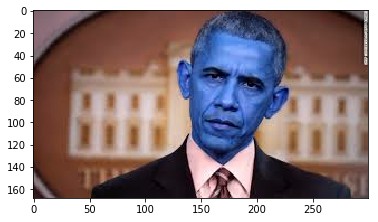

../faces/test/Morgan Freeman/100.jpg


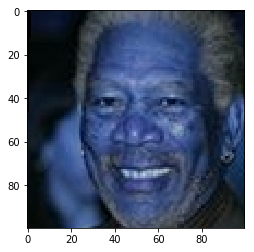

In [147]:
prediction_class = show_predictions(test_image_tensor, custom_vgg16_model)
print(prediction_class)

compare_prediction(test_image, prediction_class)


#### Visualizing the layers

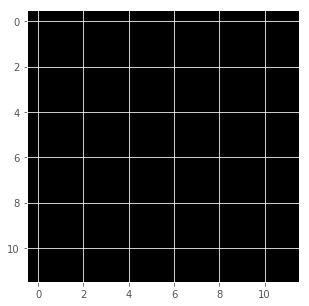

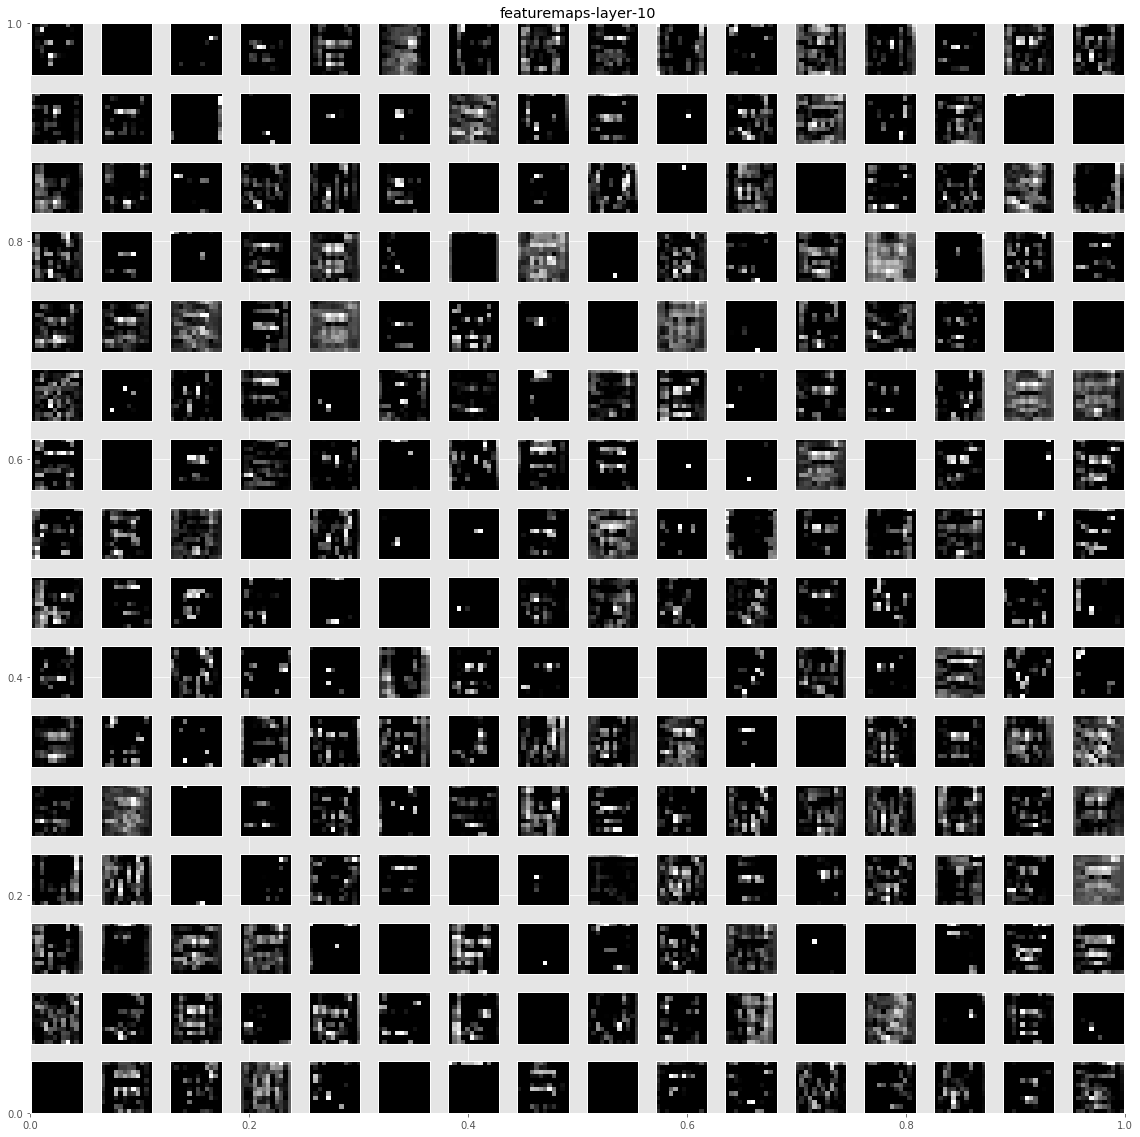

In [42]:
visualize_layer(custom_vgg16_model, test_image_tensor, layer_num=10)

### ResNet50

ResNet is a short name for Residual Network. As the name of the network indicates, the new terminology that this network introduces is residual learning.

What is Residual Learning?

In general, in a deep convolutional neural network, several layers are stacked and are trained to the task at hand. The network learns several low/mid/high level features at the end of its layers. In residual learning, instead of trying to learn some features, we try to learn some residual. Residual can be simply understood as subtraction of feature learned from input of that layer. ResNet does this using shortcut connections (directly connecting input of nth layer to some (n+x)th layer. It has proved that training this form of networks is easier than training simple deep convolutional neural networks and also the problem of degrading accuracy is resolved.

This is the fundamental concept of ResNet.

ResNet50 is a 50 layer Residual Network. There are other variants like ResNet101 and ResNet152 also.

Definition extracted from this Quora anwer: https://www.quora.com/What-is-the-deep-neural-network-known-as-%E2%80%9CResNet-50%E2%80%9D

The paper original can be found here: https://arxiv.org/abs/1512.03385


#### Resize images to 224 x 224

In [119]:
from keras.applications.resnet50 import ResNet50
# pre-process the data for Keras
train_tensors_224 = paths_to_tensor(train_files,target_size=(224,224)).astype('float32')/255
valid_tensors_224 = paths_to_tensor(valid_files,target_size=(224,224)).astype('float32')/255
test_tensors_224 = paths_to_tensor(test_files,target_size=(224,224)).astype('float32')/255

train_tensors_224 = train_tensors_224.reshape(train_tensors_224.shape[0], 224, 224, 3)
valid_tensors_224 = valid_tensors_224.reshape(valid_tensors_224.shape[0], 224, 224, 3)
test_tensors_224 = test_tensors_224.reshape(test_tensors_224.shape[0], 224, 224, 3)

100%|██████████| 1388/1388 [00:01<00:00, 1360.99it/s]


In [120]:
resnet_model = ResNet50(input_tensor=Input(shape=(224,224,3)), include_top=False, weights='imagenet')
resnet_model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_3[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [121]:
from keras.layers import GlobalAveragePooling2D

last_layer = resnet_model.get_layer('avg_pool').output

custom_layer = Conv2D(filters=32, kernel_size=4, padding='same', activation='relu')(last_layer)
# custom_layer = Conv2D(filters=64, kernel_size=4, padding='same', activation='relu')(custom_layer)
# custom_layer = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(custom_layer)

custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=64, kernel_size=4, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=128, kernel_size=4, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Conv2D(filters=256, kernel_size=4, padding='same', activation='relu')(last_layer)
custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

# custom_layer = Conv2D(filters=512, kernel_size=4, padding='same', activation='relu')(last_layer)
# custom_layer = MaxPooling2D(pool_size=2, padding='same')(custom_layer)

custom_layer = Dropout(0.5)(custom_layer)

custom_layer = Flatten()(custom_layer)
custom_layer = Dense(224, activation='relu')(custom_layer)
out = Dense(83, activation='softmax')(custom_layer)

custom_restnet_model = Model(resnet_model.input, out)
custom_restnet_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_3[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

activation_46 (Activation)       (None, 7, 7, 2048)    0           add_15[0][0]                     
____________________________________________________________________________________________________
res5c_branch2a (Conv2D)          (None, 7, 7, 512)     1049088     activation_46[0][0]              
____________________________________________________________________________________________________
bn5c_branch2a (BatchNormalizatio (None, 7, 7, 512)     2048        res5c_branch2a[0][0]             
____________________________________________________________________________________________________
activation_47 (Activation)       (None, 7, 7, 512)     0           bn5c_branch2a[0][0]              
____________________________________________________________________________________________________
res5c_branch2b (Conv2D)          (None, 7, 7, 512)     2359808     activation_47[0][0]              
___________________________________________________________________________________________

In [122]:
custom_restnet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 70

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/custom_resnet50_weights.custom.model.hdf5', 
                               verbose=1, save_best_only=True)

tensor = TensorBoard(log_dir="logs/resnet_{}".format(time()),write_images=True,write_grads=True)

trainning_result = custom_restnet_model.fit(train_tensors_224, train_targets, 
          validation_data=(valid_tensors_224, valid_targets),
          epochs=epochs, batch_size=10, callbacks=[checkpointer,tensor], verbose=1)

#### Load ResNet50 weights trained on a GPU machine

In [123]:
custom_restnet_model.load_weights('saved_models/custom_resnet50_weights.custom.model.hdf5')


In [124]:
scores = custom_restnet_model.evaluate(test_tensors_224, test_targets, batch_size=10)

print(scores)

1388/1388 [==============================] - 571s   
[2.3394022601997473, 0.42291066972726704]


#### Testing the model

In [141]:
test_image_tensor = path_to_tensor('../obama.jpeg', target_size=(224,224))
test_image = cv2.imread('../obama.jpeg')
print (test_image_tensor.shape)

(1, 224, 224, 3)


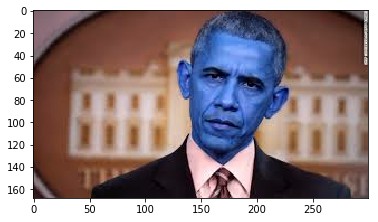

../faces/test/Daniel Radcliffe/666.jpg


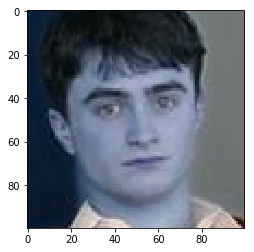

In [142]:
prediction_class = show_predictions(test_image_tensor, custom_restnet_model)
compare_prediction(test_image, prediction_class)

#### Visualizing the layers

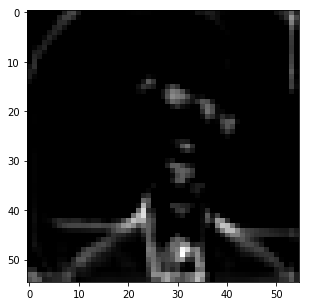

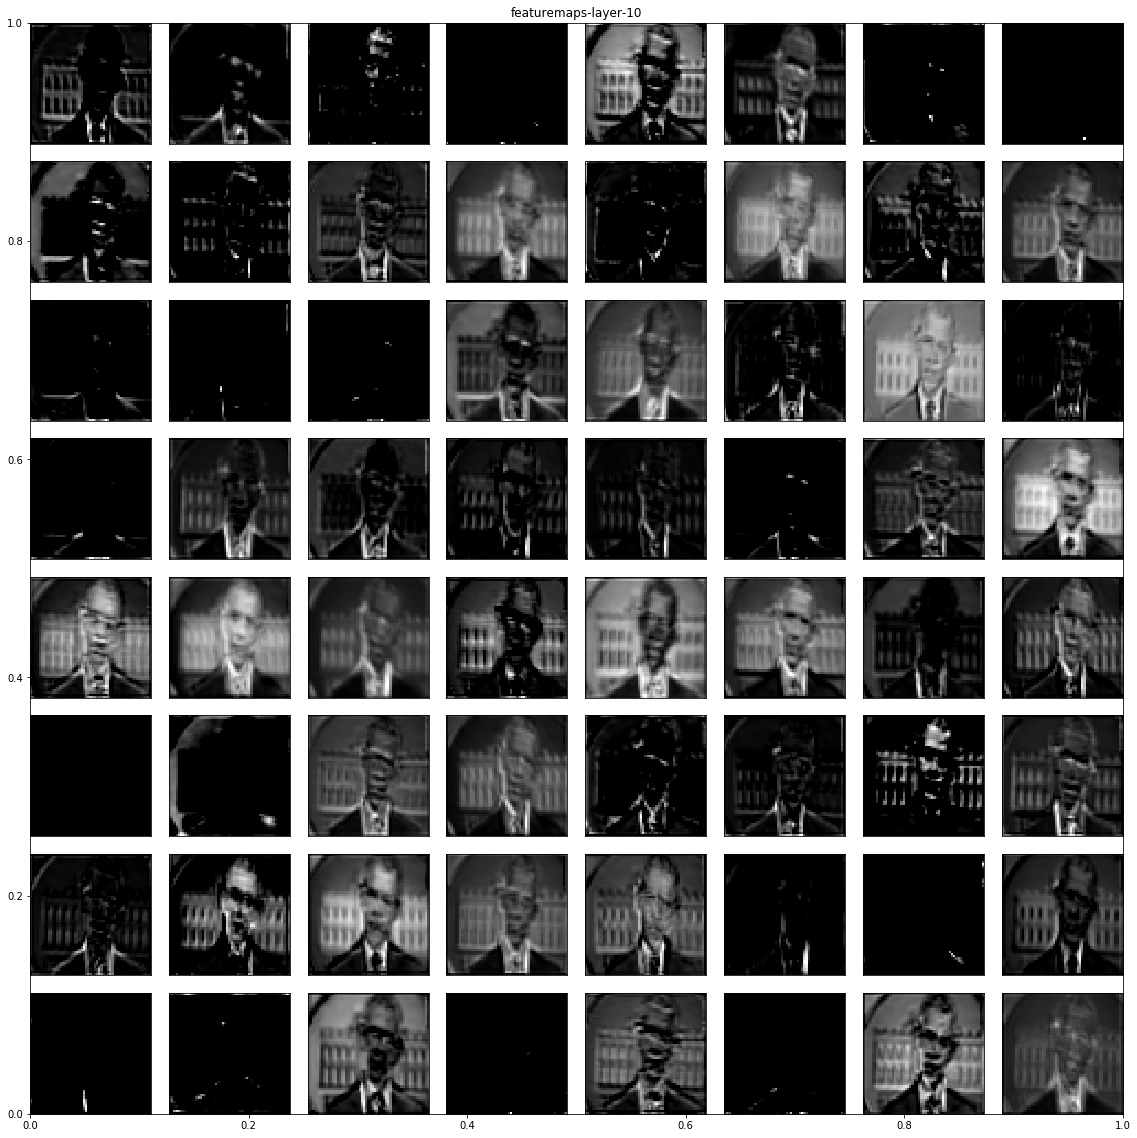

In [145]:
visualize_layer(custom_restnet_model, test_image_tensor, layer_num=10)

### Custom CNN Model

In this custom model, I use a sequence of 3 layers of convolutional and pooling. To reducing overfitting, I'm using a dropout. After that a fully connected layer and dropout again.
With this configuration, I get the better results.

In [34]:
import time
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, adam
from keras.callbacks import TensorBoard

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(100,100,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.5))
 
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(83, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 256)       295168    
__________

In [35]:
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [36]:
from keras.callbacks import ModelCheckpoint  
from time import time
### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 90
### Do NOT modify the code below this line.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.custom.model_{}.hdf5'.format("pc90-batch20-ada"), 
                               verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir="logs/custom_{}".format(time()))
#tensorboard = TensorBoard(log_dir="logs/vgg16_{}".format(time()),write_images=True,write_grads=True, histogram_freq=5.0)

trainning_result = model.fit(train_tensors, train_targets, 
           validation_data=(valid_tensors, valid_targets),
           epochs=epochs, batch_size=20, callbacks=[checkpointer,tensorboard], verbose=1)

Train on 11071 samples, validate on 1364 samples
Epoch 1/90


 8500/11071 [======================>.......] - ETA: 49s - loss: 4.4182 - acc: 0.05 - ETA: 28s - loss: 4.4214 - acc: 0.01 - ETA: 23s - loss: 4.4328 - acc: 0.01 - ETA: 21s - loss: 4.4280 - acc: 0.00 - ETA: 20s - loss: 4.4286 - acc: 0.00 - ETA: 20s - loss: 4.4278 - acc: 0.00 - ETA: 19s - loss: 4.4231 - acc: 0.00 - ETA: 19s - loss: 4.4198 - acc: 0.00 - ETA: 18s - loss: 4.4129 - acc: 0.00 - ETA: 18s - loss: 4.4188 - acc: 0.00 - ETA: 18s - loss: 4.4173 - acc: 0.00 - ETA: 17s - loss: 4.4186 - acc: 0.00 - ETA: 17s - loss: 4.4169 - acc: 0.01 - ETA: 17s - loss: 4.4125 - acc: 0.01 - ETA: 17s - loss: 4.4096 - acc: 0.01 - ETA: 16s - loss: 4.4076 - acc: 0.01 - ETA: 16s - loss: 4.4088 - acc: 0.01 - ETA: 16s - loss: 4.4113 - acc: 0.01 - ETA: 16s - loss: 4.4109 - acc: 0.01 - ETA: 16s - loss: 4.4101 - acc: 0.01 - ETA: 16s - loss: 4.4106 - acc: 0.01 - ETA: 16s - loss: 4.4096 - acc: 0.01 - ETA: 16s - loss: 4.4103 - acc: 0.01 - ETA: 16s - loss: 4.4098 - acc: 0.01 - ETA: 16s - loss: 4.4098 - acc: 0.01 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 4.3940 - acc: 0.0235 - val_loss: 4.3359 - val_acc: 0.0323
Epoch 2/90


 8560/11071 [======================>.......] - ETA: 15s - loss: 4.2846 - acc: 0.05 - ETA: 16s - loss: 4.2877 - acc: 0.01 - ETA: 16s - loss: 4.2743 - acc: 0.02 - ETA: 16s - loss: 4.3144 - acc: 0.03 - ETA: 16s - loss: 4.3053 - acc: 0.02 - ETA: 16s - loss: 4.3174 - acc: 0.02 - ETA: 16s - loss: 4.3333 - acc: 0.01 - ETA: 16s - loss: 4.3397 - acc: 0.01 - ETA: 16s - loss: 4.3479 - acc: 0.01 - ETA: 16s - loss: 4.3503 - acc: 0.02 - ETA: 16s - loss: 4.3523 - acc: 0.01 - ETA: 16s - loss: 4.3516 - acc: 0.02 - ETA: 16s - loss: 4.3564 - acc: 0.02 - ETA: 16s - loss: 4.3466 - acc: 0.02 - ETA: 16s - loss: 4.3455 - acc: 0.02 - ETA: 16s - loss: 4.3487 - acc: 0.02 - ETA: 16s - loss: 4.3501 - acc: 0.02 - ETA: 16s - loss: 4.3463 - acc: 0.03 - ETA: 16s - loss: 4.3495 - acc: 0.02 - ETA: 16s - loss: 4.3489 - acc: 0.02 - ETA: 16s - loss: 4.3472 - acc: 0.03 - ETA: 16s - loss: 4.3512 - acc: 0.03 - ETA: 16s - loss: 4.3528 - acc: 0.03 - ETA: 15s - loss: 4.3510 - acc: 0.02 - ETA: 15s - loss: 4.3497 - acc: 0.03 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 4.2901 - acc: 0.0402 - val_loss: 4.1332 - val_acc: 0.0718
Epoch 3/90


 8540/11071 [======================>.......] - ETA: 18s - loss: 4.1132 - acc: 0.05 - ETA: 18s - loss: 4.1705 - acc: 0.06 - ETA: 18s - loss: 4.2627 - acc: 0.06 - ETA: 18s - loss: 4.2521 - acc: 0.04 - ETA: 18s - loss: 4.2500 - acc: 0.03 - ETA: 17s - loss: 4.2288 - acc: 0.05 - ETA: 17s - loss: 4.2035 - acc: 0.06 - ETA: 17s - loss: 4.1833 - acc: 0.06 - ETA: 17s - loss: 4.1923 - acc: 0.06 - ETA: 17s - loss: 4.1698 - acc: 0.06 - ETA: 16s - loss: 4.1775 - acc: 0.06 - ETA: 16s - loss: 4.1584 - acc: 0.06 - ETA: 16s - loss: 4.1584 - acc: 0.06 - ETA: 16s - loss: 4.1598 - acc: 0.06 - ETA: 16s - loss: 4.1654 - acc: 0.06 - ETA: 16s - loss: 4.1554 - acc: 0.06 - ETA: 16s - loss: 4.1594 - acc: 0.06 - ETA: 16s - loss: 4.1585 - acc: 0.06 - ETA: 16s - loss: 4.1645 - acc: 0.05 - ETA: 15s - loss: 4.1758 - acc: 0.05 - ETA: 15s - loss: 4.1742 - acc: 0.05 - ETA: 15s - loss: 4.1743 - acc: 0.05 - ETA: 15s - loss: 4.1750 - acc: 0.05 - ETA: 15s - loss: 4.1723 - acc: 0.05 - ETA: 15s - loss: 4.1717 - acc: 0.05 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 4.1057 - acc: 0.0627 - val_loss: 3.8868 - val_acc: 0.1070
Epoch 4/90


 8460/11071 [=====================>........] - ETA: 20s - loss: 3.6453 - acc: 0.05 - ETA: 17s - loss: 3.7692 - acc: 0.08 - ETA: 16s - loss: 3.9314 - acc: 0.05 - ETA: 17s - loss: 4.0171 - acc: 0.05 - ETA: 16s - loss: 3.9804 - acc: 0.06 - ETA: 16s - loss: 3.9482 - acc: 0.05 - ETA: 16s - loss: 3.9882 - acc: 0.05 - ETA: 16s - loss: 4.0168 - acc: 0.05 - ETA: 16s - loss: 4.0136 - acc: 0.05 - ETA: 16s - loss: 3.9950 - acc: 0.06 - ETA: 16s - loss: 4.0006 - acc: 0.06 - ETA: 16s - loss: 4.0086 - acc: 0.06 - ETA: 16s - loss: 4.0049 - acc: 0.07 - ETA: 16s - loss: 4.0023 - acc: 0.06 - ETA: 16s - loss: 3.9966 - acc: 0.06 - ETA: 16s - loss: 3.9955 - acc: 0.06 - ETA: 16s - loss: 3.9949 - acc: 0.06 - ETA: 15s - loss: 3.9888 - acc: 0.06 - ETA: 15s - loss: 3.9860 - acc: 0.06 - ETA: 15s - loss: 3.9788 - acc: 0.06 - ETA: 16s - loss: 3.9751 - acc: 0.06 - ETA: 15s - loss: 3.9778 - acc: 0.06 - ETA: 15s - loss: 3.9738 - acc: 0.06 - ETA: 15s - loss: 3.9740 - acc: 0.07 - ETA: 15s - loss: 3.9688 - acc: 0.07 - ETA

11071/11071 [==============================] - 25s 2ms/step - loss: 3.8612 - acc: 0.0902 - val_loss: 3.5897 - val_acc: 0.1576
Epoch 5/90


 8420/11071 [=====================>........] - ETA: 15s - loss: 3.7603 - acc: 0.05 - ETA: 15s - loss: 3.7770 - acc: 0.08 - ETA: 15s - loss: 3.6902 - acc: 0.13 - ETA: 15s - loss: 3.5792 - acc: 0.11 - ETA: 15s - loss: 3.6453 - acc: 0.11 - ETA: 16s - loss: 3.6536 - acc: 0.11 - ETA: 15s - loss: 3.6435 - acc: 0.11 - ETA: 16s - loss: 3.6518 - acc: 0.12 - ETA: 15s - loss: 3.6651 - acc: 0.12 - ETA: 16s - loss: 3.6766 - acc: 0.12 - ETA: 19s - loss: 3.6649 - acc: 0.12 - ETA: 20s - loss: 3.6538 - acc: 0.13 - ETA: 22s - loss: 3.6589 - acc: 0.12 - ETA: 22s - loss: 3.6523 - acc: 0.13 - ETA: 22s - loss: 3.6762 - acc: 0.12 - ETA: 21s - loss: 3.6700 - acc: 0.12 - ETA: 21s - loss: 3.6617 - acc: 0.12 - ETA: 21s - loss: 3.6796 - acc: 0.11 - ETA: 20s - loss: 3.6823 - acc: 0.11 - ETA: 20s - loss: 3.6857 - acc: 0.11 - ETA: 20s - loss: 3.6951 - acc: 0.12 - ETA: 19s - loss: 3.6970 - acc: 0.12 - ETA: 19s - loss: 3.7047 - acc: 0.11 - ETA: 19s - loss: 3.6957 - acc: 0.11 - ETA: 18s - loss: 3.6974 - acc: 0.12 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 3.5977 - acc: 0.1303 - val_loss: 3.3519 - val_acc: 0.2405
Epoch 6/90


 8560/11071 [======================>.......] - ETA: 16s - loss: 3.4619 - acc: 0.20 - ETA: 16s - loss: 3.3595 - acc: 0.16 - ETA: 17s - loss: 3.4698 - acc: 0.16 - ETA: 17s - loss: 3.4991 - acc: 0.13 - ETA: 17s - loss: 3.4731 - acc: 0.13 - ETA: 17s - loss: 3.4762 - acc: 0.13 - ETA: 17s - loss: 3.4770 - acc: 0.13 - ETA: 17s - loss: 3.4835 - acc: 0.13 - ETA: 17s - loss: 3.4613 - acc: 0.14 - ETA: 16s - loss: 3.4538 - acc: 0.15 - ETA: 16s - loss: 3.4252 - acc: 0.15 - ETA: 16s - loss: 3.4067 - acc: 0.15 - ETA: 16s - loss: 3.4070 - acc: 0.16 - ETA: 16s - loss: 3.4225 - acc: 0.15 - ETA: 16s - loss: 3.4276 - acc: 0.15 - ETA: 16s - loss: 3.4201 - acc: 0.15 - ETA: 16s - loss: 3.4294 - acc: 0.14 - ETA: 16s - loss: 3.4294 - acc: 0.15 - ETA: 16s - loss: 3.4434 - acc: 0.15 - ETA: 16s - loss: 3.4400 - acc: 0.14 - ETA: 16s - loss: 3.4313 - acc: 0.15 - ETA: 16s - loss: 3.4384 - acc: 0.15 - ETA: 16s - loss: 3.4299 - acc: 0.15 - ETA: 15s - loss: 3.4272 - acc: 0.16 - ETA: 15s - loss: 3.4393 - acc: 0.16 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 3.3346 - acc: 0.1781 - val_loss: 2.9579 - val_acc: 0.3079
Epoch 7/90


 8160/11071 [=====================>........] - ETA: 18s - loss: 3.3046 - acc: 0.25 - ETA: 17s - loss: 3.3740 - acc: 0.13 - ETA: 17s - loss: 3.3191 - acc: 0.19 - ETA: 16s - loss: 3.3321 - acc: 0.20 - ETA: 16s - loss: 3.2978 - acc: 0.20 - ETA: 16s - loss: 3.3021 - acc: 0.19 - ETA: 17s - loss: 3.2294 - acc: 0.20 - ETA: 16s - loss: 3.2046 - acc: 0.21 - ETA: 16s - loss: 3.2079 - acc: 0.21 - ETA: 16s - loss: 3.2104 - acc: 0.21 - ETA: 16s - loss: 3.2202 - acc: 0.21 - ETA: 16s - loss: 3.2160 - acc: 0.21 - ETA: 16s - loss: 3.2210 - acc: 0.21 - ETA: 16s - loss: 3.1804 - acc: 0.22 - ETA: 16s - loss: 3.1793 - acc: 0.21 - ETA: 16s - loss: 3.1894 - acc: 0.21 - ETA: 16s - loss: 3.2127 - acc: 0.20 - ETA: 16s - loss: 3.1846 - acc: 0.20 - ETA: 16s - loss: 3.1770 - acc: 0.20 - ETA: 16s - loss: 3.1631 - acc: 0.20 - ETA: 16s - loss: 3.1601 - acc: 0.20 - ETA: 16s - loss: 3.1785 - acc: 0.20 - ETA: 16s - loss: 3.1699 - acc: 0.20 - ETA: 16s - loss: 3.1768 - acc: 0.20 - ETA: 16s - loss: 3.1884 - acc: 0.19 - ETA

11071/11071 [==============================] - 20s 2ms/step - loss: 3.1062 - acc: 0.2225 - val_loss: 2.7641 - val_acc: 0.3783
Epoch 8/90


 8420/11071 [=====================>........] - ETA: 17s - loss: 2.6066 - acc: 0.30 - ETA: 16s - loss: 2.8582 - acc: 0.23 - ETA: 17s - loss: 2.8363 - acc: 0.23 - ETA: 17s - loss: 2.7671 - acc: 0.28 - ETA: 17s - loss: 2.7792 - acc: 0.30 - ETA: 17s - loss: 2.7928 - acc: 0.30 - ETA: 17s - loss: 2.7410 - acc: 0.31 - ETA: 17s - loss: 2.7442 - acc: 0.30 - ETA: 17s - loss: 2.7806 - acc: 0.29 - ETA: 17s - loss: 2.7844 - acc: 0.28 - ETA: 17s - loss: 2.7583 - acc: 0.28 - ETA: 17s - loss: 2.7905 - acc: 0.28 - ETA: 17s - loss: 2.8046 - acc: 0.27 - ETA: 17s - loss: 2.8062 - acc: 0.27 - ETA: 16s - loss: 2.8455 - acc: 0.27 - ETA: 16s - loss: 2.8600 - acc: 0.26 - ETA: 16s - loss: 2.8928 - acc: 0.26 - ETA: 16s - loss: 2.8795 - acc: 0.25 - ETA: 16s - loss: 2.8877 - acc: 0.25 - ETA: 16s - loss: 2.8935 - acc: 0.25 - ETA: 16s - loss: 2.8988 - acc: 0.25 - ETA: 16s - loss: 2.9003 - acc: 0.25 - ETA: 16s - loss: 2.9190 - acc: 0.25 - ETA: 16s - loss: 2.9143 - acc: 0.24 - ETA: 16s - loss: 2.8994 - acc: 0.25 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 2.8893 - acc: 0.2638 - val_loss: 2.3841 - val_acc: 0.4296
Epoch 9/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 3.2115 - acc: 0.15 - ETA: 16s - loss: 2.9287 - acc: 0.28 - ETA: 16s - loss: 2.8951 - acc: 0.25 - ETA: 16s - loss: 2.8572 - acc: 0.25 - ETA: 16s - loss: 2.7936 - acc: 0.27 - ETA: 16s - loss: 2.7995 - acc: 0.25 - ETA: 16s - loss: 2.8186 - acc: 0.27 - ETA: 16s - loss: 2.8101 - acc: 0.28 - ETA: 16s - loss: 2.8214 - acc: 0.27 - ETA: 16s - loss: 2.8181 - acc: 0.27 - ETA: 16s - loss: 2.8378 - acc: 0.27 - ETA: 16s - loss: 2.8280 - acc: 0.27 - ETA: 16s - loss: 2.7883 - acc: 0.27 - ETA: 16s - loss: 2.7917 - acc: 0.27 - ETA: 16s - loss: 2.7792 - acc: 0.27 - ETA: 16s - loss: 2.7882 - acc: 0.27 - ETA: 16s - loss: 2.7916 - acc: 0.27 - ETA: 16s - loss: 2.8027 - acc: 0.27 - ETA: 16s - loss: 2.8345 - acc: 0.27 - ETA: 16s - loss: 2.8152 - acc: 0.27 - ETA: 16s - loss: 2.8257 - acc: 0.27 - ETA: 16s - loss: 2.8270 - acc: 0.27 - ETA: 16s - loss: 2.8326 - acc: 0.27 - ETA: 16s - loss: 2.8215 - acc: 0.27 - ETA: 16s - loss: 2.8223 - acc: 0.27 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 2.7108 - acc: 0.3022 - val_loss: 2.1578 - val_acc: 0.4780
Epoch 10/90


 8080/11071 [====================>.........] - ETA: 16s - loss: 2.5269 - acc: 0.25 - ETA: 16s - loss: 2.6813 - acc: 0.30 - ETA: 16s - loss: 2.5760 - acc: 0.27 - ETA: 16s - loss: 2.5111 - acc: 0.27 - ETA: 17s - loss: 2.5078 - acc: 0.32 - ETA: 16s - loss: 2.5033 - acc: 0.33 - ETA: 17s - loss: 2.4891 - acc: 0.33 - ETA: 16s - loss: 2.4993 - acc: 0.32 - ETA: 16s - loss: 2.4461 - acc: 0.33 - ETA: 16s - loss: 2.5152 - acc: 0.33 - ETA: 16s - loss: 2.4931 - acc: 0.33 - ETA: 16s - loss: 2.4738 - acc: 0.33 - ETA: 16s - loss: 2.5097 - acc: 0.32 - ETA: 16s - loss: 2.5151 - acc: 0.32 - ETA: 16s - loss: 2.5013 - acc: 0.32 - ETA: 16s - loss: 2.4850 - acc: 0.33 - ETA: 16s - loss: 2.5166 - acc: 0.33 - ETA: 16s - loss: 2.5089 - acc: 0.33 - ETA: 15s - loss: 2.5250 - acc: 0.33 - ETA: 15s - loss: 2.5221 - acc: 0.32 - ETA: 15s - loss: 2.5270 - acc: 0.32 - ETA: 15s - loss: 2.5358 - acc: 0.32 - ETA: 15s - loss: 2.5316 - acc: 0.32 - ETA: 15s - loss: 2.5256 - acc: 0.32 - ETA: 15s - loss: 2.5295 - acc: 0.32 - ETA

11071/11071 [==============================] - 20s 2ms/step - loss: 2.5245 - acc: 0.3394 - val_loss: 2.0334 - val_acc: 0.5403
Epoch 11/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 2.5416 - acc: 0.35 - ETA: 17s - loss: 2.5971 - acc: 0.36 - ETA: 17s - loss: 2.3666 - acc: 0.39 - ETA: 17s - loss: 2.4428 - acc: 0.35 - ETA: 17s - loss: 2.3913 - acc: 0.36 - ETA: 17s - loss: 2.3253 - acc: 0.37 - ETA: 17s - loss: 2.2965 - acc: 0.37 - ETA: 17s - loss: 2.2679 - acc: 0.37 - ETA: 17s - loss: 2.2238 - acc: 0.39 - ETA: 16s - loss: 2.2930 - acc: 0.37 - ETA: 16s - loss: 2.2488 - acc: 0.38 - ETA: 16s - loss: 2.2491 - acc: 0.38 - ETA: 16s - loss: 2.2821 - acc: 0.37 - ETA: 16s - loss: 2.2793 - acc: 0.38 - ETA: 16s - loss: 2.2703 - acc: 0.38 - ETA: 16s - loss: 2.2808 - acc: 0.38 - ETA: 16s - loss: 2.3310 - acc: 0.37 - ETA: 16s - loss: 2.3331 - acc: 0.37 - ETA: 16s - loss: 2.3573 - acc: 0.36 - ETA: 16s - loss: 2.3723 - acc: 0.36 - ETA: 16s - loss: 2.3655 - acc: 0.36 - ETA: 16s - loss: 2.3677 - acc: 0.36 - ETA: 16s - loss: 2.3463 - acc: 0.37 - ETA: 16s - loss: 2.3572 - acc: 0.37 - ETA: 16s - loss: 2.3643 - acc: 0.37 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 2.3504 - acc: 0.3796 - val_loss: 1.8315 - val_acc: 0.5557
Epoch 12/90


 8400/11071 [=====================>........] - ETA: 16s - loss: 2.2072 - acc: 0.40 - ETA: 16s - loss: 2.3282 - acc: 0.38 - ETA: 17s - loss: 2.2395 - acc: 0.41 - ETA: 16s - loss: 2.2880 - acc: 0.38 - ETA: 16s - loss: 2.1897 - acc: 0.42 - ETA: 16s - loss: 2.1361 - acc: 0.42 - ETA: 16s - loss: 2.1472 - acc: 0.42 - ETA: 16s - loss: 2.2393 - acc: 0.39 - ETA: 17s - loss: 2.2259 - acc: 0.38 - ETA: 16s - loss: 2.1547 - acc: 0.40 - ETA: 16s - loss: 2.1634 - acc: 0.40 - ETA: 16s - loss: 2.1912 - acc: 0.39 - ETA: 16s - loss: 2.2483 - acc: 0.39 - ETA: 16s - loss: 2.2533 - acc: 0.39 - ETA: 16s - loss: 2.2696 - acc: 0.38 - ETA: 16s - loss: 2.2647 - acc: 0.39 - ETA: 16s - loss: 2.2721 - acc: 0.39 - ETA: 16s - loss: 2.2639 - acc: 0.39 - ETA: 16s - loss: 2.2548 - acc: 0.39 - ETA: 16s - loss: 2.2529 - acc: 0.39 - ETA: 16s - loss: 2.2566 - acc: 0.39 - ETA: 16s - loss: 2.2405 - acc: 0.40 - ETA: 16s - loss: 2.2303 - acc: 0.40 - ETA: 16s - loss: 2.2286 - acc: 0.40 - ETA: 16s - loss: 2.2403 - acc: 0.40 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 2.2160 - acc: 0.4115 - val_loss: 1.7075 - val_acc: 0.5990
Epoch 13/90


 8580/11071 [======================>.......] - ETA: 19s - loss: 1.7986 - acc: 0.40 - ETA: 18s - loss: 2.1451 - acc: 0.33 - ETA: 17s - loss: 2.1154 - acc: 0.33 - ETA: 18s - loss: 2.2179 - acc: 0.32 - ETA: 18s - loss: 2.1779 - acc: 0.37 - ETA: 17s - loss: 2.1621 - acc: 0.38 - ETA: 17s - loss: 2.1796 - acc: 0.38 - ETA: 17s - loss: 2.2043 - acc: 0.37 - ETA: 17s - loss: 2.1852 - acc: 0.38 - ETA: 17s - loss: 2.1708 - acc: 0.38 - ETA: 17s - loss: 2.1345 - acc: 0.39 - ETA: 17s - loss: 2.1633 - acc: 0.39 - ETA: 17s - loss: 2.1534 - acc: 0.40 - ETA: 17s - loss: 2.1682 - acc: 0.40 - ETA: 17s - loss: 2.1295 - acc: 0.41 - ETA: 17s - loss: 2.1286 - acc: 0.42 - ETA: 16s - loss: 2.1312 - acc: 0.41 - ETA: 16s - loss: 2.1295 - acc: 0.42 - ETA: 16s - loss: 2.1355 - acc: 0.42 - ETA: 16s - loss: 2.1259 - acc: 0.42 - ETA: 16s - loss: 2.1178 - acc: 0.43 - ETA: 16s - loss: 2.1128 - acc: 0.43 - ETA: 16s - loss: 2.0954 - acc: 0.43 - ETA: 16s - loss: 2.0997 - acc: 0.43 - ETA: 16s - loss: 2.0892 - acc: 0.43 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 2.0939 - acc: 0.4405 - val_loss: 1.6279 - val_acc: 0.6151
Epoch 14/90


 8580/11071 [======================>.......] - ETA: 15s - loss: 1.8229 - acc: 0.50 - ETA: 16s - loss: 2.2669 - acc: 0.45 - ETA: 17s - loss: 2.3003 - acc: 0.41 - ETA: 17s - loss: 2.1175 - acc: 0.43 - ETA: 17s - loss: 1.9616 - acc: 0.47 - ETA: 17s - loss: 2.0257 - acc: 0.46 - ETA: 17s - loss: 1.9673 - acc: 0.47 - ETA: 17s - loss: 2.0226 - acc: 0.45 - ETA: 17s - loss: 1.9955 - acc: 0.45 - ETA: 17s - loss: 1.9531 - acc: 0.47 - ETA: 17s - loss: 1.9632 - acc: 0.46 - ETA: 17s - loss: 1.9572 - acc: 0.46 - ETA: 16s - loss: 1.9903 - acc: 0.44 - ETA: 17s - loss: 2.0166 - acc: 0.45 - ETA: 16s - loss: 2.0255 - acc: 0.44 - ETA: 16s - loss: 2.0200 - acc: 0.45 - ETA: 16s - loss: 1.9957 - acc: 0.45 - ETA: 16s - loss: 2.0132 - acc: 0.45 - ETA: 16s - loss: 2.0167 - acc: 0.45 - ETA: 16s - loss: 2.0191 - acc: 0.45 - ETA: 16s - loss: 2.0312 - acc: 0.45 - ETA: 16s - loss: 2.0383 - acc: 0.45 - ETA: 16s - loss: 2.0265 - acc: 0.45 - ETA: 16s - loss: 2.0396 - acc: 0.44 - ETA: 16s - loss: 2.0237 - acc: 0.45 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 2.0008 - acc: 0.4618 - val_loss: 1.5354 - val_acc: 0.6540
Epoch 15/90


 8560/11071 [======================>.......] - ETA: 16s - loss: 1.8039 - acc: 0.50 - ETA: 16s - loss: 1.8873 - acc: 0.45 - ETA: 17s - loss: 1.8380 - acc: 0.48 - ETA: 17s - loss: 1.9946 - acc: 0.42 - ETA: 17s - loss: 1.9212 - acc: 0.45 - ETA: 17s - loss: 1.9851 - acc: 0.44 - ETA: 17s - loss: 1.9796 - acc: 0.42 - ETA: 17s - loss: 1.9455 - acc: 0.43 - ETA: 17s - loss: 1.8707 - acc: 0.46 - ETA: 17s - loss: 1.8542 - acc: 0.46 - ETA: 17s - loss: 1.8418 - acc: 0.48 - ETA: 17s - loss: 1.8359 - acc: 0.49 - ETA: 17s - loss: 1.8249 - acc: 0.49 - ETA: 17s - loss: 1.8110 - acc: 0.50 - ETA: 17s - loss: 1.7927 - acc: 0.51 - ETA: 16s - loss: 1.7952 - acc: 0.50 - ETA: 16s - loss: 1.8015 - acc: 0.50 - ETA: 16s - loss: 1.8204 - acc: 0.50 - ETA: 16s - loss: 1.8453 - acc: 0.50 - ETA: 16s - loss: 1.8387 - acc: 0.50 - ETA: 16s - loss: 1.8441 - acc: 0.49 - ETA: 16s - loss: 1.8394 - acc: 0.50 - ETA: 16s - loss: 1.8277 - acc: 0.50 - ETA: 16s - loss: 1.8014 - acc: 0.51 - ETA: 16s - loss: 1.7886 - acc: 0.51 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.8730 - acc: 0.4927 - val_loss: 1.4379 - val_acc: 0.6657
Epoch 16/90


 8560/11071 [======================>.......] - ETA: 18s - loss: 2.0766 - acc: 0.40 - ETA: 17s - loss: 1.8133 - acc: 0.46 - ETA: 17s - loss: 1.7412 - acc: 0.51 - ETA: 17s - loss: 1.8065 - acc: 0.50 - ETA: 17s - loss: 1.9409 - acc: 0.47 - ETA: 17s - loss: 1.9959 - acc: 0.46 - ETA: 17s - loss: 1.9812 - acc: 0.46 - ETA: 17s - loss: 1.9799 - acc: 0.47 - ETA: 17s - loss: 1.9423 - acc: 0.48 - ETA: 17s - loss: 1.9247 - acc: 0.48 - ETA: 17s - loss: 1.9346 - acc: 0.48 - ETA: 17s - loss: 1.9231 - acc: 0.47 - ETA: 17s - loss: 1.9267 - acc: 0.47 - ETA: 16s - loss: 1.9168 - acc: 0.48 - ETA: 16s - loss: 1.9007 - acc: 0.48 - ETA: 16s - loss: 1.8832 - acc: 0.49 - ETA: 16s - loss: 1.8503 - acc: 0.49 - ETA: 16s - loss: 1.8434 - acc: 0.49 - ETA: 16s - loss: 1.8381 - acc: 0.49 - ETA: 16s - loss: 1.8843 - acc: 0.49 - ETA: 16s - loss: 1.8847 - acc: 0.49 - ETA: 16s - loss: 1.9087 - acc: 0.48 - ETA: 16s - loss: 1.9024 - acc: 0.48 - ETA: 16s - loss: 1.8975 - acc: 0.48 - ETA: 16s - loss: 1.8923 - acc: 0.48 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 1.7997 - acc: 0.5078 - val_loss: 1.3334 - val_acc: 0.6730
Epoch 17/90


 8560/11071 [======================>.......] - ETA: 19s - loss: 1.6983 - acc: 0.40 - ETA: 18s - loss: 1.8904 - acc: 0.48 - ETA: 18s - loss: 1.7437 - acc: 0.54 - ETA: 18s - loss: 1.7499 - acc: 0.54 - ETA: 18s - loss: 1.7409 - acc: 0.54 - ETA: 18s - loss: 1.7543 - acc: 0.53 - ETA: 18s - loss: 1.7209 - acc: 0.53 - ETA: 18s - loss: 1.7542 - acc: 0.53 - ETA: 18s - loss: 1.7397 - acc: 0.53 - ETA: 18s - loss: 1.7194 - acc: 0.53 - ETA: 18s - loss: 1.7240 - acc: 0.53 - ETA: 17s - loss: 1.7015 - acc: 0.53 - ETA: 17s - loss: 1.6960 - acc: 0.54 - ETA: 17s - loss: 1.6839 - acc: 0.53 - ETA: 17s - loss: 1.6942 - acc: 0.53 - ETA: 17s - loss: 1.6859 - acc: 0.53 - ETA: 17s - loss: 1.6766 - acc: 0.54 - ETA: 17s - loss: 1.6587 - acc: 0.55 - ETA: 17s - loss: 1.6391 - acc: 0.55 - ETA: 17s - loss: 1.6732 - acc: 0.54 - ETA: 17s - loss: 1.6544 - acc: 0.55 - ETA: 17s - loss: 1.6674 - acc: 0.55 - ETA: 17s - loss: 1.6865 - acc: 0.55 - ETA: 17s - loss: 1.6928 - acc: 0.55 - ETA: 17s - loss: 1.6940 - acc: 0.55 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.7071 - acc: 0.5402 - val_loss: 1.2834 - val_acc: 0.6833
Epoch 18/90


 8560/11071 [======================>.......] - ETA: 16s - loss: 2.2833 - acc: 0.60 - ETA: 17s - loss: 1.7567 - acc: 0.61 - ETA: 17s - loss: 1.6872 - acc: 0.55 - ETA: 17s - loss: 1.5556 - acc: 0.56 - ETA: 17s - loss: 1.6010 - acc: 0.56 - ETA: 17s - loss: 1.7544 - acc: 0.55 - ETA: 17s - loss: 1.6886 - acc: 0.55 - ETA: 17s - loss: 1.6972 - acc: 0.54 - ETA: 17s - loss: 1.7141 - acc: 0.54 - ETA: 16s - loss: 1.7645 - acc: 0.52 - ETA: 16s - loss: 1.7696 - acc: 0.53 - ETA: 16s - loss: 1.7454 - acc: 0.53 - ETA: 16s - loss: 1.7298 - acc: 0.53 - ETA: 16s - loss: 1.7267 - acc: 0.53 - ETA: 16s - loss: 1.7333 - acc: 0.52 - ETA: 16s - loss: 1.7050 - acc: 0.53 - ETA: 16s - loss: 1.6750 - acc: 0.53 - ETA: 16s - loss: 1.6683 - acc: 0.54 - ETA: 16s - loss: 1.6338 - acc: 0.55 - ETA: 16s - loss: 1.6195 - acc: 0.55 - ETA: 16s - loss: 1.6148 - acc: 0.55 - ETA: 16s - loss: 1.5786 - acc: 0.56 - ETA: 16s - loss: 1.5747 - acc: 0.57 - ETA: 16s - loss: 1.5814 - acc: 0.56 - ETA: 16s - loss: 1.5766 - acc: 0.56 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.6333 - acc: 0.5521 - val_loss: 1.2003 - val_acc: 0.7067
Epoch 19/90


 8540/11071 [======================>.......] - ETA: 18s - loss: 1.1138 - acc: 0.60 - ETA: 17s - loss: 1.5384 - acc: 0.53 - ETA: 17s - loss: 1.4813 - acc: 0.53 - ETA: 17s - loss: 1.4448 - acc: 0.55 - ETA: 17s - loss: 1.4299 - acc: 0.56 - ETA: 17s - loss: 1.4652 - acc: 0.55 - ETA: 17s - loss: 1.5258 - acc: 0.55 - ETA: 16s - loss: 1.5502 - acc: 0.55 - ETA: 16s - loss: 1.5067 - acc: 0.56 - ETA: 16s - loss: 1.5087 - acc: 0.55 - ETA: 16s - loss: 1.5576 - acc: 0.56 - ETA: 16s - loss: 1.5497 - acc: 0.57 - ETA: 16s - loss: 1.5495 - acc: 0.57 - ETA: 16s - loss: 1.5703 - acc: 0.57 - ETA: 16s - loss: 1.5673 - acc: 0.57 - ETA: 16s - loss: 1.5556 - acc: 0.58 - ETA: 16s - loss: 1.5572 - acc: 0.58 - ETA: 16s - loss: 1.5800 - acc: 0.57 - ETA: 16s - loss: 1.5879 - acc: 0.57 - ETA: 16s - loss: 1.5754 - acc: 0.57 - ETA: 16s - loss: 1.5767 - acc: 0.57 - ETA: 16s - loss: 1.5723 - acc: 0.57 - ETA: 15s - loss: 1.5892 - acc: 0.57 - ETA: 15s - loss: 1.5909 - acc: 0.57 - ETA: 15s - loss: 1.6134 - acc: 0.56 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.5701 - acc: 0.5619 - val_loss: 1.1972 - val_acc: 0.7207
Epoch 20/90


 8560/11071 [======================>.......] - ETA: 17s - loss: 1.3859 - acc: 0.70 - ETA: 18s - loss: 1.5016 - acc: 0.61 - ETA: 17s - loss: 1.6791 - acc: 0.54 - ETA: 17s - loss: 1.5200 - acc: 0.57 - ETA: 17s - loss: 1.5233 - acc: 0.58 - ETA: 17s - loss: 1.6024 - acc: 0.56 - ETA: 17s - loss: 1.5345 - acc: 0.58 - ETA: 17s - loss: 1.4840 - acc: 0.59 - ETA: 17s - loss: 1.4866 - acc: 0.59 - ETA: 17s - loss: 1.4636 - acc: 0.58 - ETA: 17s - loss: 1.4785 - acc: 0.58 - ETA: 17s - loss: 1.5084 - acc: 0.57 - ETA: 17s - loss: 1.5022 - acc: 0.58 - ETA: 17s - loss: 1.4884 - acc: 0.59 - ETA: 17s - loss: 1.4762 - acc: 0.59 - ETA: 17s - loss: 1.4707 - acc: 0.59 - ETA: 16s - loss: 1.4868 - acc: 0.58 - ETA: 16s - loss: 1.4721 - acc: 0.58 - ETA: 16s - loss: 1.4639 - acc: 0.58 - ETA: 16s - loss: 1.4660 - acc: 0.58 - ETA: 16s - loss: 1.4658 - acc: 0.58 - ETA: 16s - loss: 1.4858 - acc: 0.58 - ETA: 16s - loss: 1.4823 - acc: 0.57 - ETA: 16s - loss: 1.4751 - acc: 0.57 - ETA: 16s - loss: 1.4619 - acc: 0.58 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.5088 - acc: 0.5783 - val_loss: 1.2403 - val_acc: 0.7302
Epoch 21/90


 8580/11071 [======================>.......] - ETA: 17s - loss: 1.6024 - acc: 0.45 - ETA: 17s - loss: 1.6349 - acc: 0.46 - ETA: 17s - loss: 1.5160 - acc: 0.55 - ETA: 17s - loss: 1.4811 - acc: 0.57 - ETA: 17s - loss: 1.5224 - acc: 0.57 - ETA: 17s - loss: 1.5380 - acc: 0.57 - ETA: 17s - loss: 1.4947 - acc: 0.56 - ETA: 17s - loss: 1.5190 - acc: 0.56 - ETA: 17s - loss: 1.5340 - acc: 0.56 - ETA: 17s - loss: 1.4939 - acc: 0.57 - ETA: 17s - loss: 1.4424 - acc: 0.59 - ETA: 17s - loss: 1.4300 - acc: 0.59 - ETA: 16s - loss: 1.4272 - acc: 0.59 - ETA: 16s - loss: 1.4282 - acc: 0.59 - ETA: 16s - loss: 1.4158 - acc: 0.59 - ETA: 16s - loss: 1.4270 - acc: 0.59 - ETA: 16s - loss: 1.4227 - acc: 0.59 - ETA: 16s - loss: 1.4266 - acc: 0.59 - ETA: 16s - loss: 1.4623 - acc: 0.59 - ETA: 16s - loss: 1.4888 - acc: 0.58 - ETA: 16s - loss: 1.4690 - acc: 0.59 - ETA: 16s - loss: 1.4845 - acc: 0.58 - ETA: 16s - loss: 1.4816 - acc: 0.58 - ETA: 16s - loss: 1.4815 - acc: 0.58 - ETA: 16s - loss: 1.4623 - acc: 0.58 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.4270 - acc: 0.6041 - val_loss: 1.1582 - val_acc: 0.7199
Epoch 22/90


 8400/11071 [=====================>........] - ETA: 17s - loss: 1.9878 - acc: 0.40 - ETA: 16s - loss: 1.4585 - acc: 0.65 - ETA: 17s - loss: 1.3958 - acc: 0.64 - ETA: 17s - loss: 1.4457 - acc: 0.62 - ETA: 17s - loss: 1.3553 - acc: 0.65 - ETA: 17s - loss: 1.3627 - acc: 0.65 - ETA: 17s - loss: 1.3275 - acc: 0.65 - ETA: 17s - loss: 1.2795 - acc: 0.66 - ETA: 17s - loss: 1.2931 - acc: 0.65 - ETA: 17s - loss: 1.2631 - acc: 0.65 - ETA: 17s - loss: 1.3121 - acc: 0.63 - ETA: 17s - loss: 1.3410 - acc: 0.62 - ETA: 16s - loss: 1.3429 - acc: 0.62 - ETA: 16s - loss: 1.3404 - acc: 0.62 - ETA: 16s - loss: 1.3384 - acc: 0.62 - ETA: 16s - loss: 1.3160 - acc: 0.63 - ETA: 16s - loss: 1.3278 - acc: 0.63 - ETA: 16s - loss: 1.3090 - acc: 0.63 - ETA: 16s - loss: 1.3448 - acc: 0.62 - ETA: 16s - loss: 1.3472 - acc: 0.62 - ETA: 16s - loss: 1.3560 - acc: 0.61 - ETA: 16s - loss: 1.3493 - acc: 0.61 - ETA: 16s - loss: 1.3389 - acc: 0.61 - ETA: 16s - loss: 1.3374 - acc: 0.62 - ETA: 16s - loss: 1.3485 - acc: 0.61 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.3984 - acc: 0.6093 - val_loss: 1.0837 - val_acc: 0.7302
Epoch 23/90


 8540/11071 [======================>.......] - ETA: 17s - loss: 1.7735 - acc: 0.65 - ETA: 17s - loss: 1.3727 - acc: 0.60 - ETA: 17s - loss: 1.5337 - acc: 0.60 - ETA: 16s - loss: 1.5215 - acc: 0.61 - ETA: 17s - loss: 1.4745 - acc: 0.63 - ETA: 17s - loss: 1.4736 - acc: 0.62 - ETA: 17s - loss: 1.4327 - acc: 0.62 - ETA: 17s - loss: 1.4644 - acc: 0.61 - ETA: 17s - loss: 1.4272 - acc: 0.61 - ETA: 16s - loss: 1.4198 - acc: 0.62 - ETA: 16s - loss: 1.3597 - acc: 0.63 - ETA: 16s - loss: 1.4136 - acc: 0.63 - ETA: 16s - loss: 1.3815 - acc: 0.63 - ETA: 16s - loss: 1.3973 - acc: 0.63 - ETA: 16s - loss: 1.3633 - acc: 0.64 - ETA: 16s - loss: 1.3679 - acc: 0.63 - ETA: 16s - loss: 1.3239 - acc: 0.64 - ETA: 16s - loss: 1.3163 - acc: 0.64 - ETA: 16s - loss: 1.3364 - acc: 0.63 - ETA: 16s - loss: 1.3386 - acc: 0.63 - ETA: 16s - loss: 1.3335 - acc: 0.63 - ETA: 16s - loss: 1.3404 - acc: 0.63 - ETA: 16s - loss: 1.3328 - acc: 0.63 - ETA: 16s - loss: 1.3221 - acc: 0.63 - ETA: 15s - loss: 1.3109 - acc: 0.63 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.3308 - acc: 0.6279 - val_loss: 1.0168 - val_acc: 0.7573
Epoch 24/90


 8580/11071 [======================>.......] - ETA: 18s - loss: 1.2137 - acc: 0.65 - ETA: 18s - loss: 1.7567 - acc: 0.51 - ETA: 18s - loss: 1.4835 - acc: 0.59 - ETA: 18s - loss: 1.4133 - acc: 0.58 - ETA: 18s - loss: 1.4791 - acc: 0.56 - ETA: 18s - loss: 1.5027 - acc: 0.56 - ETA: 18s - loss: 1.4759 - acc: 0.59 - ETA: 18s - loss: 1.4519 - acc: 0.59 - ETA: 18s - loss: 1.4017 - acc: 0.61 - ETA: 18s - loss: 1.3340 - acc: 0.62 - ETA: 17s - loss: 1.2966 - acc: 0.63 - ETA: 17s - loss: 1.3037 - acc: 0.62 - ETA: 17s - loss: 1.3194 - acc: 0.62 - ETA: 17s - loss: 1.3010 - acc: 0.62 - ETA: 17s - loss: 1.3115 - acc: 0.62 - ETA: 17s - loss: 1.2965 - acc: 0.61 - ETA: 17s - loss: 1.2901 - acc: 0.62 - ETA: 17s - loss: 1.3027 - acc: 0.62 - ETA: 17s - loss: 1.3084 - acc: 0.62 - ETA: 17s - loss: 1.3178 - acc: 0.62 - ETA: 17s - loss: 1.3225 - acc: 0.61 - ETA: 16s - loss: 1.3448 - acc: 0.61 - ETA: 16s - loss: 1.3559 - acc: 0.61 - ETA: 16s - loss: 1.3456 - acc: 0.61 - ETA: 16s - loss: 1.3390 - acc: 0.62 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.3013 - acc: 0.6317 - val_loss: 1.0596 - val_acc: 0.7375
Epoch 25/90


 8580/11071 [======================>.......] - ETA: 17s - loss: 1.1557 - acc: 0.60 - ETA: 17s - loss: 1.0190 - acc: 0.68 - ETA: 17s - loss: 1.1716 - acc: 0.63 - ETA: 17s - loss: 1.2360 - acc: 0.60 - ETA: 18s - loss: 1.2936 - acc: 0.58 - ETA: 18s - loss: 1.2872 - acc: 0.59 - ETA: 17s - loss: 1.2668 - acc: 0.60 - ETA: 17s - loss: 1.3085 - acc: 0.59 - ETA: 17s - loss: 1.3014 - acc: 0.59 - ETA: 17s - loss: 1.2845 - acc: 0.60 - ETA: 17s - loss: 1.3034 - acc: 0.59 - ETA: 17s - loss: 1.3030 - acc: 0.58 - ETA: 17s - loss: 1.2766 - acc: 0.60 - ETA: 17s - loss: 1.2878 - acc: 0.60 - ETA: 17s - loss: 1.2872 - acc: 0.61 - ETA: 17s - loss: 1.2785 - acc: 0.61 - ETA: 17s - loss: 1.2435 - acc: 0.62 - ETA: 17s - loss: 1.2534 - acc: 0.61 - ETA: 16s - loss: 1.2454 - acc: 0.62 - ETA: 16s - loss: 1.2554 - acc: 0.62 - ETA: 16s - loss: 1.2745 - acc: 0.62 - ETA: 16s - loss: 1.2681 - acc: 0.62 - ETA: 16s - loss: 1.2686 - acc: 0.62 - ETA: 16s - loss: 1.2794 - acc: 0.62 - ETA: 16s - loss: 1.2808 - acc: 0.62 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 1.2402 - acc: 0.6495 - val_loss: 1.0263 - val_acc: 0.7551
Epoch 26/90


 8560/11071 [======================>.......] - ETA: 17s - loss: 1.2108 - acc: 0.75 - ETA: 16s - loss: 1.0865 - acc: 0.75 - ETA: 19s - loss: 1.1016 - acc: 0.72 - ETA: 18s - loss: 0.9811 - acc: 0.75 - ETA: 18s - loss: 1.0248 - acc: 0.68 - ETA: 17s - loss: 1.0253 - acc: 0.69 - ETA: 17s - loss: 1.0669 - acc: 0.68 - ETA: 17s - loss: 1.1314 - acc: 0.67 - ETA: 17s - loss: 1.1443 - acc: 0.67 - ETA: 17s - loss: 1.1712 - acc: 0.66 - ETA: 17s - loss: 1.1460 - acc: 0.67 - ETA: 17s - loss: 1.2079 - acc: 0.65 - ETA: 17s - loss: 1.1928 - acc: 0.65 - ETA: 17s - loss: 1.1896 - acc: 0.65 - ETA: 17s - loss: 1.1649 - acc: 0.65 - ETA: 17s - loss: 1.1463 - acc: 0.66 - ETA: 17s - loss: 1.1451 - acc: 0.66 - ETA: 16s - loss: 1.1207 - acc: 0.67 - ETA: 16s - loss: 1.1424 - acc: 0.66 - ETA: 16s - loss: 1.1213 - acc: 0.67 - ETA: 16s - loss: 1.1196 - acc: 0.67 - ETA: 16s - loss: 1.1130 - acc: 0.67 - ETA: 16s - loss: 1.1179 - acc: 0.67 - ETA: 16s - loss: 1.1104 - acc: 0.68 - ETA: 16s - loss: 1.1234 - acc: 0.67 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.2017 - acc: 0.6616 - val_loss: 0.9732 - val_acc: 0.7566
Epoch 27/90


 8580/11071 [======================>.......] - ETA: 18s - loss: 0.9825 - acc: 0.65 - ETA: 17s - loss: 1.1806 - acc: 0.66 - ETA: 17s - loss: 1.2056 - acc: 0.66 - ETA: 17s - loss: 1.1753 - acc: 0.65 - ETA: 17s - loss: 1.1867 - acc: 0.65 - ETA: 17s - loss: 1.1431 - acc: 0.66 - ETA: 17s - loss: 1.0693 - acc: 0.68 - ETA: 17s - loss: 1.1178 - acc: 0.68 - ETA: 16s - loss: 1.1232 - acc: 0.67 - ETA: 16s - loss: 1.1007 - acc: 0.68 - ETA: 16s - loss: 1.1081 - acc: 0.68 - ETA: 16s - loss: 1.0771 - acc: 0.69 - ETA: 16s - loss: 1.1113 - acc: 0.68 - ETA: 16s - loss: 1.1386 - acc: 0.67 - ETA: 16s - loss: 1.1486 - acc: 0.67 - ETA: 16s - loss: 1.1518 - acc: 0.67 - ETA: 16s - loss: 1.1553 - acc: 0.67 - ETA: 16s - loss: 1.1455 - acc: 0.67 - ETA: 16s - loss: 1.1426 - acc: 0.67 - ETA: 16s - loss: 1.1371 - acc: 0.67 - ETA: 16s - loss: 1.1377 - acc: 0.67 - ETA: 16s - loss: 1.1228 - acc: 0.68 - ETA: 16s - loss: 1.1094 - acc: 0.68 - ETA: 16s - loss: 1.0967 - acc: 0.68 - ETA: 15s - loss: 1.0881 - acc: 0.68 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.1684 - acc: 0.6675 - val_loss: 1.0092 - val_acc: 0.7610
Epoch 28/90


 8520/11071 [======================>.......] - ETA: 17s - loss: 0.8518 - acc: 0.80 - ETA: 17s - loss: 1.1492 - acc: 0.65 - ETA: 17s - loss: 1.1293 - acc: 0.64 - ETA: 17s - loss: 1.1219 - acc: 0.62 - ETA: 17s - loss: 1.0762 - acc: 0.64 - ETA: 17s - loss: 1.0351 - acc: 0.65 - ETA: 16s - loss: 1.0720 - acc: 0.65 - ETA: 17s - loss: 1.0518 - acc: 0.67 - ETA: 17s - loss: 1.0677 - acc: 0.65 - ETA: 16s - loss: 1.0602 - acc: 0.66 - ETA: 16s - loss: 1.0688 - acc: 0.66 - ETA: 16s - loss: 1.0998 - acc: 0.66 - ETA: 16s - loss: 1.0989 - acc: 0.66 - ETA: 16s - loss: 1.1403 - acc: 0.65 - ETA: 16s - loss: 1.1343 - acc: 0.66 - ETA: 16s - loss: 1.1224 - acc: 0.66 - ETA: 16s - loss: 1.1298 - acc: 0.66 - ETA: 16s - loss: 1.1190 - acc: 0.66 - ETA: 16s - loss: 1.1513 - acc: 0.65 - ETA: 16s - loss: 1.1464 - acc: 0.65 - ETA: 16s - loss: 1.1402 - acc: 0.66 - ETA: 16s - loss: 1.1576 - acc: 0.65 - ETA: 16s - loss: 1.1454 - acc: 0.65 - ETA: 16s - loss: 1.1430 - acc: 0.65 - ETA: 16s - loss: 1.1672 - acc: 0.65 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.1224 - acc: 0.6781 - val_loss: 0.9777 - val_acc: 0.7581
Epoch 29/90


 8560/11071 [======================>.......] - ETA: 16s - loss: 1.4509 - acc: 0.60 - ETA: 16s - loss: 1.2939 - acc: 0.68 - ETA: 16s - loss: 1.2810 - acc: 0.68 - ETA: 17s - loss: 1.2751 - acc: 0.65 - ETA: 17s - loss: 1.1808 - acc: 0.68 - ETA: 17s - loss: 1.1515 - acc: 0.70 - ETA: 17s - loss: 1.1918 - acc: 0.68 - ETA: 17s - loss: 1.1860 - acc: 0.68 - ETA: 16s - loss: 1.1446 - acc: 0.68 - ETA: 16s - loss: 1.1239 - acc: 0.68 - ETA: 16s - loss: 1.1323 - acc: 0.69 - ETA: 16s - loss: 1.1064 - acc: 0.69 - ETA: 16s - loss: 1.0944 - acc: 0.70 - ETA: 16s - loss: 1.0809 - acc: 0.70 - ETA: 16s - loss: 1.0987 - acc: 0.69 - ETA: 16s - loss: 1.1011 - acc: 0.69 - ETA: 16s - loss: 1.0847 - acc: 0.70 - ETA: 16s - loss: 1.0823 - acc: 0.70 - ETA: 16s - loss: 1.0757 - acc: 0.70 - ETA: 16s - loss: 1.0668 - acc: 0.70 - ETA: 16s - loss: 1.0751 - acc: 0.70 - ETA: 16s - loss: 1.0687 - acc: 0.70 - ETA: 16s - loss: 1.0774 - acc: 0.70 - ETA: 15s - loss: 1.0836 - acc: 0.70 - ETA: 15s - loss: 1.0967 - acc: 0.70 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.1135 - acc: 0.6847 - val_loss: 0.9558 - val_acc: 0.7691
Epoch 30/90


 8540/11071 [======================>.......] - ETA: 18s - loss: 1.2968 - acc: 0.65 - ETA: 17s - loss: 1.4551 - acc: 0.63 - ETA: 17s - loss: 1.1631 - acc: 0.70 - ETA: 17s - loss: 1.1842 - acc: 0.67 - ETA: 17s - loss: 1.1917 - acc: 0.68 - ETA: 17s - loss: 1.1738 - acc: 0.69 - ETA: 17s - loss: 1.1543 - acc: 0.68 - ETA: 17s - loss: 1.1302 - acc: 0.69 - ETA: 17s - loss: 1.1043 - acc: 0.70 - ETA: 16s - loss: 1.0790 - acc: 0.70 - ETA: 16s - loss: 1.0541 - acc: 0.71 - ETA: 16s - loss: 1.0748 - acc: 0.70 - ETA: 16s - loss: 1.0653 - acc: 0.70 - ETA: 16s - loss: 1.0756 - acc: 0.70 - ETA: 16s - loss: 1.0903 - acc: 0.69 - ETA: 16s - loss: 1.1169 - acc: 0.68 - ETA: 16s - loss: 1.1350 - acc: 0.68 - ETA: 16s - loss: 1.1352 - acc: 0.68 - ETA: 16s - loss: 1.1252 - acc: 0.68 - ETA: 16s - loss: 1.1234 - acc: 0.68 - ETA: 16s - loss: 1.1182 - acc: 0.68 - ETA: 16s - loss: 1.1143 - acc: 0.68 - ETA: 16s - loss: 1.1103 - acc: 0.69 - ETA: 16s - loss: 1.1087 - acc: 0.69 - ETA: 16s - loss: 1.1147 - acc: 0.69 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.0854 - acc: 0.6901 - val_loss: 0.9106 - val_acc: 0.7801
Epoch 31/90


 8580/11071 [======================>.......] - ETA: 17s - loss: 0.7045 - acc: 0.80 - ETA: 17s - loss: 1.2383 - acc: 0.73 - ETA: 18s - loss: 1.0468 - acc: 0.74 - ETA: 17s - loss: 1.0553 - acc: 0.70 - ETA: 17s - loss: 1.0290 - acc: 0.70 - ETA: 17s - loss: 1.0494 - acc: 0.70 - ETA: 17s - loss: 1.0393 - acc: 0.70 - ETA: 17s - loss: 1.0533 - acc: 0.69 - ETA: 17s - loss: 1.0257 - acc: 0.70 - ETA: 17s - loss: 1.0344 - acc: 0.70 - ETA: 17s - loss: 1.0066 - acc: 0.70 - ETA: 17s - loss: 0.9865 - acc: 0.70 - ETA: 17s - loss: 0.9829 - acc: 0.69 - ETA: 17s - loss: 0.9899 - acc: 0.69 - ETA: 17s - loss: 1.0270 - acc: 0.68 - ETA: 17s - loss: 1.0338 - acc: 0.68 - ETA: 17s - loss: 1.0499 - acc: 0.68 - ETA: 17s - loss: 1.0524 - acc: 0.68 - ETA: 16s - loss: 1.0435 - acc: 0.68 - ETA: 16s - loss: 1.0500 - acc: 0.68 - ETA: 16s - loss: 1.0580 - acc: 0.68 - ETA: 16s - loss: 1.0669 - acc: 0.68 - ETA: 16s - loss: 1.0774 - acc: 0.68 - ETA: 16s - loss: 1.0805 - acc: 0.68 - ETA: 16s - loss: 1.0862 - acc: 0.67 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.0539 - acc: 0.7004 - val_loss: 0.9718 - val_acc: 0.7808
Epoch 32/90


 8540/11071 [======================>.......] - ETA: 19s - loss: 1.4228 - acc: 0.65 - ETA: 17s - loss: 0.9720 - acc: 0.71 - ETA: 17s - loss: 1.0436 - acc: 0.71 - ETA: 17s - loss: 1.2466 - acc: 0.68 - ETA: 17s - loss: 1.1516 - acc: 0.71 - ETA: 17s - loss: 1.1066 - acc: 0.71 - ETA: 17s - loss: 1.0621 - acc: 0.72 - ETA: 17s - loss: 1.1175 - acc: 0.71 - ETA: 17s - loss: 1.1331 - acc: 0.71 - ETA: 17s - loss: 1.1338 - acc: 0.71 - ETA: 17s - loss: 1.1129 - acc: 0.70 - ETA: 16s - loss: 1.1136 - acc: 0.70 - ETA: 16s - loss: 1.0942 - acc: 0.70 - ETA: 16s - loss: 1.1080 - acc: 0.70 - ETA: 16s - loss: 1.0896 - acc: 0.70 - ETA: 16s - loss: 1.0736 - acc: 0.70 - ETA: 16s - loss: 1.0656 - acc: 0.71 - ETA: 16s - loss: 1.0768 - acc: 0.70 - ETA: 16s - loss: 1.1083 - acc: 0.70 - ETA: 16s - loss: 1.0949 - acc: 0.70 - ETA: 16s - loss: 1.0986 - acc: 0.70 - ETA: 16s - loss: 1.0851 - acc: 0.70 - ETA: 16s - loss: 1.0802 - acc: 0.70 - ETA: 16s - loss: 1.0846 - acc: 0.70 - ETA: 16s - loss: 1.0800 - acc: 0.70 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 1.0118 - acc: 0.7158 - val_loss: 0.8898 - val_acc: 0.7749
Epoch 33/90


 8580/11071 [======================>.......] - ETA: 17s - loss: 1.1286 - acc: 0.70 - ETA: 16s - loss: 1.0039 - acc: 0.71 - ETA: 16s - loss: 1.0005 - acc: 0.76 - ETA: 17s - loss: 0.9493 - acc: 0.76 - ETA: 17s - loss: 0.9859 - acc: 0.76 - ETA: 17s - loss: 0.9718 - acc: 0.74 - ETA: 17s - loss: 0.9853 - acc: 0.73 - ETA: 17s - loss: 0.9319 - acc: 0.74 - ETA: 17s - loss: 0.8902 - acc: 0.75 - ETA: 17s - loss: 0.8723 - acc: 0.75 - ETA: 17s - loss: 0.8891 - acc: 0.76 - ETA: 17s - loss: 0.8674 - acc: 0.76 - ETA: 17s - loss: 0.8667 - acc: 0.76 - ETA: 17s - loss: 0.8918 - acc: 0.76 - ETA: 17s - loss: 0.8881 - acc: 0.76 - ETA: 17s - loss: 0.9174 - acc: 0.76 - ETA: 17s - loss: 0.9293 - acc: 0.75 - ETA: 17s - loss: 0.9373 - acc: 0.75 - ETA: 17s - loss: 0.9495 - acc: 0.74 - ETA: 17s - loss: 0.9471 - acc: 0.74 - ETA: 17s - loss: 0.9495 - acc: 0.73 - ETA: 17s - loss: 0.9525 - acc: 0.73 - ETA: 17s - loss: 0.9455 - acc: 0.73 - ETA: 16s - loss: 0.9371 - acc: 0.74 - ETA: 16s - loss: 0.9318 - acc: 0.73 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.9983 - acc: 0.7146 - val_loss: 0.8762 - val_acc: 0.7874
Epoch 34/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.8976 - acc: 0.75 - ETA: 16s - loss: 0.6905 - acc: 0.76 - ETA: 16s - loss: 0.8725 - acc: 0.72 - ETA: 17s - loss: 0.7924 - acc: 0.75 - ETA: 17s - loss: 0.8005 - acc: 0.75 - ETA: 17s - loss: 0.8102 - acc: 0.74 - ETA: 17s - loss: 0.8449 - acc: 0.72 - ETA: 17s - loss: 0.8177 - acc: 0.73 - ETA: 17s - loss: 0.8337 - acc: 0.72 - ETA: 17s - loss: 0.8014 - acc: 0.73 - ETA: 17s - loss: 0.8138 - acc: 0.73 - ETA: 17s - loss: 0.8156 - acc: 0.74 - ETA: 17s - loss: 0.8084 - acc: 0.74 - ETA: 17s - loss: 0.8179 - acc: 0.74 - ETA: 17s - loss: 0.8244 - acc: 0.73 - ETA: 16s - loss: 0.8436 - acc: 0.73 - ETA: 16s - loss: 0.8840 - acc: 0.72 - ETA: 16s - loss: 0.8852 - acc: 0.72 - ETA: 16s - loss: 0.9039 - acc: 0.71 - ETA: 16s - loss: 0.8959 - acc: 0.71 - ETA: 16s - loss: 0.8961 - acc: 0.72 - ETA: 16s - loss: 0.8844 - acc: 0.72 - ETA: 16s - loss: 0.8813 - acc: 0.72 - ETA: 16s - loss: 0.8798 - acc: 0.72 - ETA: 16s - loss: 0.8923 - acc: 0.72 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.9576 - acc: 0.7237 - val_loss: 0.8841 - val_acc: 0.7830
Epoch 35/90


 8560/11071 [======================>.......] - ETA: 17s - loss: 1.5320 - acc: 0.70 - ETA: 17s - loss: 0.8902 - acc: 0.78 - ETA: 17s - loss: 1.0143 - acc: 0.73 - ETA: 16s - loss: 0.9380 - acc: 0.72 - ETA: 17s - loss: 0.8430 - acc: 0.75 - ETA: 17s - loss: 0.8609 - acc: 0.75 - ETA: 16s - loss: 0.8185 - acc: 0.75 - ETA: 16s - loss: 0.8837 - acc: 0.74 - ETA: 16s - loss: 0.8994 - acc: 0.73 - ETA: 17s - loss: 0.9044 - acc: 0.73 - ETA: 16s - loss: 0.8878 - acc: 0.73 - ETA: 16s - loss: 0.9167 - acc: 0.72 - ETA: 16s - loss: 0.8969 - acc: 0.73 - ETA: 16s - loss: 0.8938 - acc: 0.73 - ETA: 16s - loss: 0.8955 - acc: 0.73 - ETA: 16s - loss: 0.8958 - acc: 0.73 - ETA: 16s - loss: 0.9376 - acc: 0.72 - ETA: 16s - loss: 0.9404 - acc: 0.73 - ETA: 16s - loss: 0.9354 - acc: 0.73 - ETA: 16s - loss: 0.9229 - acc: 0.73 - ETA: 16s - loss: 0.9088 - acc: 0.73 - ETA: 16s - loss: 0.9066 - acc: 0.73 - ETA: 16s - loss: 0.9234 - acc: 0.73 - ETA: 16s - loss: 0.9250 - acc: 0.73 - ETA: 16s - loss: 0.9189 - acc: 0.73 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.9176 - acc: 0.7342 - val_loss: 0.8849 - val_acc: 0.7933
Epoch 36/90


 8580/11071 [======================>.......] - ETA: 19s - loss: 1.1182 - acc: 0.75 - ETA: 19s - loss: 0.9245 - acc: 0.76 - ETA: 18s - loss: 0.8032 - acc: 0.76 - ETA: 18s - loss: 0.8564 - acc: 0.77 - ETA: 18s - loss: 0.8237 - acc: 0.78 - ETA: 17s - loss: 0.8237 - acc: 0.77 - ETA: 17s - loss: 0.8113 - acc: 0.77 - ETA: 17s - loss: 0.8282 - acc: 0.76 - ETA: 17s - loss: 0.8431 - acc: 0.76 - ETA: 17s - loss: 0.8822 - acc: 0.75 - ETA: 17s - loss: 0.9041 - acc: 0.75 - ETA: 17s - loss: 0.8925 - acc: 0.75 - ETA: 17s - loss: 0.9335 - acc: 0.75 - ETA: 16s - loss: 0.9408 - acc: 0.74 - ETA: 16s - loss: 0.9170 - acc: 0.74 - ETA: 16s - loss: 0.9134 - acc: 0.74 - ETA: 16s - loss: 0.9142 - acc: 0.74 - ETA: 16s - loss: 0.9195 - acc: 0.74 - ETA: 16s - loss: 0.8976 - acc: 0.74 - ETA: 16s - loss: 0.8969 - acc: 0.74 - ETA: 16s - loss: 0.9119 - acc: 0.74 - ETA: 16s - loss: 0.8898 - acc: 0.75 - ETA: 16s - loss: 0.8985 - acc: 0.74 - ETA: 16s - loss: 0.8943 - acc: 0.74 - ETA: 16s - loss: 0.8743 - acc: 0.75 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.9340 - acc: 0.7317 - val_loss: 0.8438 - val_acc: 0.7823
Epoch 37/90


 8520/11071 [======================>.......] - ETA: 17s - loss: 0.7754 - acc: 0.75 - ETA: 16s - loss: 0.6575 - acc: 0.80 - ETA: 17s - loss: 0.8067 - acc: 0.77 - ETA: 17s - loss: 0.8289 - acc: 0.75 - ETA: 17s - loss: 0.8444 - acc: 0.75 - ETA: 17s - loss: 0.9061 - acc: 0.75 - ETA: 17s - loss: 0.8746 - acc: 0.76 - ETA: 17s - loss: 0.8358 - acc: 0.78 - ETA: 17s - loss: 0.8503 - acc: 0.77 - ETA: 17s - loss: 0.8445 - acc: 0.76 - ETA: 17s - loss: 0.8106 - acc: 0.77 - ETA: 17s - loss: 0.7964 - acc: 0.78 - ETA: 17s - loss: 0.8329 - acc: 0.77 - ETA: 16s - loss: 0.8256 - acc: 0.77 - ETA: 16s - loss: 0.8202 - acc: 0.76 - ETA: 16s - loss: 0.8179 - acc: 0.76 - ETA: 16s - loss: 0.8077 - acc: 0.76 - ETA: 16s - loss: 0.8242 - acc: 0.76 - ETA: 16s - loss: 0.8358 - acc: 0.75 - ETA: 16s - loss: 0.8253 - acc: 0.75 - ETA: 16s - loss: 0.8325 - acc: 0.75 - ETA: 16s - loss: 0.8420 - acc: 0.75 - ETA: 16s - loss: 0.8461 - acc: 0.75 - ETA: 16s - loss: 0.8418 - acc: 0.75 - ETA: 16s - loss: 0.8273 - acc: 0.76 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.9193 - acc: 0.7409 - val_loss: 0.8261 - val_acc: 0.7911
Epoch 38/90


 8580/11071 [======================>.......] - ETA: 17s - loss: 0.9417 - acc: 0.75 - ETA: 17s - loss: 0.8107 - acc: 0.80 - ETA: 16s - loss: 1.0415 - acc: 0.76 - ETA: 16s - loss: 1.0008 - acc: 0.76 - ETA: 17s - loss: 1.0103 - acc: 0.75 - ETA: 16s - loss: 0.9489 - acc: 0.76 - ETA: 16s - loss: 0.9870 - acc: 0.74 - ETA: 16s - loss: 0.9759 - acc: 0.74 - ETA: 16s - loss: 0.9876 - acc: 0.74 - ETA: 17s - loss: 0.9642 - acc: 0.74 - ETA: 16s - loss: 0.9327 - acc: 0.75 - ETA: 17s - loss: 0.9294 - acc: 0.74 - ETA: 17s - loss: 0.9044 - acc: 0.74 - ETA: 17s - loss: 0.8842 - acc: 0.75 - ETA: 17s - loss: 0.8759 - acc: 0.75 - ETA: 16s - loss: 0.8850 - acc: 0.75 - ETA: 16s - loss: 0.8927 - acc: 0.75 - ETA: 16s - loss: 0.9040 - acc: 0.75 - ETA: 16s - loss: 0.8804 - acc: 0.75 - ETA: 16s - loss: 0.8819 - acc: 0.75 - ETA: 16s - loss: 0.8844 - acc: 0.75 - ETA: 16s - loss: 0.8939 - acc: 0.75 - ETA: 16s - loss: 0.8729 - acc: 0.75 - ETA: 16s - loss: 0.8672 - acc: 0.75 - ETA: 16s - loss: 0.8653 - acc: 0.75 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.8783 - acc: 0.7502 - val_loss: 0.9029 - val_acc: 0.7713
Epoch 39/90


 8360/11071 [=====================>........] - ETA: 18s - loss: 0.6822 - acc: 0.75 - ETA: 17s - loss: 0.8316 - acc: 0.68 - ETA: 17s - loss: 0.9738 - acc: 0.70 - ETA: 17s - loss: 1.0023 - acc: 0.70 - ETA: 17s - loss: 1.0629 - acc: 0.69 - ETA: 17s - loss: 1.0005 - acc: 0.72 - ETA: 17s - loss: 0.9164 - acc: 0.73 - ETA: 17s - loss: 0.8974 - acc: 0.75 - ETA: 17s - loss: 0.8795 - acc: 0.74 - ETA: 17s - loss: 0.8649 - acc: 0.75 - ETA: 17s - loss: 0.8860 - acc: 0.74 - ETA: 17s - loss: 0.8971 - acc: 0.75 - ETA: 17s - loss: 0.8843 - acc: 0.75 - ETA: 17s - loss: 0.8648 - acc: 0.76 - ETA: 17s - loss: 0.8804 - acc: 0.76 - ETA: 16s - loss: 0.8909 - acc: 0.75 - ETA: 16s - loss: 0.8829 - acc: 0.75 - ETA: 16s - loss: 0.8783 - acc: 0.75 - ETA: 16s - loss: 0.8825 - acc: 0.75 - ETA: 16s - loss: 0.8916 - acc: 0.74 - ETA: 16s - loss: 0.8830 - acc: 0.74 - ETA: 16s - loss: 0.8765 - acc: 0.75 - ETA: 16s - loss: 0.8618 - acc: 0.75 - ETA: 16s - loss: 0.8655 - acc: 0.75 - ETA: 16s - loss: 0.8632 - acc: 0.75 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.8811 - acc: 0.7506 - val_loss: 0.8318 - val_acc: 0.7925
Epoch 40/90


 8580/11071 [======================>.......] - ETA: 18s - loss: 1.0630 - acc: 0.75 - ETA: 18s - loss: 0.8248 - acc: 0.73 - ETA: 17s - loss: 0.7189 - acc: 0.79 - ETA: 17s - loss: 0.7304 - acc: 0.79 - ETA: 17s - loss: 0.7512 - acc: 0.78 - ETA: 17s - loss: 0.8205 - acc: 0.76 - ETA: 17s - loss: 0.8070 - acc: 0.75 - ETA: 17s - loss: 0.7661 - acc: 0.77 - ETA: 17s - loss: 0.7765 - acc: 0.77 - ETA: 17s - loss: 0.7934 - acc: 0.76 - ETA: 17s - loss: 0.7787 - acc: 0.77 - ETA: 17s - loss: 0.7546 - acc: 0.78 - ETA: 17s - loss: 0.7671 - acc: 0.77 - ETA: 17s - loss: 0.7640 - acc: 0.77 - ETA: 17s - loss: 0.7630 - acc: 0.77 - ETA: 16s - loss: 0.7570 - acc: 0.78 - ETA: 16s - loss: 0.7527 - acc: 0.78 - ETA: 16s - loss: 0.7352 - acc: 0.79 - ETA: 16s - loss: 0.7580 - acc: 0.78 - ETA: 16s - loss: 0.7619 - acc: 0.77 - ETA: 16s - loss: 0.7723 - acc: 0.77 - ETA: 16s - loss: 0.7737 - acc: 0.77 - ETA: 16s - loss: 0.7701 - acc: 0.77 - ETA: 16s - loss: 0.7853 - acc: 0.77 - ETA: 16s - loss: 0.7808 - acc: 0.77 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.8515 - acc: 0.7545 - val_loss: 0.8357 - val_acc: 0.7933
Epoch 41/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.7799 - acc: 0.75 - ETA: 16s - loss: 0.6626 - acc: 0.75 - ETA: 16s - loss: 0.6660 - acc: 0.77 - ETA: 16s - loss: 0.8201 - acc: 0.75 - ETA: 16s - loss: 0.9144 - acc: 0.72 - ETA: 16s - loss: 0.9100 - acc: 0.72 - ETA: 16s - loss: 0.8233 - acc: 0.75 - ETA: 16s - loss: 0.8302 - acc: 0.76 - ETA: 16s - loss: 0.8354 - acc: 0.76 - ETA: 16s - loss: 0.8284 - acc: 0.76 - ETA: 16s - loss: 0.8262 - acc: 0.76 - ETA: 16s - loss: 0.8763 - acc: 0.75 - ETA: 16s - loss: 0.8430 - acc: 0.76 - ETA: 16s - loss: 0.8581 - acc: 0.76 - ETA: 16s - loss: 0.8756 - acc: 0.76 - ETA: 16s - loss: 0.8868 - acc: 0.75 - ETA: 16s - loss: 0.8829 - acc: 0.76 - ETA: 16s - loss: 0.9062 - acc: 0.75 - ETA: 16s - loss: 0.9091 - acc: 0.74 - ETA: 16s - loss: 0.9105 - acc: 0.74 - ETA: 16s - loss: 0.9195 - acc: 0.73 - ETA: 16s - loss: 0.9183 - acc: 0.73 - ETA: 16s - loss: 0.9040 - acc: 0.74 - ETA: 16s - loss: 0.9320 - acc: 0.73 - ETA: 16s - loss: 0.9264 - acc: 0.73 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.8432 - acc: 0.7570 - val_loss: 0.8360 - val_acc: 0.7984
Epoch 42/90


 8560/11071 [======================>.......] - ETA: 18s - loss: 0.6478 - acc: 0.85 - ETA: 17s - loss: 1.0474 - acc: 0.80 - ETA: 17s - loss: 0.9103 - acc: 0.82 - ETA: 19s - loss: 0.9347 - acc: 0.78 - ETA: 18s - loss: 0.8854 - acc: 0.79 - ETA: 18s - loss: 0.8828 - acc: 0.78 - ETA: 18s - loss: 0.8625 - acc: 0.77 - ETA: 18s - loss: 0.8478 - acc: 0.77 - ETA: 18s - loss: 0.8632 - acc: 0.77 - ETA: 17s - loss: 0.8544 - acc: 0.76 - ETA: 17s - loss: 0.8704 - acc: 0.76 - ETA: 17s - loss: 0.8749 - acc: 0.75 - ETA: 17s - loss: 0.8619 - acc: 0.75 - ETA: 17s - loss: 0.8761 - acc: 0.74 - ETA: 17s - loss: 0.8755 - acc: 0.74 - ETA: 16s - loss: 0.8588 - acc: 0.74 - ETA: 16s - loss: 0.8622 - acc: 0.74 - ETA: 16s - loss: 0.8690 - acc: 0.74 - ETA: 16s - loss: 0.8590 - acc: 0.74 - ETA: 16s - loss: 0.8561 - acc: 0.74 - ETA: 16s - loss: 0.8468 - acc: 0.74 - ETA: 16s - loss: 0.8421 - acc: 0.74 - ETA: 16s - loss: 0.8460 - acc: 0.74 - ETA: 16s - loss: 0.8424 - acc: 0.74 - ETA: 16s - loss: 0.8415 - acc: 0.74 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.8163 - acc: 0.7632 - val_loss: 0.8650 - val_acc: 0.7911
Epoch 43/90


 8580/11071 [======================>.......] - ETA: 18s - loss: 0.6128 - acc: 0.85 - ETA: 17s - loss: 0.8720 - acc: 0.78 - ETA: 16s - loss: 1.0560 - acc: 0.73 - ETA: 16s - loss: 1.0737 - acc: 0.72 - ETA: 17s - loss: 1.0149 - acc: 0.73 - ETA: 16s - loss: 0.9728 - acc: 0.73 - ETA: 16s - loss: 0.9155 - acc: 0.74 - ETA: 16s - loss: 0.8882 - acc: 0.75 - ETA: 16s - loss: 0.8393 - acc: 0.76 - ETA: 16s - loss: 0.8231 - acc: 0.77 - ETA: 16s - loss: 0.8136 - acc: 0.77 - ETA: 16s - loss: 0.8560 - acc: 0.77 - ETA: 16s - loss: 0.8503 - acc: 0.77 - ETA: 16s - loss: 0.8730 - acc: 0.76 - ETA: 16s - loss: 0.8724 - acc: 0.75 - ETA: 16s - loss: 0.8758 - acc: 0.75 - ETA: 16s - loss: 0.8688 - acc: 0.75 - ETA: 16s - loss: 0.8617 - acc: 0.75 - ETA: 16s - loss: 0.8730 - acc: 0.75 - ETA: 16s - loss: 0.8533 - acc: 0.76 - ETA: 16s - loss: 0.8381 - acc: 0.76 - ETA: 16s - loss: 0.8414 - acc: 0.76 - ETA: 16s - loss: 0.8380 - acc: 0.76 - ETA: 15s - loss: 0.8529 - acc: 0.75 - ETA: 15s - loss: 0.8431 - acc: 0.76 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.8117 - acc: 0.7649 - val_loss: 0.8173 - val_acc: 0.7925
Epoch 44/90


 8440/11071 [=====================>........] - ETA: 15s - loss: 0.4284 - acc: 0.85 - ETA: 17s - loss: 0.7481 - acc: 0.73 - ETA: 17s - loss: 0.7279 - acc: 0.78 - ETA: 17s - loss: 0.8370 - acc: 0.75 - ETA: 17s - loss: 0.7707 - acc: 0.77 - ETA: 17s - loss: 0.8061 - acc: 0.76 - ETA: 17s - loss: 0.7979 - acc: 0.77 - ETA: 17s - loss: 0.7770 - acc: 0.77 - ETA: 17s - loss: 0.7814 - acc: 0.77 - ETA: 17s - loss: 0.7976 - acc: 0.77 - ETA: 16s - loss: 0.7972 - acc: 0.77 - ETA: 16s - loss: 0.7912 - acc: 0.76 - ETA: 16s - loss: 0.7928 - acc: 0.77 - ETA: 16s - loss: 0.7882 - acc: 0.77 - ETA: 16s - loss: 0.7805 - acc: 0.77 - ETA: 16s - loss: 0.7663 - acc: 0.77 - ETA: 16s - loss: 0.7441 - acc: 0.78 - ETA: 16s - loss: 0.7596 - acc: 0.77 - ETA: 16s - loss: 0.7851 - acc: 0.77 - ETA: 16s - loss: 0.7869 - acc: 0.77 - ETA: 16s - loss: 0.7799 - acc: 0.77 - ETA: 16s - loss: 0.7745 - acc: 0.77 - ETA: 16s - loss: 0.7725 - acc: 0.77 - ETA: 16s - loss: 0.7820 - acc: 0.77 - ETA: 16s - loss: 0.7795 - acc: 0.77 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.8092 - acc: 0.7680 - val_loss: 0.8897 - val_acc: 0.7823
Epoch 45/90


 8560/11071 [======================>.......] - ETA: 18s - loss: 0.7943 - acc: 0.80 - ETA: 17s - loss: 0.7569 - acc: 0.80 - ETA: 17s - loss: 0.9129 - acc: 0.75 - ETA: 17s - loss: 0.8795 - acc: 0.75 - ETA: 17s - loss: 0.8771 - acc: 0.73 - ETA: 17s - loss: 0.8510 - acc: 0.73 - ETA: 17s - loss: 0.8255 - acc: 0.74 - ETA: 17s - loss: 0.7988 - acc: 0.74 - ETA: 17s - loss: 0.7979 - acc: 0.75 - ETA: 18s - loss: 0.7824 - acc: 0.76 - ETA: 17s - loss: 0.7721 - acc: 0.76 - ETA: 17s - loss: 0.7839 - acc: 0.76 - ETA: 17s - loss: 0.7905 - acc: 0.76 - ETA: 17s - loss: 0.7811 - acc: 0.77 - ETA: 17s - loss: 0.7658 - acc: 0.77 - ETA: 17s - loss: 0.7936 - acc: 0.77 - ETA: 17s - loss: 0.7912 - acc: 0.77 - ETA: 17s - loss: 0.8047 - acc: 0.77 - ETA: 17s - loss: 0.8099 - acc: 0.76 - ETA: 17s - loss: 0.8016 - acc: 0.77 - ETA: 17s - loss: 0.7880 - acc: 0.77 - ETA: 17s - loss: 0.7852 - acc: 0.78 - ETA: 16s - loss: 0.7769 - acc: 0.78 - ETA: 16s - loss: 0.7798 - acc: 0.77 - ETA: 16s - loss: 0.7755 - acc: 0.77 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.7978 - acc: 0.7705 - val_loss: 0.7960 - val_acc: 0.8123
Epoch 46/90


 8580/11071 [======================>.......] - ETA: 24s - loss: 0.8869 - acc: 0.70 - ETA: 18s - loss: 0.6825 - acc: 0.80 - ETA: 18s - loss: 0.7600 - acc: 0.81 - ETA: 17s - loss: 0.7923 - acc: 0.80 - ETA: 17s - loss: 0.7601 - acc: 0.81 - ETA: 17s - loss: 0.7025 - acc: 0.82 - ETA: 17s - loss: 0.7212 - acc: 0.81 - ETA: 17s - loss: 0.7598 - acc: 0.80 - ETA: 17s - loss: 0.7801 - acc: 0.79 - ETA: 17s - loss: 0.8023 - acc: 0.78 - ETA: 17s - loss: 0.8118 - acc: 0.77 - ETA: 17s - loss: 0.8225 - acc: 0.77 - ETA: 17s - loss: 0.8394 - acc: 0.77 - ETA: 17s - loss: 0.8212 - acc: 0.78 - ETA: 17s - loss: 0.8009 - acc: 0.78 - ETA: 17s - loss: 0.7857 - acc: 0.78 - ETA: 16s - loss: 0.7948 - acc: 0.78 - ETA: 16s - loss: 0.8361 - acc: 0.78 - ETA: 16s - loss: 0.8438 - acc: 0.78 - ETA: 16s - loss: 0.8228 - acc: 0.78 - ETA: 16s - loss: 0.8264 - acc: 0.77 - ETA: 16s - loss: 0.8319 - acc: 0.77 - ETA: 16s - loss: 0.8272 - acc: 0.77 - ETA: 16s - loss: 0.8147 - acc: 0.77 - ETA: 16s - loss: 0.8108 - acc: 0.77 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.7879 - acc: 0.7708 - val_loss: 0.7963 - val_acc: 0.8057
Epoch 47/90


 8580/11071 [======================>.......] - ETA: 17s - loss: 0.3246 - acc: 0.90 - ETA: 17s - loss: 0.5206 - acc: 0.83 - ETA: 17s - loss: 0.6116 - acc: 0.82 - ETA: 16s - loss: 0.7100 - acc: 0.82 - ETA: 16s - loss: 0.7525 - acc: 0.79 - ETA: 16s - loss: 0.7556 - acc: 0.79 - ETA: 16s - loss: 0.7084 - acc: 0.80 - ETA: 16s - loss: 0.7141 - acc: 0.80 - ETA: 17s - loss: 0.7089 - acc: 0.81 - ETA: 17s - loss: 0.7363 - acc: 0.80 - ETA: 17s - loss: 0.7356 - acc: 0.80 - ETA: 17s - loss: 0.7563 - acc: 0.79 - ETA: 16s - loss: 0.7455 - acc: 0.79 - ETA: 16s - loss: 0.7418 - acc: 0.79 - ETA: 16s - loss: 0.7339 - acc: 0.79 - ETA: 16s - loss: 0.7213 - acc: 0.79 - ETA: 16s - loss: 0.7034 - acc: 0.80 - ETA: 16s - loss: 0.7109 - acc: 0.80 - ETA: 16s - loss: 0.7129 - acc: 0.79 - ETA: 16s - loss: 0.7123 - acc: 0.80 - ETA: 16s - loss: 0.7225 - acc: 0.80 - ETA: 16s - loss: 0.7312 - acc: 0.80 - ETA: 16s - loss: 0.7307 - acc: 0.79 - ETA: 16s - loss: 0.7278 - acc: 0.79 - ETA: 16s - loss: 0.7297 - acc: 0.80 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.7739 - acc: 0.7838 - val_loss: 0.8705 - val_acc: 0.7962
Epoch 48/90


 8540/11071 [======================>.......] - ETA: 16s - loss: 0.8773 - acc: 0.80 - ETA: 17s - loss: 0.6085 - acc: 0.85 - ETA: 17s - loss: 0.6489 - acc: 0.83 - ETA: 18s - loss: 0.6435 - acc: 0.84 - ETA: 18s - loss: 0.6989 - acc: 0.82 - ETA: 18s - loss: 0.6918 - acc: 0.82 - ETA: 18s - loss: 0.6698 - acc: 0.83 - ETA: 17s - loss: 0.6916 - acc: 0.82 - ETA: 17s - loss: 0.6790 - acc: 0.82 - ETA: 17s - loss: 0.7063 - acc: 0.82 - ETA: 17s - loss: 0.7001 - acc: 0.82 - ETA: 17s - loss: 0.7333 - acc: 0.82 - ETA: 17s - loss: 0.7453 - acc: 0.81 - ETA: 17s - loss: 0.7337 - acc: 0.81 - ETA: 17s - loss: 0.7465 - acc: 0.80 - ETA: 17s - loss: 0.7486 - acc: 0.81 - ETA: 17s - loss: 0.7425 - acc: 0.81 - ETA: 17s - loss: 0.7542 - acc: 0.81 - ETA: 17s - loss: 0.7503 - acc: 0.80 - ETA: 17s - loss: 0.7460 - acc: 0.80 - ETA: 17s - loss: 0.7332 - acc: 0.81 - ETA: 17s - loss: 0.7368 - acc: 0.80 - ETA: 16s - loss: 0.7310 - acc: 0.80 - ETA: 16s - loss: 0.7435 - acc: 0.80 - ETA: 16s - loss: 0.7389 - acc: 0.80 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.7683 - acc: 0.7854 - val_loss: 0.7845 - val_acc: 0.8087
Epoch 49/90


 8560/11071 [======================>.......] - ETA: 17s - loss: 0.7156 - acc: 0.80 - ETA: 17s - loss: 0.7936 - acc: 0.76 - ETA: 16s - loss: 0.7571 - acc: 0.78 - ETA: 17s - loss: 0.7650 - acc: 0.77 - ETA: 17s - loss: 0.7731 - acc: 0.78 - ETA: 17s - loss: 0.7713 - acc: 0.78 - ETA: 16s - loss: 0.7655 - acc: 0.78 - ETA: 16s - loss: 0.7188 - acc: 0.80 - ETA: 16s - loss: 0.7186 - acc: 0.80 - ETA: 16s - loss: 0.7231 - acc: 0.80 - ETA: 16s - loss: 0.7639 - acc: 0.79 - ETA: 16s - loss: 0.8021 - acc: 0.78 - ETA: 16s - loss: 0.7916 - acc: 0.78 - ETA: 16s - loss: 0.7828 - acc: 0.77 - ETA: 16s - loss: 0.7765 - acc: 0.77 - ETA: 16s - loss: 0.7738 - acc: 0.77 - ETA: 16s - loss: 0.7888 - acc: 0.77 - ETA: 16s - loss: 0.7787 - acc: 0.77 - ETA: 16s - loss: 0.7788 - acc: 0.77 - ETA: 16s - loss: 0.7856 - acc: 0.77 - ETA: 16s - loss: 0.7868 - acc: 0.77 - ETA: 16s - loss: 0.7810 - acc: 0.77 - ETA: 16s - loss: 0.7728 - acc: 0.78 - ETA: 16s - loss: 0.7773 - acc: 0.78 - ETA: 16s - loss: 0.7719 - acc: 0.78 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.7328 - acc: 0.7898 - val_loss: 0.7791 - val_acc: 0.8152
Epoch 50/90


 8580/11071 [======================>.......] - ETA: 18s - loss: 0.9833 - acc: 0.65 - ETA: 17s - loss: 0.6996 - acc: 0.76 - ETA: 17s - loss: 0.7339 - acc: 0.78 - ETA: 17s - loss: 0.7149 - acc: 0.78 - ETA: 17s - loss: 0.6565 - acc: 0.81 - ETA: 17s - loss: 0.6484 - acc: 0.80 - ETA: 17s - loss: 0.6952 - acc: 0.79 - ETA: 16s - loss: 0.6841 - acc: 0.79 - ETA: 16s - loss: 0.7061 - acc: 0.78 - ETA: 16s - loss: 0.7282 - acc: 0.78 - ETA: 16s - loss: 0.7572 - acc: 0.78 - ETA: 16s - loss: 0.7410 - acc: 0.77 - ETA: 16s - loss: 0.7541 - acc: 0.77 - ETA: 16s - loss: 0.7537 - acc: 0.77 - ETA: 16s - loss: 0.7587 - acc: 0.77 - ETA: 16s - loss: 0.7395 - acc: 0.78 - ETA: 16s - loss: 0.7336 - acc: 0.78 - ETA: 16s - loss: 0.7156 - acc: 0.78 - ETA: 16s - loss: 0.7316 - acc: 0.78 - ETA: 16s - loss: 0.7404 - acc: 0.77 - ETA: 16s - loss: 0.7367 - acc: 0.78 - ETA: 16s - loss: 0.7338 - acc: 0.77 - ETA: 16s - loss: 0.7355 - acc: 0.78 - ETA: 16s - loss: 0.7313 - acc: 0.77 - ETA: 16s - loss: 0.7365 - acc: 0.77 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.7762 - acc: 0.7804 - val_loss: 0.8435 - val_acc: 0.8123
Epoch 51/90


 8560/11071 [======================>.......] - ETA: 16s - loss: 0.9979 - acc: 0.70 - ETA: 17s - loss: 1.0086 - acc: 0.73 - ETA: 18s - loss: 0.8451 - acc: 0.75 - ETA: 17s - loss: 0.7784 - acc: 0.78 - ETA: 17s - loss: 0.7399 - acc: 0.80 - ETA: 17s - loss: 0.7712 - acc: 0.79 - ETA: 17s - loss: 0.7944 - acc: 0.77 - ETA: 17s - loss: 0.8168 - acc: 0.77 - ETA: 17s - loss: 0.8174 - acc: 0.76 - ETA: 17s - loss: 0.7947 - acc: 0.77 - ETA: 17s - loss: 0.7692 - acc: 0.77 - ETA: 16s - loss: 0.7767 - acc: 0.78 - ETA: 16s - loss: 0.7917 - acc: 0.78 - ETA: 16s - loss: 0.7878 - acc: 0.78 - ETA: 16s - loss: 0.7664 - acc: 0.78 - ETA: 16s - loss: 0.7571 - acc: 0.79 - ETA: 16s - loss: 0.7631 - acc: 0.79 - ETA: 16s - loss: 0.7616 - acc: 0.79 - ETA: 16s - loss: 0.7727 - acc: 0.79 - ETA: 16s - loss: 0.7717 - acc: 0.79 - ETA: 16s - loss: 0.7733 - acc: 0.79 - ETA: 16s - loss: 0.7510 - acc: 0.80 - ETA: 16s - loss: 0.7342 - acc: 0.80 - ETA: 16s - loss: 0.7271 - acc: 0.80 - ETA: 16s - loss: 0.7238 - acc: 0.80 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.7366 - acc: 0.7884 - val_loss: 0.8060 - val_acc: 0.7969
Epoch 52/90


 8580/11071 [======================>.......] - ETA: 17s - loss: 1.0410 - acc: 0.75 - ETA: 17s - loss: 0.7176 - acc: 0.78 - ETA: 17s - loss: 0.5899 - acc: 0.83 - ETA: 17s - loss: 0.5698 - acc: 0.83 - ETA: 16s - loss: 0.5989 - acc: 0.82 - ETA: 16s - loss: 0.6191 - acc: 0.80 - ETA: 17s - loss: 0.6597 - acc: 0.80 - ETA: 16s - loss: 0.6237 - acc: 0.82 - ETA: 16s - loss: 0.6438 - acc: 0.81 - ETA: 16s - loss: 0.6296 - acc: 0.81 - ETA: 16s - loss: 0.6710 - acc: 0.80 - ETA: 16s - loss: 0.6749 - acc: 0.80 - ETA: 16s - loss: 0.6780 - acc: 0.80 - ETA: 16s - loss: 0.6660 - acc: 0.80 - ETA: 16s - loss: 0.6938 - acc: 0.80 - ETA: 16s - loss: 0.7175 - acc: 0.79 - ETA: 16s - loss: 0.7292 - acc: 0.78 - ETA: 16s - loss: 0.7051 - acc: 0.79 - ETA: 16s - loss: 0.7136 - acc: 0.79 - ETA: 16s - loss: 0.7274 - acc: 0.78 - ETA: 16s - loss: 0.7280 - acc: 0.79 - ETA: 16s - loss: 0.7195 - acc: 0.79 - ETA: 16s - loss: 0.7173 - acc: 0.80 - ETA: 16s - loss: 0.7519 - acc: 0.79 - ETA: 16s - loss: 0.7348 - acc: 0.80 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.7493 - acc: 0.7905 - val_loss: 0.8249 - val_acc: 0.8094
Epoch 53/90


 8560/11071 [======================>.......] - ETA: 17s - loss: 0.7863 - acc: 0.80 - ETA: 16s - loss: 0.6961 - acc: 0.83 - ETA: 16s - loss: 0.6813 - acc: 0.79 - ETA: 17s - loss: 0.6481 - acc: 0.78 - ETA: 17s - loss: 0.7134 - acc: 0.77 - ETA: 17s - loss: 0.7901 - acc: 0.76 - ETA: 17s - loss: 0.8013 - acc: 0.77 - ETA: 17s - loss: 0.7951 - acc: 0.76 - ETA: 16s - loss: 0.7508 - acc: 0.77 - ETA: 16s - loss: 0.7580 - acc: 0.77 - ETA: 16s - loss: 0.7385 - acc: 0.78 - ETA: 16s - loss: 0.7373 - acc: 0.78 - ETA: 16s - loss: 0.7356 - acc: 0.78 - ETA: 16s - loss: 0.7162 - acc: 0.78 - ETA: 16s - loss: 0.6960 - acc: 0.79 - ETA: 16s - loss: 0.6909 - acc: 0.79 - ETA: 16s - loss: 0.6895 - acc: 0.79 - ETA: 16s - loss: 0.6862 - acc: 0.79 - ETA: 16s - loss: 0.6965 - acc: 0.78 - ETA: 16s - loss: 0.7191 - acc: 0.78 - ETA: 16s - loss: 0.7214 - acc: 0.78 - ETA: 16s - loss: 0.7211 - acc: 0.78 - ETA: 16s - loss: 0.7005 - acc: 0.78 - ETA: 16s - loss: 0.6970 - acc: 0.78 - ETA: 16s - loss: 0.6905 - acc: 0.79 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.7344 - acc: 0.7933 - val_loss: 0.7737 - val_acc: 0.8262
Epoch 54/90


 8580/11071 [======================>.......] - ETA: 21s - loss: 0.9162 - acc: 0.85 - ETA: 19s - loss: 0.5982 - acc: 0.85 - ETA: 18s - loss: 0.5856 - acc: 0.87 - ETA: 18s - loss: 0.5889 - acc: 0.85 - ETA: 17s - loss: 0.6514 - acc: 0.83 - ETA: 17s - loss: 0.6260 - acc: 0.84 - ETA: 17s - loss: 0.6455 - acc: 0.83 - ETA: 17s - loss: 0.6819 - acc: 0.82 - ETA: 17s - loss: 0.6525 - acc: 0.83 - ETA: 17s - loss: 0.6579 - acc: 0.82 - ETA: 17s - loss: 0.6667 - acc: 0.81 - ETA: 17s - loss: 0.6698 - acc: 0.80 - ETA: 17s - loss: 0.6785 - acc: 0.81 - ETA: 17s - loss: 0.6948 - acc: 0.80 - ETA: 17s - loss: 0.7152 - acc: 0.80 - ETA: 17s - loss: 0.7263 - acc: 0.79 - ETA: 16s - loss: 0.7307 - acc: 0.79 - ETA: 16s - loss: 0.7193 - acc: 0.79 - ETA: 16s - loss: 0.7307 - acc: 0.79 - ETA: 16s - loss: 0.7399 - acc: 0.79 - ETA: 16s - loss: 0.7314 - acc: 0.79 - ETA: 16s - loss: 0.7243 - acc: 0.79 - ETA: 16s - loss: 0.7271 - acc: 0.79 - ETA: 16s - loss: 0.7158 - acc: 0.79 - ETA: 16s - loss: 0.7173 - acc: 0.79 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.7382 - acc: 0.7971 - val_loss: 0.8222 - val_acc: 0.7955
Epoch 55/90


 8580/11071 [======================>.......] - ETA: 17s - loss: 0.7441 - acc: 0.80 - ETA: 17s - loss: 0.7437 - acc: 0.76 - ETA: 16s - loss: 0.6956 - acc: 0.80 - ETA: 16s - loss: 0.6460 - acc: 0.80 - ETA: 16s - loss: 0.6398 - acc: 0.80 - ETA: 16s - loss: 0.7060 - acc: 0.79 - ETA: 16s - loss: 0.7008 - acc: 0.78 - ETA: 16s - loss: 0.6652 - acc: 0.80 - ETA: 16s - loss: 0.7120 - acc: 0.79 - ETA: 16s - loss: 0.6995 - acc: 0.80 - ETA: 16s - loss: 0.7151 - acc: 0.80 - ETA: 16s - loss: 0.6976 - acc: 0.80 - ETA: 16s - loss: 0.7020 - acc: 0.80 - ETA: 16s - loss: 0.7127 - acc: 0.79 - ETA: 16s - loss: 0.7300 - acc: 0.79 - ETA: 16s - loss: 0.7303 - acc: 0.79 - ETA: 16s - loss: 0.7274 - acc: 0.78 - ETA: 16s - loss: 0.7233 - acc: 0.79 - ETA: 16s - loss: 0.7115 - acc: 0.79 - ETA: 16s - loss: 0.7083 - acc: 0.79 - ETA: 16s - loss: 0.7025 - acc: 0.79 - ETA: 16s - loss: 0.7038 - acc: 0.79 - ETA: 16s - loss: 0.7112 - acc: 0.79 - ETA: 16s - loss: 0.7021 - acc: 0.79 - ETA: 16s - loss: 0.6888 - acc: 0.79 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.7064 - acc: 0.8005 - val_loss: 0.8078 - val_acc: 0.8050
Epoch 56/90


 8380/11071 [=====================>........] - ETA: 18s - loss: 0.8560 - acc: 0.70 - ETA: 17s - loss: 0.7109 - acc: 0.78 - ETA: 17s - loss: 0.7909 - acc: 0.78 - ETA: 18s - loss: 0.7401 - acc: 0.77 - ETA: 17s - loss: 0.7022 - acc: 0.78 - ETA: 17s - loss: 0.6524 - acc: 0.80 - ETA: 17s - loss: 0.6416 - acc: 0.81 - ETA: 17s - loss: 0.6522 - acc: 0.81 - ETA: 17s - loss: 0.7007 - acc: 0.79 - ETA: 17s - loss: 0.7239 - acc: 0.78 - ETA: 17s - loss: 0.7557 - acc: 0.78 - ETA: 17s - loss: 0.7534 - acc: 0.78 - ETA: 17s - loss: 0.7697 - acc: 0.78 - ETA: 17s - loss: 0.7734 - acc: 0.78 - ETA: 17s - loss: 0.7520 - acc: 0.79 - ETA: 17s - loss: 0.7324 - acc: 0.80 - ETA: 17s - loss: 0.7360 - acc: 0.79 - ETA: 17s - loss: 0.7212 - acc: 0.80 - ETA: 17s - loss: 0.7180 - acc: 0.79 - ETA: 17s - loss: 0.7178 - acc: 0.80 - ETA: 17s - loss: 0.7229 - acc: 0.79 - ETA: 17s - loss: 0.7093 - acc: 0.80 - ETA: 16s - loss: 0.7002 - acc: 0.80 - ETA: 16s - loss: 0.7145 - acc: 0.80 - ETA: 16s - loss: 0.7238 - acc: 0.80 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.7115 - acc: 0.8048 - val_loss: 0.7780 - val_acc: 0.8130
Epoch 57/90


 8540/11071 [======================>.......] - ETA: 17s - loss: 0.9539 - acc: 0.70 - ETA: 16s - loss: 0.7427 - acc: 0.78 - ETA: 17s - loss: 0.6626 - acc: 0.80 - ETA: 17s - loss: 0.6634 - acc: 0.80 - ETA: 17s - loss: 0.6316 - acc: 0.81 - ETA: 17s - loss: 0.6059 - acc: 0.81 - ETA: 17s - loss: 0.6196 - acc: 0.81 - ETA: 17s - loss: 0.6796 - acc: 0.79 - ETA: 17s - loss: 0.6654 - acc: 0.80 - ETA: 17s - loss: 0.6625 - acc: 0.80 - ETA: 16s - loss: 0.6614 - acc: 0.80 - ETA: 16s - loss: 0.7217 - acc: 0.78 - ETA: 16s - loss: 0.7466 - acc: 0.78 - ETA: 16s - loss: 0.7330 - acc: 0.78 - ETA: 16s - loss: 0.7349 - acc: 0.78 - ETA: 16s - loss: 0.7478 - acc: 0.78 - ETA: 16s - loss: 0.7431 - acc: 0.77 - ETA: 16s - loss: 0.7513 - acc: 0.78 - ETA: 16s - loss: 0.7456 - acc: 0.77 - ETA: 16s - loss: 0.7331 - acc: 0.78 - ETA: 16s - loss: 0.7293 - acc: 0.78 - ETA: 16s - loss: 0.7203 - acc: 0.78 - ETA: 16s - loss: 0.7262 - acc: 0.78 - ETA: 16s - loss: 0.7251 - acc: 0.78 - ETA: 15s - loss: 0.7446 - acc: 0.77 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.7149 - acc: 0.7983 - val_loss: 0.7711 - val_acc: 0.8174
Epoch 58/90


 8560/11071 [======================>.......] - ETA: 17s - loss: 0.3437 - acc: 0.85 - ETA: 16s - loss: 0.5771 - acc: 0.78 - ETA: 16s - loss: 0.6692 - acc: 0.80 - ETA: 16s - loss: 0.5810 - acc: 0.84 - ETA: 16s - loss: 0.5562 - acc: 0.85 - ETA: 16s - loss: 0.6057 - acc: 0.83 - ETA: 16s - loss: 0.5854 - acc: 0.85 - ETA: 16s - loss: 0.6257 - acc: 0.83 - ETA: 16s - loss: 0.6318 - acc: 0.83 - ETA: 16s - loss: 0.6337 - acc: 0.82 - ETA: 16s - loss: 0.6304 - acc: 0.82 - ETA: 16s - loss: 0.6342 - acc: 0.82 - ETA: 16s - loss: 0.6275 - acc: 0.82 - ETA: 16s - loss: 0.6444 - acc: 0.82 - ETA: 16s - loss: 0.6375 - acc: 0.82 - ETA: 16s - loss: 0.6681 - acc: 0.81 - ETA: 16s - loss: 0.6780 - acc: 0.81 - ETA: 16s - loss: 0.6681 - acc: 0.81 - ETA: 16s - loss: 0.6587 - acc: 0.81 - ETA: 15s - loss: 0.6417 - acc: 0.81 - ETA: 15s - loss: 0.6362 - acc: 0.81 - ETA: 15s - loss: 0.6601 - acc: 0.81 - ETA: 15s - loss: 0.6588 - acc: 0.81 - ETA: 15s - loss: 0.6657 - acc: 0.80 - ETA: 15s - loss: 0.6631 - acc: 0.80 - ETA

11071/11071 [==============================] - 20s 2ms/step - loss: 0.7102 - acc: 0.8031 - val_loss: 0.7682 - val_acc: 0.8204
Epoch 59/90


 8240/11071 [=====================>........] - ETA: 18s - loss: 0.2190 - acc: 0.95 - ETA: 21s - loss: 0.2816 - acc: 0.88 - ETA: 23s - loss: 0.5910 - acc: 0.84 - ETA: 22s - loss: 0.6193 - acc: 0.81 - ETA: 24s - loss: 0.6000 - acc: 0.82 - ETA: 23s - loss: 0.5885 - acc: 0.82 - ETA: 22s - loss: 0.5775 - acc: 0.81 - ETA: 21s - loss: 0.5547 - acc: 0.82 - ETA: 21s - loss: 0.5735 - acc: 0.82 - ETA: 20s - loss: 0.6247 - acc: 0.81 - ETA: 20s - loss: 0.6422 - acc: 0.81 - ETA: 20s - loss: 0.6544 - acc: 0.81 - ETA: 19s - loss: 0.6625 - acc: 0.82 - ETA: 19s - loss: 0.6582 - acc: 0.82 - ETA: 19s - loss: 0.6407 - acc: 0.82 - ETA: 19s - loss: 0.6285 - acc: 0.82 - ETA: 18s - loss: 0.6308 - acc: 0.82 - ETA: 18s - loss: 0.6375 - acc: 0.81 - ETA: 18s - loss: 0.6570 - acc: 0.81 - ETA: 18s - loss: 0.6424 - acc: 0.81 - ETA: 18s - loss: 0.6393 - acc: 0.82 - ETA: 18s - loss: 0.6339 - acc: 0.82 - ETA: 18s - loss: 0.6500 - acc: 0.81 - ETA: 17s - loss: 0.6657 - acc: 0.81 - ETA: 17s - loss: 0.6683 - acc: 0.81 - ETA

11071/11071 [==============================] - 20s 2ms/step - loss: 0.6850 - acc: 0.8071 - val_loss: 0.9134 - val_acc: 0.7977
Epoch 60/90


 8340/11071 [=====================>........] - ETA: 19s - loss: 0.9822 - acc: 0.70 - ETA: 17s - loss: 0.7771 - acc: 0.78 - ETA: 18s - loss: 0.6597 - acc: 0.81 - ETA: 18s - loss: 0.6271 - acc: 0.82 - ETA: 18s - loss: 0.7247 - acc: 0.79 - ETA: 18s - loss: 0.7085 - acc: 0.80 - ETA: 18s - loss: 0.6755 - acc: 0.81 - ETA: 17s - loss: 0.6834 - acc: 0.82 - ETA: 17s - loss: 0.6606 - acc: 0.82 - ETA: 17s - loss: 0.6931 - acc: 0.82 - ETA: 17s - loss: 0.7162 - acc: 0.82 - ETA: 17s - loss: 0.7287 - acc: 0.82 - ETA: 17s - loss: 0.7124 - acc: 0.83 - ETA: 17s - loss: 0.6997 - acc: 0.83 - ETA: 18s - loss: 0.7051 - acc: 0.82 - ETA: 18s - loss: 0.6925 - acc: 0.83 - ETA: 18s - loss: 0.6976 - acc: 0.82 - ETA: 19s - loss: 0.6960 - acc: 0.82 - ETA: 19s - loss: 0.7081 - acc: 0.82 - ETA: 19s - loss: 0.7040 - acc: 0.82 - ETA: 19s - loss: 0.7085 - acc: 0.81 - ETA: 18s - loss: 0.7342 - acc: 0.81 - ETA: 18s - loss: 0.7260 - acc: 0.81 - ETA: 18s - loss: 0.7195 - acc: 0.81 - ETA: 18s - loss: 0.7158 - acc: 0.81 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.7056 - acc: 0.8079 - val_loss: 1.0300 - val_acc: 0.7955
Epoch 61/90


 8540/11071 [======================>.......] - ETA: 16s - loss: 1.4172 - acc: 0.65 - ETA: 16s - loss: 1.0778 - acc: 0.75 - ETA: 16s - loss: 0.9252 - acc: 0.79 - ETA: 16s - loss: 0.7688 - acc: 0.81 - ETA: 16s - loss: 0.7539 - acc: 0.80 - ETA: 16s - loss: 0.6977 - acc: 0.82 - ETA: 16s - loss: 0.7049 - acc: 0.81 - ETA: 16s - loss: 0.8178 - acc: 0.79 - ETA: 16s - loss: 0.8029 - acc: 0.79 - ETA: 16s - loss: 0.7723 - acc: 0.80 - ETA: 16s - loss: 0.7767 - acc: 0.79 - ETA: 16s - loss: 0.7682 - acc: 0.78 - ETA: 16s - loss: 0.7537 - acc: 0.78 - ETA: 16s - loss: 0.7306 - acc: 0.79 - ETA: 16s - loss: 0.7268 - acc: 0.79 - ETA: 16s - loss: 0.7201 - acc: 0.80 - ETA: 16s - loss: 0.6943 - acc: 0.80 - ETA: 16s - loss: 0.7140 - acc: 0.80 - ETA: 16s - loss: 0.7212 - acc: 0.80 - ETA: 16s - loss: 0.7224 - acc: 0.80 - ETA: 16s - loss: 0.7356 - acc: 0.80 - ETA: 16s - loss: 0.7230 - acc: 0.80 - ETA: 16s - loss: 0.7297 - acc: 0.79 - ETA: 16s - loss: 0.7314 - acc: 0.79 - ETA: 15s - loss: 0.7302 - acc: 0.79 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6918 - acc: 0.8050 - val_loss: 0.7781 - val_acc: 0.8116
Epoch 62/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.6484 - acc: 0.75 - ETA: 16s - loss: 0.7259 - acc: 0.86 - ETA: 16s - loss: 0.7333 - acc: 0.82 - ETA: 16s - loss: 0.7410 - acc: 0.81 - ETA: 17s - loss: 0.7260 - acc: 0.82 - ETA: 17s - loss: 0.6645 - acc: 0.83 - ETA: 16s - loss: 0.6793 - acc: 0.82 - ETA: 16s - loss: 0.6514 - acc: 0.83 - ETA: 16s - loss: 0.7207 - acc: 0.82 - ETA: 16s - loss: 0.7385 - acc: 0.81 - ETA: 16s - loss: 0.7350 - acc: 0.81 - ETA: 16s - loss: 0.7277 - acc: 0.81 - ETA: 16s - loss: 0.7207 - acc: 0.81 - ETA: 16s - loss: 0.6952 - acc: 0.82 - ETA: 16s - loss: 0.6831 - acc: 0.82 - ETA: 16s - loss: 0.6962 - acc: 0.81 - ETA: 16s - loss: 0.6861 - acc: 0.82 - ETA: 16s - loss: 0.6744 - acc: 0.82 - ETA: 16s - loss: 0.6598 - acc: 0.82 - ETA: 16s - loss: 0.6661 - acc: 0.82 - ETA: 16s - loss: 0.6575 - acc: 0.83 - ETA: 16s - loss: 0.6589 - acc: 0.82 - ETA: 15s - loss: 0.6585 - acc: 0.82 - ETA: 15s - loss: 0.6518 - acc: 0.83 - ETA: 15s - loss: 0.6447 - acc: 0.83 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6771 - acc: 0.8124 - val_loss: 0.7827 - val_acc: 0.8182
Epoch 63/90


 8560/11071 [======================>.......] - ETA: 16s - loss: 0.3682 - acc: 0.90 - ETA: 17s - loss: 0.6444 - acc: 0.85 - ETA: 17s - loss: 0.6079 - acc: 0.84 - ETA: 17s - loss: 0.6040 - acc: 0.83 - ETA: 17s - loss: 0.6584 - acc: 0.82 - ETA: 17s - loss: 0.6407 - acc: 0.83 - ETA: 17s - loss: 0.6312 - acc: 0.83 - ETA: 17s - loss: 0.6493 - acc: 0.82 - ETA: 17s - loss: 0.6789 - acc: 0.82 - ETA: 17s - loss: 0.6979 - acc: 0.81 - ETA: 17s - loss: 0.6565 - acc: 0.82 - ETA: 17s - loss: 0.6454 - acc: 0.82 - ETA: 17s - loss: 0.6470 - acc: 0.82 - ETA: 17s - loss: 0.6572 - acc: 0.82 - ETA: 17s - loss: 0.6457 - acc: 0.82 - ETA: 17s - loss: 0.6865 - acc: 0.81 - ETA: 16s - loss: 0.6927 - acc: 0.81 - ETA: 16s - loss: 0.6804 - acc: 0.81 - ETA: 16s - loss: 0.6797 - acc: 0.81 - ETA: 16s - loss: 0.6675 - acc: 0.81 - ETA: 16s - loss: 0.6653 - acc: 0.81 - ETA: 16s - loss: 0.6690 - acc: 0.81 - ETA: 16s - loss: 0.6834 - acc: 0.81 - ETA: 16s - loss: 0.6754 - acc: 0.81 - ETA: 16s - loss: 0.6789 - acc: 0.81 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6799 - acc: 0.8093 - val_loss: 0.8028 - val_acc: 0.8211
Epoch 64/90


 8580/11071 [======================>.......] - ETA: 20s - loss: 0.8041 - acc: 0.80 - ETA: 18s - loss: 0.5443 - acc: 0.83 - ETA: 17s - loss: 0.9079 - acc: 0.79 - ETA: 17s - loss: 0.9045 - acc: 0.79 - ETA: 18s - loss: 0.7984 - acc: 0.80 - ETA: 18s - loss: 0.8145 - acc: 0.80 - ETA: 18s - loss: 0.7722 - acc: 0.80 - ETA: 18s - loss: 0.7784 - acc: 0.80 - ETA: 17s - loss: 0.8142 - acc: 0.80 - ETA: 17s - loss: 0.7934 - acc: 0.80 - ETA: 17s - loss: 0.7787 - acc: 0.80 - ETA: 17s - loss: 0.7653 - acc: 0.80 - ETA: 17s - loss: 0.7423 - acc: 0.80 - ETA: 17s - loss: 0.7145 - acc: 0.81 - ETA: 17s - loss: 0.7134 - acc: 0.81 - ETA: 17s - loss: 0.7027 - acc: 0.81 - ETA: 17s - loss: 0.6807 - acc: 0.81 - ETA: 17s - loss: 0.6643 - acc: 0.82 - ETA: 17s - loss: 0.6522 - acc: 0.82 - ETA: 17s - loss: 0.6612 - acc: 0.82 - ETA: 17s - loss: 0.6693 - acc: 0.82 - ETA: 16s - loss: 0.6691 - acc: 0.82 - ETA: 16s - loss: 0.6812 - acc: 0.82 - ETA: 16s - loss: 0.6726 - acc: 0.82 - ETA: 16s - loss: 0.6730 - acc: 0.82 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6706 - acc: 0.8171 - val_loss: 0.7927 - val_acc: 0.8145
Epoch 65/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.8077 - acc: 0.80 - ETA: 16s - loss: 0.8859 - acc: 0.76 - ETA: 17s - loss: 0.7051 - acc: 0.82 - ETA: 17s - loss: 0.6297 - acc: 0.82 - ETA: 17s - loss: 0.6177 - acc: 0.84 - ETA: 17s - loss: 0.6208 - acc: 0.84 - ETA: 17s - loss: 0.6853 - acc: 0.81 - ETA: 16s - loss: 0.6840 - acc: 0.81 - ETA: 16s - loss: 0.6621 - acc: 0.80 - ETA: 16s - loss: 0.6299 - acc: 0.81 - ETA: 16s - loss: 0.6234 - acc: 0.81 - ETA: 16s - loss: 0.6232 - acc: 0.81 - ETA: 16s - loss: 0.6154 - acc: 0.82 - ETA: 16s - loss: 0.6318 - acc: 0.81 - ETA: 16s - loss: 0.6570 - acc: 0.81 - ETA: 16s - loss: 0.6570 - acc: 0.81 - ETA: 15s - loss: 0.6413 - acc: 0.81 - ETA: 15s - loss: 0.6318 - acc: 0.82 - ETA: 15s - loss: 0.6285 - acc: 0.82 - ETA: 15s - loss: 0.6530 - acc: 0.81 - ETA: 15s - loss: 0.6379 - acc: 0.82 - ETA: 15s - loss: 0.6191 - acc: 0.82 - ETA: 15s - loss: 0.6230 - acc: 0.82 - ETA: 15s - loss: 0.6386 - acc: 0.82 - ETA: 15s - loss: 0.6508 - acc: 0.82 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6974 - acc: 0.8069 - val_loss: 0.7740 - val_acc: 0.8167
Epoch 66/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.6605 - acc: 0.80 - ETA: 16s - loss: 0.5989 - acc: 0.81 - ETA: 16s - loss: 0.5300 - acc: 0.84 - ETA: 16s - loss: 0.5646 - acc: 0.81 - ETA: 17s - loss: 0.5391 - acc: 0.83 - ETA: 16s - loss: 0.5931 - acc: 0.82 - ETA: 16s - loss: 0.6163 - acc: 0.81 - ETA: 16s - loss: 0.6313 - acc: 0.81 - ETA: 16s - loss: 0.6400 - acc: 0.80 - ETA: 16s - loss: 0.6400 - acc: 0.81 - ETA: 16s - loss: 0.6229 - acc: 0.81 - ETA: 16s - loss: 0.6234 - acc: 0.81 - ETA: 16s - loss: 0.6314 - acc: 0.81 - ETA: 16s - loss: 0.6313 - acc: 0.81 - ETA: 15s - loss: 0.6527 - acc: 0.81 - ETA: 15s - loss: 0.6590 - acc: 0.80 - ETA: 15s - loss: 0.6589 - acc: 0.80 - ETA: 15s - loss: 0.6578 - acc: 0.81 - ETA: 15s - loss: 0.6637 - acc: 0.81 - ETA: 15s - loss: 0.6579 - acc: 0.81 - ETA: 15s - loss: 0.6434 - acc: 0.81 - ETA: 15s - loss: 0.6491 - acc: 0.81 - ETA: 15s - loss: 0.6460 - acc: 0.81 - ETA: 15s - loss: 0.6382 - acc: 0.81 - ETA: 15s - loss: 0.6589 - acc: 0.81 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6662 - acc: 0.8137 - val_loss: 0.7873 - val_acc: 0.8152
Epoch 67/90


 8520/11071 [======================>.......] - ETA: 16s - loss: 0.6045 - acc: 0.75 - ETA: 16s - loss: 0.6898 - acc: 0.76 - ETA: 16s - loss: 0.7664 - acc: 0.79 - ETA: 17s - loss: 0.8028 - acc: 0.79 - ETA: 17s - loss: 0.8691 - acc: 0.77 - ETA: 17s - loss: 0.9421 - acc: 0.75 - ETA: 17s - loss: 0.8551 - acc: 0.78 - ETA: 17s - loss: 0.7850 - acc: 0.80 - ETA: 17s - loss: 0.7833 - acc: 0.80 - ETA: 17s - loss: 0.7855 - acc: 0.79 - ETA: 17s - loss: 0.7620 - acc: 0.79 - ETA: 16s - loss: 0.7379 - acc: 0.80 - ETA: 16s - loss: 0.7376 - acc: 0.80 - ETA: 16s - loss: 0.7318 - acc: 0.80 - ETA: 16s - loss: 0.7276 - acc: 0.80 - ETA: 16s - loss: 0.7229 - acc: 0.80 - ETA: 16s - loss: 0.7093 - acc: 0.80 - ETA: 16s - loss: 0.7071 - acc: 0.80 - ETA: 16s - loss: 0.7011 - acc: 0.80 - ETA: 16s - loss: 0.6917 - acc: 0.81 - ETA: 16s - loss: 0.7195 - acc: 0.80 - ETA: 16s - loss: 0.7013 - acc: 0.81 - ETA: 16s - loss: 0.6897 - acc: 0.81 - ETA: 16s - loss: 0.6876 - acc: 0.81 - ETA: 15s - loss: 0.6951 - acc: 0.81 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6666 - acc: 0.8190 - val_loss: 0.7969 - val_acc: 0.8123
Epoch 68/90


 8580/11071 [======================>.......] - ETA: 17s - loss: 0.3382 - acc: 0.90 - ETA: 18s - loss: 0.6649 - acc: 0.78 - ETA: 17s - loss: 0.4803 - acc: 0.84 - ETA: 18s - loss: 0.6177 - acc: 0.81 - ETA: 17s - loss: 0.5974 - acc: 0.82 - ETA: 17s - loss: 0.6651 - acc: 0.83 - ETA: 17s - loss: 0.6686 - acc: 0.83 - ETA: 17s - loss: 0.6706 - acc: 0.83 - ETA: 17s - loss: 0.6556 - acc: 0.83 - ETA: 17s - loss: 0.6269 - acc: 0.83 - ETA: 17s - loss: 0.6098 - acc: 0.84 - ETA: 17s - loss: 0.5974 - acc: 0.83 - ETA: 17s - loss: 0.6461 - acc: 0.82 - ETA: 17s - loss: 0.6354 - acc: 0.82 - ETA: 17s - loss: 0.6552 - acc: 0.82 - ETA: 17s - loss: 0.6366 - acc: 0.82 - ETA: 17s - loss: 0.6326 - acc: 0.82 - ETA: 16s - loss: 0.6313 - acc: 0.82 - ETA: 16s - loss: 0.6288 - acc: 0.82 - ETA: 16s - loss: 0.6322 - acc: 0.82 - ETA: 16s - loss: 0.6251 - acc: 0.82 - ETA: 16s - loss: 0.6223 - acc: 0.83 - ETA: 16s - loss: 0.6187 - acc: 0.83 - ETA: 16s - loss: 0.6174 - acc: 0.83 - ETA: 16s - loss: 0.6130 - acc: 0.83 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6674 - acc: 0.8165 - val_loss: 0.8131 - val_acc: 0.8174
Epoch 69/90


 8580/11071 [======================>.......] - ETA: 17s - loss: 0.8361 - acc: 0.85 - ETA: 17s - loss: 0.7727 - acc: 0.81 - ETA: 17s - loss: 0.7717 - acc: 0.80 - ETA: 17s - loss: 0.7643 - acc: 0.80 - ETA: 17s - loss: 0.7913 - acc: 0.80 - ETA: 17s - loss: 0.7614 - acc: 0.81 - ETA: 17s - loss: 0.7129 - acc: 0.83 - ETA: 17s - loss: 0.6937 - acc: 0.82 - ETA: 17s - loss: 0.6867 - acc: 0.82 - ETA: 17s - loss: 0.6542 - acc: 0.83 - ETA: 17s - loss: 0.6581 - acc: 0.83 - ETA: 16s - loss: 0.6641 - acc: 0.83 - ETA: 16s - loss: 0.7041 - acc: 0.82 - ETA: 16s - loss: 0.6913 - acc: 0.82 - ETA: 16s - loss: 0.6933 - acc: 0.82 - ETA: 16s - loss: 0.6943 - acc: 0.82 - ETA: 16s - loss: 0.6891 - acc: 0.82 - ETA: 16s - loss: 0.6823 - acc: 0.82 - ETA: 16s - loss: 0.6741 - acc: 0.83 - ETA: 16s - loss: 0.6566 - acc: 0.83 - ETA: 16s - loss: 0.6532 - acc: 0.83 - ETA: 16s - loss: 0.6641 - acc: 0.83 - ETA: 16s - loss: 0.6598 - acc: 0.83 - ETA: 16s - loss: 0.6657 - acc: 0.83 - ETA: 16s - loss: 0.6507 - acc: 0.83 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6469 - acc: 0.8205 - val_loss: 0.8069 - val_acc: 0.8138
Epoch 70/90


 8540/11071 [======================>.......] - ETA: 18s - loss: 0.5572 - acc: 0.85 - ETA: 17s - loss: 0.7150 - acc: 0.80 - ETA: 18s - loss: 0.6419 - acc: 0.82 - ETA: 18s - loss: 0.6368 - acc: 0.82 - ETA: 19s - loss: 0.6167 - acc: 0.83 - ETA: 19s - loss: 0.6206 - acc: 0.84 - ETA: 19s - loss: 0.6053 - acc: 0.85 - ETA: 19s - loss: 0.6351 - acc: 0.83 - ETA: 19s - loss: 0.6466 - acc: 0.84 - ETA: 18s - loss: 0.6180 - acc: 0.84 - ETA: 18s - loss: 0.6233 - acc: 0.83 - ETA: 18s - loss: 0.6472 - acc: 0.82 - ETA: 18s - loss: 0.6516 - acc: 0.82 - ETA: 18s - loss: 0.6629 - acc: 0.82 - ETA: 18s - loss: 0.6714 - acc: 0.82 - ETA: 18s - loss: 0.6557 - acc: 0.82 - ETA: 17s - loss: 0.6663 - acc: 0.82 - ETA: 17s - loss: 0.6666 - acc: 0.82 - ETA: 17s - loss: 0.6813 - acc: 0.82 - ETA: 17s - loss: 0.6815 - acc: 0.82 - ETA: 17s - loss: 0.6772 - acc: 0.82 - ETA: 17s - loss: 0.6851 - acc: 0.81 - ETA: 17s - loss: 0.6750 - acc: 0.82 - ETA: 17s - loss: 0.6698 - acc: 0.82 - ETA: 17s - loss: 0.6743 - acc: 0.82 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6772 - acc: 0.8188 - val_loss: 0.9585 - val_acc: 0.7955
Epoch 71/90


 8560/11071 [======================>.......] - ETA: 18s - loss: 0.6375 - acc: 0.90 - ETA: 17s - loss: 0.5073 - acc: 0.86 - ETA: 17s - loss: 0.5615 - acc: 0.84 - ETA: 17s - loss: 0.7178 - acc: 0.79 - ETA: 16s - loss: 0.6736 - acc: 0.81 - ETA: 16s - loss: 0.6902 - acc: 0.80 - ETA: 16s - loss: 0.6900 - acc: 0.81 - ETA: 16s - loss: 0.7585 - acc: 0.80 - ETA: 16s - loss: 0.7510 - acc: 0.79 - ETA: 16s - loss: 0.7415 - acc: 0.80 - ETA: 16s - loss: 0.7451 - acc: 0.80 - ETA: 17s - loss: 0.7308 - acc: 0.81 - ETA: 16s - loss: 0.7283 - acc: 0.81 - ETA: 16s - loss: 0.7117 - acc: 0.82 - ETA: 16s - loss: 0.7187 - acc: 0.82 - ETA: 16s - loss: 0.7034 - acc: 0.82 - ETA: 16s - loss: 0.6970 - acc: 0.81 - ETA: 16s - loss: 0.7036 - acc: 0.82 - ETA: 16s - loss: 0.7105 - acc: 0.81 - ETA: 16s - loss: 0.7222 - acc: 0.81 - ETA: 16s - loss: 0.7224 - acc: 0.81 - ETA: 16s - loss: 0.7041 - acc: 0.81 - ETA: 16s - loss: 0.6894 - acc: 0.81 - ETA: 16s - loss: 0.6979 - acc: 0.81 - ETA: 16s - loss: 0.6962 - acc: 0.81 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6720 - acc: 0.8196 - val_loss: 0.7430 - val_acc: 0.8167
Epoch 72/90


 8580/11071 [======================>.......] - ETA: 19s - loss: 0.6172 - acc: 0.90 - ETA: 19s - loss: 0.5543 - acc: 0.86 - ETA: 19s - loss: 0.5886 - acc: 0.85 - ETA: 18s - loss: 0.7153 - acc: 0.82 - ETA: 18s - loss: 0.7196 - acc: 0.82 - ETA: 18s - loss: 0.7286 - acc: 0.83 - ETA: 18s - loss: 0.7138 - acc: 0.83 - ETA: 17s - loss: 0.7551 - acc: 0.82 - ETA: 17s - loss: 0.7609 - acc: 0.81 - ETA: 17s - loss: 0.7607 - acc: 0.80 - ETA: 17s - loss: 0.7471 - acc: 0.80 - ETA: 17s - loss: 0.7352 - acc: 0.81 - ETA: 17s - loss: 0.7191 - acc: 0.82 - ETA: 16s - loss: 0.7167 - acc: 0.81 - ETA: 16s - loss: 0.7336 - acc: 0.81 - ETA: 16s - loss: 0.7232 - acc: 0.81 - ETA: 16s - loss: 0.7158 - acc: 0.81 - ETA: 16s - loss: 0.7149 - acc: 0.81 - ETA: 16s - loss: 0.7013 - acc: 0.81 - ETA: 16s - loss: 0.6966 - acc: 0.81 - ETA: 16s - loss: 0.6856 - acc: 0.81 - ETA: 16s - loss: 0.6783 - acc: 0.81 - ETA: 16s - loss: 0.6672 - acc: 0.81 - ETA: 16s - loss: 0.6584 - acc: 0.82 - ETA: 16s - loss: 0.6689 - acc: 0.81 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6522 - acc: 0.8204 - val_loss: 0.7896 - val_acc: 0.8211
Epoch 73/90


 8360/11071 [=====================>........] - ETA: 18s - loss: 0.7654 - acc: 0.80 - ETA: 17s - loss: 0.5626 - acc: 0.86 - ETA: 17s - loss: 0.5022 - acc: 0.86 - ETA: 18s - loss: 0.5879 - acc: 0.87 - ETA: 17s - loss: 0.5260 - acc: 0.87 - ETA: 17s - loss: 0.5574 - acc: 0.87 - ETA: 17s - loss: 0.5704 - acc: 0.87 - ETA: 17s - loss: 0.5298 - acc: 0.87 - ETA: 17s - loss: 0.5628 - acc: 0.87 - ETA: 17s - loss: 0.5422 - acc: 0.87 - ETA: 17s - loss: 0.5713 - acc: 0.87 - ETA: 17s - loss: 0.5782 - acc: 0.86 - ETA: 16s - loss: 0.5757 - acc: 0.86 - ETA: 16s - loss: 0.5889 - acc: 0.86 - ETA: 16s - loss: 0.5885 - acc: 0.85 - ETA: 16s - loss: 0.6072 - acc: 0.85 - ETA: 16s - loss: 0.6150 - acc: 0.84 - ETA: 16s - loss: 0.6125 - acc: 0.84 - ETA: 16s - loss: 0.6095 - acc: 0.84 - ETA: 16s - loss: 0.6020 - acc: 0.84 - ETA: 16s - loss: 0.6127 - acc: 0.84 - ETA: 16s - loss: 0.6309 - acc: 0.83 - ETA: 16s - loss: 0.6279 - acc: 0.83 - ETA: 16s - loss: 0.6281 - acc: 0.83 - ETA: 16s - loss: 0.6301 - acc: 0.83 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6428 - acc: 0.8267 - val_loss: 0.8489 - val_acc: 0.8043
Epoch 74/90


 8520/11071 [======================>.......] - ETA: 17s - loss: 0.4928 - acc: 0.95 - ETA: 16s - loss: 0.5714 - acc: 0.83 - ETA: 17s - loss: 0.5460 - acc: 0.82 - ETA: 17s - loss: 0.5910 - acc: 0.80 - ETA: 17s - loss: 0.6818 - acc: 0.78 - ETA: 17s - loss: 0.6548 - acc: 0.79 - ETA: 17s - loss: 0.6234 - acc: 0.80 - ETA: 16s - loss: 0.6301 - acc: 0.80 - ETA: 16s - loss: 0.6290 - acc: 0.80 - ETA: 16s - loss: 0.6428 - acc: 0.79 - ETA: 16s - loss: 0.6676 - acc: 0.79 - ETA: 16s - loss: 0.6681 - acc: 0.79 - ETA: 16s - loss: 0.6941 - acc: 0.78 - ETA: 16s - loss: 0.6878 - acc: 0.79 - ETA: 16s - loss: 0.6784 - acc: 0.78 - ETA: 16s - loss: 0.6750 - acc: 0.78 - ETA: 16s - loss: 0.6947 - acc: 0.78 - ETA: 16s - loss: 0.6964 - acc: 0.78 - ETA: 16s - loss: 0.6678 - acc: 0.78 - ETA: 16s - loss: 0.6665 - acc: 0.79 - ETA: 16s - loss: 0.6555 - acc: 0.79 - ETA: 16s - loss: 0.6505 - acc: 0.79 - ETA: 16s - loss: 0.6569 - acc: 0.79 - ETA: 16s - loss: 0.6748 - acc: 0.79 - ETA: 15s - loss: 0.6744 - acc: 0.79 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6680 - acc: 0.8216 - val_loss: 0.8157 - val_acc: 0.8182
Epoch 75/90


 8580/11071 [======================>.......] - ETA: 22s - loss: 0.7155 - acc: 0.75 - ETA: 19s - loss: 0.8596 - acc: 0.75 - ETA: 18s - loss: 1.2136 - acc: 0.75 - ETA: 17s - loss: 1.1609 - acc: 0.74 - ETA: 17s - loss: 1.0519 - acc: 0.75 - ETA: 17s - loss: 1.0287 - acc: 0.74 - ETA: 17s - loss: 1.0029 - acc: 0.75 - ETA: 16s - loss: 0.9726 - acc: 0.75 - ETA: 16s - loss: 0.8882 - acc: 0.77 - ETA: 16s - loss: 0.8296 - acc: 0.78 - ETA: 16s - loss: 0.7903 - acc: 0.79 - ETA: 16s - loss: 0.7815 - acc: 0.80 - ETA: 16s - loss: 0.7711 - acc: 0.80 - ETA: 16s - loss: 0.7519 - acc: 0.80 - ETA: 16s - loss: 0.7220 - acc: 0.81 - ETA: 16s - loss: 0.7223 - acc: 0.80 - ETA: 16s - loss: 0.7113 - acc: 0.80 - ETA: 16s - loss: 0.7061 - acc: 0.80 - ETA: 16s - loss: 0.6895 - acc: 0.81 - ETA: 16s - loss: 0.7009 - acc: 0.80 - ETA: 16s - loss: 0.6828 - acc: 0.81 - ETA: 16s - loss: 0.6815 - acc: 0.81 - ETA: 16s - loss: 0.6695 - acc: 0.81 - ETA: 16s - loss: 0.6674 - acc: 0.81 - ETA: 16s - loss: 0.6645 - acc: 0.81 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6466 - acc: 0.8262 - val_loss: 0.7774 - val_acc: 0.8226
Epoch 76/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.4040 - acc: 0.90 - ETA: 16s - loss: 0.8558 - acc: 0.75 - ETA: 16s - loss: 0.7180 - acc: 0.80 - ETA: 16s - loss: 0.6897 - acc: 0.80 - ETA: 17s - loss: 0.7643 - acc: 0.78 - ETA: 17s - loss: 0.7725 - acc: 0.78 - ETA: 17s - loss: 0.7814 - acc: 0.78 - ETA: 17s - loss: 0.7728 - acc: 0.79 - ETA: 17s - loss: 0.7428 - acc: 0.79 - ETA: 17s - loss: 0.7684 - acc: 0.80 - ETA: 17s - loss: 0.7608 - acc: 0.80 - ETA: 17s - loss: 0.7655 - acc: 0.80 - ETA: 17s - loss: 0.7901 - acc: 0.79 - ETA: 16s - loss: 0.8067 - acc: 0.78 - ETA: 16s - loss: 0.7904 - acc: 0.78 - ETA: 16s - loss: 0.7750 - acc: 0.79 - ETA: 16s - loss: 0.7737 - acc: 0.78 - ETA: 16s - loss: 0.7890 - acc: 0.78 - ETA: 16s - loss: 0.7844 - acc: 0.78 - ETA: 16s - loss: 0.7729 - acc: 0.79 - ETA: 16s - loss: 0.7591 - acc: 0.79 - ETA: 16s - loss: 0.7473 - acc: 0.79 - ETA: 15s - loss: 0.7432 - acc: 0.79 - ETA: 15s - loss: 0.7423 - acc: 0.79 - ETA: 15s - loss: 0.7285 - acc: 0.79 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6614 - acc: 0.8173 - val_loss: 0.7381 - val_acc: 0.8240
Epoch 77/90


 8520/11071 [======================>.......] - ETA: 24s - loss: 0.2300 - acc: 0.90 - ETA: 20s - loss: 0.5567 - acc: 0.81 - ETA: 19s - loss: 0.5196 - acc: 0.83 - ETA: 18s - loss: 0.4785 - acc: 0.84 - ETA: 19s - loss: 0.5023 - acc: 0.83 - ETA: 19s - loss: 0.4910 - acc: 0.83 - ETA: 18s - loss: 0.5146 - acc: 0.82 - ETA: 18s - loss: 0.5423 - acc: 0.83 - ETA: 18s - loss: 0.5379 - acc: 0.83 - ETA: 18s - loss: 0.5783 - acc: 0.82 - ETA: 18s - loss: 0.5680 - acc: 0.83 - ETA: 18s - loss: 0.6083 - acc: 0.82 - ETA: 18s - loss: 0.6171 - acc: 0.82 - ETA: 18s - loss: 0.6558 - acc: 0.82 - ETA: 17s - loss: 0.7086 - acc: 0.81 - ETA: 17s - loss: 0.7195 - acc: 0.81 - ETA: 17s - loss: 0.7134 - acc: 0.82 - ETA: 17s - loss: 0.7025 - acc: 0.82 - ETA: 17s - loss: 0.6935 - acc: 0.82 - ETA: 17s - loss: 0.7147 - acc: 0.82 - ETA: 17s - loss: 0.7177 - acc: 0.82 - ETA: 17s - loss: 0.7030 - acc: 0.82 - ETA: 17s - loss: 0.6972 - acc: 0.82 - ETA: 17s - loss: 0.7087 - acc: 0.82 - ETA: 16s - loss: 0.7008 - acc: 0.82 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6595 - acc: 0.8269 - val_loss: 0.7838 - val_acc: 0.8262
Epoch 78/90


 8580/11071 [======================>.......] - ETA: 23s - loss: 0.5634 - acc: 0.85 - ETA: 19s - loss: 0.6131 - acc: 0.83 - ETA: 18s - loss: 0.6459 - acc: 0.81 - ETA: 18s - loss: 0.6439 - acc: 0.80 - ETA: 18s - loss: 0.6098 - acc: 0.80 - ETA: 18s - loss: 0.6560 - acc: 0.80 - ETA: 18s - loss: 0.6037 - acc: 0.82 - ETA: 18s - loss: 0.6260 - acc: 0.82 - ETA: 18s - loss: 0.6152 - acc: 0.82 - ETA: 17s - loss: 0.5907 - acc: 0.83 - ETA: 17s - loss: 0.5861 - acc: 0.83 - ETA: 17s - loss: 0.6214 - acc: 0.82 - ETA: 17s - loss: 0.6487 - acc: 0.82 - ETA: 17s - loss: 0.6495 - acc: 0.82 - ETA: 17s - loss: 0.6372 - acc: 0.82 - ETA: 17s - loss: 0.6242 - acc: 0.82 - ETA: 17s - loss: 0.6250 - acc: 0.83 - ETA: 17s - loss: 0.6122 - acc: 0.83 - ETA: 17s - loss: 0.5978 - acc: 0.83 - ETA: 17s - loss: 0.5896 - acc: 0.83 - ETA: 16s - loss: 0.5868 - acc: 0.84 - ETA: 16s - loss: 0.5935 - acc: 0.83 - ETA: 16s - loss: 0.5939 - acc: 0.83 - ETA: 16s - loss: 0.5894 - acc: 0.83 - ETA: 16s - loss: 0.5960 - acc: 0.83 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6303 - acc: 0.8305 - val_loss: 0.7849 - val_acc: 0.8123
Epoch 79/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.6613 - acc: 0.85 - ETA: 16s - loss: 0.4358 - acc: 0.90 - ETA: 16s - loss: 0.3506 - acc: 0.91 - ETA: 17s - loss: 0.5351 - acc: 0.86 - ETA: 17s - loss: 0.6060 - acc: 0.87 - ETA: 17s - loss: 0.6830 - acc: 0.85 - ETA: 17s - loss: 0.6689 - acc: 0.85 - ETA: 17s - loss: 0.6953 - acc: 0.84 - ETA: 17s - loss: 0.6617 - acc: 0.85 - ETA: 17s - loss: 0.6688 - acc: 0.85 - ETA: 17s - loss: 0.6713 - acc: 0.84 - ETA: 17s - loss: 0.6695 - acc: 0.84 - ETA: 17s - loss: 0.6469 - acc: 0.85 - ETA: 17s - loss: 0.6517 - acc: 0.84 - ETA: 17s - loss: 0.6491 - acc: 0.84 - ETA: 16s - loss: 0.6458 - acc: 0.84 - ETA: 16s - loss: 0.6373 - acc: 0.84 - ETA: 16s - loss: 0.6618 - acc: 0.83 - ETA: 16s - loss: 0.6528 - acc: 0.83 - ETA: 16s - loss: 0.6441 - acc: 0.83 - ETA: 16s - loss: 0.6375 - acc: 0.83 - ETA: 16s - loss: 0.6232 - acc: 0.84 - ETA: 16s - loss: 0.6300 - acc: 0.83 - ETA: 16s - loss: 0.6173 - acc: 0.84 - ETA: 16s - loss: 0.6063 - acc: 0.84 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6328 - acc: 0.8265 - val_loss: 1.4801 - val_acc: 0.7478
Epoch 80/90


 8560/11071 [======================>.......] - ETA: 15s - loss: 1.0194 - acc: 0.80 - ETA: 17s - loss: 0.8156 - acc: 0.73 - ETA: 16s - loss: 0.6323 - acc: 0.81 - ETA: 16s - loss: 0.6097 - acc: 0.82 - ETA: 16s - loss: 0.5584 - acc: 0.83 - ETA: 16s - loss: 0.5366 - acc: 0.85 - ETA: 16s - loss: 0.5408 - acc: 0.85 - ETA: 16s - loss: 0.6315 - acc: 0.84 - ETA: 16s - loss: 0.6667 - acc: 0.83 - ETA: 16s - loss: 0.6457 - acc: 0.83 - ETA: 16s - loss: 0.6699 - acc: 0.83 - ETA: 16s - loss: 0.6437 - acc: 0.83 - ETA: 16s - loss: 0.6545 - acc: 0.83 - ETA: 16s - loss: 0.6481 - acc: 0.83 - ETA: 16s - loss: 0.6327 - acc: 0.84 - ETA: 16s - loss: 0.6729 - acc: 0.83 - ETA: 16s - loss: 0.6724 - acc: 0.83 - ETA: 16s - loss: 0.6701 - acc: 0.83 - ETA: 16s - loss: 0.6642 - acc: 0.83 - ETA: 16s - loss: 0.6487 - acc: 0.83 - ETA: 16s - loss: 0.6421 - acc: 0.83 - ETA: 16s - loss: 0.6489 - acc: 0.83 - ETA: 16s - loss: 0.6351 - acc: 0.83 - ETA: 16s - loss: 0.6512 - acc: 0.82 - ETA: 16s - loss: 0.6508 - acc: 0.82 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6553 - acc: 0.8214 - val_loss: 0.7551 - val_acc: 0.8204
Epoch 81/90


 8560/11071 [======================>.......] - ETA: 16s - loss: 0.7027 - acc: 0.75 - ETA: 16s - loss: 0.6257 - acc: 0.81 - ETA: 16s - loss: 0.6375 - acc: 0.81 - ETA: 16s - loss: 0.5845 - acc: 0.82 - ETA: 16s - loss: 0.5403 - acc: 0.84 - ETA: 16s - loss: 0.5350 - acc: 0.85 - ETA: 16s - loss: 0.5028 - acc: 0.86 - ETA: 16s - loss: 0.5218 - acc: 0.86 - ETA: 16s - loss: 0.5643 - acc: 0.85 - ETA: 16s - loss: 0.5390 - acc: 0.86 - ETA: 16s - loss: 0.5585 - acc: 0.85 - ETA: 16s - loss: 0.5838 - acc: 0.84 - ETA: 16s - loss: 0.5988 - acc: 0.84 - ETA: 16s - loss: 0.5845 - acc: 0.85 - ETA: 16s - loss: 0.5935 - acc: 0.84 - ETA: 16s - loss: 0.5830 - acc: 0.85 - ETA: 16s - loss: 0.5974 - acc: 0.85 - ETA: 16s - loss: 0.5970 - acc: 0.85 - ETA: 16s - loss: 0.5954 - acc: 0.85 - ETA: 16s - loss: 0.6075 - acc: 0.84 - ETA: 16s - loss: 0.6301 - acc: 0.84 - ETA: 16s - loss: 0.6324 - acc: 0.84 - ETA: 16s - loss: 0.6244 - acc: 0.84 - ETA: 15s - loss: 0.6171 - acc: 0.84 - ETA: 15s - loss: 0.6035 - acc: 0.85 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6436 - acc: 0.8318 - val_loss: 0.8891 - val_acc: 0.8182
Epoch 82/90


 7860/11071 [====================>.........] - ETA: 18s - loss: 0.8218 - acc: 0.85 - ETA: 18s - loss: 0.6669 - acc: 0.85 - ETA: 19s - loss: 0.6071 - acc: 0.84 - ETA: 18s - loss: 0.5467 - acc: 0.83 - ETA: 18s - loss: 0.6028 - acc: 0.83 - ETA: 18s - loss: 0.6028 - acc: 0.84 - ETA: 19s - loss: 0.6178 - acc: 0.82 - ETA: 20s - loss: 0.6034 - acc: 0.83 - ETA: 23s - loss: 0.5854 - acc: 0.83 - ETA: 24s - loss: 0.5763 - acc: 0.83 - ETA: 23s - loss: 0.6069 - acc: 0.82 - ETA: 23s - loss: 0.5912 - acc: 0.82 - ETA: 24s - loss: 0.5881 - acc: 0.82 - ETA: 24s - loss: 0.5591 - acc: 0.83 - ETA: 24s - loss: 0.5451 - acc: 0.83 - ETA: 24s - loss: 0.5252 - acc: 0.84 - ETA: 24s - loss: 0.6078 - acc: 0.83 - ETA: 24s - loss: 0.5988 - acc: 0.84 - ETA: 25s - loss: 0.5944 - acc: 0.83 - ETA: 25s - loss: 0.5933 - acc: 0.83 - ETA: 26s - loss: 0.5882 - acc: 0.83 - ETA: 27s - loss: 0.5745 - acc: 0.84 - ETA: 28s - loss: 0.5841 - acc: 0.84 - ETA: 28s - loss: 0.5931 - acc: 0.83 - ETA: 29s - loss: 0.5826 - acc: 0.84 - ETA

11071/11071 [==============================] - 21s 2ms/step - loss: 0.6274 - acc: 0.8292 - val_loss: 0.7751 - val_acc: 0.8299
Epoch 83/90


 8280/11071 [=====================>........] - ETA: 17s - loss: 0.7105 - acc: 0.70 - ETA: 17s - loss: 0.7184 - acc: 0.75 - ETA: 18s - loss: 0.9849 - acc: 0.76 - ETA: 18s - loss: 0.9243 - acc: 0.76 - ETA: 19s - loss: 0.8863 - acc: 0.76 - ETA: 19s - loss: 0.7515 - acc: 0.80 - ETA: 20s - loss: 0.7319 - acc: 0.80 - ETA: 19s - loss: 0.7406 - acc: 0.79 - ETA: 19s - loss: 0.7143 - acc: 0.80 - ETA: 18s - loss: 0.6682 - acc: 0.81 - ETA: 18s - loss: 0.6283 - acc: 0.82 - ETA: 19s - loss: 0.6028 - acc: 0.83 - ETA: 18s - loss: 0.6273 - acc: 0.82 - ETA: 18s - loss: 0.6254 - acc: 0.82 - ETA: 18s - loss: 0.6618 - acc: 0.81 - ETA: 18s - loss: 0.6498 - acc: 0.82 - ETA: 18s - loss: 0.6572 - acc: 0.82 - ETA: 18s - loss: 0.6587 - acc: 0.82 - ETA: 18s - loss: 0.6854 - acc: 0.82 - ETA: 18s - loss: 0.6840 - acc: 0.82 - ETA: 18s - loss: 0.6831 - acc: 0.83 - ETA: 18s - loss: 0.6839 - acc: 0.83 - ETA: 17s - loss: 0.6744 - acc: 0.82 - ETA: 17s - loss: 0.6788 - acc: 0.82 - ETA: 17s - loss: 0.6687 - acc: 0.82 - ETA

11071/11071 [==============================] - 20s 2ms/step - loss: 0.6428 - acc: 0.8260 - val_loss: 0.8109 - val_acc: 0.8028
Epoch 84/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.2955 - acc: 0.85 - ETA: 16s - loss: 0.2089 - acc: 0.91 - ETA: 17s - loss: 0.5376 - acc: 0.86 - ETA: 17s - loss: 0.5426 - acc: 0.86 - ETA: 17s - loss: 0.5480 - acc: 0.85 - ETA: 17s - loss: 0.5973 - acc: 0.84 - ETA: 17s - loss: 0.6237 - acc: 0.84 - ETA: 17s - loss: 0.6660 - acc: 0.84 - ETA: 17s - loss: 0.6171 - acc: 0.85 - ETA: 17s - loss: 0.6199 - acc: 0.84 - ETA: 17s - loss: 0.6053 - acc: 0.84 - ETA: 17s - loss: 0.5963 - acc: 0.84 - ETA: 17s - loss: 0.5796 - acc: 0.84 - ETA: 17s - loss: 0.5603 - acc: 0.85 - ETA: 16s - loss: 0.5588 - acc: 0.84 - ETA: 16s - loss: 0.5351 - acc: 0.85 - ETA: 16s - loss: 0.5346 - acc: 0.85 - ETA: 16s - loss: 0.5458 - acc: 0.85 - ETA: 16s - loss: 0.5648 - acc: 0.84 - ETA: 16s - loss: 0.5754 - acc: 0.84 - ETA: 16s - loss: 0.5593 - acc: 0.84 - ETA: 16s - loss: 0.5475 - acc: 0.84 - ETA: 16s - loss: 0.5478 - acc: 0.84 - ETA: 16s - loss: 0.5582 - acc: 0.84 - ETA: 16s - loss: 0.5475 - acc: 0.84 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6396 - acc: 0.8326 - val_loss: 0.7790 - val_acc: 0.8167
Epoch 85/90


 8540/11071 [======================>.......] - ETA: 16s - loss: 0.5972 - acc: 0.90 - ETA: 16s - loss: 0.4319 - acc: 0.90 - ETA: 16s - loss: 0.5924 - acc: 0.84 - ETA: 16s - loss: 0.4907 - acc: 0.86 - ETA: 17s - loss: 0.6290 - acc: 0.82 - ETA: 17s - loss: 0.6471 - acc: 0.81 - ETA: 17s - loss: 0.6244 - acc: 0.83 - ETA: 17s - loss: 0.6076 - acc: 0.84 - ETA: 17s - loss: 0.6141 - acc: 0.84 - ETA: 17s - loss: 0.6112 - acc: 0.84 - ETA: 17s - loss: 0.6324 - acc: 0.83 - ETA: 17s - loss: 0.6212 - acc: 0.83 - ETA: 17s - loss: 0.5830 - acc: 0.84 - ETA: 17s - loss: 0.5829 - acc: 0.84 - ETA: 16s - loss: 0.5832 - acc: 0.83 - ETA: 16s - loss: 0.5930 - acc: 0.84 - ETA: 17s - loss: 0.5824 - acc: 0.84 - ETA: 17s - loss: 0.5784 - acc: 0.85 - ETA: 17s - loss: 0.5867 - acc: 0.84 - ETA: 17s - loss: 0.5976 - acc: 0.84 - ETA: 17s - loss: 0.5851 - acc: 0.84 - ETA: 16s - loss: 0.5830 - acc: 0.85 - ETA: 16s - loss: 0.5848 - acc: 0.84 - ETA: 16s - loss: 0.5669 - acc: 0.85 - ETA: 16s - loss: 0.5616 - acc: 0.85 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6119 - acc: 0.8352 - val_loss: 1.4039 - val_acc: 0.7449
Epoch 86/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 1.2275 - acc: 0.70 - ETA: 17s - loss: 0.5667 - acc: 0.86 - ETA: 17s - loss: 0.4806 - acc: 0.88 - ETA: 17s - loss: 0.5028 - acc: 0.85 - ETA: 17s - loss: 0.5152 - acc: 0.85 - ETA: 17s - loss: 0.5153 - acc: 0.85 - ETA: 17s - loss: 0.5182 - acc: 0.85 - ETA: 17s - loss: 0.5431 - acc: 0.85 - ETA: 17s - loss: 0.5864 - acc: 0.84 - ETA: 17s - loss: 0.5756 - acc: 0.84 - ETA: 17s - loss: 0.6099 - acc: 0.83 - ETA: 17s - loss: 0.6409 - acc: 0.82 - ETA: 16s - loss: 0.6432 - acc: 0.82 - ETA: 16s - loss: 0.6303 - acc: 0.83 - ETA: 16s - loss: 0.6255 - acc: 0.83 - ETA: 16s - loss: 0.6248 - acc: 0.83 - ETA: 16s - loss: 0.6120 - acc: 0.83 - ETA: 16s - loss: 0.5984 - acc: 0.84 - ETA: 16s - loss: 0.5998 - acc: 0.83 - ETA: 16s - loss: 0.5937 - acc: 0.83 - ETA: 16s - loss: 0.5862 - acc: 0.83 - ETA: 16s - loss: 0.5966 - acc: 0.83 - ETA: 16s - loss: 0.6175 - acc: 0.83 - ETA: 16s - loss: 0.6116 - acc: 0.83 - ETA: 16s - loss: 0.6196 - acc: 0.82 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6431 - acc: 0.8303 - val_loss: 1.1832 - val_acc: 0.7867
Epoch 87/90


 8520/11071 [======================>.......] - ETA: 16s - loss: 0.7608 - acc: 0.85 - ETA: 16s - loss: 0.6783 - acc: 0.86 - ETA: 16s - loss: 0.8099 - acc: 0.83 - ETA: 16s - loss: 0.8654 - acc: 0.77 - ETA: 16s - loss: 0.7656 - acc: 0.80 - ETA: 16s - loss: 0.8033 - acc: 0.79 - ETA: 16s - loss: 0.7625 - acc: 0.80 - ETA: 16s - loss: 0.6899 - acc: 0.82 - ETA: 16s - loss: 0.6790 - acc: 0.83 - ETA: 16s - loss: 0.6929 - acc: 0.82 - ETA: 16s - loss: 0.6853 - acc: 0.83 - ETA: 16s - loss: 0.7006 - acc: 0.83 - ETA: 16s - loss: 0.6962 - acc: 0.83 - ETA: 16s - loss: 0.7092 - acc: 0.82 - ETA: 16s - loss: 0.7008 - acc: 0.82 - ETA: 16s - loss: 0.7083 - acc: 0.82 - ETA: 16s - loss: 0.6777 - acc: 0.82 - ETA: 16s - loss: 0.6687 - acc: 0.83 - ETA: 16s - loss: 0.6655 - acc: 0.83 - ETA: 16s - loss: 0.6773 - acc: 0.82 - ETA: 16s - loss: 0.6657 - acc: 0.82 - ETA: 16s - loss: 0.6640 - acc: 0.82 - ETA: 15s - loss: 0.6721 - acc: 0.82 - ETA: 15s - loss: 0.6617 - acc: 0.82 - ETA: 15s - loss: 0.6562 - acc: 0.82 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6186 - acc: 0.8333 - val_loss: 0.8041 - val_acc: 0.8174
Epoch 88/90


 8560/11071 [======================>.......] - ETA: 19s - loss: 0.2603 - acc: 0.90 - ETA: 18s - loss: 0.4357 - acc: 0.86 - ETA: 17s - loss: 0.4488 - acc: 0.86 - ETA: 17s - loss: 0.4776 - acc: 0.86 - ETA: 17s - loss: 0.4951 - acc: 0.85 - ETA: 17s - loss: 0.5250 - acc: 0.86 - ETA: 17s - loss: 0.5037 - acc: 0.87 - ETA: 17s - loss: 0.5697 - acc: 0.87 - ETA: 17s - loss: 0.5836 - acc: 0.85 - ETA: 17s - loss: 0.5866 - acc: 0.85 - ETA: 17s - loss: 0.5533 - acc: 0.86 - ETA: 17s - loss: 0.5565 - acc: 0.85 - ETA: 17s - loss: 0.5886 - acc: 0.84 - ETA: 17s - loss: 0.5839 - acc: 0.84 - ETA: 17s - loss: 0.5650 - acc: 0.84 - ETA: 17s - loss: 0.5511 - acc: 0.84 - ETA: 17s - loss: 0.5718 - acc: 0.84 - ETA: 17s - loss: 0.5825 - acc: 0.84 - ETA: 17s - loss: 0.5901 - acc: 0.83 - ETA: 16s - loss: 0.5833 - acc: 0.84 - ETA: 16s - loss: 0.5844 - acc: 0.83 - ETA: 16s - loss: 0.5849 - acc: 0.83 - ETA: 16s - loss: 0.5769 - acc: 0.83 - ETA: 16s - loss: 0.5877 - acc: 0.83 - ETA: 16s - loss: 0.5733 - acc: 0.83 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6413 - acc: 0.8286 - val_loss: 0.8178 - val_acc: 0.8292
Epoch 89/90


 8580/11071 [======================>.......] - ETA: 16s - loss: 0.1091 - acc: 0.95 - ETA: 18s - loss: 0.4611 - acc: 0.83 - ETA: 17s - loss: 0.6513 - acc: 0.79 - ETA: 17s - loss: 0.5796 - acc: 0.81 - ETA: 17s - loss: 0.5886 - acc: 0.81 - ETA: 17s - loss: 0.5632 - acc: 0.82 - ETA: 17s - loss: 0.5862 - acc: 0.83 - ETA: 17s - loss: 0.5626 - acc: 0.84 - ETA: 17s - loss: 0.5759 - acc: 0.84 - ETA: 17s - loss: 0.5569 - acc: 0.85 - ETA: 17s - loss: 0.5670 - acc: 0.85 - ETA: 17s - loss: 0.5470 - acc: 0.86 - ETA: 17s - loss: 0.5727 - acc: 0.85 - ETA: 17s - loss: 0.5782 - acc: 0.85 - ETA: 17s - loss: 0.5946 - acc: 0.84 - ETA: 17s - loss: 0.5829 - acc: 0.85 - ETA: 16s - loss: 0.6111 - acc: 0.85 - ETA: 16s - loss: 0.6234 - acc: 0.84 - ETA: 16s - loss: 0.6191 - acc: 0.84 - ETA: 16s - loss: 0.6217 - acc: 0.84 - ETA: 16s - loss: 0.6086 - acc: 0.85 - ETA: 16s - loss: 0.6130 - acc: 0.84 - ETA: 16s - loss: 0.6154 - acc: 0.84 - ETA: 16s - loss: 0.6331 - acc: 0.84 - ETA: 16s - loss: 0.6346 - acc: 0.84 - ETA

11071/11071 [==============================] - 18s 2ms/step - loss: 0.6405 - acc: 0.8299 - val_loss: 0.7860 - val_acc: 0.8174
Epoch 90/90


 8360/11071 [=====================>........] - ETA: 16s - loss: 0.6396 - acc: 0.85 - ETA: 18s - loss: 0.4892 - acc: 0.88 - ETA: 18s - loss: 0.4241 - acc: 0.90 - ETA: 17s - loss: 0.4604 - acc: 0.87 - ETA: 17s - loss: 0.3987 - acc: 0.89 - ETA: 17s - loss: 0.4756 - acc: 0.87 - ETA: 17s - loss: 0.5416 - acc: 0.85 - ETA: 17s - loss: 0.5289 - acc: 0.85 - ETA: 17s - loss: 0.5334 - acc: 0.84 - ETA: 17s - loss: 0.5413 - acc: 0.84 - ETA: 17s - loss: 0.5520 - acc: 0.84 - ETA: 17s - loss: 0.5715 - acc: 0.83 - ETA: 17s - loss: 0.5839 - acc: 0.83 - ETA: 17s - loss: 0.5729 - acc: 0.83 - ETA: 16s - loss: 0.5420 - acc: 0.84 - ETA: 16s - loss: 0.5640 - acc: 0.83 - ETA: 16s - loss: 0.5503 - acc: 0.84 - ETA: 16s - loss: 0.5691 - acc: 0.84 - ETA: 16s - loss: 0.5795 - acc: 0.84 - ETA: 16s - loss: 0.5686 - acc: 0.84 - ETA: 16s - loss: 0.5647 - acc: 0.84 - ETA: 16s - loss: 0.5676 - acc: 0.84 - ETA: 16s - loss: 0.5570 - acc: 0.84 - ETA: 16s - loss: 0.5624 - acc: 0.84 - ETA: 15s - loss: 0.5647 - acc: 0.84 - ETA

11071/11071 [==============================] - 19s 2ms/step - loss: 0.6291 - acc: 0.8334 - val_loss: 0.7684 - val_acc: 0.8306


#### Load weights trained on a GPU machine

In [114]:
model.load_weights('saved_models/weights.custom.model_pc.hdf5')

In [19]:
scores = model.evaluate(test_tensors, test_targets, batch_size=20)
print("olha o teste")
print("teste", scores)

1388/1388 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 648us/step
olha o teste
teste [0.83204054720807141, 0.80043228610448258]


In [37]:
print("hop")
scores = model.evaluate(test_tensors, test_targets, batch_size=20)
print("tem", scores)

hop
1388/1388 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 581us/step
tem [0.73363596578839874, 0.84005764650680148]


In [44]:
scores = model.evaluate(test_tensors, test_targets, batch_size=20)
print("teste", scores)

1388/1388 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 721us/step
teste [0.88672529809413103, 0.80835735162328226]


### Testing the model

In [38]:
test_image_tensor = path_to_tensor('../obama.jpeg')
test_image = cv2.imread('../obama.jpeg')
print (test_image_tensor.shape)

(1, 100, 100, 1)


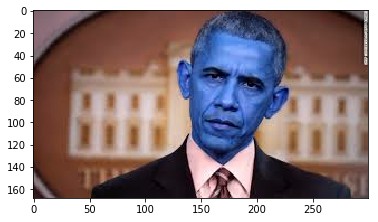

../faces/test/Barack Obama/210.jpg


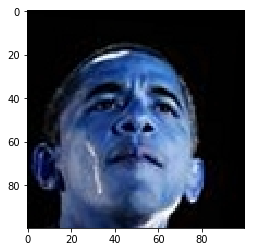

In [132]:
prediction_class = show_predictions(test_image_tensor, model)
compare_prediction(test_image, prediction_class)

#### Visualizing the model performance

In [40]:
import matplotlib.pyplot as plt                        
train_loss = trainning_result.history['loss']
validation_loss = trainning_result.history['val_loss']
train_acc = trainning_result.history['acc']
validation_acc = trainning_result.history['val_acc']
xc = range(90)

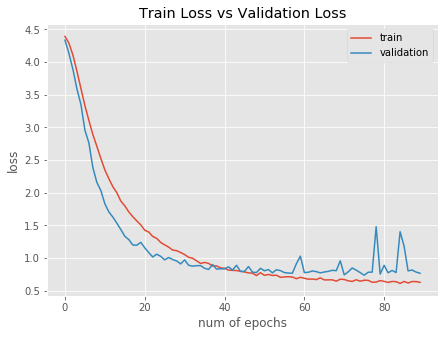

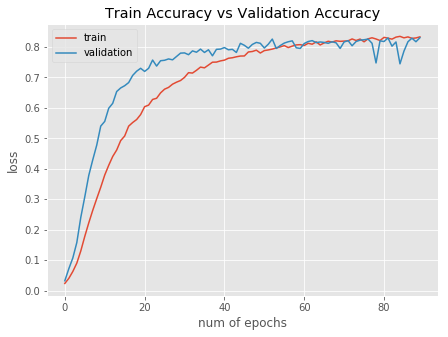

In [41]:
visualize_loss(xc,train_loss, validation_loss)
visualize_acc(xc, train_acc, validation_acc)

#### Visualizing the layers

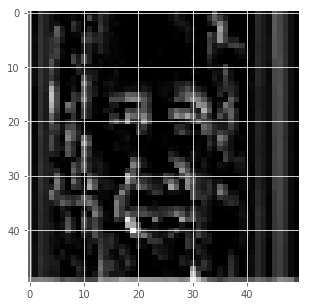

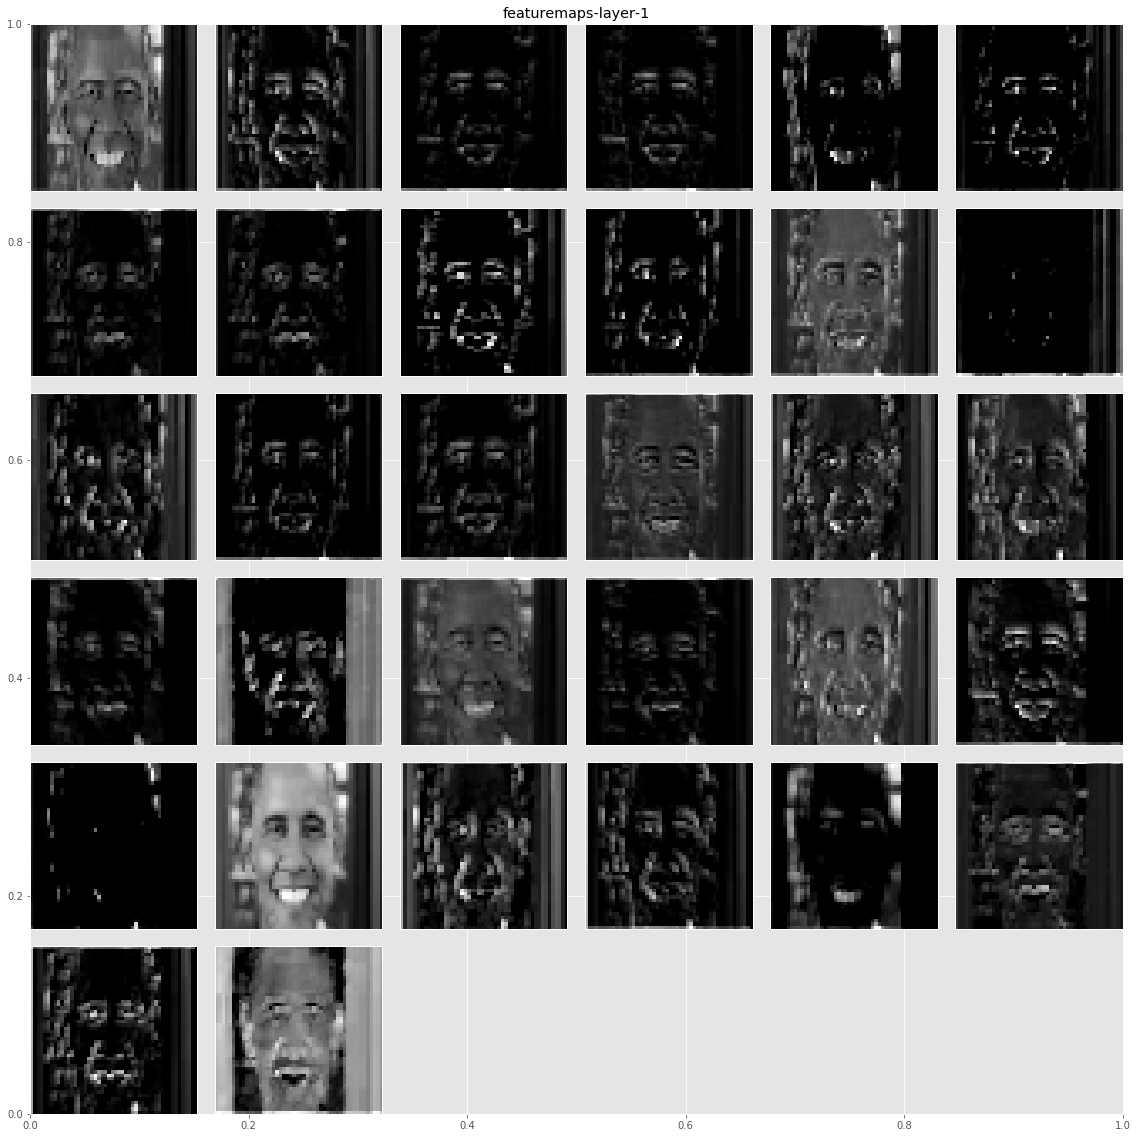

In [34]:
visualize_layer(model, test_image_tensor, layer_num=1)